In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime as dt

from web_crawler import grabDomainRoot

'''
randomWalk(graph, initial_node, step, max_step, path)

Function to take a random walk from a given node

graph: networkx graph, graph from which to random through
initial node: string, initial node to begin the walk
step: int, current step of walk
max_step: int, maximum number of steps to take in walk
path:, list, current path taken in the walk
'''
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph.neighbors(initial_node)]
    
    if len(adjacent_nodes) == 0:
            path.append(None)
            return path
            
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

'''
generateBatch(batch_size, num_context_per_label, context_window, target, step)

batch_size: int, batch size for training
num_context_per_label: int, how many context examples to use per label (the label is the target) 
can't be greater than the context window size
context_window: int, size of the context window 
target: array, the list of targets for each context window
step: int, counter for how many times to step through the same context and target data

Generate the batch data for training. For each "context window", randomly sample a
set of context elements and configure them as training data by constructing column data of,

[target_0, context_0]
[target_0, context_1]
[target_0, context_3]
...
[target_n, context_3]
[target_n, context_2]
[target_n, context_1]

'''
def generateBatch(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    for window_idx in range(passes_through_batch):
        
        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = -1
        while context_samples == -1:
            
            context_samples = random.sample(current_window, num_context_per_label)
        
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

black_list = ['@', ':/']

In [2]:
graph_file = pickle.load(open('crawler_results/graph_calls_620000_stack_test.pkl', 'rb'))

In [3]:
#Create a graph out of the connections
nodes_only = []
web_graph = nx.DiGraph()
#web_graph = nx.Graph()
for node in graph_file.keys():
    domain_node = grabDomainRoot(node)
    domain_node = domain_node.lower()
    #if domain_node == 'offers.usatoday.com':
    #    break
    #    print (domain_node)
    for idx in range(0, len(graph_file[node]), 3):
        key = graph_file[node][idx]

        domain_key = grabDomainRoot(key)

        if domain_node == domain_key: 
            continue        
        
        if domain_node is None or domain_key is None: 
            continue
        
        if True in [i in domain_node for i in black_list] or True in [i in domain_key for i in black_list]:
            continue
            
        domain_key = domain_key.lower()

        web_graph.add_edge(domain_node, domain_key)
        nodes_only.append(domain_node)


NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL


In [4]:
list_of_nodes = [i for i in web_graph.nodes()]

In [13]:
domain_inv_map = {idx:i for idx, i in enumerate(list_of_nodes)}
domain_map = {i:idx for idx, i in enumerate(list_of_nodes)}
domain_map[None] = -1

In [14]:
no_next_neighbors = []
no_neighbors = []
for node in list_of_nodes:
    neighbors = [i for i in web_graph.neighbors(node)]
    for neighbor in neighbors:
        next_neighbors = [i for i in web_graph.neighbors(neighbor)]
    next_neighbor_counts = [len(i) for i in next_neighbors]
    
    if sum(next_neighbor_counts)==0:
        no_next_neighbors.append(node)
        
    if len(neighbors)==0:
        no_neighbors.append(node)    

In [15]:
nodes_only = list(set(nodes_only))

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw(web_graph, node_size=25)#, with_labels=True)
plt.savefig('nytimes_root_graph_directed.png')
#plt.show()

In [16]:
#Sanity check
#print('%d nodes, %d dict terms, %d key_domain dict' % (len(list_of_nodes), len(vocab_dict), len(key_domain_dict)))
print('%d nodes, %d key_domain dict, %d key_nodes only' % (len(list_of_nodes), len(domain_inv_map), len(nodes_only)))

8921 nodes, 8921 key_domain dict, 1574 key_nodes only


In [17]:
max_step = 2# Window size and max_step must be connected

num_skips = 1 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  #Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())
#vocabulary_size = len(nodes_only)

num_sampled = 64 #Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax, 
#this not quite correct as we still doing binary classification, except now we give every negative example to test against,
#as opposed to true multi-class classification
batch_size = 64 #must be a multiple of num_skips
num_steps = len(nodes_only)//batch_size
n_epochs = 80000 #This controls the number of walks from each node

In [18]:
print ('%d nodes, %d steps per epoch' % (vocabulary_size, num_steps))

8921 nodes, 24 steps per epoch


In [19]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [20]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in nodes_only:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            
            path = [domain_map[i] for i in path]
            random_walks.append(path)
        
        data_windows = np.array(random_walks)
                
        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):

            batch_data = generateBatch(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
           
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
         
        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
epoch:0, Average loss:216.8707
epoch:1, Average loss:208.0667
epoch:2, Average loss:201.3598
epoch:3, Average loss:201.3383
epoch:4, Average loss:189.0752
epoch:5, Average loss:197.5544
epoch:6, Average loss:177.8307
epoch:7, Average loss:183.6441
epoch:8, Average loss:184.5139
epoch:9, Average loss:172.3471
epoch:10, Average loss:175.1554
epoch:11, Average loss:174.6802
epoch:12, Average loss:165.5371
epoch:13, Average loss:164.3952
epoch:14, Average loss:170.7864
epoch:15, Average loss:166.2959
epoch:16, Average loss:168.9434
epoch:17, Average loss:163.845
epoch:18, Average loss:167.6701
epoch:19, Average loss:161.4134
epoch:20, Average loss:159.2278
epoch:21, Average loss:152.9276
epoch:22, Average loss:160.554
epoch:23, Average loss:154.8494
epoch:24, Average loss:148.781
epoch:25, Average loss:152.2192
epoch:26, Average loss:154.0201
epoch:27, Average loss:144.9987
epoch:28, Average loss:142.5731
epoch:29, Average loss:148.3596
epoch:30, Average loss:152.8057
epoch:31,

epoch:253, Average loss:28.25652
epoch:254, Average loss:28.20386
epoch:255, Average loss:31.7455
epoch:256, Average loss:30.76854
epoch:257, Average loss:30.58598
epoch:258, Average loss:27.40222
epoch:259, Average loss:27.34876
epoch:260, Average loss:25.76192
epoch:261, Average loss:27.66437
epoch:262, Average loss:26.53174
epoch:263, Average loss:28.94278
epoch:264, Average loss:27.94268
epoch:265, Average loss:26.78448
epoch:266, Average loss:25.50941
epoch:267, Average loss:24.37329
epoch:268, Average loss:24.87096
epoch:269, Average loss:27.43354
epoch:270, Average loss:27.8114
epoch:271, Average loss:25.5456
epoch:272, Average loss:23.54416
epoch:273, Average loss:26.45691
epoch:274, Average loss:25.92435
epoch:275, Average loss:28.77406
epoch:276, Average loss:25.9978
epoch:277, Average loss:25.45089
epoch:278, Average loss:27.23234
epoch:279, Average loss:26.78999
epoch:280, Average loss:23.33354
epoch:281, Average loss:26.51551
epoch:282, Average loss:24.54546
epoch:283, Ave

epoch:502, Average loss:17.44997
epoch:503, Average loss:18.03782
epoch:504, Average loss:18.8972
epoch:505, Average loss:18.04519
epoch:506, Average loss:19.85665
epoch:507, Average loss:17.87187
epoch:508, Average loss:17.14923
epoch:509, Average loss:19.62476
epoch:510, Average loss:18.6515
epoch:511, Average loss:18.24231
epoch:512, Average loss:17.69824
epoch:513, Average loss:17.76096
epoch:514, Average loss:18.3706
epoch:515, Average loss:19.09093
epoch:516, Average loss:18.25026
epoch:517, Average loss:18.34794
epoch:518, Average loss:18.4099
epoch:519, Average loss:17.9582
epoch:520, Average loss:19.31558
epoch:521, Average loss:17.49117
epoch:522, Average loss:17.59198
epoch:523, Average loss:17.1781
epoch:524, Average loss:18.59865
epoch:525, Average loss:16.70825
epoch:526, Average loss:18.80957
epoch:527, Average loss:17.69087
epoch:528, Average loss:17.00863
epoch:529, Average loss:18.75071
epoch:530, Average loss:18.21133
epoch:531, Average loss:17.0683
epoch:532, Averag

epoch:753, Average loss:15.93112
epoch:754, Average loss:15.25826
epoch:755, Average loss:15.17136
epoch:756, Average loss:15.22051
epoch:757, Average loss:15.34807
epoch:758, Average loss:15.799
epoch:759, Average loss:14.60905
epoch:760, Average loss:14.96115
epoch:761, Average loss:16.32419
epoch:762, Average loss:15.92797
epoch:763, Average loss:15.05151
epoch:764, Average loss:16.64509
epoch:765, Average loss:14.77464
epoch:766, Average loss:14.12749
epoch:767, Average loss:14.26284
epoch:768, Average loss:16.55698
epoch:769, Average loss:16.21471
epoch:770, Average loss:16.03432
epoch:771, Average loss:15.55129
epoch:772, Average loss:15.99414
epoch:773, Average loss:15.69303
epoch:774, Average loss:16.00817
epoch:775, Average loss:14.812
epoch:776, Average loss:13.99059
epoch:777, Average loss:15.46352
epoch:778, Average loss:15.70638
epoch:779, Average loss:16.64137
epoch:780, Average loss:15.43659
epoch:781, Average loss:16.43344
epoch:782, Average loss:15.79363
epoch:783, Ave

epoch:1003, Average loss:13.59181
epoch:1004, Average loss:14.47179
epoch:1005, Average loss:13.91669
epoch:1006, Average loss:15.89488
epoch:1007, Average loss:13.94274
epoch:1008, Average loss:15.22171
epoch:1009, Average loss:13.59229
epoch:1010, Average loss:13.59372
epoch:1011, Average loss:14.33551
epoch:1012, Average loss:13.78779
epoch:1013, Average loss:14.35666
epoch:1014, Average loss:13.00222
epoch:1015, Average loss:15.10614
epoch:1016, Average loss:13.81415
epoch:1017, Average loss:14.6844
epoch:1018, Average loss:13.7204
epoch:1019, Average loss:13.84436
epoch:1020, Average loss:14.28446
epoch:1021, Average loss:12.99209
epoch:1022, Average loss:15.14749
epoch:1023, Average loss:13.62923
epoch:1024, Average loss:13.16338
epoch:1025, Average loss:12.70257
epoch:1026, Average loss:13.7187
epoch:1027, Average loss:13.37047
epoch:1028, Average loss:14.17376
epoch:1029, Average loss:13.76418
epoch:1030, Average loss:13.45679
epoch:1031, Average loss:14.63997
epoch:1032, Avera

epoch:1246, Average loss:12.88969
epoch:1247, Average loss:13.07678
epoch:1248, Average loss:12.412
epoch:1249, Average loss:11.85415
epoch:1250, Average loss:12.40772
epoch:1251, Average loss:13.02043
epoch:1252, Average loss:12.8762
epoch:1253, Average loss:13.43329
epoch:1254, Average loss:13.05737
epoch:1255, Average loss:13.55361
epoch:1256, Average loss:12.64776
epoch:1257, Average loss:11.40692
epoch:1258, Average loss:12.91578
epoch:1259, Average loss:13.71144
epoch:1260, Average loss:12.38014
epoch:1261, Average loss:11.60892
epoch:1262, Average loss:13.90361
epoch:1263, Average loss:12.358
epoch:1264, Average loss:12.02708
epoch:1265, Average loss:13.40726
epoch:1266, Average loss:12.59009
epoch:1267, Average loss:12.94425
epoch:1268, Average loss:12.84475
epoch:1269, Average loss:12.53178
epoch:1270, Average loss:13.19974
epoch:1271, Average loss:12.98292
epoch:1272, Average loss:13.10694
epoch:1273, Average loss:12.14
epoch:1274, Average loss:13.82751
epoch:1275, Average lo

epoch:1489, Average loss:11.43479
epoch:1490, Average loss:11.02622
epoch:1491, Average loss:11.52244
epoch:1492, Average loss:12.67576
epoch:1493, Average loss:11.91986
epoch:1494, Average loss:11.81049
epoch:1495, Average loss:10.48977
epoch:1496, Average loss:11.22061
epoch:1497, Average loss:12.07204
epoch:1498, Average loss:11.02321
epoch:1499, Average loss:11.83811
epoch:1500, Average loss:11.01141
epoch:1501, Average loss:11.56685
epoch:1502, Average loss:11.57523
epoch:1503, Average loss:11.09762
epoch:1504, Average loss:11.71621
epoch:1505, Average loss:11.38189
epoch:1506, Average loss:11.82408
epoch:1507, Average loss:10.58128
epoch:1508, Average loss:11.43447
epoch:1509, Average loss:11.8067
epoch:1510, Average loss:11.13646
epoch:1511, Average loss:13.36235
epoch:1512, Average loss:12.59724
epoch:1513, Average loss:11.19069
epoch:1514, Average loss:11.06053
epoch:1515, Average loss:11.94843
epoch:1516, Average loss:11.21462
epoch:1517, Average loss:10.01259
epoch:1518, Ave

epoch:1732, Average loss:10.77477
epoch:1733, Average loss:10.31716
epoch:1734, Average loss:10.28944
epoch:1735, Average loss:9.636288
epoch:1736, Average loss:9.724743
epoch:1737, Average loss:11.38443
epoch:1738, Average loss:9.430619
epoch:1739, Average loss:10.09966
epoch:1740, Average loss:10.50867
epoch:1741, Average loss:11.15918
epoch:1742, Average loss:10.73608
epoch:1743, Average loss:11.52137
epoch:1744, Average loss:11.4934
epoch:1745, Average loss:9.802009
epoch:1746, Average loss:10.57962
epoch:1747, Average loss:10.81889
epoch:1748, Average loss:10.7546
epoch:1749, Average loss:10.9339
epoch:1750, Average loss:11.68437
epoch:1751, Average loss:9.928419
epoch:1752, Average loss:10.11261
epoch:1753, Average loss:9.872482
epoch:1754, Average loss:9.797575
epoch:1755, Average loss:11.52336
epoch:1756, Average loss:11.13725
epoch:1757, Average loss:9.523943
epoch:1758, Average loss:10.80154
epoch:1759, Average loss:10.29909
epoch:1760, Average loss:10.59427
epoch:1761, Avera

epoch:1975, Average loss:9.095406
epoch:1976, Average loss:9.319361
epoch:1977, Average loss:9.934206
epoch:1978, Average loss:10.16814
epoch:1979, Average loss:10.84692
epoch:1980, Average loss:10.59703
epoch:1981, Average loss:9.866239
epoch:1982, Average loss:10.04826
epoch:1983, Average loss:9.96774
epoch:1984, Average loss:10.22125
epoch:1985, Average loss:10.51735
epoch:1986, Average loss:9.633995
epoch:1987, Average loss:9.717048
epoch:1988, Average loss:10.79928
epoch:1989, Average loss:10.32441
epoch:1990, Average loss:10.22656
epoch:1991, Average loss:9.616183
epoch:1992, Average loss:9.809994
epoch:1993, Average loss:9.744568
epoch:1994, Average loss:10.83547
epoch:1995, Average loss:10.74897
epoch:1996, Average loss:10.2695
epoch:1997, Average loss:10.42103
epoch:1998, Average loss:10.32785
epoch:1999, Average loss:10.04447
epoch:2000, Average loss:9.547347
epoch:2001, Average loss:10.0211
epoch:2002, Average loss:10.34404
epoch:2003, Average loss:9.355114
epoch:2004, Avera

epoch:2218, Average loss:9.248814
epoch:2219, Average loss:9.312503
epoch:2220, Average loss:10.41341
epoch:2221, Average loss:9.411187
epoch:2222, Average loss:9.448667
epoch:2223, Average loss:9.560121
epoch:2224, Average loss:9.066425
epoch:2225, Average loss:8.972802
epoch:2226, Average loss:9.092588
epoch:2227, Average loss:9.481667
epoch:2228, Average loss:9.2887
epoch:2229, Average loss:9.39445
epoch:2230, Average loss:9.922267
epoch:2231, Average loss:9.608713
epoch:2232, Average loss:9.502222
epoch:2233, Average loss:9.92464
epoch:2234, Average loss:10.06788
epoch:2235, Average loss:10.2482
epoch:2236, Average loss:9.555495
epoch:2237, Average loss:9.067738
epoch:2238, Average loss:9.541161
epoch:2239, Average loss:10.08383
epoch:2240, Average loss:10.06509
epoch:2241, Average loss:9.613906
epoch:2242, Average loss:9.877059
epoch:2243, Average loss:9.649919
epoch:2244, Average loss:9.705742
epoch:2245, Average loss:10.32325
epoch:2246, Average loss:9.981613
epoch:2247, Average

epoch:2461, Average loss:9.068142
epoch:2462, Average loss:9.32623
epoch:2463, Average loss:8.73747
epoch:2464, Average loss:8.240268
epoch:2465, Average loss:8.999043
epoch:2466, Average loss:9.593514
epoch:2467, Average loss:9.537409
epoch:2468, Average loss:9.842075
epoch:2469, Average loss:8.531881
epoch:2470, Average loss:8.373599
epoch:2471, Average loss:8.159644
epoch:2472, Average loss:8.18444
epoch:2473, Average loss:8.750407
epoch:2474, Average loss:9.50864
epoch:2475, Average loss:8.732428
epoch:2476, Average loss:8.83312
epoch:2477, Average loss:9.749699
epoch:2478, Average loss:9.088576
epoch:2479, Average loss:8.494377
epoch:2480, Average loss:9.097857
epoch:2481, Average loss:8.910145
epoch:2482, Average loss:9.345716
epoch:2483, Average loss:8.803637
epoch:2484, Average loss:8.539569
epoch:2485, Average loss:9.167123
epoch:2486, Average loss:8.65439
epoch:2487, Average loss:8.711979
epoch:2488, Average loss:8.018004
epoch:2489, Average loss:7.939204
epoch:2490, Average 

epoch:2703, Average loss:8.014135
epoch:2704, Average loss:8.105471
epoch:2705, Average loss:8.188411
epoch:2706, Average loss:8.535477
epoch:2707, Average loss:7.521644
epoch:2708, Average loss:8.094635
epoch:2709, Average loss:8.254845
epoch:2710, Average loss:9.323513
epoch:2711, Average loss:8.253588
epoch:2712, Average loss:8.510605
epoch:2713, Average loss:8.946969
epoch:2714, Average loss:8.493585
epoch:2715, Average loss:9.012881
epoch:2716, Average loss:8.621363
epoch:2717, Average loss:8.94322
epoch:2718, Average loss:8.77449
epoch:2719, Average loss:8.431343
epoch:2720, Average loss:8.408927
epoch:2721, Average loss:7.849823
epoch:2722, Average loss:8.939266
epoch:2723, Average loss:8.112992
epoch:2724, Average loss:8.441566
epoch:2725, Average loss:8.123248
epoch:2726, Average loss:8.810636
epoch:2727, Average loss:8.34164
epoch:2728, Average loss:8.869525
epoch:2729, Average loss:7.981692
epoch:2730, Average loss:8.439261
epoch:2731, Average loss:7.873745
epoch:2732, Avera

epoch:2946, Average loss:7.655703
epoch:2947, Average loss:8.551082
epoch:2948, Average loss:7.827882
epoch:2949, Average loss:7.744088
epoch:2950, Average loss:7.542361
epoch:2951, Average loss:8.383461
epoch:2952, Average loss:8.758286
epoch:2953, Average loss:7.678093
epoch:2954, Average loss:8.83795
epoch:2955, Average loss:7.528173
epoch:2956, Average loss:7.855534
epoch:2957, Average loss:8.629541
epoch:2958, Average loss:7.380758
epoch:2959, Average loss:7.113386
epoch:2960, Average loss:8.014055
epoch:2961, Average loss:7.845174
epoch:2962, Average loss:7.828668
epoch:2963, Average loss:7.203637
epoch:2964, Average loss:7.400022
epoch:2965, Average loss:7.197469
epoch:2966, Average loss:7.937582
epoch:2967, Average loss:8.245731
epoch:2968, Average loss:6.988256
epoch:2969, Average loss:7.42342
epoch:2970, Average loss:8.418439
epoch:2971, Average loss:8.420648
epoch:2972, Average loss:8.078588
epoch:2973, Average loss:8.512288
epoch:2974, Average loss:7.527592
epoch:2975, Aver

epoch:3189, Average loss:8.347415
epoch:3190, Average loss:7.399052
epoch:3191, Average loss:7.709934
epoch:3192, Average loss:7.887348
epoch:3193, Average loss:6.894475
epoch:3194, Average loss:7.586424
epoch:3195, Average loss:8.016156
epoch:3196, Average loss:7.088716
epoch:3197, Average loss:7.41233
epoch:3198, Average loss:7.654742
epoch:3199, Average loss:7.737
epoch:3200, Average loss:8.141527
epoch:3201, Average loss:7.517482
epoch:3202, Average loss:7.106568
epoch:3203, Average loss:6.748669
epoch:3204, Average loss:6.952635
epoch:3205, Average loss:8.261358
epoch:3206, Average loss:7.224292
epoch:3207, Average loss:7.98207
epoch:3208, Average loss:6.467207
epoch:3209, Average loss:7.131301
epoch:3210, Average loss:7.370556
epoch:3211, Average loss:6.876296
epoch:3212, Average loss:6.636221
epoch:3213, Average loss:7.698824
epoch:3214, Average loss:8.103823
epoch:3215, Average loss:7.443844
epoch:3216, Average loss:7.46566
epoch:3217, Average loss:7.012442
epoch:3218, Average 

epoch:3432, Average loss:7.482756
epoch:3433, Average loss:7.008325
epoch:3434, Average loss:7.041029
epoch:3435, Average loss:7.073545
epoch:3436, Average loss:7.207706
epoch:3437, Average loss:7.580371
epoch:3438, Average loss:7.75794
epoch:3439, Average loss:7.270219
epoch:3440, Average loss:7.383014
epoch:3441, Average loss:6.956032
epoch:3442, Average loss:6.978394
epoch:3443, Average loss:7.426911
epoch:3444, Average loss:6.59156
epoch:3445, Average loss:7.12654
epoch:3446, Average loss:7.342312
epoch:3447, Average loss:7.443078
epoch:3448, Average loss:7.612059
epoch:3449, Average loss:7.454744
epoch:3450, Average loss:6.854291
epoch:3451, Average loss:7.541559
epoch:3452, Average loss:6.867991
epoch:3453, Average loss:6.713874
epoch:3454, Average loss:6.560174
epoch:3455, Average loss:7.003453
epoch:3456, Average loss:6.677147
epoch:3457, Average loss:7.568354
epoch:3458, Average loss:6.627661
epoch:3459, Average loss:7.171235
epoch:3460, Average loss:6.704692
epoch:3461, Avera

epoch:3675, Average loss:6.959347
epoch:3676, Average loss:6.793055
epoch:3677, Average loss:6.842185
epoch:3678, Average loss:6.840338
epoch:3679, Average loss:6.18424
epoch:3680, Average loss:7.266221
epoch:3681, Average loss:7.296052
epoch:3682, Average loss:5.93646
epoch:3683, Average loss:7.300298
epoch:3684, Average loss:6.568683
epoch:3685, Average loss:6.585398
epoch:3686, Average loss:6.814293
epoch:3687, Average loss:6.740756
epoch:3688, Average loss:6.553486
epoch:3689, Average loss:6.583161
epoch:3690, Average loss:6.968461
epoch:3691, Average loss:6.90625
epoch:3692, Average loss:7.027391
epoch:3693, Average loss:6.439795
epoch:3694, Average loss:6.386646
epoch:3695, Average loss:6.103041
epoch:3696, Average loss:5.466904
epoch:3697, Average loss:6.564903
epoch:3698, Average loss:6.743268
epoch:3699, Average loss:7.240999
epoch:3700, Average loss:6.649048
epoch:3701, Average loss:6.145804
epoch:3702, Average loss:6.891528
epoch:3703, Average loss:7.232679
epoch:3704, Avera

epoch:3917, Average loss:5.821456
epoch:3918, Average loss:5.708583
epoch:3919, Average loss:6.38187
epoch:3920, Average loss:6.769835
epoch:3921, Average loss:6.145154
epoch:3922, Average loss:6.527518
epoch:3923, Average loss:6.625993
epoch:3924, Average loss:6.544434
epoch:3925, Average loss:6.810728
epoch:3926, Average loss:6.659023
epoch:3927, Average loss:5.922813
epoch:3928, Average loss:6.595936
epoch:3929, Average loss:6.874945
epoch:3930, Average loss:5.551831
epoch:3931, Average loss:6.318805
epoch:3932, Average loss:6.67859
epoch:3933, Average loss:6.093074
epoch:3934, Average loss:6.983269
epoch:3935, Average loss:6.488662
epoch:3936, Average loss:6.292705
epoch:3937, Average loss:5.826488
epoch:3938, Average loss:6.229303
epoch:3939, Average loss:6.088923
epoch:3940, Average loss:6.180167
epoch:3941, Average loss:6.559217
epoch:3942, Average loss:5.649088
epoch:3943, Average loss:5.82331
epoch:3944, Average loss:6.738882
epoch:3945, Average loss:5.938826
epoch:3946, Avera

epoch:4159, Average loss:6.518025
epoch:4160, Average loss:5.124971
epoch:4161, Average loss:5.229816
epoch:4162, Average loss:5.902106
epoch:4163, Average loss:6.058017
epoch:4164, Average loss:6.2223
epoch:4165, Average loss:5.09766
epoch:4166, Average loss:5.748779
epoch:4167, Average loss:6.227228
epoch:4168, Average loss:6.298475
epoch:4169, Average loss:5.97595
epoch:4170, Average loss:6.225102
epoch:4171, Average loss:5.558988
epoch:4172, Average loss:5.502818
epoch:4173, Average loss:5.646715
epoch:4174, Average loss:6.076264
epoch:4175, Average loss:7.105797
epoch:4176, Average loss:5.744594
epoch:4177, Average loss:5.61563
epoch:4178, Average loss:5.878708
epoch:4179, Average loss:6.357355
epoch:4180, Average loss:6.610555
epoch:4181, Average loss:6.385954
epoch:4182, Average loss:5.697467
epoch:4183, Average loss:6.439661
epoch:4184, Average loss:6.001613
epoch:4185, Average loss:6.409871
epoch:4186, Average loss:6.182778
epoch:4187, Average loss:5.580184
epoch:4188, Average

epoch:4403, Average loss:5.568386
epoch:4404, Average loss:5.58856
epoch:4405, Average loss:5.928239
epoch:4406, Average loss:5.090822
epoch:4407, Average loss:6.263983
epoch:4408, Average loss:5.892889
epoch:4409, Average loss:5.991132
epoch:4410, Average loss:5.947955
epoch:4411, Average loss:5.392586
epoch:4412, Average loss:5.341647
epoch:4413, Average loss:5.031815
epoch:4414, Average loss:5.275142
epoch:4415, Average loss:5.927009
epoch:4416, Average loss:5.659986
epoch:4417, Average loss:5.814422
epoch:4418, Average loss:5.596221
epoch:4419, Average loss:6.060609
epoch:4420, Average loss:5.725438
epoch:4421, Average loss:5.188148
epoch:4422, Average loss:6.124131
epoch:4423, Average loss:5.411182
epoch:4424, Average loss:5.364864
epoch:4425, Average loss:5.312713
epoch:4426, Average loss:5.585049
epoch:4427, Average loss:5.415247
epoch:4428, Average loss:5.646566
epoch:4429, Average loss:5.65555
epoch:4430, Average loss:5.498852
epoch:4431, Average loss:5.586911
epoch:4432, Aver

epoch:4645, Average loss:5.900447
epoch:4646, Average loss:5.102078
epoch:4647, Average loss:5.647741
epoch:4648, Average loss:5.376626
epoch:4649, Average loss:5.820564
epoch:4650, Average loss:6.135375
epoch:4651, Average loss:5.800984
epoch:4652, Average loss:5.710833
epoch:4653, Average loss:5.096817
epoch:4654, Average loss:5.472597
epoch:4655, Average loss:5.252932
epoch:4656, Average loss:5.115758
epoch:4657, Average loss:5.54506
epoch:4658, Average loss:5.352584
epoch:4659, Average loss:5.292522
epoch:4660, Average loss:5.635044
epoch:4661, Average loss:5.578514
epoch:4662, Average loss:5.180826
epoch:4663, Average loss:5.507736
epoch:4664, Average loss:5.169055
epoch:4665, Average loss:5.938504
epoch:4666, Average loss:5.137412
epoch:4667, Average loss:5.895747
epoch:4668, Average loss:5.632894
epoch:4669, Average loss:6.053243
epoch:4670, Average loss:5.55532
epoch:4671, Average loss:5.757162
epoch:4672, Average loss:5.46947
epoch:4673, Average loss:6.457684
epoch:4674, Avera

epoch:4888, Average loss:5.674986
epoch:4889, Average loss:4.99886
epoch:4890, Average loss:6.065116
epoch:4891, Average loss:5.332879
epoch:4892, Average loss:4.685377
epoch:4893, Average loss:5.491433
epoch:4894, Average loss:5.209774
epoch:4895, Average loss:5.109271
epoch:4896, Average loss:5.826023
epoch:4897, Average loss:5.449973
epoch:4898, Average loss:5.72206
epoch:4899, Average loss:4.509539
epoch:4900, Average loss:4.7467
epoch:4901, Average loss:5.135439
epoch:4902, Average loss:4.843131
epoch:4903, Average loss:4.805832
epoch:4904, Average loss:4.834728
epoch:4905, Average loss:5.681038
epoch:4906, Average loss:5.090955
epoch:4907, Average loss:5.075528
epoch:4908, Average loss:5.194785
epoch:4909, Average loss:5.719748
epoch:4910, Average loss:5.174468
epoch:4911, Average loss:4.636936
epoch:4912, Average loss:5.618644
epoch:4913, Average loss:4.789646
epoch:4914, Average loss:5.330965
epoch:4915, Average loss:5.328981
epoch:4916, Average loss:5.485676
epoch:4917, Averag

epoch:5131, Average loss:5.336528
epoch:5132, Average loss:5.173365
epoch:5133, Average loss:4.90109
epoch:5134, Average loss:5.310095
epoch:5135, Average loss:5.121947
epoch:5136, Average loss:4.967954
epoch:5137, Average loss:5.392974
epoch:5138, Average loss:5.116642
epoch:5139, Average loss:5.230603
epoch:5140, Average loss:4.723918
epoch:5141, Average loss:5.258527
epoch:5142, Average loss:5.227336
epoch:5143, Average loss:5.415778
epoch:5144, Average loss:5.11806
epoch:5145, Average loss:5.094666
epoch:5146, Average loss:4.794963
epoch:5147, Average loss:4.788941
epoch:5148, Average loss:4.79912
epoch:5149, Average loss:4.816702
epoch:5150, Average loss:4.938671
epoch:5151, Average loss:4.709752
epoch:5152, Average loss:4.714191
epoch:5153, Average loss:5.740612
epoch:5154, Average loss:4.681845
epoch:5155, Average loss:5.364949
epoch:5156, Average loss:5.283187
epoch:5157, Average loss:4.386193
epoch:5158, Average loss:5.10092
epoch:5159, Average loss:4.602166
epoch:5160, Averag

epoch:5374, Average loss:4.49595
epoch:5375, Average loss:4.788546
epoch:5376, Average loss:5.107126
epoch:5377, Average loss:4.475262
epoch:5378, Average loss:4.100061
epoch:5379, Average loss:5.125391
epoch:5380, Average loss:4.276232
epoch:5381, Average loss:4.759515
epoch:5382, Average loss:5.185399
epoch:5383, Average loss:4.491762
epoch:5384, Average loss:4.358755
epoch:5385, Average loss:4.693191
epoch:5386, Average loss:4.98505
epoch:5387, Average loss:5.093899
epoch:5388, Average loss:4.534917
epoch:5389, Average loss:4.844834
epoch:5390, Average loss:4.783677
epoch:5391, Average loss:4.624731
epoch:5392, Average loss:4.986443
epoch:5393, Average loss:4.780476
epoch:5394, Average loss:4.533186
epoch:5395, Average loss:4.988569
epoch:5396, Average loss:4.960013
epoch:5397, Average loss:4.493834
epoch:5398, Average loss:4.878391
epoch:5399, Average loss:4.646393
epoch:5400, Average loss:4.053162
epoch:5401, Average loss:5.245229
epoch:5402, Average loss:5.252701
epoch:5403, Aver

epoch:5616, Average loss:4.653836
epoch:5617, Average loss:4.753134
epoch:5618, Average loss:4.745745
epoch:5619, Average loss:4.534962
epoch:5620, Average loss:4.672605
epoch:5621, Average loss:4.739562
epoch:5622, Average loss:4.430425
epoch:5623, Average loss:4.358012
epoch:5624, Average loss:4.360976
epoch:5625, Average loss:4.770484
epoch:5626, Average loss:4.169186
epoch:5627, Average loss:4.288182
epoch:5628, Average loss:3.726749
epoch:5629, Average loss:5.138505
epoch:5630, Average loss:4.571668
epoch:5631, Average loss:4.191634
epoch:5632, Average loss:5.104301
epoch:5633, Average loss:4.381878
epoch:5634, Average loss:4.686122
epoch:5635, Average loss:3.820171
epoch:5636, Average loss:4.667517
epoch:5637, Average loss:4.242939
epoch:5638, Average loss:4.131276
epoch:5639, Average loss:4.589588
epoch:5640, Average loss:4.657437
epoch:5641, Average loss:4.687859
epoch:5642, Average loss:4.489561
epoch:5643, Average loss:4.214883
epoch:5644, Average loss:4.816788
epoch:5645, Av

epoch:5858, Average loss:4.377356
epoch:5859, Average loss:4.132967
epoch:5860, Average loss:4.198005
epoch:5861, Average loss:3.91046
epoch:5862, Average loss:4.499791
epoch:5863, Average loss:4.502802
epoch:5864, Average loss:4.857941
epoch:5865, Average loss:4.621777
epoch:5866, Average loss:4.744168
epoch:5867, Average loss:4.505422
epoch:5868, Average loss:4.040326
epoch:5869, Average loss:4.737761
epoch:5870, Average loss:4.20422
epoch:5871, Average loss:4.460712
epoch:5872, Average loss:4.440046
epoch:5873, Average loss:4.088427
epoch:5874, Average loss:4.47323
epoch:5875, Average loss:4.129481
epoch:5876, Average loss:4.46965
epoch:5877, Average loss:4.272814
epoch:5878, Average loss:4.182584
epoch:5879, Average loss:4.297031
epoch:5880, Average loss:4.155679
epoch:5881, Average loss:4.245132
epoch:5882, Average loss:4.232725
epoch:5883, Average loss:4.285812
epoch:5884, Average loss:4.334845
epoch:5885, Average loss:4.119359
epoch:5886, Average loss:3.99956
epoch:5887, Average

epoch:6102, Average loss:4.633805
epoch:6103, Average loss:4.103247
epoch:6104, Average loss:3.939685
epoch:6105, Average loss:3.902811
epoch:6106, Average loss:3.790736
epoch:6107, Average loss:4.379462
epoch:6108, Average loss:4.612048
epoch:6109, Average loss:4.480316
epoch:6110, Average loss:4.545606
epoch:6111, Average loss:3.698022
epoch:6112, Average loss:4.31374
epoch:6113, Average loss:4.351523
epoch:6114, Average loss:3.766349
epoch:6115, Average loss:4.193458
epoch:6116, Average loss:4.350722
epoch:6117, Average loss:4.326146
epoch:6118, Average loss:3.934
epoch:6119, Average loss:3.61069
epoch:6120, Average loss:4.20344
epoch:6121, Average loss:4.814913
epoch:6122, Average loss:4.229183
epoch:6123, Average loss:4.047372
epoch:6124, Average loss:3.785355
epoch:6125, Average loss:3.801327
epoch:6126, Average loss:4.089505
epoch:6127, Average loss:4.336088
epoch:6128, Average loss:4.291984
epoch:6129, Average loss:4.136014
epoch:6130, Average loss:3.677869
epoch:6131, Average 

epoch:6344, Average loss:4.285171
epoch:6345, Average loss:3.958932
epoch:6346, Average loss:3.973355
epoch:6347, Average loss:3.764394
epoch:6348, Average loss:4.113845
epoch:6349, Average loss:3.922567
epoch:6350, Average loss:4.344426
epoch:6351, Average loss:3.752007
epoch:6352, Average loss:3.751425
epoch:6353, Average loss:3.902087
epoch:6354, Average loss:4.082988
epoch:6355, Average loss:4.049316
epoch:6356, Average loss:3.970252
epoch:6357, Average loss:3.785173
epoch:6358, Average loss:3.603344
epoch:6359, Average loss:4.06273
epoch:6360, Average loss:4.008337
epoch:6361, Average loss:3.808035
epoch:6362, Average loss:3.619826
epoch:6363, Average loss:4.0603
epoch:6364, Average loss:4.165566
epoch:6365, Average loss:3.918735
epoch:6366, Average loss:4.16024
epoch:6367, Average loss:3.625177
epoch:6368, Average loss:3.935404
epoch:6369, Average loss:4.058513
epoch:6370, Average loss:4.172593
epoch:6371, Average loss:3.550407
epoch:6372, Average loss:3.933578
epoch:6373, Averag

epoch:6586, Average loss:3.990214
epoch:6587, Average loss:4.019311
epoch:6588, Average loss:4.199699
epoch:6589, Average loss:3.535485
epoch:6590, Average loss:3.530949
epoch:6591, Average loss:3.787505
epoch:6592, Average loss:4.19413
epoch:6593, Average loss:3.746376
epoch:6594, Average loss:3.588123
epoch:6595, Average loss:4.156879
epoch:6596, Average loss:3.935599
epoch:6597, Average loss:3.451967
epoch:6598, Average loss:3.944692
epoch:6599, Average loss:3.526351
epoch:6600, Average loss:4.23013
epoch:6601, Average loss:3.717559
epoch:6602, Average loss:3.384878
epoch:6603, Average loss:3.458731
epoch:6604, Average loss:3.392499
epoch:6605, Average loss:3.759048
epoch:6606, Average loss:3.860041
epoch:6607, Average loss:3.771347
epoch:6608, Average loss:3.474764
epoch:6609, Average loss:3.940552
epoch:6610, Average loss:4.322241
epoch:6611, Average loss:4.11765
epoch:6612, Average loss:3.682608
epoch:6613, Average loss:4.167288
epoch:6614, Average loss:3.608291
epoch:6615, Avera

epoch:6829, Average loss:3.89891
epoch:6830, Average loss:3.509784
epoch:6831, Average loss:3.214584
epoch:6832, Average loss:4.1259
epoch:6833, Average loss:3.712672
epoch:6834, Average loss:3.371503
epoch:6835, Average loss:3.96402
epoch:6836, Average loss:3.284507
epoch:6837, Average loss:4.023855
epoch:6838, Average loss:3.409337
epoch:6839, Average loss:3.450442
epoch:6840, Average loss:3.806213
epoch:6841, Average loss:4.171235
epoch:6842, Average loss:3.621009
epoch:6843, Average loss:3.71893
epoch:6844, Average loss:3.653898
epoch:6845, Average loss:3.431009
epoch:6846, Average loss:3.754512
epoch:6847, Average loss:3.628493
epoch:6848, Average loss:3.88274
epoch:6849, Average loss:3.689421
epoch:6850, Average loss:3.64588
epoch:6851, Average loss:3.684672
epoch:6852, Average loss:3.683933
epoch:6853, Average loss:3.919073
epoch:6854, Average loss:3.160959
epoch:6855, Average loss:4.046654
epoch:6856, Average loss:3.397549
epoch:6857, Average loss:3.510643
epoch:6858, Average l

epoch:7073, Average loss:3.714713
epoch:7074, Average loss:3.699353
epoch:7075, Average loss:3.502002
epoch:7076, Average loss:3.349293
epoch:7077, Average loss:3.560627
epoch:7078, Average loss:3.791609
epoch:7079, Average loss:3.489214
epoch:7080, Average loss:3.254315
epoch:7081, Average loss:3.592771
epoch:7082, Average loss:3.660737
epoch:7083, Average loss:3.613776
epoch:7084, Average loss:3.267855
epoch:7085, Average loss:3.757324
epoch:7086, Average loss:3.202955
epoch:7087, Average loss:3.18727
epoch:7088, Average loss:3.418462
epoch:7089, Average loss:3.473267
epoch:7090, Average loss:3.701323
epoch:7091, Average loss:3.600394
epoch:7092, Average loss:3.47728
epoch:7093, Average loss:3.757818
epoch:7094, Average loss:3.018502
epoch:7095, Average loss:3.489311
epoch:7096, Average loss:3.271224
epoch:7097, Average loss:3.442619
epoch:7098, Average loss:3.52851
epoch:7099, Average loss:3.320151
epoch:7100, Average loss:3.781951
epoch:7101, Average loss:3.867528
epoch:7102, Avera

epoch:7315, Average loss:3.39748
epoch:7316, Average loss:2.989449
epoch:7317, Average loss:3.120601
epoch:7318, Average loss:3.5207
epoch:7319, Average loss:3.083509
epoch:7320, Average loss:3.261648
epoch:7321, Average loss:3.088537
epoch:7322, Average loss:3.366839
epoch:7323, Average loss:3.584966
epoch:7324, Average loss:3.660362
epoch:7325, Average loss:3.031884
epoch:7326, Average loss:3.345318
epoch:7327, Average loss:3.329718
epoch:7328, Average loss:3.10771
epoch:7329, Average loss:3.499103
epoch:7330, Average loss:2.876271
epoch:7331, Average loss:3.316294
epoch:7332, Average loss:3.275654
epoch:7333, Average loss:3.851778
epoch:7334, Average loss:3.12048
epoch:7335, Average loss:3.295577
epoch:7336, Average loss:3.52743
epoch:7337, Average loss:3.692174
epoch:7338, Average loss:3.836074
epoch:7339, Average loss:3.251889
epoch:7340, Average loss:3.321443
epoch:7341, Average loss:3.413395
epoch:7342, Average loss:3.344483
epoch:7343, Average loss:3.011133
epoch:7344, Average 

epoch:7557, Average loss:3.399302
epoch:7558, Average loss:3.244353
epoch:7559, Average loss:3.226991
epoch:7560, Average loss:3.075796
epoch:7561, Average loss:3.51527
epoch:7562, Average loss:3.233272
epoch:7563, Average loss:3.393736
epoch:7564, Average loss:3.096987
epoch:7565, Average loss:3.084693
epoch:7566, Average loss:3.228822
epoch:7567, Average loss:2.96639
epoch:7568, Average loss:3.164373
epoch:7569, Average loss:3.32199
epoch:7570, Average loss:3.437986
epoch:7571, Average loss:3.383763
epoch:7572, Average loss:3.242949
epoch:7573, Average loss:3.264021
epoch:7574, Average loss:3.388686
epoch:7575, Average loss:3.062059
epoch:7576, Average loss:3.107621
epoch:7577, Average loss:3.29185
epoch:7578, Average loss:3.560694
epoch:7579, Average loss:3.534739
epoch:7580, Average loss:3.551795
epoch:7581, Average loss:3.300488
epoch:7582, Average loss:3.288746
epoch:7583, Average loss:3.242125
epoch:7584, Average loss:3.014223
epoch:7585, Average loss:3.536527
epoch:7586, Averag

epoch:7799, Average loss:3.35399
epoch:7800, Average loss:2.860061
epoch:7801, Average loss:2.787926
epoch:7802, Average loss:3.164349
epoch:7803, Average loss:3.21309
epoch:7804, Average loss:3.295561
epoch:7805, Average loss:3.178844
epoch:7806, Average loss:2.95021
epoch:7807, Average loss:2.852107
epoch:7808, Average loss:3.018444
epoch:7809, Average loss:3.046274
epoch:7810, Average loss:3.417086
epoch:7811, Average loss:3.202881
epoch:7812, Average loss:3.30401
epoch:7813, Average loss:3.080495
epoch:7814, Average loss:2.93635
epoch:7815, Average loss:3.117395
epoch:7816, Average loss:3.114982
epoch:7817, Average loss:3.029529
epoch:7818, Average loss:3.482692
epoch:7819, Average loss:3.106192
epoch:7820, Average loss:3.063404
epoch:7821, Average loss:2.837871
epoch:7822, Average loss:3.035486
epoch:7823, Average loss:3.327373
epoch:7824, Average loss:3.112592
epoch:7825, Average loss:3.200763
epoch:7826, Average loss:3.453974
epoch:7827, Average loss:3.690402
epoch:7828, Average

epoch:8041, Average loss:3.20588
epoch:8042, Average loss:3.220528
epoch:8043, Average loss:3.272036
epoch:8044, Average loss:2.726559
epoch:8045, Average loss:2.771009
epoch:8046, Average loss:2.798069
epoch:8047, Average loss:2.993362
epoch:8048, Average loss:2.789552
epoch:8049, Average loss:2.716818
epoch:8050, Average loss:3.064221
epoch:8051, Average loss:2.862543
epoch:8052, Average loss:3.14523
epoch:8053, Average loss:2.925409
epoch:8054, Average loss:2.860253
epoch:8055, Average loss:3.051623
epoch:8056, Average loss:3.035536
epoch:8057, Average loss:2.86081
epoch:8058, Average loss:2.941165
epoch:8059, Average loss:2.920553
epoch:8060, Average loss:3.137037
epoch:8061, Average loss:3.27552
epoch:8062, Average loss:3.514138
epoch:8063, Average loss:2.677632
epoch:8064, Average loss:2.558887
epoch:8065, Average loss:3.340411
epoch:8066, Average loss:2.912087
epoch:8067, Average loss:3.036482
epoch:8068, Average loss:3.270837
epoch:8069, Average loss:3.159388
epoch:8070, Averag

epoch:8284, Average loss:2.71605
epoch:8285, Average loss:2.804122
epoch:8286, Average loss:3.286712
epoch:8287, Average loss:2.642387
epoch:8288, Average loss:2.861793
epoch:8289, Average loss:2.932173
epoch:8290, Average loss:2.541613
epoch:8291, Average loss:3.107288
epoch:8292, Average loss:3.049001
epoch:8293, Average loss:2.480473
epoch:8294, Average loss:2.780181
epoch:8295, Average loss:2.740802
epoch:8296, Average loss:2.778857
epoch:8297, Average loss:2.564148
epoch:8298, Average loss:2.813922
epoch:8299, Average loss:2.975657
epoch:8300, Average loss:3.124941
epoch:8301, Average loss:3.332259
epoch:8302, Average loss:2.58726
epoch:8303, Average loss:2.822686
epoch:8304, Average loss:3.139046
epoch:8305, Average loss:2.929096
epoch:8306, Average loss:2.901428
epoch:8307, Average loss:2.838872
epoch:8308, Average loss:3.124369
epoch:8309, Average loss:2.792785
epoch:8310, Average loss:3.022489
epoch:8311, Average loss:2.973413
epoch:8312, Average loss:2.991786
epoch:8313, Aver

epoch:8526, Average loss:2.86144
epoch:8527, Average loss:3.116746
epoch:8528, Average loss:3.017289
epoch:8529, Average loss:2.958709
epoch:8530, Average loss:2.956549
epoch:8531, Average loss:2.999654
epoch:8532, Average loss:2.72678
epoch:8533, Average loss:2.862866
epoch:8534, Average loss:2.751089
epoch:8535, Average loss:3.058033
epoch:8536, Average loss:2.696448
epoch:8537, Average loss:2.710742
epoch:8538, Average loss:2.441288
epoch:8539, Average loss:2.71003
epoch:8540, Average loss:2.572847
epoch:8541, Average loss:2.875997
epoch:8542, Average loss:2.813747
epoch:8543, Average loss:2.622985
epoch:8544, Average loss:2.635682
epoch:8545, Average loss:2.744468
epoch:8546, Average loss:2.892281
epoch:8547, Average loss:2.697563
epoch:8548, Average loss:2.859005
epoch:8549, Average loss:2.686237
epoch:8550, Average loss:2.281226
epoch:8551, Average loss:2.760044
epoch:8552, Average loss:3.097933
epoch:8553, Average loss:2.706312
epoch:8554, Average loss:2.986658
epoch:8555, Avera

epoch:8770, Average loss:2.614429
epoch:8771, Average loss:2.786252
epoch:8772, Average loss:2.44853
epoch:8773, Average loss:3.069907
epoch:8774, Average loss:2.52007
epoch:8775, Average loss:2.63991
epoch:8776, Average loss:2.398872
epoch:8777, Average loss:2.795173
epoch:8778, Average loss:2.48423
epoch:8779, Average loss:3.013567
epoch:8780, Average loss:3.038469
epoch:8781, Average loss:2.696174
epoch:8782, Average loss:3.055703
epoch:8783, Average loss:2.67707
epoch:8784, Average loss:2.398278
epoch:8785, Average loss:2.451133
epoch:8786, Average loss:2.780952
epoch:8787, Average loss:2.668351
epoch:8788, Average loss:2.654033
epoch:8789, Average loss:2.726054
epoch:8790, Average loss:2.652713
epoch:8791, Average loss:2.679152
epoch:8792, Average loss:2.756265
epoch:8793, Average loss:2.807679
epoch:8794, Average loss:2.674571
epoch:8795, Average loss:2.67573
epoch:8796, Average loss:2.713192
epoch:8797, Average loss:2.674006
epoch:8798, Average loss:2.653436
epoch:8799, Average 

epoch:9015, Average loss:2.487125
epoch:9016, Average loss:2.567027
epoch:9017, Average loss:2.332357
epoch:9018, Average loss:2.533204
epoch:9019, Average loss:2.420532
epoch:9020, Average loss:2.734836
epoch:9021, Average loss:2.933932
epoch:9022, Average loss:2.624329
epoch:9023, Average loss:2.657738
epoch:9024, Average loss:2.548664
epoch:9025, Average loss:2.818069
epoch:9026, Average loss:2.63999
epoch:9027, Average loss:2.668206
epoch:9028, Average loss:2.392838
epoch:9029, Average loss:2.360726
epoch:9030, Average loss:2.533544
epoch:9031, Average loss:2.532912
epoch:9032, Average loss:2.580018
epoch:9033, Average loss:2.674995
epoch:9034, Average loss:2.647788
epoch:9035, Average loss:2.82611
epoch:9036, Average loss:2.716152
epoch:9037, Average loss:2.647803
epoch:9038, Average loss:2.666142
epoch:9039, Average loss:2.764172
epoch:9040, Average loss:2.462983
epoch:9041, Average loss:2.700194
epoch:9042, Average loss:2.626422
epoch:9043, Average loss:2.500878
epoch:9044, Aver

epoch:9258, Average loss:2.290072
epoch:9259, Average loss:2.558914
epoch:9260, Average loss:2.477308
epoch:9261, Average loss:2.496338
epoch:9262, Average loss:2.576627
epoch:9263, Average loss:2.706441
epoch:9264, Average loss:2.702783
epoch:9265, Average loss:2.164028
epoch:9266, Average loss:2.613199
epoch:9267, Average loss:2.572609
epoch:9268, Average loss:2.547057
epoch:9269, Average loss:2.479037
epoch:9270, Average loss:2.345606
epoch:9271, Average loss:2.62316
epoch:9272, Average loss:2.661281
epoch:9273, Average loss:2.450112
epoch:9274, Average loss:2.260381
epoch:9275, Average loss:2.238835
epoch:9276, Average loss:2.579835
epoch:9277, Average loss:2.186549
epoch:9278, Average loss:2.385379
epoch:9279, Average loss:2.403283
epoch:9280, Average loss:2.767175
epoch:9281, Average loss:2.799307
epoch:9282, Average loss:2.666284
epoch:9283, Average loss:2.562868
epoch:9284, Average loss:2.48996
epoch:9285, Average loss:2.595997
epoch:9286, Average loss:2.428107
epoch:9287, Aver

epoch:9501, Average loss:2.41191
epoch:9502, Average loss:2.72668
epoch:9503, Average loss:2.739717
epoch:9504, Average loss:2.404778
epoch:9505, Average loss:2.668309
epoch:9506, Average loss:2.588472
epoch:9507, Average loss:2.381091
epoch:9508, Average loss:2.585309
epoch:9509, Average loss:2.196748
epoch:9510, Average loss:2.671914
epoch:9511, Average loss:2.539667
epoch:9512, Average loss:2.375251
epoch:9513, Average loss:2.348315
epoch:9514, Average loss:2.34816
epoch:9515, Average loss:2.314882
epoch:9516, Average loss:2.329808
epoch:9517, Average loss:2.455831
epoch:9518, Average loss:2.601005
epoch:9519, Average loss:2.293341
epoch:9520, Average loss:2.613137
epoch:9521, Average loss:2.451973
epoch:9522, Average loss:2.42833
epoch:9523, Average loss:2.429389
epoch:9524, Average loss:2.518242
epoch:9525, Average loss:2.649625
epoch:9526, Average loss:2.385296
epoch:9527, Average loss:2.376909
epoch:9528, Average loss:2.2732
epoch:9529, Average loss:2.493012
epoch:9530, Average 

epoch:9744, Average loss:2.129992
epoch:9745, Average loss:2.492863
epoch:9746, Average loss:2.090503
epoch:9747, Average loss:2.408796
epoch:9748, Average loss:2.274681
epoch:9749, Average loss:2.326264
epoch:9750, Average loss:2.370116
epoch:9751, Average loss:2.318095
epoch:9752, Average loss:2.403184
epoch:9753, Average loss:2.563624
epoch:9754, Average loss:2.362909
epoch:9755, Average loss:2.260792
epoch:9756, Average loss:2.436583
epoch:9757, Average loss:2.358798
epoch:9758, Average loss:2.11586
epoch:9759, Average loss:2.336886
epoch:9760, Average loss:2.20087
epoch:9761, Average loss:2.461256
epoch:9762, Average loss:2.271089
epoch:9763, Average loss:2.367939
epoch:9764, Average loss:2.334635
epoch:9765, Average loss:2.259374
epoch:9766, Average loss:2.296914
epoch:9767, Average loss:2.23664
epoch:9768, Average loss:2.305162
epoch:9769, Average loss:2.438431
epoch:9770, Average loss:2.099914
epoch:9771, Average loss:2.483552
epoch:9772, Average loss:2.354623
epoch:9773, Avera

epoch:9987, Average loss:2.112437
epoch:9988, Average loss:2.248924
epoch:9989, Average loss:2.15516
epoch:9990, Average loss:2.371665
epoch:9991, Average loss:2.313951
epoch:9992, Average loss:2.334999
epoch:9993, Average loss:2.002229
epoch:9994, Average loss:2.503216
epoch:9995, Average loss:2.148527
epoch:9996, Average loss:2.203769
epoch:9997, Average loss:2.403544
epoch:9998, Average loss:2.661881
epoch:9999, Average loss:2.216829
epoch:10000, Average loss:2.053372
epoch:10001, Average loss:2.443022
epoch:10002, Average loss:2.360666
epoch:10003, Average loss:2.336273
epoch:10004, Average loss:2.335492
epoch:10005, Average loss:2.576505
epoch:10006, Average loss:2.133765
epoch:10007, Average loss:2.207667
epoch:10008, Average loss:2.069383
epoch:10009, Average loss:2.073146
epoch:10010, Average loss:2.374784
epoch:10011, Average loss:2.343268
epoch:10012, Average loss:2.225846
epoch:10013, Average loss:2.195952
epoch:10014, Average loss:2.282369
epoch:10015, Average loss:2.07492


epoch:10224, Average loss:2.263927
epoch:10225, Average loss:2.144467
epoch:10226, Average loss:2.165395
epoch:10227, Average loss:2.078948
epoch:10228, Average loss:2.333825
epoch:10229, Average loss:2.26684
epoch:10230, Average loss:2.022282
epoch:10231, Average loss:2.077136
epoch:10232, Average loss:2.192693
epoch:10233, Average loss:2.214735
epoch:10234, Average loss:2.210858
epoch:10235, Average loss:2.191389
epoch:10236, Average loss:2.23813
epoch:10237, Average loss:2.276912
epoch:10238, Average loss:2.212652
epoch:10239, Average loss:2.28478
epoch:10240, Average loss:2.05216
epoch:10241, Average loss:2.421561
epoch:10242, Average loss:2.490914
epoch:10243, Average loss:2.05028
epoch:10244, Average loss:2.127016
epoch:10245, Average loss:2.321874
epoch:10246, Average loss:2.32432
epoch:10247, Average loss:2.114982
epoch:10248, Average loss:2.209127
epoch:10249, Average loss:2.156769
epoch:10250, Average loss:2.273451
epoch:10251, Average loss:2.031387
epoch:10252, Average loss:

epoch:10460, Average loss:2.233282
epoch:10461, Average loss:1.922212
epoch:10462, Average loss:2.243615
epoch:10463, Average loss:2.237258
epoch:10464, Average loss:2.166133
epoch:10465, Average loss:2.188752
epoch:10466, Average loss:2.262466
epoch:10467, Average loss:2.374238
epoch:10468, Average loss:2.29565
epoch:10469, Average loss:2.274676
epoch:10470, Average loss:2.163835
epoch:10471, Average loss:2.184058
epoch:10472, Average loss:2.081729
epoch:10473, Average loss:2.065592
epoch:10474, Average loss:2.115013
epoch:10475, Average loss:2.270267
epoch:10476, Average loss:2.310441
epoch:10477, Average loss:2.330709
epoch:10478, Average loss:2.085794
epoch:10479, Average loss:2.069932
epoch:10480, Average loss:2.180762
epoch:10481, Average loss:1.910222
epoch:10482, Average loss:2.109544
epoch:10483, Average loss:2.25251
epoch:10484, Average loss:2.201094
epoch:10485, Average loss:2.118337
epoch:10486, Average loss:2.195763
epoch:10487, Average loss:1.993754
epoch:10488, Average l

epoch:10696, Average loss:2.382724
epoch:10697, Average loss:1.941
epoch:10698, Average loss:2.134413
epoch:10699, Average loss:2.129812
epoch:10700, Average loss:2.446002
epoch:10701, Average loss:1.931506
epoch:10702, Average loss:2.270558
epoch:10703, Average loss:1.864124
epoch:10704, Average loss:2.171024
epoch:10705, Average loss:2.080904
epoch:10706, Average loss:2.194552
epoch:10707, Average loss:1.805256
epoch:10708, Average loss:1.81706
epoch:10709, Average loss:2.039165
epoch:10710, Average loss:2.019299
epoch:10711, Average loss:2.167386
epoch:10712, Average loss:2.114149
epoch:10713, Average loss:1.936393
epoch:10714, Average loss:1.980259
epoch:10715, Average loss:2.287475
epoch:10716, Average loss:2.063121
epoch:10717, Average loss:2.057488
epoch:10718, Average loss:2.131036
epoch:10719, Average loss:2.063844
epoch:10720, Average loss:1.932981
epoch:10721, Average loss:2.129725
epoch:10722, Average loss:2.365295
epoch:10723, Average loss:2.033637
epoch:10724, Average los

epoch:10933, Average loss:1.83752
epoch:10934, Average loss:2.104931
epoch:10935, Average loss:2.053179
epoch:10936, Average loss:1.969124
epoch:10937, Average loss:2.037273
epoch:10938, Average loss:2.049085
epoch:10939, Average loss:2.07627
epoch:10940, Average loss:2.044681
epoch:10941, Average loss:2.132517
epoch:10942, Average loss:2.214272
epoch:10943, Average loss:2.006379
epoch:10944, Average loss:1.968427
epoch:10945, Average loss:2.173076
epoch:10946, Average loss:2.041017
epoch:10947, Average loss:2.040503
epoch:10948, Average loss:2.00556
epoch:10949, Average loss:2.045716
epoch:10950, Average loss:2.075527
epoch:10951, Average loss:2.13651
epoch:10952, Average loss:1.943076
epoch:10953, Average loss:2.056154
epoch:10954, Average loss:1.937526
epoch:10955, Average loss:1.955378
epoch:10956, Average loss:1.976668
epoch:10957, Average loss:2.288611
epoch:10958, Average loss:2.165126
epoch:10959, Average loss:1.974681
epoch:10960, Average loss:1.978073
epoch:10961, Average los

epoch:11169, Average loss:1.946201
epoch:11170, Average loss:2.091632
epoch:11171, Average loss:1.870776
epoch:11172, Average loss:2.077684
epoch:11173, Average loss:1.953895
epoch:11174, Average loss:1.841398
epoch:11175, Average loss:1.87591
epoch:11176, Average loss:1.819045
epoch:11177, Average loss:2.076065
epoch:11178, Average loss:1.78219
epoch:11179, Average loss:1.971375
epoch:11180, Average loss:2.181535
epoch:11181, Average loss:2.061395
epoch:11182, Average loss:2.057068
epoch:11183, Average loss:1.973173
epoch:11184, Average loss:2.089458
epoch:11185, Average loss:1.923411
epoch:11186, Average loss:1.996381
epoch:11187, Average loss:2.191921
epoch:11188, Average loss:1.724679
epoch:11189, Average loss:2.150198
epoch:11190, Average loss:1.839409
epoch:11191, Average loss:2.063174
epoch:11192, Average loss:2.163926
epoch:11193, Average loss:1.937089
epoch:11194, Average loss:1.962783
epoch:11195, Average loss:2.020356
epoch:11196, Average loss:2.008415
epoch:11197, Average l

epoch:11404, Average loss:2.012868
epoch:11405, Average loss:2.034599
epoch:11406, Average loss:1.971306
epoch:11407, Average loss:2.083912
epoch:11408, Average loss:1.868901
epoch:11409, Average loss:1.73095
epoch:11410, Average loss:1.913295
epoch:11411, Average loss:1.881554
epoch:11412, Average loss:1.939975
epoch:11413, Average loss:2.148647
epoch:11414, Average loss:1.966831
epoch:11415, Average loss:1.882646
epoch:11416, Average loss:1.966241
epoch:11417, Average loss:2.097439
epoch:11418, Average loss:1.906772
epoch:11419, Average loss:1.943847
epoch:11420, Average loss:1.912726
epoch:11421, Average loss:2.216105
epoch:11422, Average loss:2.210061
epoch:11423, Average loss:1.935095
epoch:11424, Average loss:2.047763
epoch:11425, Average loss:1.987098
epoch:11426, Average loss:2.112736
epoch:11427, Average loss:1.907709
epoch:11428, Average loss:1.790124
epoch:11429, Average loss:2.231359
epoch:11430, Average loss:1.941189
epoch:11431, Average loss:1.948718
epoch:11432, Average 

epoch:11640, Average loss:2.030568
epoch:11641, Average loss:1.850457
epoch:11642, Average loss:1.670987
epoch:11643, Average loss:1.914001
epoch:11644, Average loss:1.928058
epoch:11645, Average loss:1.722521
epoch:11646, Average loss:2.026705
epoch:11647, Average loss:1.755086
epoch:11648, Average loss:1.78692
epoch:11649, Average loss:2.001155
epoch:11650, Average loss:1.879431
epoch:11651, Average loss:1.770189
epoch:11652, Average loss:1.808843
epoch:11653, Average loss:1.893705
epoch:11654, Average loss:1.922467
epoch:11655, Average loss:1.855808
epoch:11656, Average loss:2.10776
epoch:11657, Average loss:2.056383
epoch:11658, Average loss:1.936818
epoch:11659, Average loss:1.925536
epoch:11660, Average loss:1.825486
epoch:11661, Average loss:1.877974
epoch:11662, Average loss:2.033761
epoch:11663, Average loss:1.878914
epoch:11664, Average loss:1.882664
epoch:11665, Average loss:1.73491
epoch:11666, Average loss:1.852199
epoch:11667, Average loss:1.940909
epoch:11668, Average lo

epoch:11876, Average loss:1.76311
epoch:11877, Average loss:1.934808
epoch:11878, Average loss:1.800536
epoch:11879, Average loss:1.777123
epoch:11880, Average loss:1.937729
epoch:11881, Average loss:1.806627
epoch:11882, Average loss:1.919193
epoch:11883, Average loss:1.66661
epoch:11884, Average loss:1.88743
epoch:11885, Average loss:1.832887
epoch:11886, Average loss:1.822074
epoch:11887, Average loss:2.073374
epoch:11888, Average loss:1.927578
epoch:11889, Average loss:1.869185
epoch:11890, Average loss:1.82521
epoch:11891, Average loss:1.841823
epoch:11892, Average loss:1.821653
epoch:11893, Average loss:1.694848
epoch:11894, Average loss:1.825491
epoch:11895, Average loss:2.007523
epoch:11896, Average loss:1.903718
epoch:11897, Average loss:1.970545
epoch:11898, Average loss:1.872923
epoch:11899, Average loss:1.892896
epoch:11900, Average loss:2.05243
epoch:11901, Average loss:1.886626
epoch:11902, Average loss:1.77285
epoch:11903, Average loss:1.760276
epoch:11904, Average loss:

epoch:12114, Average loss:1.814425
epoch:12115, Average loss:1.776664
epoch:12116, Average loss:1.604646
epoch:12117, Average loss:1.852271
epoch:12118, Average loss:1.861182
epoch:12119, Average loss:2.042764
epoch:12120, Average loss:1.877917
epoch:12121, Average loss:1.723963
epoch:12122, Average loss:1.636981
epoch:12123, Average loss:1.619262
epoch:12124, Average loss:1.792094
epoch:12125, Average loss:1.790661
epoch:12126, Average loss:1.980897
epoch:12127, Average loss:1.637421
epoch:12128, Average loss:1.842589
epoch:12129, Average loss:1.749818
epoch:12130, Average loss:1.711352
epoch:12131, Average loss:1.974593
epoch:12132, Average loss:1.755681
epoch:12133, Average loss:1.885832
epoch:12134, Average loss:1.826448
epoch:12135, Average loss:1.69781
epoch:12136, Average loss:1.695484
epoch:12137, Average loss:1.844212
epoch:12138, Average loss:1.701084
epoch:12139, Average loss:1.630745
epoch:12140, Average loss:1.688329
epoch:12141, Average loss:1.725483
epoch:12142, Average 

epoch:12351, Average loss:1.765495
epoch:12352, Average loss:1.758794
epoch:12353, Average loss:1.6801
epoch:12354, Average loss:1.649471
epoch:12355, Average loss:1.815831
epoch:12356, Average loss:1.834046
epoch:12357, Average loss:1.908825
epoch:12358, Average loss:1.69382
epoch:12359, Average loss:1.745299
epoch:12360, Average loss:1.641774
epoch:12361, Average loss:1.732538
epoch:12362, Average loss:1.688138
epoch:12363, Average loss:1.683402
epoch:12364, Average loss:1.777486
epoch:12365, Average loss:1.643064
epoch:12366, Average loss:1.65561
epoch:12367, Average loss:1.704753
epoch:12368, Average loss:1.708674
epoch:12369, Average loss:1.829853
epoch:12370, Average loss:1.651937
epoch:12371, Average loss:1.70063
epoch:12372, Average loss:2.045874
epoch:12373, Average loss:1.602797
epoch:12374, Average loss:1.681902
epoch:12375, Average loss:1.664099
epoch:12376, Average loss:1.682769
epoch:12377, Average loss:1.70741
epoch:12378, Average loss:1.717424
epoch:12379, Average loss:

epoch:12588, Average loss:1.708366
epoch:12589, Average loss:1.70889
epoch:12590, Average loss:1.822315
epoch:12591, Average loss:1.743107
epoch:12592, Average loss:1.657694
epoch:12593, Average loss:1.704014
epoch:12594, Average loss:1.811526
epoch:12595, Average loss:1.810016
epoch:12596, Average loss:1.724542
epoch:12597, Average loss:1.699796
epoch:12598, Average loss:1.63204
epoch:12599, Average loss:1.873326
epoch:12600, Average loss:1.695115
epoch:12601, Average loss:1.839538
epoch:12602, Average loss:1.756528
epoch:12603, Average loss:1.783817
epoch:12604, Average loss:1.678482
epoch:12605, Average loss:1.616507
epoch:12606, Average loss:1.708166
epoch:12607, Average loss:1.732359
epoch:12608, Average loss:1.91815
epoch:12609, Average loss:1.616927
epoch:12610, Average loss:1.591624
epoch:12611, Average loss:1.650781
epoch:12612, Average loss:1.661611
epoch:12613, Average loss:2.019041
epoch:12614, Average loss:1.61862
epoch:12615, Average loss:1.531116
epoch:12616, Average los

epoch:12825, Average loss:1.764671
epoch:12826, Average loss:1.819326
epoch:12827, Average loss:1.556087
epoch:12828, Average loss:1.747493
epoch:12829, Average loss:1.698524
epoch:12830, Average loss:1.60247
epoch:12831, Average loss:1.641721
epoch:12832, Average loss:1.580706
epoch:12833, Average loss:1.566444
epoch:12834, Average loss:1.58126
epoch:12835, Average loss:1.757885
epoch:12836, Average loss:1.720911
epoch:12837, Average loss:1.746246
epoch:12838, Average loss:1.746336
epoch:12839, Average loss:1.788706
epoch:12840, Average loss:1.803142
epoch:12841, Average loss:1.666681
epoch:12842, Average loss:1.605075
epoch:12843, Average loss:1.710929
epoch:12844, Average loss:1.591034
epoch:12845, Average loss:1.86144
epoch:12846, Average loss:1.72858
epoch:12847, Average loss:1.62621
epoch:12848, Average loss:1.54067
epoch:12849, Average loss:1.420878
epoch:12850, Average loss:1.666207
epoch:12851, Average loss:1.522679
epoch:12852, Average loss:1.656814
epoch:12853, Average loss:

epoch:13062, Average loss:1.561399
epoch:13063, Average loss:1.765564
epoch:13064, Average loss:1.673311
epoch:13065, Average loss:1.61482
epoch:13066, Average loss:1.451341
epoch:13067, Average loss:1.572616
epoch:13068, Average loss:1.789081
epoch:13069, Average loss:1.583758
epoch:13070, Average loss:1.587964
epoch:13071, Average loss:1.774061
epoch:13072, Average loss:1.6028
epoch:13073, Average loss:1.538208
epoch:13074, Average loss:1.561174
epoch:13075, Average loss:1.543879
epoch:13076, Average loss:1.563715
epoch:13077, Average loss:1.602259
epoch:13078, Average loss:1.587111
epoch:13079, Average loss:1.66532
epoch:13080, Average loss:1.536735
epoch:13081, Average loss:1.587571
epoch:13082, Average loss:1.741309
epoch:13083, Average loss:1.625054
epoch:13084, Average loss:1.617849
epoch:13085, Average loss:1.587893
epoch:13086, Average loss:1.745593
epoch:13087, Average loss:1.618048
epoch:13088, Average loss:1.502371
epoch:13089, Average loss:1.724868
epoch:13090, Average los

epoch:13298, Average loss:1.5918
epoch:13299, Average loss:1.843081
epoch:13300, Average loss:1.584755
epoch:13301, Average loss:1.44896
epoch:13302, Average loss:1.626671
epoch:13303, Average loss:1.674882
epoch:13304, Average loss:1.699853
epoch:13305, Average loss:1.772597
epoch:13306, Average loss:1.564224
epoch:13307, Average loss:1.728479
epoch:13308, Average loss:1.720731
epoch:13309, Average loss:1.488472
epoch:13310, Average loss:1.541885
epoch:13311, Average loss:1.939983
epoch:13312, Average loss:1.669704
epoch:13313, Average loss:1.626112
epoch:13314, Average loss:1.680324
epoch:13315, Average loss:1.646168
epoch:13316, Average loss:1.729406
epoch:13317, Average loss:1.587853
epoch:13318, Average loss:1.564696
epoch:13319, Average loss:1.594291
epoch:13320, Average loss:1.688679
epoch:13321, Average loss:1.548603
epoch:13322, Average loss:1.46043
epoch:13323, Average loss:1.703186
epoch:13324, Average loss:1.608851
epoch:13325, Average loss:1.656417
epoch:13326, Average los

epoch:13535, Average loss:1.754613
epoch:13536, Average loss:1.517768
epoch:13537, Average loss:1.665935
epoch:13538, Average loss:1.53474
epoch:13539, Average loss:1.500284
epoch:13540, Average loss:1.563456
epoch:13541, Average loss:1.507906
epoch:13542, Average loss:1.648944
epoch:13543, Average loss:1.544573
epoch:13544, Average loss:1.515184
epoch:13545, Average loss:1.695228
epoch:13546, Average loss:1.544541
epoch:13547, Average loss:1.526297
epoch:13548, Average loss:1.417719
epoch:13549, Average loss:1.549447
epoch:13550, Average loss:1.697042
epoch:13551, Average loss:1.621423
epoch:13552, Average loss:1.91876
epoch:13553, Average loss:1.408297
epoch:13554, Average loss:1.582678
epoch:13555, Average loss:1.587336
epoch:13556, Average loss:1.567454
epoch:13557, Average loss:1.636955
epoch:13558, Average loss:1.595652
epoch:13559, Average loss:1.543409
epoch:13560, Average loss:1.512229
epoch:13561, Average loss:1.661115
epoch:13562, Average loss:1.563129
epoch:13563, Average l

epoch:13770, Average loss:1.745386
epoch:13771, Average loss:1.46806
epoch:13772, Average loss:1.513834
epoch:13773, Average loss:1.490841
epoch:13774, Average loss:1.588237
epoch:13775, Average loss:1.474572
epoch:13776, Average loss:1.439388
epoch:13777, Average loss:1.613117
epoch:13778, Average loss:1.557437
epoch:13779, Average loss:1.563173
epoch:13780, Average loss:1.530136
epoch:13781, Average loss:1.452779
epoch:13782, Average loss:1.508391
epoch:13783, Average loss:1.552599
epoch:13784, Average loss:1.746163
epoch:13785, Average loss:1.602312
epoch:13786, Average loss:1.614433
epoch:13787, Average loss:1.611331
epoch:13788, Average loss:1.589929
epoch:13789, Average loss:1.514511
epoch:13790, Average loss:1.541168
epoch:13791, Average loss:1.501128
epoch:13792, Average loss:1.496304
epoch:13793, Average loss:1.600029
epoch:13794, Average loss:1.505929
epoch:13795, Average loss:1.633807
epoch:13796, Average loss:1.562616
epoch:13797, Average loss:1.548951
epoch:13798, Average 

epoch:14007, Average loss:1.572918
epoch:14008, Average loss:1.434479
epoch:14009, Average loss:1.5737
epoch:14010, Average loss:1.508583
epoch:14011, Average loss:1.361791
epoch:14012, Average loss:1.435395
epoch:14013, Average loss:1.786746
epoch:14014, Average loss:1.577461
epoch:14015, Average loss:1.49964
epoch:14016, Average loss:1.495578
epoch:14017, Average loss:1.476487
epoch:14018, Average loss:1.352335
epoch:14019, Average loss:1.572509
epoch:14020, Average loss:1.625028
epoch:14021, Average loss:1.650935
epoch:14022, Average loss:1.394321
epoch:14023, Average loss:1.56077
epoch:14024, Average loss:1.616634
epoch:14025, Average loss:1.538654
epoch:14026, Average loss:1.641415
epoch:14027, Average loss:1.632955
epoch:14028, Average loss:1.606993
epoch:14029, Average loss:1.503733
epoch:14030, Average loss:1.580541
epoch:14031, Average loss:1.660114
epoch:14032, Average loss:1.595239
epoch:14033, Average loss:1.60719
epoch:14034, Average loss:1.650089
epoch:14035, Average loss

epoch:14242, Average loss:1.529282
epoch:14243, Average loss:1.500791
epoch:14244, Average loss:1.559206
epoch:14245, Average loss:1.473567
epoch:14246, Average loss:1.656554
epoch:14247, Average loss:1.529019
epoch:14248, Average loss:1.498062
epoch:14249, Average loss:1.594838
epoch:14250, Average loss:1.436094
epoch:14251, Average loss:1.682622
epoch:14252, Average loss:1.431901
epoch:14253, Average loss:1.4484
epoch:14254, Average loss:1.654051
epoch:14255, Average loss:1.588202
epoch:14256, Average loss:1.577714
epoch:14257, Average loss:1.440917
epoch:14258, Average loss:1.575349
epoch:14259, Average loss:1.4942
epoch:14260, Average loss:1.507338
epoch:14261, Average loss:1.556384
epoch:14262, Average loss:1.503942
epoch:14263, Average loss:1.449281
epoch:14264, Average loss:1.50216
epoch:14265, Average loss:1.502739
epoch:14266, Average loss:1.463889
epoch:14267, Average loss:1.372276
epoch:14268, Average loss:1.48327
epoch:14269, Average loss:1.593957
epoch:14270, Average loss:

epoch:14479, Average loss:1.39612
epoch:14480, Average loss:1.434365
epoch:14481, Average loss:1.402168
epoch:14482, Average loss:1.380126
epoch:14483, Average loss:1.616419
epoch:14484, Average loss:1.432842
epoch:14485, Average loss:1.466436
epoch:14486, Average loss:1.387496
epoch:14487, Average loss:1.408547
epoch:14488, Average loss:1.431625
epoch:14489, Average loss:1.532684
epoch:14490, Average loss:1.464725
epoch:14491, Average loss:1.532508
epoch:14492, Average loss:1.532003
epoch:14493, Average loss:1.559308
epoch:14494, Average loss:1.428638
epoch:14495, Average loss:1.60037
epoch:14496, Average loss:1.430012
epoch:14497, Average loss:1.478148
epoch:14498, Average loss:1.520775
epoch:14499, Average loss:1.36878
epoch:14500, Average loss:1.423388
epoch:14501, Average loss:1.45183
epoch:14502, Average loss:1.433674
epoch:14503, Average loss:1.421669
epoch:14504, Average loss:1.568694
epoch:14505, Average loss:1.409341
epoch:14506, Average loss:1.467457
epoch:14507, Average los

epoch:14715, Average loss:1.604386
epoch:14716, Average loss:1.58747
epoch:14717, Average loss:1.458285
epoch:14718, Average loss:1.579345
epoch:14719, Average loss:1.441605
epoch:14720, Average loss:1.517085
epoch:14721, Average loss:1.576666
epoch:14722, Average loss:1.434317
epoch:14723, Average loss:1.421626
epoch:14724, Average loss:1.430844
epoch:14725, Average loss:1.498211
epoch:14726, Average loss:1.381317
epoch:14727, Average loss:1.601183
epoch:14728, Average loss:1.429681
epoch:14729, Average loss:1.524102
epoch:14730, Average loss:1.583488
epoch:14731, Average loss:1.394161
epoch:14732, Average loss:1.393219
epoch:14733, Average loss:1.572194
epoch:14734, Average loss:1.504673
epoch:14735, Average loss:1.418066
epoch:14736, Average loss:1.439258
epoch:14737, Average loss:1.423
epoch:14738, Average loss:1.602319
epoch:14739, Average loss:1.349106
epoch:14740, Average loss:1.478827
epoch:14741, Average loss:1.388734
epoch:14742, Average loss:1.471039
epoch:14743, Average los

epoch:14951, Average loss:1.341428
epoch:14952, Average loss:1.413454
epoch:14953, Average loss:1.414936
epoch:14954, Average loss:1.504884
epoch:14955, Average loss:1.422629
epoch:14956, Average loss:1.281159
epoch:14957, Average loss:1.385634
epoch:14958, Average loss:1.50775
epoch:14959, Average loss:1.367021
epoch:14960, Average loss:1.355243
epoch:14961, Average loss:1.328983
epoch:14962, Average loss:1.29385
epoch:14963, Average loss:1.430492
epoch:14964, Average loss:1.478141
epoch:14965, Average loss:1.306483
epoch:14966, Average loss:1.560485
epoch:14967, Average loss:1.26926
epoch:14968, Average loss:1.347789
epoch:14969, Average loss:1.496049
epoch:14970, Average loss:1.389606
epoch:14971, Average loss:1.351345
epoch:14972, Average loss:1.410065
epoch:14973, Average loss:1.432299
epoch:14974, Average loss:1.461619
epoch:14975, Average loss:1.373043
epoch:14976, Average loss:1.437376
epoch:14977, Average loss:1.584413
epoch:14978, Average loss:1.350811
epoch:14979, Average lo

epoch:15186, Average loss:1.505867
epoch:15187, Average loss:1.453738
epoch:15188, Average loss:1.475652
epoch:15189, Average loss:1.480712
epoch:15190, Average loss:1.435288
epoch:15191, Average loss:1.430413
epoch:15192, Average loss:1.560242
epoch:15193, Average loss:1.478484
epoch:15194, Average loss:1.217813
epoch:15195, Average loss:1.549148
epoch:15196, Average loss:1.417414
epoch:15197, Average loss:1.46657
epoch:15198, Average loss:1.321559
epoch:15199, Average loss:1.328514
epoch:15200, Average loss:1.52167
epoch:15201, Average loss:1.341349
epoch:15202, Average loss:1.370576
epoch:15203, Average loss:1.376524
epoch:15204, Average loss:1.456148
epoch:15205, Average loss:1.36968
epoch:15206, Average loss:1.447776
epoch:15207, Average loss:1.381444
epoch:15208, Average loss:1.474705
epoch:15209, Average loss:1.414224
epoch:15210, Average loss:1.59438
epoch:15211, Average loss:1.518042
epoch:15212, Average loss:1.363532
epoch:15213, Average loss:1.486759
epoch:15214, Average los

epoch:15423, Average loss:1.379722
epoch:15424, Average loss:1.486426
epoch:15425, Average loss:1.475754
epoch:15426, Average loss:1.442835
epoch:15427, Average loss:1.473057
epoch:15428, Average loss:1.441044
epoch:15429, Average loss:1.390549
epoch:15430, Average loss:1.442165
epoch:15431, Average loss:1.344461
epoch:15432, Average loss:1.297855
epoch:15433, Average loss:1.466539
epoch:15434, Average loss:1.381775
epoch:15435, Average loss:1.390134
epoch:15436, Average loss:1.419724
epoch:15437, Average loss:1.393925
epoch:15438, Average loss:1.464199
epoch:15439, Average loss:1.30132
epoch:15440, Average loss:1.40026
epoch:15441, Average loss:1.523755
epoch:15442, Average loss:1.305351
epoch:15443, Average loss:1.398157
epoch:15444, Average loss:1.333148
epoch:15445, Average loss:1.362758
epoch:15446, Average loss:1.358687
epoch:15447, Average loss:1.379128
epoch:15448, Average loss:1.503067
epoch:15449, Average loss:1.371042
epoch:15450, Average loss:1.428547
epoch:15451, Average l

epoch:15660, Average loss:1.284147
epoch:15661, Average loss:1.411857
epoch:15662, Average loss:1.42347
epoch:15663, Average loss:1.411607
epoch:15664, Average loss:1.373851
epoch:15665, Average loss:1.383822
epoch:15666, Average loss:1.297524
epoch:15667, Average loss:1.447369
epoch:15668, Average loss:1.497857
epoch:15669, Average loss:1.340304
epoch:15670, Average loss:1.52537
epoch:15671, Average loss:1.34102
epoch:15672, Average loss:1.292174
epoch:15673, Average loss:1.37523
epoch:15674, Average loss:1.343121
epoch:15675, Average loss:1.393023
epoch:15676, Average loss:1.185122
epoch:15677, Average loss:1.448579
epoch:15678, Average loss:1.34809
epoch:15679, Average loss:1.40195
epoch:15680, Average loss:1.360889
epoch:15681, Average loss:1.359474
epoch:15682, Average loss:1.41301
epoch:15683, Average loss:1.395032
epoch:15684, Average loss:1.298367
epoch:15685, Average loss:1.227282
epoch:15686, Average loss:1.271686
epoch:15687, Average loss:1.410867
epoch:15688, Average loss:1

epoch:15897, Average loss:1.224208
epoch:15898, Average loss:1.373359
epoch:15899, Average loss:1.461707
epoch:15900, Average loss:1.334403
epoch:15901, Average loss:1.362955
epoch:15902, Average loss:1.381541
epoch:15903, Average loss:1.354526
epoch:15904, Average loss:1.351116
epoch:15905, Average loss:1.340771
epoch:15906, Average loss:1.337005
epoch:15907, Average loss:1.419609
epoch:15908, Average loss:1.353652
epoch:15909, Average loss:1.596546
epoch:15910, Average loss:1.398646
epoch:15911, Average loss:1.457896
epoch:15912, Average loss:1.36183
epoch:15913, Average loss:1.415227
epoch:15914, Average loss:1.453361
epoch:15915, Average loss:1.47622
epoch:15916, Average loss:1.410499
epoch:15917, Average loss:1.365991
epoch:15918, Average loss:1.251937
epoch:15919, Average loss:1.280628
epoch:15920, Average loss:1.30438
epoch:15921, Average loss:1.38304
epoch:15922, Average loss:1.366007
epoch:15923, Average loss:1.435749
epoch:15924, Average loss:1.335553
epoch:15925, Average los

epoch:16134, Average loss:1.282695
epoch:16135, Average loss:1.247664
epoch:16136, Average loss:1.331074
epoch:16137, Average loss:1.340817
epoch:16138, Average loss:1.395343
epoch:16139, Average loss:1.268902
epoch:16140, Average loss:1.306506
epoch:16141, Average loss:1.302187
epoch:16142, Average loss:1.260549
epoch:16143, Average loss:1.318832
epoch:16144, Average loss:1.248955
epoch:16145, Average loss:1.363863
epoch:16146, Average loss:1.267641
epoch:16147, Average loss:1.341229
epoch:16148, Average loss:1.379653
epoch:16149, Average loss:1.461106
epoch:16150, Average loss:1.500922
epoch:16151, Average loss:1.409423
epoch:16152, Average loss:1.326243
epoch:16153, Average loss:1.482511
epoch:16154, Average loss:1.320039
epoch:16155, Average loss:1.443831
epoch:16156, Average loss:1.309092
epoch:16157, Average loss:1.248386
epoch:16158, Average loss:1.480382
epoch:16159, Average loss:1.282517
epoch:16160, Average loss:1.313538
epoch:16161, Average loss:1.387135
epoch:16162, Average

epoch:16370, Average loss:1.262162
epoch:16371, Average loss:1.368617
epoch:16372, Average loss:1.364815
epoch:16373, Average loss:1.448847
epoch:16374, Average loss:1.45067
epoch:16375, Average loss:1.369946
epoch:16376, Average loss:1.278708
epoch:16377, Average loss:1.357774
epoch:16378, Average loss:1.331931
epoch:16379, Average loss:1.417316
epoch:16380, Average loss:1.424823
epoch:16381, Average loss:1.302024
epoch:16382, Average loss:1.235425
epoch:16383, Average loss:1.353907
epoch:16384, Average loss:1.356292
epoch:16385, Average loss:1.348248
epoch:16386, Average loss:1.337223
epoch:16387, Average loss:1.293096
epoch:16388, Average loss:1.391394
epoch:16389, Average loss:1.38916
epoch:16390, Average loss:1.447449
epoch:16391, Average loss:1.469775
epoch:16392, Average loss:1.287982
epoch:16393, Average loss:1.262503
epoch:16394, Average loss:1.301297
epoch:16395, Average loss:1.160783
epoch:16396, Average loss:1.280961
epoch:16397, Average loss:1.245641
epoch:16398, Average l

epoch:16607, Average loss:1.293291
epoch:16608, Average loss:1.238996
epoch:16609, Average loss:1.325204
epoch:16610, Average loss:1.344573
epoch:16611, Average loss:1.348678
epoch:16612, Average loss:1.366141
epoch:16613, Average loss:1.239696
epoch:16614, Average loss:1.451007
epoch:16615, Average loss:1.271325
epoch:16616, Average loss:1.325931
epoch:16617, Average loss:1.264131
epoch:16618, Average loss:1.309446
epoch:16619, Average loss:1.348236
epoch:16620, Average loss:1.340652
epoch:16621, Average loss:1.185629
epoch:16622, Average loss:1.342871
epoch:16623, Average loss:1.248592
epoch:16624, Average loss:1.33643
epoch:16625, Average loss:1.488362
epoch:16626, Average loss:1.389417
epoch:16627, Average loss:1.209869
epoch:16628, Average loss:1.168414
epoch:16629, Average loss:1.276351
epoch:16630, Average loss:1.357097
epoch:16631, Average loss:1.318118
epoch:16632, Average loss:1.296529
epoch:16633, Average loss:1.330644
epoch:16634, Average loss:1.22696
epoch:16635, Average l

epoch:16843, Average loss:1.282165
epoch:16844, Average loss:1.140259
epoch:16845, Average loss:1.26097
epoch:16846, Average loss:1.171594
epoch:16847, Average loss:1.41603
epoch:16848, Average loss:1.27514
epoch:16849, Average loss:1.326623
epoch:16850, Average loss:1.28877
epoch:16851, Average loss:1.416396
epoch:16852, Average loss:1.302101
epoch:16853, Average loss:1.295341
epoch:16854, Average loss:1.385629
epoch:16855, Average loss:1.168332
epoch:16856, Average loss:1.313268
epoch:16857, Average loss:1.342948
epoch:16858, Average loss:1.191175
epoch:16859, Average loss:1.287337
epoch:16860, Average loss:1.325803
epoch:16861, Average loss:1.408967
epoch:16862, Average loss:1.166034
epoch:16863, Average loss:1.259272
epoch:16864, Average loss:1.202843
epoch:16865, Average loss:1.431343
epoch:16866, Average loss:1.381358
epoch:16867, Average loss:1.259745
epoch:16868, Average loss:1.247005
epoch:16869, Average loss:1.342009
epoch:16870, Average loss:1.41196
epoch:16871, Average loss

epoch:17080, Average loss:1.183568
epoch:17081, Average loss:1.277515
epoch:17082, Average loss:1.341679
epoch:17083, Average loss:1.242002
epoch:17084, Average loss:1.469062
epoch:17085, Average loss:1.272956
epoch:17086, Average loss:1.362867
epoch:17087, Average loss:1.357207
epoch:17088, Average loss:1.23734
epoch:17089, Average loss:1.243913
epoch:17090, Average loss:1.185497
epoch:17091, Average loss:1.321958
epoch:17092, Average loss:1.31706
epoch:17093, Average loss:1.236725
epoch:17094, Average loss:1.352489
epoch:17095, Average loss:1.268373
epoch:17096, Average loss:1.299205
epoch:17097, Average loss:1.2686
epoch:17098, Average loss:1.154833
epoch:17099, Average loss:1.23962
epoch:17100, Average loss:1.339443
epoch:17101, Average loss:1.232968
epoch:17102, Average loss:1.302053
epoch:17103, Average loss:1.573676
epoch:17104, Average loss:1.255105
epoch:17105, Average loss:1.215476
epoch:17106, Average loss:1.261106
epoch:17107, Average loss:1.210265
epoch:17108, Average loss

epoch:17316, Average loss:1.254688
epoch:17317, Average loss:1.288961
epoch:17318, Average loss:1.311957
epoch:17319, Average loss:1.284663
epoch:17320, Average loss:1.398757
epoch:17321, Average loss:1.218828
epoch:17322, Average loss:1.360473
epoch:17323, Average loss:1.264843
epoch:17324, Average loss:1.386823
epoch:17325, Average loss:1.214039
epoch:17326, Average loss:1.319908
epoch:17327, Average loss:1.206863
epoch:17328, Average loss:1.278476
epoch:17329, Average loss:1.225196
epoch:17330, Average loss:1.219014
epoch:17331, Average loss:1.285729
epoch:17332, Average loss:1.36003
epoch:17333, Average loss:1.273382
epoch:17334, Average loss:1.274972
epoch:17335, Average loss:1.320597
epoch:17336, Average loss:1.340249
epoch:17337, Average loss:1.090319
epoch:17338, Average loss:1.239868
epoch:17339, Average loss:1.50999
epoch:17340, Average loss:1.182739
epoch:17341, Average loss:1.329668
epoch:17342, Average loss:1.322938
epoch:17343, Average loss:1.251527
epoch:17344, Average l

epoch:17553, Average loss:1.297215
epoch:17554, Average loss:1.325673
epoch:17555, Average loss:1.226062
epoch:17556, Average loss:1.27846
epoch:17557, Average loss:1.245006
epoch:17558, Average loss:1.210134
epoch:17559, Average loss:1.313486
epoch:17560, Average loss:1.279311
epoch:17561, Average loss:1.317031
epoch:17562, Average loss:1.21173
epoch:17563, Average loss:1.298267
epoch:17564, Average loss:1.204037
epoch:17565, Average loss:1.192774
epoch:17566, Average loss:1.355388
epoch:17567, Average loss:1.24019
epoch:17568, Average loss:1.296905
epoch:17569, Average loss:1.234872
epoch:17570, Average loss:1.260183
epoch:17571, Average loss:1.290659
epoch:17572, Average loss:1.245024
epoch:17573, Average loss:1.226681
epoch:17574, Average loss:1.259794
epoch:17575, Average loss:1.385379
epoch:17576, Average loss:1.241614
epoch:17577, Average loss:1.24715
epoch:17578, Average loss:1.281448
epoch:17579, Average loss:1.179057
epoch:17580, Average loss:1.293133
epoch:17581, Average los

epoch:17790, Average loss:1.335356
epoch:17791, Average loss:1.214166
epoch:17792, Average loss:1.233665
epoch:17793, Average loss:1.325903
epoch:17794, Average loss:1.334285
epoch:17795, Average loss:1.216717
epoch:17796, Average loss:1.20073
epoch:17797, Average loss:1.229315
epoch:17798, Average loss:1.272305
epoch:17799, Average loss:1.240465
epoch:17800, Average loss:1.271814
epoch:17801, Average loss:1.280428
epoch:17802, Average loss:1.12066
epoch:17803, Average loss:1.291506
epoch:17804, Average loss:1.218623
epoch:17805, Average loss:1.415945
epoch:17806, Average loss:1.252404
epoch:17807, Average loss:1.242267
epoch:17808, Average loss:1.165772
epoch:17809, Average loss:1.302447
epoch:17810, Average loss:1.261288
epoch:17811, Average loss:1.228148
epoch:17812, Average loss:1.209273
epoch:17813, Average loss:1.392168
epoch:17814, Average loss:1.199791
epoch:17815, Average loss:1.22498
epoch:17816, Average loss:1.218899
epoch:17817, Average loss:1.116896
epoch:17818, Average lo

epoch:18027, Average loss:1.270992
epoch:18028, Average loss:1.156181
epoch:18029, Average loss:1.193408
epoch:18030, Average loss:1.312764
epoch:18031, Average loss:1.437419
epoch:18032, Average loss:1.399945
epoch:18033, Average loss:1.208909
epoch:18034, Average loss:1.292877
epoch:18035, Average loss:1.247893
epoch:18036, Average loss:1.366995
epoch:18037, Average loss:1.169433
epoch:18038, Average loss:1.233054
epoch:18039, Average loss:1.355556
epoch:18040, Average loss:1.217179
epoch:18041, Average loss:1.138762
epoch:18042, Average loss:1.194011
epoch:18043, Average loss:1.179818
epoch:18044, Average loss:1.207708
epoch:18045, Average loss:1.335882
epoch:18046, Average loss:1.150813
epoch:18047, Average loss:1.331492
epoch:18048, Average loss:1.291976
epoch:18049, Average loss:1.024074
epoch:18050, Average loss:1.049474
epoch:18051, Average loss:1.16402
epoch:18052, Average loss:1.218802
epoch:18053, Average loss:1.304729
epoch:18054, Average loss:1.242921
epoch:18055, Average 

epoch:18264, Average loss:1.210861
epoch:18265, Average loss:1.185288
epoch:18266, Average loss:1.167306
epoch:18267, Average loss:1.157634
epoch:18268, Average loss:1.188928
epoch:18269, Average loss:1.200822
epoch:18270, Average loss:1.439281
epoch:18271, Average loss:1.236831
epoch:18272, Average loss:1.280732
epoch:18273, Average loss:1.150504
epoch:18274, Average loss:1.220523
epoch:18275, Average loss:1.228964
epoch:18276, Average loss:1.203634
epoch:18277, Average loss:1.269471
epoch:18278, Average loss:1.280341
epoch:18279, Average loss:1.262129
epoch:18280, Average loss:1.263159
epoch:18281, Average loss:1.213807
epoch:18282, Average loss:1.137221
epoch:18283, Average loss:1.118198
epoch:18284, Average loss:1.224281
epoch:18285, Average loss:1.233401
epoch:18286, Average loss:1.2786
epoch:18287, Average loss:1.183758
epoch:18288, Average loss:1.162311
epoch:18289, Average loss:1.190601
epoch:18290, Average loss:1.219589
epoch:18291, Average loss:1.162964
epoch:18292, Average l

epoch:18500, Average loss:1.14726
epoch:18501, Average loss:1.152535
epoch:18502, Average loss:1.215581
epoch:18503, Average loss:1.25496
epoch:18504, Average loss:1.188764
epoch:18505, Average loss:1.130367
epoch:18506, Average loss:1.107561
epoch:18507, Average loss:1.218471
epoch:18508, Average loss:1.246326
epoch:18509, Average loss:1.194544
epoch:18510, Average loss:1.15447
epoch:18511, Average loss:1.260165
epoch:18512, Average loss:1.160462
epoch:18513, Average loss:1.19379
epoch:18514, Average loss:1.191529
epoch:18515, Average loss:1.187883
epoch:18516, Average loss:1.121813
epoch:18517, Average loss:1.223128
epoch:18518, Average loss:1.079401
epoch:18519, Average loss:1.14061
epoch:18520, Average loss:1.230079
epoch:18521, Average loss:1.300429
epoch:18522, Average loss:1.301737
epoch:18523, Average loss:1.157634
epoch:18524, Average loss:1.203769
epoch:18525, Average loss:1.136418
epoch:18526, Average loss:1.217683
epoch:18527, Average loss:1.308541
epoch:18528, Average loss

epoch:18737, Average loss:1.233649
epoch:18738, Average loss:1.124826
epoch:18739, Average loss:1.117015
epoch:18740, Average loss:1.12256
epoch:18741, Average loss:1.168342
epoch:18742, Average loss:1.12811
epoch:18743, Average loss:1.137855
epoch:18744, Average loss:1.105397
epoch:18745, Average loss:1.155758
epoch:18746, Average loss:1.123619
epoch:18747, Average loss:1.16147
epoch:18748, Average loss:1.165112
epoch:18749, Average loss:1.176225
epoch:18750, Average loss:1.168582
epoch:18751, Average loss:1.17333
epoch:18752, Average loss:1.1475
epoch:18753, Average loss:1.289924
epoch:18754, Average loss:1.241642
epoch:18755, Average loss:1.184459
epoch:18756, Average loss:1.189235
epoch:18757, Average loss:1.16489
epoch:18758, Average loss:1.17335
epoch:18759, Average loss:1.188488
epoch:18760, Average loss:1.216918
epoch:18761, Average loss:1.231741
epoch:18762, Average loss:1.120965
epoch:18763, Average loss:1.177353
epoch:18764, Average loss:1.20599
epoch:18765, Average loss:1.1

epoch:18972, Average loss:1.171025
epoch:18973, Average loss:1.331747
epoch:18974, Average loss:1.31701
epoch:18975, Average loss:1.189324
epoch:18976, Average loss:1.264292
epoch:18977, Average loss:1.254659
epoch:18978, Average loss:1.089405
epoch:18979, Average loss:1.102712
epoch:18980, Average loss:1.146948
epoch:18981, Average loss:1.105065
epoch:18982, Average loss:1.039044
epoch:18983, Average loss:1.211192
epoch:18984, Average loss:1.142965
epoch:18985, Average loss:1.180558
epoch:18986, Average loss:1.325457
epoch:18987, Average loss:1.309579
epoch:18988, Average loss:1.042599
epoch:18989, Average loss:1.27393
epoch:18990, Average loss:1.091237
epoch:18991, Average loss:1.137752
epoch:18992, Average loss:1.39679
epoch:18993, Average loss:1.146831
epoch:18994, Average loss:1.118837
epoch:18995, Average loss:1.174454
epoch:18996, Average loss:1.320014
epoch:18997, Average loss:1.138129
epoch:18998, Average loss:1.157905
epoch:18999, Average loss:1.187297
epoch:19000, Average lo

epoch:19209, Average loss:1.182601
epoch:19210, Average loss:1.11902
epoch:19211, Average loss:1.210458
epoch:19212, Average loss:1.134809
epoch:19213, Average loss:1.190738
epoch:19214, Average loss:1.165226
epoch:19215, Average loss:1.060687
epoch:19216, Average loss:1.159378
epoch:19217, Average loss:1.042905
epoch:19218, Average loss:1.113057
epoch:19219, Average loss:1.205788
epoch:19220, Average loss:1.304775
epoch:19221, Average loss:1.253823
epoch:19222, Average loss:1.183767
epoch:19223, Average loss:1.128043
epoch:19224, Average loss:1.179914
epoch:19225, Average loss:1.30694
epoch:19226, Average loss:1.288971
epoch:19227, Average loss:1.127498
epoch:19228, Average loss:1.127928
epoch:19229, Average loss:1.05786
epoch:19230, Average loss:1.39702
epoch:19231, Average loss:1.077198
epoch:19232, Average loss:1.172466
epoch:19233, Average loss:1.217249
epoch:19234, Average loss:1.269188
epoch:19235, Average loss:1.294757
epoch:19236, Average loss:1.169087
epoch:19237, Average los

epoch:19445, Average loss:1.0875
epoch:19446, Average loss:1.115581
epoch:19447, Average loss:1.195144
epoch:19448, Average loss:1.130605
epoch:19449, Average loss:1.072797
epoch:19450, Average loss:1.18579
epoch:19451, Average loss:1.130751
epoch:19452, Average loss:1.215423
epoch:19453, Average loss:1.069801
epoch:19454, Average loss:1.14528
epoch:19455, Average loss:1.195123
epoch:19456, Average loss:1.123243
epoch:19457, Average loss:1.108645
epoch:19458, Average loss:1.171037
epoch:19459, Average loss:1.136601
epoch:19460, Average loss:1.151329
epoch:19461, Average loss:1.22851
epoch:19462, Average loss:1.132943
epoch:19463, Average loss:1.107248
epoch:19464, Average loss:1.035246
epoch:19465, Average loss:1.11458
epoch:19466, Average loss:1.149853
epoch:19467, Average loss:1.217945
epoch:19468, Average loss:1.188696
epoch:19469, Average loss:1.167929
epoch:19470, Average loss:1.096797
epoch:19471, Average loss:1.141524
epoch:19472, Average loss:1.209344
epoch:19473, Average loss:

epoch:19683, Average loss:1.156707
epoch:19684, Average loss:1.174005
epoch:19685, Average loss:1.189521
epoch:19686, Average loss:1.330884
epoch:19687, Average loss:1.183534
epoch:19688, Average loss:1.325031
epoch:19689, Average loss:1.145783
epoch:19690, Average loss:1.23624
epoch:19691, Average loss:1.084693
epoch:19692, Average loss:1.161581
epoch:19693, Average loss:1.213296
epoch:19694, Average loss:1.094739
epoch:19695, Average loss:1.095262
epoch:19696, Average loss:1.164249
epoch:19697, Average loss:1.148836
epoch:19698, Average loss:1.081972
epoch:19699, Average loss:1.195331
epoch:19700, Average loss:1.120859
epoch:19701, Average loss:1.132629
epoch:19702, Average loss:1.108107
epoch:19703, Average loss:1.204678
epoch:19704, Average loss:1.053678
epoch:19705, Average loss:1.094392
epoch:19706, Average loss:1.256003
epoch:19707, Average loss:1.274019
epoch:19708, Average loss:1.227052
epoch:19709, Average loss:1.124385
epoch:19710, Average loss:1.105863
epoch:19711, Average 

epoch:19918, Average loss:1.144187
epoch:19919, Average loss:1.154376
epoch:19920, Average loss:1.086673
epoch:19921, Average loss:1.134908
epoch:19922, Average loss:1.130836
epoch:19923, Average loss:1.259588
epoch:19924, Average loss:1.169529
epoch:19925, Average loss:1.220514
epoch:19926, Average loss:1.146831
epoch:19927, Average loss:1.191088
epoch:19928, Average loss:1.275421
epoch:19929, Average loss:1.171971
epoch:19930, Average loss:1.219609
epoch:19931, Average loss:1.12115
epoch:19932, Average loss:1.084876
epoch:19933, Average loss:1.199058
epoch:19934, Average loss:1.198854
epoch:19935, Average loss:1.164246
epoch:19936, Average loss:1.139888
epoch:19937, Average loss:1.14989
epoch:19938, Average loss:1.225017
epoch:19939, Average loss:1.08651
epoch:19940, Average loss:1.103955
epoch:19941, Average loss:1.087993
epoch:19942, Average loss:1.156697
epoch:19943, Average loss:1.20881
epoch:19944, Average loss:1.145361
epoch:19945, Average loss:1.175892
epoch:19946, Average los

epoch:20155, Average loss:1.133228
epoch:20156, Average loss:1.10344
epoch:20157, Average loss:1.162354
epoch:20158, Average loss:1.111018
epoch:20159, Average loss:1.304499
epoch:20160, Average loss:1.14286
epoch:20161, Average loss:1.028666
epoch:20162, Average loss:1.103501
epoch:20163, Average loss:1.130081
epoch:20164, Average loss:1.035602
epoch:20165, Average loss:1.100789
epoch:20166, Average loss:1.137658
epoch:20167, Average loss:1.131518
epoch:20168, Average loss:1.103161
epoch:20169, Average loss:1.177939
epoch:20170, Average loss:1.011966
epoch:20171, Average loss:1.202649
epoch:20172, Average loss:1.158367
epoch:20173, Average loss:1.118098
epoch:20174, Average loss:1.106194
epoch:20175, Average loss:1.200442
epoch:20176, Average loss:1.102253
epoch:20177, Average loss:1.144663
epoch:20178, Average loss:1.084932
epoch:20179, Average loss:1.122337
epoch:20180, Average loss:1.129126
epoch:20181, Average loss:1.143465
epoch:20182, Average loss:1.145182
epoch:20183, Average l

epoch:20390, Average loss:1.067665
epoch:20391, Average loss:1.163739
epoch:20392, Average loss:1.154164
epoch:20393, Average loss:1.102491
epoch:20394, Average loss:1.113676
epoch:20395, Average loss:1.045685
epoch:20396, Average loss:1.046262
epoch:20397, Average loss:1.056069
epoch:20398, Average loss:1.056322
epoch:20399, Average loss:1.207094
epoch:20400, Average loss:1.10469
epoch:20401, Average loss:0.98361
epoch:20402, Average loss:1.112436
epoch:20403, Average loss:1.07483
epoch:20404, Average loss:1.11893
epoch:20405, Average loss:1.114262
epoch:20406, Average loss:1.193577
epoch:20407, Average loss:1.098035
epoch:20408, Average loss:1.156386
epoch:20409, Average loss:1.117015
epoch:20410, Average loss:1.064694
epoch:20411, Average loss:1.28224
epoch:20412, Average loss:1.078384
epoch:20413, Average loss:1.278858
epoch:20414, Average loss:1.07913
epoch:20415, Average loss:1.079758
epoch:20416, Average loss:1.052849
epoch:20417, Average loss:1.077544
epoch:20418, Average loss:

epoch:20626, Average loss:1.083769
epoch:20627, Average loss:1.210394
epoch:20628, Average loss:1.157343
epoch:20629, Average loss:1.173543
epoch:20630, Average loss:1.093176
epoch:20631, Average loss:1.223557
epoch:20632, Average loss:1.141525
epoch:20633, Average loss:1.156146
epoch:20634, Average loss:1.098264
epoch:20635, Average loss:1.26578
epoch:20636, Average loss:1.090239
epoch:20637, Average loss:1.157594
epoch:20638, Average loss:1.052008
epoch:20639, Average loss:1.089348
epoch:20640, Average loss:1.154344
epoch:20641, Average loss:1.132652
epoch:20642, Average loss:1.063119
epoch:20643, Average loss:1.16156
epoch:20644, Average loss:1.096416
epoch:20645, Average loss:1.175508
epoch:20646, Average loss:1.058907
epoch:20647, Average loss:1.048111
epoch:20648, Average loss:1.05236
epoch:20649, Average loss:1.222166
epoch:20650, Average loss:1.193174
epoch:20651, Average loss:1.103925
epoch:20652, Average loss:1.224735
epoch:20653, Average loss:1.11669
epoch:20654, Average los

epoch:20863, Average loss:1.092124
epoch:20864, Average loss:1.209837
epoch:20865, Average loss:1.209284
epoch:20866, Average loss:1.063279
epoch:20867, Average loss:1.129314
epoch:20868, Average loss:1.05455
epoch:20869, Average loss:1.147926
epoch:20870, Average loss:1.074637
epoch:20871, Average loss:1.027841
epoch:20872, Average loss:1.070536
epoch:20873, Average loss:1.121713
epoch:20874, Average loss:1.063204
epoch:20875, Average loss:1.095775
epoch:20876, Average loss:1.164306
epoch:20877, Average loss:1.09313
epoch:20878, Average loss:1.090162
epoch:20879, Average loss:1.12266
epoch:20880, Average loss:1.08803
epoch:20881, Average loss:0.9778528
epoch:20882, Average loss:1.061082
epoch:20883, Average loss:1.090513
epoch:20884, Average loss:1.100357
epoch:20885, Average loss:1.112352
epoch:20886, Average loss:1.09489
epoch:20887, Average loss:1.02352
epoch:20888, Average loss:1.126645
epoch:20889, Average loss:1.089287
epoch:20890, Average loss:1.0544
epoch:20891, Average loss:1

epoch:21101, Average loss:1.154602
epoch:21102, Average loss:1.172022
epoch:21103, Average loss:1.187666
epoch:21104, Average loss:1.05791
epoch:21105, Average loss:1.12992
epoch:21106, Average loss:1.10293
epoch:21107, Average loss:1.121125
epoch:21108, Average loss:1.112213
epoch:21109, Average loss:1.089672
epoch:21110, Average loss:1.144336
epoch:21111, Average loss:1.073662
epoch:21112, Average loss:1.159935
epoch:21113, Average loss:1.074676
epoch:21114, Average loss:1.154334
epoch:21115, Average loss:1.090691
epoch:21116, Average loss:0.9728211
epoch:21117, Average loss:1.252486
epoch:21118, Average loss:1.065098
epoch:21119, Average loss:1.075737
epoch:21120, Average loss:1.123882
epoch:21121, Average loss:1.132209
epoch:21122, Average loss:1.064724
epoch:21123, Average loss:1.153884
epoch:21124, Average loss:1.02641
epoch:21125, Average loss:1.030662
epoch:21126, Average loss:1.217259
epoch:21127, Average loss:1.107125
epoch:21128, Average loss:1.12769
epoch:21129, Average los

epoch:21338, Average loss:1.216471
epoch:21339, Average loss:1.216236
epoch:21340, Average loss:1.212728
epoch:21341, Average loss:1.096499
epoch:21342, Average loss:1.07811
epoch:21343, Average loss:1.083565
epoch:21344, Average loss:1.064031
epoch:21345, Average loss:1.038149
epoch:21346, Average loss:1.100067
epoch:21347, Average loss:1.048729
epoch:21348, Average loss:0.9935209
epoch:21349, Average loss:1.117687
epoch:21350, Average loss:1.045874
epoch:21351, Average loss:1.044225
epoch:21352, Average loss:1.100909
epoch:21353, Average loss:1.159202
epoch:21354, Average loss:1.058525
epoch:21355, Average loss:1.136549
epoch:21356, Average loss:1.090963
epoch:21357, Average loss:1.026785
epoch:21358, Average loss:1.05913
epoch:21359, Average loss:1.143098
epoch:21360, Average loss:1.088052
epoch:21361, Average loss:1.073279
epoch:21362, Average loss:1.086792
epoch:21363, Average loss:1.089296
epoch:21364, Average loss:1.093583
epoch:21365, Average loss:1.119334
epoch:21366, Average 

epoch:21574, Average loss:1.010694
epoch:21575, Average loss:1.068649
epoch:21576, Average loss:1.170523
epoch:21577, Average loss:1.076864
epoch:21578, Average loss:1.069837
epoch:21579, Average loss:1.0247
epoch:21580, Average loss:1.209288
epoch:21581, Average loss:1.133708
epoch:21582, Average loss:1.08335
epoch:21583, Average loss:1.281834
epoch:21584, Average loss:1.235267
epoch:21585, Average loss:1.072584
epoch:21586, Average loss:1.090707
epoch:21587, Average loss:0.9980804
epoch:21588, Average loss:1.041047
epoch:21589, Average loss:0.9993324
epoch:21590, Average loss:1.120017
epoch:21591, Average loss:1.06904
epoch:21592, Average loss:0.9846459
epoch:21593, Average loss:1.079199
epoch:21594, Average loss:1.059315
epoch:21595, Average loss:1.083462
epoch:21596, Average loss:1.081054
epoch:21597, Average loss:1.11078
epoch:21598, Average loss:1.19964
epoch:21599, Average loss:1.030682
epoch:21600, Average loss:1.144462
epoch:21601, Average loss:1.123246
epoch:21602, Average lo

epoch:21811, Average loss:1.133417
epoch:21812, Average loss:1.005629
epoch:21813, Average loss:1.131754
epoch:21814, Average loss:1.048992
epoch:21815, Average loss:1.19376
epoch:21816, Average loss:1.195549
epoch:21817, Average loss:1.054568
epoch:21818, Average loss:1.08731
epoch:21819, Average loss:1.112627
epoch:21820, Average loss:1.054638
epoch:21821, Average loss:1.130315
epoch:21822, Average loss:1.088826
epoch:21823, Average loss:0.9490652
epoch:21824, Average loss:1.036394
epoch:21825, Average loss:0.9776234
epoch:21826, Average loss:1.123037
epoch:21827, Average loss:1.07599
epoch:21828, Average loss:1.179545
epoch:21829, Average loss:0.9762136
epoch:21830, Average loss:1.101133
epoch:21831, Average loss:1.020402
epoch:21832, Average loss:1.121602
epoch:21833, Average loss:1.073285
epoch:21834, Average loss:1.108452
epoch:21835, Average loss:1.08799
epoch:21836, Average loss:1.188849
epoch:21837, Average loss:1.169626
epoch:21838, Average loss:1.114716
epoch:21839, Average 

epoch:22047, Average loss:1.132599
epoch:22048, Average loss:1.032808
epoch:22049, Average loss:1.110236
epoch:22050, Average loss:1.063416
epoch:22051, Average loss:0.9947207
epoch:22052, Average loss:1.070582
epoch:22053, Average loss:1.128758
epoch:22054, Average loss:1.15055
epoch:22055, Average loss:1.066699
epoch:22056, Average loss:1.046716
epoch:22057, Average loss:1.045052
epoch:22058, Average loss:1.113529
epoch:22059, Average loss:1.055916
epoch:22060, Average loss:1.064365
epoch:22061, Average loss:1.164869
epoch:22062, Average loss:1.043181
epoch:22063, Average loss:1.049496
epoch:22064, Average loss:1.067836
epoch:22065, Average loss:1.058546
epoch:22066, Average loss:1.013738
epoch:22067, Average loss:1.029753
epoch:22068, Average loss:1.053906
epoch:22069, Average loss:1.216214
epoch:22070, Average loss:1.135505
epoch:22071, Average loss:1.073888
epoch:22072, Average loss:1.077781
epoch:22073, Average loss:0.9837844
epoch:22074, Average loss:0.9902087
epoch:22075, Avera

epoch:22283, Average loss:1.087367
epoch:22284, Average loss:1.083323
epoch:22285, Average loss:1.036251
epoch:22286, Average loss:1.218449
epoch:22287, Average loss:1.083995
epoch:22288, Average loss:1.02
epoch:22289, Average loss:1.262905
epoch:22290, Average loss:1.074041
epoch:22291, Average loss:1.069946
epoch:22292, Average loss:0.9994931
epoch:22293, Average loss:1.042725
epoch:22294, Average loss:1.147536
epoch:22295, Average loss:1.000242
epoch:22296, Average loss:1.017036
epoch:22297, Average loss:1.084786
epoch:22298, Average loss:1.12139
epoch:22299, Average loss:1.123674
epoch:22300, Average loss:1.141889
epoch:22301, Average loss:1.194165
epoch:22302, Average loss:1.060099
epoch:22303, Average loss:0.9713191
epoch:22304, Average loss:1.06808
epoch:22305, Average loss:1.044994
epoch:22306, Average loss:1.037307
epoch:22307, Average loss:1.090813
epoch:22308, Average loss:1.077839
epoch:22309, Average loss:1.21023
epoch:22310, Average loss:0.9985424
epoch:22311, Average los

epoch:22519, Average loss:1.039958
epoch:22520, Average loss:1.06118
epoch:22521, Average loss:1.142585
epoch:22522, Average loss:1.113362
epoch:22523, Average loss:1.046662
epoch:22524, Average loss:0.9754379
epoch:22525, Average loss:1.057199
epoch:22526, Average loss:1.097146
epoch:22527, Average loss:1.165531
epoch:22528, Average loss:1.084172
epoch:22529, Average loss:1.158695
epoch:22530, Average loss:1.070764
epoch:22531, Average loss:1.012368
epoch:22532, Average loss:1.063576
epoch:22533, Average loss:1.010335
epoch:22534, Average loss:1.143088
epoch:22535, Average loss:1.094424
epoch:22536, Average loss:1.035572
epoch:22537, Average loss:1.053268
epoch:22538, Average loss:1.061718
epoch:22539, Average loss:1.082148
epoch:22540, Average loss:1.009886
epoch:22541, Average loss:1.028609
epoch:22542, Average loss:1.040055
epoch:22543, Average loss:1.186003
epoch:22544, Average loss:0.9984313
epoch:22545, Average loss:1.215378
epoch:22546, Average loss:1.143972
epoch:22547, Averag

epoch:22754, Average loss:1.107325
epoch:22755, Average loss:1.115279
epoch:22756, Average loss:1.10109
epoch:22757, Average loss:1.116679
epoch:22758, Average loss:1.002311
epoch:22759, Average loss:1.049092
epoch:22760, Average loss:1.162806
epoch:22761, Average loss:1.16855
epoch:22762, Average loss:1.005228
epoch:22763, Average loss:1.044268
epoch:22764, Average loss:1.05829
epoch:22765, Average loss:0.9963706
epoch:22766, Average loss:1.062814
epoch:22767, Average loss:0.9923824
epoch:22768, Average loss:1.052418
epoch:22769, Average loss:1.175963
epoch:22770, Average loss:1.099514
epoch:22771, Average loss:1.204091
epoch:22772, Average loss:1.035421
epoch:22773, Average loss:1.018951
epoch:22774, Average loss:1.021274
epoch:22775, Average loss:1.118045
epoch:22776, Average loss:0.9775836
epoch:22777, Average loss:1.04509
epoch:22778, Average loss:1.064078
epoch:22779, Average loss:0.9795974
epoch:22780, Average loss:1.036795
epoch:22781, Average loss:1.076774
epoch:22782, Average

epoch:22991, Average loss:1.033092
epoch:22992, Average loss:1.060661
epoch:22993, Average loss:1.152026
epoch:22994, Average loss:0.9835604
epoch:22995, Average loss:1.084167
epoch:22996, Average loss:1.124767
epoch:22997, Average loss:0.9969658
epoch:22998, Average loss:1.062468
epoch:22999, Average loss:0.9710364
epoch:23000, Average loss:1.287323
epoch:23001, Average loss:1.079605
epoch:23002, Average loss:1.030485
epoch:23003, Average loss:1.027284
epoch:23004, Average loss:1.028907
epoch:23005, Average loss:1.282235
epoch:23006, Average loss:1.15071
epoch:23007, Average loss:0.9942426
epoch:23008, Average loss:1.059336
epoch:23009, Average loss:1.04865
epoch:23010, Average loss:1.076058
epoch:23011, Average loss:1.056125
epoch:23012, Average loss:1.0579
epoch:23013, Average loss:0.927438
epoch:23014, Average loss:1.036807
epoch:23015, Average loss:0.9909129
epoch:23016, Average loss:1.099586
epoch:23017, Average loss:1.072405
epoch:23018, Average loss:1.181756
epoch:23019, Averag

epoch:23227, Average loss:1.061953
epoch:23228, Average loss:1.015216
epoch:23229, Average loss:1.061033
epoch:23230, Average loss:0.967555
epoch:23231, Average loss:1.008079
epoch:23232, Average loss:1.027855
epoch:23233, Average loss:1.0971
epoch:23234, Average loss:1.068996
epoch:23235, Average loss:1.223601
epoch:23236, Average loss:1.074963
epoch:23237, Average loss:1.012398
epoch:23238, Average loss:1.077798
epoch:23239, Average loss:1.154571
epoch:23240, Average loss:1.088499
epoch:23241, Average loss:1.100162
epoch:23242, Average loss:1.059401
epoch:23243, Average loss:1.074131
epoch:23244, Average loss:1.035293
epoch:23245, Average loss:1.059919
epoch:23246, Average loss:1.103363
epoch:23247, Average loss:1.025018
epoch:23248, Average loss:1.00304
epoch:23249, Average loss:0.9889751
epoch:23250, Average loss:1.035772
epoch:23251, Average loss:1.053671
epoch:23252, Average loss:1.060499
epoch:23253, Average loss:1.028315
epoch:23254, Average loss:0.9962147
epoch:23255, Average 

epoch:23461, Average loss:1.045403
epoch:23462, Average loss:1.205171
epoch:23463, Average loss:1.065565
epoch:23464, Average loss:1.102862
epoch:23465, Average loss:0.9789673
epoch:23466, Average loss:1.04886
epoch:23467, Average loss:1.076462
epoch:23468, Average loss:1.158552
epoch:23469, Average loss:1.080708
epoch:23470, Average loss:1.126069
epoch:23471, Average loss:1.074738
epoch:23472, Average loss:1.002755
epoch:23473, Average loss:0.9603256
epoch:23474, Average loss:0.9628273
epoch:23475, Average loss:1.162971
epoch:23476, Average loss:1.085089
epoch:23477, Average loss:0.9641997
epoch:23478, Average loss:1.099281
epoch:23479, Average loss:0.9924009
epoch:23480, Average loss:1.04845
epoch:23481, Average loss:1.017484
epoch:23482, Average loss:1.01608
epoch:23483, Average loss:1.007678
epoch:23484, Average loss:1.039868
epoch:23485, Average loss:0.9905159
epoch:23486, Average loss:0.9881306
epoch:23487, Average loss:0.9972034
epoch:23488, Average loss:1.247667
epoch:23489, Av

epoch:23696, Average loss:1.028861
epoch:23697, Average loss:1.088845
epoch:23698, Average loss:1.046373
epoch:23699, Average loss:1.052763
epoch:23700, Average loss:1.059263
epoch:23701, Average loss:1.051239
epoch:23702, Average loss:1.035438
epoch:23703, Average loss:1.133391
epoch:23704, Average loss:1.050309
epoch:23705, Average loss:0.9912752
epoch:23706, Average loss:1.044356
epoch:23707, Average loss:1.09145
epoch:23708, Average loss:1.075109
epoch:23709, Average loss:0.9251191
epoch:23710, Average loss:1.012037
epoch:23711, Average loss:1.238001
epoch:23712, Average loss:1.004488
epoch:23713, Average loss:0.9894458
epoch:23714, Average loss:1.049044
epoch:23715, Average loss:0.9520639
epoch:23716, Average loss:0.9624793
epoch:23717, Average loss:1.038316
epoch:23718, Average loss:1.047913
epoch:23719, Average loss:0.9392408
epoch:23720, Average loss:0.9702874
epoch:23721, Average loss:1.206052
epoch:23722, Average loss:1.16858
epoch:23723, Average loss:1.023164
epoch:23724, Av

epoch:23931, Average loss:1.01182
epoch:23932, Average loss:1.059237
epoch:23933, Average loss:1.108711
epoch:23934, Average loss:1.321294
epoch:23935, Average loss:0.9628164
epoch:23936, Average loss:1.109055
epoch:23937, Average loss:1.044666
epoch:23938, Average loss:1.099989
epoch:23939, Average loss:1.012491
epoch:23940, Average loss:1.078888
epoch:23941, Average loss:1.006793
epoch:23942, Average loss:0.9649922
epoch:23943, Average loss:1.105313
epoch:23944, Average loss:1.081485
epoch:23945, Average loss:0.9506296
epoch:23946, Average loss:0.9465359
epoch:23947, Average loss:1.051886
epoch:23948, Average loss:1.103846
epoch:23949, Average loss:1.047285
epoch:23950, Average loss:0.9260052
epoch:23951, Average loss:0.9958219
epoch:23952, Average loss:1.119747
epoch:23953, Average loss:1.11952
epoch:23954, Average loss:1.091056
epoch:23955, Average loss:1.04702
epoch:23956, Average loss:1.055885
epoch:23957, Average loss:1.094685
epoch:23958, Average loss:1.127499
epoch:23959, Aver

epoch:24164, Average loss:0.9866595
epoch:24165, Average loss:1.045033
epoch:24166, Average loss:0.9744143
epoch:24167, Average loss:1.006507
epoch:24168, Average loss:1.17108
epoch:24169, Average loss:1.013754
epoch:24170, Average loss:0.9776031
epoch:24171, Average loss:1.027911
epoch:24172, Average loss:0.9385827
epoch:24173, Average loss:1.015036
epoch:24174, Average loss:1.050243
epoch:24175, Average loss:1.013249
epoch:24176, Average loss:1.062573
epoch:24177, Average loss:1.0306
epoch:24178, Average loss:0.9799323
epoch:24179, Average loss:0.9184856
epoch:24180, Average loss:1.033426
epoch:24181, Average loss:1.039607
epoch:24182, Average loss:0.9778263
epoch:24183, Average loss:0.9617777
epoch:24184, Average loss:0.9334921
epoch:24185, Average loss:0.9325247
epoch:24186, Average loss:0.9907646
epoch:24187, Average loss:1.080654
epoch:24188, Average loss:1.004326
epoch:24189, Average loss:1.01885
epoch:24190, Average loss:1.041493
epoch:24191, Average loss:1.004742
epoch:24192, 

epoch:24397, Average loss:1.09928
epoch:24398, Average loss:1.248013
epoch:24399, Average loss:0.9716357
epoch:24400, Average loss:1.056701
epoch:24401, Average loss:0.9950763
epoch:24402, Average loss:1.147912
epoch:24403, Average loss:1.020593
epoch:24404, Average loss:0.9683007
epoch:24405, Average loss:1.043254
epoch:24406, Average loss:1.017225
epoch:24407, Average loss:1.031161
epoch:24408, Average loss:1.057037
epoch:24409, Average loss:0.9880466
epoch:24410, Average loss:0.998803
epoch:24411, Average loss:1.085156
epoch:24412, Average loss:1.007009
epoch:24413, Average loss:1.027223
epoch:24414, Average loss:1.026805
epoch:24415, Average loss:1.056927
epoch:24416, Average loss:0.9863832
epoch:24417, Average loss:1.003109
epoch:24418, Average loss:1.040977
epoch:24419, Average loss:0.9717729
epoch:24420, Average loss:1.011053
epoch:24421, Average loss:1.004808
epoch:24422, Average loss:1.039097
epoch:24423, Average loss:1.078614
epoch:24424, Average loss:1.008902
epoch:24425, Av

epoch:24631, Average loss:1.013344
epoch:24632, Average loss:1.037311
epoch:24633, Average loss:1.045521
epoch:24634, Average loss:1.062501
epoch:24635, Average loss:0.9278539
epoch:24636, Average loss:0.9809337
epoch:24637, Average loss:0.9683322
epoch:24638, Average loss:1.111047
epoch:24639, Average loss:0.9392769
epoch:24640, Average loss:1.099132
epoch:24641, Average loss:1.014113
epoch:24642, Average loss:0.9535227
epoch:24643, Average loss:1.042529
epoch:24644, Average loss:1.008443
epoch:24645, Average loss:1.064143
epoch:24646, Average loss:1.018629
epoch:24647, Average loss:1.028865
epoch:24648, Average loss:1.051087
epoch:24649, Average loss:0.958861
epoch:24650, Average loss:1.030097
epoch:24651, Average loss:1.02828
epoch:24652, Average loss:1.073803
epoch:24653, Average loss:1.046934
epoch:24654, Average loss:1.073593
epoch:24655, Average loss:1.025667
epoch:24656, Average loss:0.9751007
epoch:24657, Average loss:0.9848597
epoch:24658, Average loss:0.9913826
epoch:24659, 

epoch:24866, Average loss:1.022365
epoch:24867, Average loss:0.9090309
epoch:24868, Average loss:1.062457
epoch:24869, Average loss:0.9932194
epoch:24870, Average loss:0.9575712
epoch:24871, Average loss:1.033832
epoch:24872, Average loss:1.027503
epoch:24873, Average loss:1.06594
epoch:24874, Average loss:0.9916326
epoch:24875, Average loss:1.145791
epoch:24876, Average loss:0.9889156
epoch:24877, Average loss:0.9236791
epoch:24878, Average loss:1.031293
epoch:24879, Average loss:0.9643575
epoch:24880, Average loss:1.016141
epoch:24881, Average loss:1.086693
epoch:24882, Average loss:1.151665
epoch:24883, Average loss:0.9734644
epoch:24884, Average loss:1.014878
epoch:24885, Average loss:1.084497
epoch:24886, Average loss:1.042775
epoch:24887, Average loss:1.005653
epoch:24888, Average loss:0.9446869
epoch:24889, Average loss:0.9855737
epoch:24890, Average loss:0.9934177
epoch:24891, Average loss:0.9137239
epoch:24892, Average loss:0.9378417
epoch:24893, Average loss:1.009031
epoch:24

epoch:25100, Average loss:1.085642
epoch:25101, Average loss:1.015273
epoch:25102, Average loss:1.023281
epoch:25103, Average loss:1.018893
epoch:25104, Average loss:0.9524411
epoch:25105, Average loss:1.028426
epoch:25106, Average loss:1.059206
epoch:25107, Average loss:0.9355829
epoch:25108, Average loss:1.022669
epoch:25109, Average loss:0.9789395
epoch:25110, Average loss:1.055977
epoch:25111, Average loss:0.9886711
epoch:25112, Average loss:0.9928071
epoch:25113, Average loss:0.9744222
epoch:25114, Average loss:1.023458
epoch:25115, Average loss:1.016002
epoch:25116, Average loss:1.024927
epoch:25117, Average loss:1.142976
epoch:25118, Average loss:0.929559
epoch:25119, Average loss:1.073431
epoch:25120, Average loss:0.9746615
epoch:25121, Average loss:0.9793064
epoch:25122, Average loss:1.057655
epoch:25123, Average loss:1.049356
epoch:25124, Average loss:0.9967177
epoch:25125, Average loss:0.953309
epoch:25126, Average loss:0.9785947
epoch:25127, Average loss:1.140459
epoch:2512

epoch:25331, Average loss:1.004175
epoch:25332, Average loss:1.193263
epoch:25333, Average loss:1.0687
epoch:25334, Average loss:0.9341504
epoch:25335, Average loss:1.150238
epoch:25336, Average loss:1.105936
epoch:25337, Average loss:0.9383883
epoch:25338, Average loss:1.052693
epoch:25339, Average loss:0.9518195
epoch:25340, Average loss:0.9468252
epoch:25341, Average loss:0.9829144
epoch:25342, Average loss:0.9346618
epoch:25343, Average loss:1.062048
epoch:25344, Average loss:0.8943847
epoch:25345, Average loss:1.090207
epoch:25346, Average loss:1.02462
epoch:25347, Average loss:1.056949
epoch:25348, Average loss:0.9289644
epoch:25349, Average loss:1.134264
epoch:25350, Average loss:0.9563534
epoch:25351, Average loss:0.9953542
epoch:25352, Average loss:1.104818
epoch:25353, Average loss:0.9893149
epoch:25354, Average loss:1.030923
epoch:25355, Average loss:1.009632
epoch:25356, Average loss:0.9718245
epoch:25357, Average loss:1.095759
epoch:25358, Average loss:0.9504828
epoch:2535

epoch:25564, Average loss:1.038078
epoch:25565, Average loss:1.054447
epoch:25566, Average loss:0.9472571
epoch:25567, Average loss:0.9693945
epoch:25568, Average loss:1.080223
epoch:25569, Average loss:1.023923
epoch:25570, Average loss:0.9815295
epoch:25571, Average loss:0.9411394
epoch:25572, Average loss:1.036388
epoch:25573, Average loss:0.995012
epoch:25574, Average loss:1.067716
epoch:25575, Average loss:0.9560962
epoch:25576, Average loss:0.9798059
epoch:25577, Average loss:0.939781
epoch:25578, Average loss:0.9608167
epoch:25579, Average loss:1.001426
epoch:25580, Average loss:1.061312
epoch:25581, Average loss:1.068739
epoch:25582, Average loss:0.9467528
epoch:25583, Average loss:0.945216
epoch:25584, Average loss:0.9574435
epoch:25585, Average loss:0.9596788
epoch:25586, Average loss:1.024879
epoch:25587, Average loss:0.975547
epoch:25588, Average loss:1.029074
epoch:25589, Average loss:0.9855248
epoch:25590, Average loss:0.918658
epoch:25591, Average loss:0.9390355
epoch:25

epoch:25798, Average loss:0.9408432
epoch:25799, Average loss:0.9966072
epoch:25800, Average loss:0.9841591
epoch:25801, Average loss:0.9392598
epoch:25802, Average loss:1.114455
epoch:25803, Average loss:1.053357
epoch:25804, Average loss:1.129895
epoch:25805, Average loss:1.000033
epoch:25806, Average loss:0.9409622
epoch:25807, Average loss:0.9401097
epoch:25808, Average loss:0.9998673
epoch:25809, Average loss:0.9786808
epoch:25810, Average loss:0.9907099
epoch:25811, Average loss:1.018625
epoch:25812, Average loss:0.9377649
epoch:25813, Average loss:1.057941
epoch:25814, Average loss:0.9115185
epoch:25815, Average loss:1.052847
epoch:25816, Average loss:1.030309
epoch:25817, Average loss:1.102272
epoch:25818, Average loss:1.046303
epoch:25819, Average loss:1.172846
epoch:25820, Average loss:0.9960732
epoch:25821, Average loss:1.08791
epoch:25822, Average loss:1.056772
epoch:25823, Average loss:0.9358586
epoch:25824, Average loss:1.0249
epoch:25825, Average loss:1.090654
epoch:2582

epoch:26032, Average loss:1.008101
epoch:26033, Average loss:0.9777154
epoch:26034, Average loss:0.9935119
epoch:26035, Average loss:0.9059215
epoch:26036, Average loss:0.9240756
epoch:26037, Average loss:0.9254712
epoch:26038, Average loss:0.9956019
epoch:26039, Average loss:1.000228
epoch:26040, Average loss:0.9596707
epoch:26041, Average loss:1.05118
epoch:26042, Average loss:1.062758
epoch:26043, Average loss:1.080697
epoch:26044, Average loss:0.9768325
epoch:26045, Average loss:0.9973094
epoch:26046, Average loss:0.9872086
epoch:26047, Average loss:0.9508451
epoch:26048, Average loss:1.03414
epoch:26049, Average loss:1.053104
epoch:26050, Average loss:1.07045
epoch:26051, Average loss:0.9819925
epoch:26052, Average loss:1.005444
epoch:26053, Average loss:1.089993
epoch:26054, Average loss:1.171721
epoch:26055, Average loss:0.9672015
epoch:26056, Average loss:1.084485
epoch:26057, Average loss:1.013205
epoch:26058, Average loss:0.965263
epoch:26059, Average loss:1.039821
epoch:2606

epoch:26265, Average loss:0.9457586
epoch:26266, Average loss:1.060487
epoch:26267, Average loss:0.9157821
epoch:26268, Average loss:1.132241
epoch:26269, Average loss:1.003525
epoch:26270, Average loss:0.8999237
epoch:26271, Average loss:0.9872222
epoch:26272, Average loss:1.010931
epoch:26273, Average loss:1.037444
epoch:26274, Average loss:1.049533
epoch:26275, Average loss:1.113309
epoch:26276, Average loss:0.9586998
epoch:26277, Average loss:0.9537865
epoch:26278, Average loss:0.9505431
epoch:26279, Average loss:0.9765463
epoch:26280, Average loss:1.01364
epoch:26281, Average loss:1.055381
epoch:26282, Average loss:1.212698
epoch:26283, Average loss:1.106733
epoch:26284, Average loss:0.9664904
epoch:26285, Average loss:0.9939521
epoch:26286, Average loss:0.9846906
epoch:26287, Average loss:0.9684391
epoch:26288, Average loss:1.058519
epoch:26289, Average loss:1.065877
epoch:26290, Average loss:1.068439
epoch:26291, Average loss:0.9920595
epoch:26292, Average loss:1.002654
epoch:26

epoch:26496, Average loss:1.020007
epoch:26497, Average loss:0.9511071
epoch:26498, Average loss:0.9590643
epoch:26499, Average loss:1.028335
epoch:26500, Average loss:1.079514
epoch:26501, Average loss:1.01331
epoch:26502, Average loss:0.9815754
epoch:26503, Average loss:0.9170394
epoch:26504, Average loss:0.9566761
epoch:26505, Average loss:1.001676
epoch:26506, Average loss:0.9808051
epoch:26507, Average loss:1.017423
epoch:26508, Average loss:1.002939
epoch:26509, Average loss:1.095053
epoch:26510, Average loss:1.048463
epoch:26511, Average loss:0.9661387
epoch:26512, Average loss:0.9116707
epoch:26513, Average loss:0.9696282
epoch:26514, Average loss:0.9123903
epoch:26515, Average loss:1.010725
epoch:26516, Average loss:0.9547079
epoch:26517, Average loss:1.057278
epoch:26518, Average loss:1.01158
epoch:26519, Average loss:1.092194
epoch:26520, Average loss:1.033451
epoch:26521, Average loss:0.9705408
epoch:26522, Average loss:0.9849862
epoch:26523, Average loss:0.9999405
epoch:26

epoch:26729, Average loss:0.961449
epoch:26730, Average loss:0.9860928
epoch:26731, Average loss:0.9722262
epoch:26732, Average loss:1.012925
epoch:26733, Average loss:0.9759999
epoch:26734, Average loss:0.9403701
epoch:26735, Average loss:0.9683443
epoch:26736, Average loss:0.8911992
epoch:26737, Average loss:0.9669658
epoch:26738, Average loss:1.022704
epoch:26739, Average loss:1.057227
epoch:26740, Average loss:1.070622
epoch:26741, Average loss:0.9825159
epoch:26742, Average loss:0.910349
epoch:26743, Average loss:0.9081167
epoch:26744, Average loss:1.053214
epoch:26745, Average loss:0.922168
epoch:26746, Average loss:0.958134
epoch:26747, Average loss:0.9417946
epoch:26748, Average loss:0.9382743
epoch:26749, Average loss:0.9572
epoch:26750, Average loss:0.9782755
epoch:26751, Average loss:0.9632319
epoch:26752, Average loss:1.051918
epoch:26753, Average loss:0.9815541
epoch:26754, Average loss:0.9352698
epoch:26755, Average loss:0.912808
epoch:26756, Average loss:0.9490198
epoch:

epoch:26960, Average loss:1.035177
epoch:26961, Average loss:0.9984048
epoch:26962, Average loss:0.8480127
epoch:26963, Average loss:0.9846072
epoch:26964, Average loss:0.9350022
epoch:26965, Average loss:1.050565
epoch:26966, Average loss:0.9272945
epoch:26967, Average loss:0.94434
epoch:26968, Average loss:0.9590203
epoch:26969, Average loss:0.9614716
epoch:26970, Average loss:0.8942933
epoch:26971, Average loss:1.02705
epoch:26972, Average loss:0.893772
epoch:26973, Average loss:0.9053044
epoch:26974, Average loss:0.9716618
epoch:26975, Average loss:1.108524
epoch:26976, Average loss:0.9976076
epoch:26977, Average loss:0.9588876
epoch:26978, Average loss:1.017045
epoch:26979, Average loss:0.9636092
epoch:26980, Average loss:1.000226
epoch:26981, Average loss:0.9999128
epoch:26982, Average loss:1.020159
epoch:26983, Average loss:1.000832
epoch:26984, Average loss:0.987076
epoch:26985, Average loss:0.9936311
epoch:26986, Average loss:0.9850632
epoch:26987, Average loss:0.8765572
epoch

epoch:27194, Average loss:0.9766641
epoch:27195, Average loss:1.007522
epoch:27196, Average loss:1.001229
epoch:27197, Average loss:0.9612647
epoch:27198, Average loss:0.9840125
epoch:27199, Average loss:0.8969461
epoch:27200, Average loss:0.9458353
epoch:27201, Average loss:1.039109
epoch:27202, Average loss:1.008505
epoch:27203, Average loss:0.9830175
epoch:27204, Average loss:1.005473
epoch:27205, Average loss:0.9843369
epoch:27206, Average loss:0.9344228
epoch:27207, Average loss:0.9470119
epoch:27208, Average loss:1.121698
epoch:27209, Average loss:0.9405353
epoch:27210, Average loss:0.9907257
epoch:27211, Average loss:0.9010944
epoch:27212, Average loss:0.8746983
epoch:27213, Average loss:0.9178058
epoch:27214, Average loss:1.002761
epoch:27215, Average loss:0.9420913
epoch:27216, Average loss:0.936718
epoch:27217, Average loss:0.9572865
epoch:27218, Average loss:0.9531383
epoch:27219, Average loss:0.9172797
epoch:27220, Average loss:0.9601636
epoch:27221, Average loss:0.962474
e

epoch:27427, Average loss:0.909827
epoch:27428, Average loss:1.019522
epoch:27429, Average loss:0.9539675
epoch:27430, Average loss:0.98041
epoch:27431, Average loss:0.9961412
epoch:27432, Average loss:0.9688623
epoch:27433, Average loss:0.9537316
epoch:27434, Average loss:1.102573
epoch:27435, Average loss:1.088094
epoch:27436, Average loss:1.048078
epoch:27437, Average loss:1.040811
epoch:27438, Average loss:0.9665673
epoch:27439, Average loss:1.030739
epoch:27440, Average loss:0.9736368
epoch:27441, Average loss:1.015706
epoch:27442, Average loss:0.9974796
epoch:27443, Average loss:0.8787791
epoch:27444, Average loss:0.9692013
epoch:27445, Average loss:0.9153307
epoch:27446, Average loss:1.049118
epoch:27447, Average loss:0.9776267
epoch:27448, Average loss:0.9394049
epoch:27449, Average loss:1.030395
epoch:27450, Average loss:0.9353308
epoch:27451, Average loss:1.07686
epoch:27452, Average loss:0.9803255
epoch:27453, Average loss:0.9410169
epoch:27454, Average loss:0.9218163
epoch:

epoch:27658, Average loss:1.002686
epoch:27659, Average loss:1.015877
epoch:27660, Average loss:0.8848622
epoch:27661, Average loss:0.9285772
epoch:27662, Average loss:0.9779913
epoch:27663, Average loss:0.9566511
epoch:27664, Average loss:0.9220459
epoch:27665, Average loss:0.9844582
epoch:27666, Average loss:0.9618371
epoch:27667, Average loss:1.021817
epoch:27668, Average loss:0.9511274
epoch:27669, Average loss:0.9272752
epoch:27670, Average loss:0.9487513
epoch:27671, Average loss:0.980477
epoch:27672, Average loss:0.9250174
epoch:27673, Average loss:0.9315393
epoch:27674, Average loss:0.9230047
epoch:27675, Average loss:1.012158
epoch:27676, Average loss:1.023474
epoch:27677, Average loss:1.131647
epoch:27678, Average loss:1.004821
epoch:27679, Average loss:0.9429289
epoch:27680, Average loss:0.9555258
epoch:27681, Average loss:1.013366
epoch:27682, Average loss:1.091889
epoch:27683, Average loss:0.9139424
epoch:27684, Average loss:0.9337634
epoch:27685, Average loss:0.9006625
ep

epoch:27890, Average loss:0.9658996
epoch:27891, Average loss:1.030329
epoch:27892, Average loss:0.9541656
epoch:27893, Average loss:0.9835575
epoch:27894, Average loss:0.9391435
epoch:27895, Average loss:0.92683
epoch:27896, Average loss:0.9502192
epoch:27897, Average loss:0.9686054
epoch:27898, Average loss:0.9529351
epoch:27899, Average loss:1.006142
epoch:27900, Average loss:0.9354652
epoch:27901, Average loss:0.970971
epoch:27902, Average loss:1.176107
epoch:27903, Average loss:0.9681083
epoch:27904, Average loss:0.9757218
epoch:27905, Average loss:1.007213
epoch:27906, Average loss:0.9884127
epoch:27907, Average loss:0.93545
epoch:27908, Average loss:0.9444377
epoch:27909, Average loss:0.9813751
epoch:27910, Average loss:1.085511
epoch:27911, Average loss:0.9566994
epoch:27912, Average loss:1.013685
epoch:27913, Average loss:0.9854821
epoch:27914, Average loss:0.9995779
epoch:27915, Average loss:0.9783683
epoch:27916, Average loss:1.050192
epoch:27917, Average loss:1.022741
epoch

epoch:28121, Average loss:0.9741576
epoch:28122, Average loss:0.9252823
epoch:28123, Average loss:0.951367
epoch:28124, Average loss:1.054983
epoch:28125, Average loss:0.9670531
epoch:28126, Average loss:0.9577422
epoch:28127, Average loss:0.9528303
epoch:28128, Average loss:0.9667317
epoch:28129, Average loss:0.9565902
epoch:28130, Average loss:0.9538637
epoch:28131, Average loss:0.9456732
epoch:28132, Average loss:1.020266
epoch:28133, Average loss:0.9981266
epoch:28134, Average loss:1.15049
epoch:28135, Average loss:0.9405355
epoch:28136, Average loss:1.030454
epoch:28137, Average loss:0.869575
epoch:28138, Average loss:0.9553577
epoch:28139, Average loss:1.002609
epoch:28140, Average loss:0.9100157
epoch:28141, Average loss:1.063315
epoch:28142, Average loss:0.9454084
epoch:28143, Average loss:0.9291086
epoch:28144, Average loss:0.9885529
epoch:28145, Average loss:1.001344
epoch:28146, Average loss:1.030156
epoch:28147, Average loss:1.049352
epoch:28148, Average loss:1.220585
epoch

epoch:28351, Average loss:0.9594732
epoch:28352, Average loss:0.9178476
epoch:28353, Average loss:0.9720455
epoch:28354, Average loss:1.008631
epoch:28355, Average loss:1.00168
epoch:28356, Average loss:0.9907775
epoch:28357, Average loss:0.8796111
epoch:28358, Average loss:0.9333417
epoch:28359, Average loss:0.9890128
epoch:28360, Average loss:0.9849571
epoch:28361, Average loss:0.9993987
epoch:28362, Average loss:0.9803632
epoch:28363, Average loss:0.9997797
epoch:28364, Average loss:1.012997
epoch:28365, Average loss:0.9814465
epoch:28366, Average loss:1.029072
epoch:28367, Average loss:1.045632
epoch:28368, Average loss:1.003466
epoch:28369, Average loss:1.025531
epoch:28370, Average loss:0.9680542
epoch:28371, Average loss:0.9261379
epoch:28372, Average loss:0.9457347
epoch:28373, Average loss:0.9044769
epoch:28374, Average loss:1.080495
epoch:28375, Average loss:0.9707163
epoch:28376, Average loss:0.9970207
epoch:28377, Average loss:1.04231
epoch:28378, Average loss:0.9503117
epo

epoch:28582, Average loss:0.8921227
epoch:28583, Average loss:0.896659
epoch:28584, Average loss:0.9275676
epoch:28585, Average loss:0.8820487
epoch:28586, Average loss:0.9354851
epoch:28587, Average loss:0.9910399
epoch:28588, Average loss:0.9285657
epoch:28589, Average loss:0.9518641
epoch:28590, Average loss:1.045732
epoch:28591, Average loss:1.021794
epoch:28592, Average loss:0.9253126
epoch:28593, Average loss:0.9289589
epoch:28594, Average loss:0.9365697
epoch:28595, Average loss:0.9459312
epoch:28596, Average loss:0.9236417
epoch:28597, Average loss:1.010795
epoch:28598, Average loss:0.8897558
epoch:28599, Average loss:0.9057612
epoch:28600, Average loss:0.8542318
epoch:28601, Average loss:0.9463093
epoch:28602, Average loss:1.094337
epoch:28603, Average loss:0.9666276
epoch:28604, Average loss:0.9510118
epoch:28605, Average loss:0.9490162
epoch:28606, Average loss:0.9973706
epoch:28607, Average loss:1.073183
epoch:28608, Average loss:1.069023
epoch:28609, Average loss:0.9399328

epoch:28815, Average loss:0.9429574
epoch:28816, Average loss:0.9835783
epoch:28817, Average loss:0.9662028
epoch:28818, Average loss:0.9112588
epoch:28819, Average loss:1.071688
epoch:28820, Average loss:0.9254774
epoch:28821, Average loss:1.095889
epoch:28822, Average loss:0.906427
epoch:28823, Average loss:1.046056
epoch:28824, Average loss:1.000611
epoch:28825, Average loss:0.9860645
epoch:28826, Average loss:1.035752
epoch:28827, Average loss:0.9979813
epoch:28828, Average loss:0.8138418
epoch:28829, Average loss:0.947231
epoch:28830, Average loss:0.9528427
epoch:28831, Average loss:0.9396562
epoch:28832, Average loss:0.9801591
epoch:28833, Average loss:0.9599546
epoch:28834, Average loss:0.9678686
epoch:28835, Average loss:0.9498679
epoch:28836, Average loss:1.083446
epoch:28837, Average loss:0.9760854
epoch:28838, Average loss:0.9940755
epoch:28839, Average loss:0.9135153
epoch:28840, Average loss:1.042346
epoch:28841, Average loss:0.9648947
epoch:28842, Average loss:0.9239648
e

epoch:29046, Average loss:0.8761504
epoch:29047, Average loss:0.9185525
epoch:29048, Average loss:0.9866747
epoch:29049, Average loss:0.9519461
epoch:29050, Average loss:0.9187551
epoch:29051, Average loss:0.9243552
epoch:29052, Average loss:1.253572
epoch:29053, Average loss:1.080909
epoch:29054, Average loss:0.9021101
epoch:29055, Average loss:0.935236
epoch:29056, Average loss:0.9475441
epoch:29057, Average loss:1.017726
epoch:29058, Average loss:1.039383
epoch:29059, Average loss:0.9096378
epoch:29060, Average loss:1.014606
epoch:29061, Average loss:0.9159207
epoch:29062, Average loss:0.9774616
epoch:29063, Average loss:0.936526
epoch:29064, Average loss:0.9698423
epoch:29065, Average loss:1.027227
epoch:29066, Average loss:0.9388822
epoch:29067, Average loss:0.9291378
epoch:29068, Average loss:0.9430127
epoch:29069, Average loss:0.9126157
epoch:29070, Average loss:0.8852366
epoch:29071, Average loss:0.9301907
epoch:29072, Average loss:0.9310599
epoch:29073, Average loss:0.9470177


epoch:29275, Average loss:1.023386
epoch:29276, Average loss:0.942919
epoch:29277, Average loss:0.9560015
epoch:29278, Average loss:0.9609013
epoch:29279, Average loss:0.9248858
epoch:29280, Average loss:0.9782595
epoch:29281, Average loss:1.015354
epoch:29282, Average loss:0.8690712
epoch:29283, Average loss:0.9147164
epoch:29284, Average loss:0.9519779
epoch:29285, Average loss:0.9357496
epoch:29286, Average loss:0.9585336
epoch:29287, Average loss:0.9010709
epoch:29288, Average loss:0.941159
epoch:29289, Average loss:0.9386164
epoch:29290, Average loss:0.8984012
epoch:29291, Average loss:1.007907
epoch:29292, Average loss:0.9623047
epoch:29293, Average loss:0.9211152
epoch:29294, Average loss:0.9599978
epoch:29295, Average loss:1.033178
epoch:29296, Average loss:1.009458
epoch:29297, Average loss:0.858557
epoch:29298, Average loss:0.963229
epoch:29299, Average loss:1.07647
epoch:29300, Average loss:0.8961895
epoch:29301, Average loss:0.915761
epoch:29302, Average loss:0.9284626
epoc

epoch:29507, Average loss:0.9308729
epoch:29508, Average loss:0.9139982
epoch:29509, Average loss:0.8978926
epoch:29510, Average loss:1.029688
epoch:29511, Average loss:0.9561291
epoch:29512, Average loss:0.9377452
epoch:29513, Average loss:0.956561
epoch:29514, Average loss:1.035955
epoch:29515, Average loss:1.012589
epoch:29516, Average loss:0.9172735
epoch:29517, Average loss:1.021888
epoch:29518, Average loss:0.8885124
epoch:29519, Average loss:1.032662
epoch:29520, Average loss:0.920349
epoch:29521, Average loss:0.9661464
epoch:29522, Average loss:0.8625327
epoch:29523, Average loss:0.909491
epoch:29524, Average loss:1.111879
epoch:29525, Average loss:0.9468685
epoch:29526, Average loss:0.9332452
epoch:29527, Average loss:0.9487353
epoch:29528, Average loss:0.9460537
epoch:29529, Average loss:0.9582503
epoch:29530, Average loss:0.9757387
epoch:29531, Average loss:0.936944
epoch:29532, Average loss:0.8650542
epoch:29533, Average loss:1.026926
epoch:29534, Average loss:0.9437846
epo

epoch:29738, Average loss:0.9517488
epoch:29739, Average loss:0.9817239
epoch:29740, Average loss:0.9461049
epoch:29741, Average loss:0.89799
epoch:29742, Average loss:0.9401921
epoch:29743, Average loss:0.9807029
epoch:29744, Average loss:1.011068
epoch:29745, Average loss:0.9511956
epoch:29746, Average loss:0.9293443
epoch:29747, Average loss:0.9090548
epoch:29748, Average loss:0.9795569
epoch:29749, Average loss:0.8708911
epoch:29750, Average loss:0.9900979
epoch:29751, Average loss:1.130047
epoch:29752, Average loss:1.000879
epoch:29753, Average loss:0.8749247
epoch:29754, Average loss:1.031931
epoch:29755, Average loss:1.008668
epoch:29756, Average loss:0.8982818
epoch:29757, Average loss:0.8738065
epoch:29758, Average loss:0.8838905
epoch:29759, Average loss:0.91407
epoch:29760, Average loss:0.9222606
epoch:29761, Average loss:0.9570427
epoch:29762, Average loss:0.9066015
epoch:29763, Average loss:0.9490702
epoch:29764, Average loss:1.074088
epoch:29765, Average loss:0.9033944
ep

epoch:29970, Average loss:0.94068
epoch:29971, Average loss:0.8908516
epoch:29972, Average loss:0.9627399
epoch:29973, Average loss:0.9633867
epoch:29974, Average loss:0.8938636
epoch:29975, Average loss:0.911169
epoch:29976, Average loss:0.8992716
epoch:29977, Average loss:0.9285758
epoch:29978, Average loss:0.9443715
epoch:29979, Average loss:0.9786191
epoch:29980, Average loss:0.8989532
epoch:29981, Average loss:0.9350453
epoch:29982, Average loss:0.9944477
epoch:29983, Average loss:0.8950396
epoch:29984, Average loss:0.8503188
epoch:29985, Average loss:1.017109
epoch:29986, Average loss:0.991131
epoch:29987, Average loss:0.8928942
epoch:29988, Average loss:0.9563658
epoch:29989, Average loss:1.033552
epoch:29990, Average loss:0.8843271
epoch:29991, Average loss:0.9384597
epoch:29992, Average loss:0.9078889
epoch:29993, Average loss:0.925152
epoch:29994, Average loss:0.9804187
epoch:29995, Average loss:0.9830974
epoch:29996, Average loss:0.8705365
epoch:29997, Average loss:0.9244484

epoch:30201, Average loss:0.9456954
epoch:30202, Average loss:0.9041091
epoch:30203, Average loss:0.9187319
epoch:30204, Average loss:0.9845514
epoch:30205, Average loss:0.9437212
epoch:30206, Average loss:0.9000872
epoch:30207, Average loss:0.9038716
epoch:30208, Average loss:0.9399304
epoch:30209, Average loss:0.9056629
epoch:30210, Average loss:0.9556755
epoch:30211, Average loss:0.9392848
epoch:30212, Average loss:0.9570192
epoch:30213, Average loss:0.9572037
epoch:30214, Average loss:0.9364067
epoch:30215, Average loss:0.9479704
epoch:30216, Average loss:0.9317554
epoch:30217, Average loss:0.8379088
epoch:30218, Average loss:0.8853575
epoch:30219, Average loss:1.120581
epoch:30220, Average loss:0.9490429
epoch:30221, Average loss:0.9438437
epoch:30222, Average loss:0.9400977
epoch:30223, Average loss:0.9841768
epoch:30224, Average loss:1.073517
epoch:30225, Average loss:0.879706
epoch:30226, Average loss:0.9194185
epoch:30227, Average loss:0.9724653
epoch:30228, Average loss:0.924

epoch:30432, Average loss:1.016587
epoch:30433, Average loss:0.8985036
epoch:30434, Average loss:1.017633
epoch:30435, Average loss:0.9397581
epoch:30436, Average loss:0.9031611
epoch:30437, Average loss:0.9994029
epoch:30438, Average loss:0.9068147
epoch:30439, Average loss:0.9539352
epoch:30440, Average loss:0.9102246
epoch:30441, Average loss:0.8903306
epoch:30442, Average loss:0.9112208
epoch:30443, Average loss:0.8568174
epoch:30444, Average loss:0.9502998
epoch:30445, Average loss:0.9253043
epoch:30446, Average loss:0.9548779
epoch:30447, Average loss:0.9413624
epoch:30448, Average loss:0.924458
epoch:30449, Average loss:0.9780414
epoch:30450, Average loss:0.9047854
epoch:30451, Average loss:0.8745753
epoch:30452, Average loss:1.061925
epoch:30453, Average loss:0.9974533
epoch:30454, Average loss:0.9848695
epoch:30455, Average loss:0.9903915
epoch:30456, Average loss:0.9575017
epoch:30457, Average loss:0.839009
epoch:30458, Average loss:0.950629
epoch:30459, Average loss:0.856734

epoch:30662, Average loss:0.9720514
epoch:30663, Average loss:0.9176482
epoch:30664, Average loss:1.104858
epoch:30665, Average loss:0.9275395
epoch:30666, Average loss:0.9776784
epoch:30667, Average loss:0.9237093
epoch:30668, Average loss:1.002347
epoch:30669, Average loss:0.8714651
epoch:30670, Average loss:0.8986632
epoch:30671, Average loss:0.8964735
epoch:30672, Average loss:0.9163391
epoch:30673, Average loss:1.094653
epoch:30674, Average loss:0.9508319
epoch:30675, Average loss:1.002677
epoch:30676, Average loss:0.7992658
epoch:30677, Average loss:0.961321
epoch:30678, Average loss:0.9588493
epoch:30679, Average loss:0.9275507
epoch:30680, Average loss:0.9752887
epoch:30681, Average loss:0.9607687
epoch:30682, Average loss:0.9551543
epoch:30683, Average loss:0.9514274
epoch:30684, Average loss:0.9330089
epoch:30685, Average loss:1.020574
epoch:30686, Average loss:0.9638977
epoch:30687, Average loss:1.024924
epoch:30688, Average loss:0.9328593
epoch:30689, Average loss:0.906837


epoch:30894, Average loss:0.9649163
epoch:30895, Average loss:0.916008
epoch:30896, Average loss:0.9672532
epoch:30897, Average loss:0.964857
epoch:30898, Average loss:0.999889
epoch:30899, Average loss:0.9337259
epoch:30900, Average loss:0.937688
epoch:30901, Average loss:0.875129
epoch:30902, Average loss:0.9271973
epoch:30903, Average loss:1.00614
epoch:30904, Average loss:1.020042
epoch:30905, Average loss:0.9094358
epoch:30906, Average loss:0.9357907
epoch:30907, Average loss:0.9135751
epoch:30908, Average loss:0.9607314
epoch:30909, Average loss:0.945426
epoch:30910, Average loss:1.051506
epoch:30911, Average loss:0.9388399
epoch:30912, Average loss:0.8928224
epoch:30913, Average loss:0.9864133
epoch:30914, Average loss:0.8697682
epoch:30915, Average loss:0.9508396
epoch:30916, Average loss:0.9606453
epoch:30917, Average loss:0.863288
epoch:30918, Average loss:0.8889219
epoch:30919, Average loss:0.9191873
epoch:30920, Average loss:0.919239
epoch:30921, Average loss:0.9891657
epoc

epoch:31125, Average loss:0.9428618
epoch:31126, Average loss:0.9570917
epoch:31127, Average loss:0.9603424
epoch:31128, Average loss:1.002652
epoch:31129, Average loss:0.9415586
epoch:31130, Average loss:0.8875151
epoch:31131, Average loss:0.9636275
epoch:31132, Average loss:0.920275
epoch:31133, Average loss:0.9367097
epoch:31134, Average loss:0.9628032
epoch:31135, Average loss:0.9385564
epoch:31136, Average loss:1.043676
epoch:31137, Average loss:0.9842468
epoch:31138, Average loss:0.9626823
epoch:31139, Average loss:0.9949939
epoch:31140, Average loss:0.9537757
epoch:31141, Average loss:1.057796
epoch:31142, Average loss:0.9376347
epoch:31143, Average loss:0.9577215
epoch:31144, Average loss:0.8670651
epoch:31145, Average loss:0.8804738
epoch:31146, Average loss:0.9164096
epoch:31147, Average loss:0.9315074
epoch:31148, Average loss:0.9088565
epoch:31149, Average loss:0.9097919
epoch:31150, Average loss:0.9079091
epoch:31151, Average loss:0.8992718
epoch:31152, Average loss:0.9090

epoch:31354, Average loss:0.8894926
epoch:31355, Average loss:0.9170029
epoch:31356, Average loss:0.8845149
epoch:31357, Average loss:0.9261224
epoch:31358, Average loss:0.8472357
epoch:31359, Average loss:0.8930505
epoch:31360, Average loss:0.9413952
epoch:31361, Average loss:0.8919953
epoch:31362, Average loss:0.8849047
epoch:31363, Average loss:0.8548435
epoch:31364, Average loss:0.8769883
epoch:31365, Average loss:0.971706
epoch:31366, Average loss:0.8856219
epoch:31367, Average loss:0.9801113
epoch:31368, Average loss:0.9102445
epoch:31369, Average loss:1.095629
epoch:31370, Average loss:0.9216799
epoch:31371, Average loss:1.010535
epoch:31372, Average loss:1.076433
epoch:31373, Average loss:0.8867419
epoch:31374, Average loss:0.9570292
epoch:31375, Average loss:0.990975
epoch:31376, Average loss:0.9096979
epoch:31377, Average loss:0.9621061
epoch:31378, Average loss:0.9344942
epoch:31379, Average loss:0.9594463
epoch:31380, Average loss:0.9883532
epoch:31381, Average loss:0.90211

epoch:31585, Average loss:0.8934687
epoch:31586, Average loss:0.9107578
epoch:31587, Average loss:0.9753679
epoch:31588, Average loss:0.88723
epoch:31589, Average loss:0.9206447
epoch:31590, Average loss:0.908758
epoch:31591, Average loss:0.905113
epoch:31592, Average loss:0.9693919
epoch:31593, Average loss:0.9244922
epoch:31594, Average loss:0.944652
epoch:31595, Average loss:0.8838545
epoch:31596, Average loss:1.166884
epoch:31597, Average loss:0.952024
epoch:31598, Average loss:0.9248767
epoch:31599, Average loss:1.020794
epoch:31600, Average loss:0.9190143
epoch:31601, Average loss:0.942689
epoch:31602, Average loss:0.9177024
epoch:31603, Average loss:0.9416387
epoch:31604, Average loss:0.9392195
epoch:31605, Average loss:0.990386
epoch:31606, Average loss:0.8634693
epoch:31607, Average loss:0.9591232
epoch:31608, Average loss:0.9686981
epoch:31609, Average loss:0.933731
epoch:31610, Average loss:0.8945674
epoch:31611, Average loss:0.8645413
epoch:31612, Average loss:0.9296499
epo

epoch:31815, Average loss:0.9236361
epoch:31816, Average loss:0.9173573
epoch:31817, Average loss:0.8723883
epoch:31818, Average loss:0.9057198
epoch:31819, Average loss:0.9637453
epoch:31820, Average loss:0.8664665
epoch:31821, Average loss:0.9346685
epoch:31822, Average loss:0.8588442
epoch:31823, Average loss:0.9396713
epoch:31824, Average loss:0.9282295
epoch:31825, Average loss:0.8815089
epoch:31826, Average loss:0.8586074
epoch:31827, Average loss:0.9292193
epoch:31828, Average loss:0.9846994
epoch:31829, Average loss:0.9263997
epoch:31830, Average loss:0.7997365
epoch:31831, Average loss:0.9421322
epoch:31832, Average loss:0.8602082
epoch:31833, Average loss:0.8451739
epoch:31834, Average loss:0.940529
epoch:31835, Average loss:0.9885213
epoch:31836, Average loss:0.9440091
epoch:31837, Average loss:0.8942346
epoch:31838, Average loss:0.9577752
epoch:31839, Average loss:0.9686333
epoch:31840, Average loss:0.9245964
epoch:31841, Average loss:0.9412405
epoch:31842, Average loss:0.9

epoch:32045, Average loss:0.88988
epoch:32046, Average loss:0.8730942
epoch:32047, Average loss:0.9221229
epoch:32048, Average loss:0.9078724
epoch:32049, Average loss:0.9098551
epoch:32050, Average loss:0.9282908
epoch:32051, Average loss:0.9791256
epoch:32052, Average loss:1.027315
epoch:32053, Average loss:0.962832
epoch:32054, Average loss:0.9424016
epoch:32055, Average loss:0.9518319
epoch:32056, Average loss:0.9194989
epoch:32057, Average loss:0.9231982
epoch:32058, Average loss:0.9509576
epoch:32059, Average loss:0.887057
epoch:32060, Average loss:0.8560483
epoch:32061, Average loss:0.9616518
epoch:32062, Average loss:0.9330493
epoch:32063, Average loss:1.062602
epoch:32064, Average loss:0.9787511
epoch:32065, Average loss:0.8178027
epoch:32066, Average loss:0.8752141
epoch:32067, Average loss:1.017572
epoch:32068, Average loss:0.9598858
epoch:32069, Average loss:0.9336003
epoch:32070, Average loss:1.047361
epoch:32071, Average loss:0.9423627
epoch:32072, Average loss:0.9924351


epoch:32275, Average loss:0.9477358
epoch:32276, Average loss:0.8514079
epoch:32277, Average loss:0.9292361
epoch:32278, Average loss:0.9995749
epoch:32279, Average loss:0.9412611
epoch:32280, Average loss:0.8620728
epoch:32281, Average loss:0.9402918
epoch:32282, Average loss:0.9198008
epoch:32283, Average loss:0.8665558
epoch:32284, Average loss:0.9277044
epoch:32285, Average loss:0.958783
epoch:32286, Average loss:0.9225413
epoch:32287, Average loss:0.9027959
epoch:32288, Average loss:0.9431731
epoch:32289, Average loss:0.9747489
epoch:32290, Average loss:0.8687525
epoch:32291, Average loss:0.8771676
epoch:32292, Average loss:1.00774
epoch:32293, Average loss:0.8979831
epoch:32294, Average loss:0.9079052
epoch:32295, Average loss:0.9024727
epoch:32296, Average loss:0.8521458
epoch:32297, Average loss:0.8344725
epoch:32298, Average loss:0.9755739
epoch:32299, Average loss:0.8112453
epoch:32300, Average loss:0.9368968
epoch:32301, Average loss:0.832061
epoch:32302, Average loss:0.9690

epoch:32503, Average loss:0.9735455
epoch:32504, Average loss:0.8696197
epoch:32505, Average loss:0.9409522
epoch:32506, Average loss:0.9260744
epoch:32507, Average loss:1.042528
epoch:32508, Average loss:0.9456388
epoch:32509, Average loss:0.8561643
epoch:32510, Average loss:0.9374608
epoch:32511, Average loss:1.014456
epoch:32512, Average loss:0.951831
epoch:32513, Average loss:0.9098026
epoch:32514, Average loss:0.9173914
epoch:32515, Average loss:0.7857067
epoch:32516, Average loss:0.8317175
epoch:32517, Average loss:0.9742724
epoch:32518, Average loss:0.9724709
epoch:32519, Average loss:0.9713392
epoch:32520, Average loss:1.010182
epoch:32521, Average loss:1.003727
epoch:32522, Average loss:0.8892092
epoch:32523, Average loss:1.049171
epoch:32524, Average loss:0.9626667
epoch:32525, Average loss:0.9181558
epoch:32526, Average loss:1.059507
epoch:32527, Average loss:0.8840549
epoch:32528, Average loss:0.9098496
epoch:32529, Average loss:0.8862805
epoch:32530, Average loss:0.9399197

epoch:32734, Average loss:0.8760729
epoch:32735, Average loss:0.8559891
epoch:32736, Average loss:0.8918352
epoch:32737, Average loss:0.9557659
epoch:32738, Average loss:0.9976667
epoch:32739, Average loss:0.8697411
epoch:32740, Average loss:0.8758444
epoch:32741, Average loss:0.8653347
epoch:32742, Average loss:0.9734272
epoch:32743, Average loss:0.9349219
epoch:32744, Average loss:0.8421625
epoch:32745, Average loss:0.8982199
epoch:32746, Average loss:0.9426696
epoch:32747, Average loss:0.8786204
epoch:32748, Average loss:0.950408
epoch:32749, Average loss:0.9586922
epoch:32750, Average loss:0.912212
epoch:32751, Average loss:0.8672401
epoch:32752, Average loss:0.8846746
epoch:32753, Average loss:1.063314
epoch:32754, Average loss:0.9958225
epoch:32755, Average loss:0.9406374
epoch:32756, Average loss:0.9510075
epoch:32757, Average loss:0.8575706
epoch:32758, Average loss:0.8571146
epoch:32759, Average loss:0.9091709
epoch:32760, Average loss:0.9004147
epoch:32761, Average loss:0.913

epoch:32965, Average loss:0.9051664
epoch:32966, Average loss:0.9961954
epoch:32967, Average loss:0.8886826
epoch:32968, Average loss:0.9079641
epoch:32969, Average loss:0.8754341
epoch:32970, Average loss:0.8380246
epoch:32971, Average loss:0.8847867
epoch:32972, Average loss:0.889556
epoch:32973, Average loss:0.9325461
epoch:32974, Average loss:1.153868
epoch:32975, Average loss:0.843459
epoch:32976, Average loss:0.8693082
epoch:32977, Average loss:0.9112769
epoch:32978, Average loss:0.922635
epoch:32979, Average loss:0.8769268
epoch:32980, Average loss:0.952245
epoch:32981, Average loss:0.8318735
epoch:32982, Average loss:0.9341534
epoch:32983, Average loss:0.887076
epoch:32984, Average loss:0.9021087
epoch:32985, Average loss:0.9869245
epoch:32986, Average loss:0.8778913
epoch:32987, Average loss:0.9320174
epoch:32988, Average loss:0.8867091
epoch:32989, Average loss:0.9707805
epoch:32990, Average loss:0.9119329
epoch:32991, Average loss:0.9812358
epoch:32992, Average loss:0.902635

epoch:33196, Average loss:0.9356098
epoch:33197, Average loss:0.9955817
epoch:33198, Average loss:0.9101363
epoch:33199, Average loss:0.9196603
epoch:33200, Average loss:0.9624222
epoch:33201, Average loss:0.8766948
epoch:33202, Average loss:0.8550689
epoch:33203, Average loss:0.941984
epoch:33204, Average loss:0.8915683
epoch:33205, Average loss:0.8743544
epoch:33206, Average loss:0.9199898
epoch:33207, Average loss:1.015644
epoch:33208, Average loss:0.9169269
epoch:33209, Average loss:0.85904
epoch:33210, Average loss:0.9033427
epoch:33211, Average loss:0.9465691
epoch:33212, Average loss:0.9243556
epoch:33213, Average loss:0.9058205
epoch:33214, Average loss:0.9056377
epoch:33215, Average loss:0.9593225
epoch:33216, Average loss:0.9241728
epoch:33217, Average loss:0.8725039
epoch:33218, Average loss:0.9032845
epoch:33219, Average loss:0.8463109
epoch:33220, Average loss:0.919473
epoch:33221, Average loss:1.001485
epoch:33222, Average loss:0.9165028
epoch:33223, Average loss:0.89378


epoch:33426, Average loss:0.9071447
epoch:33427, Average loss:0.8993432
epoch:33428, Average loss:1.011139
epoch:33429, Average loss:0.9422764
epoch:33430, Average loss:0.8973213
epoch:33431, Average loss:0.8448374
epoch:33432, Average loss:0.9041501
epoch:33433, Average loss:0.9241686
epoch:33434, Average loss:0.9805215
epoch:33435, Average loss:0.9191748
epoch:33436, Average loss:0.9306219
epoch:33437, Average loss:0.8819245
epoch:33438, Average loss:1.09846
epoch:33439, Average loss:0.9829497
epoch:33440, Average loss:0.8947614
epoch:33441, Average loss:0.8735394
epoch:33442, Average loss:0.9219383
epoch:33443, Average loss:0.9476093
epoch:33444, Average loss:0.846876
epoch:33445, Average loss:0.9512848
epoch:33446, Average loss:0.8613821
epoch:33447, Average loss:0.918246
epoch:33448, Average loss:0.913198
epoch:33449, Average loss:0.8760196
epoch:33450, Average loss:0.8513061
epoch:33451, Average loss:0.8491955
epoch:33452, Average loss:0.9562458
epoch:33453, Average loss:0.900261

epoch:33658, Average loss:0.9271357
epoch:33659, Average loss:0.9334823
epoch:33660, Average loss:0.9251505
epoch:33661, Average loss:0.8979631
epoch:33662, Average loss:0.9651042
epoch:33663, Average loss:0.937958
epoch:33664, Average loss:0.8842293
epoch:33665, Average loss:0.8955601
epoch:33666, Average loss:0.9705431
epoch:33667, Average loss:0.9030137
epoch:33668, Average loss:0.8987912
epoch:33669, Average loss:0.9704316
epoch:33670, Average loss:0.8593487
epoch:33671, Average loss:0.8682742
epoch:33672, Average loss:0.9969304
epoch:33673, Average loss:0.8918886
epoch:33674, Average loss:0.9597587
epoch:33675, Average loss:0.9270347
epoch:33676, Average loss:1.082109
epoch:33677, Average loss:0.904482
epoch:33678, Average loss:0.9993741
epoch:33679, Average loss:0.9304831
epoch:33680, Average loss:0.8578472
epoch:33681, Average loss:0.8984675
epoch:33682, Average loss:0.9632597
epoch:33683, Average loss:0.8832242
epoch:33684, Average loss:0.8876024
epoch:33685, Average loss:0.881

epoch:33889, Average loss:0.8837074
epoch:33890, Average loss:0.8568881
epoch:33891, Average loss:0.8896876
epoch:33892, Average loss:1.042311
epoch:33893, Average loss:0.9604916
epoch:33894, Average loss:0.9016172
epoch:33895, Average loss:1.03726
epoch:33896, Average loss:0.8978787
epoch:33897, Average loss:0.8701599
epoch:33898, Average loss:0.8672643
epoch:33899, Average loss:0.8277923
epoch:33900, Average loss:0.938058
epoch:33901, Average loss:0.9158525
epoch:33902, Average loss:0.8757525
epoch:33903, Average loss:0.9140499
epoch:33904, Average loss:0.9006381
epoch:33905, Average loss:0.9426274
epoch:33906, Average loss:0.9263871
epoch:33907, Average loss:0.8870289
epoch:33908, Average loss:0.8953191
epoch:33909, Average loss:0.9283812
epoch:33910, Average loss:0.8371906
epoch:33911, Average loss:0.9272254
epoch:33912, Average loss:0.8652851
epoch:33913, Average loss:0.9005843
epoch:33914, Average loss:0.9793743
epoch:33915, Average loss:0.946699
epoch:33916, Average loss:0.98903

epoch:34119, Average loss:0.8677103
epoch:34120, Average loss:0.9234904
epoch:34121, Average loss:1.030292
epoch:34122, Average loss:0.8621379
epoch:34123, Average loss:0.8287284
epoch:34124, Average loss:0.9845546
epoch:34125, Average loss:0.9346771
epoch:34126, Average loss:0.8882071
epoch:34127, Average loss:0.976096
epoch:34128, Average loss:1.048585
epoch:34129, Average loss:0.8893532
epoch:34130, Average loss:0.9047922
epoch:34131, Average loss:0.9158181
epoch:34132, Average loss:0.8367987
epoch:34133, Average loss:0.9077162
epoch:34134, Average loss:0.8956355
epoch:34135, Average loss:0.9531083
epoch:34136, Average loss:0.8252785
epoch:34137, Average loss:0.9052679
epoch:34138, Average loss:0.8601472
epoch:34139, Average loss:0.883575
epoch:34140, Average loss:0.8362529
epoch:34141, Average loss:0.9277367
epoch:34142, Average loss:1.043679
epoch:34143, Average loss:0.8417626
epoch:34144, Average loss:0.8407593
epoch:34145, Average loss:0.848686
epoch:34146, Average loss:0.911850

epoch:34349, Average loss:1.029623
epoch:34350, Average loss:0.9608169
epoch:34351, Average loss:0.9215431
epoch:34352, Average loss:0.8965263
epoch:34353, Average loss:0.910647
epoch:34354, Average loss:0.8610543
epoch:34355, Average loss:0.8912207
epoch:34356, Average loss:0.8741014
epoch:34357, Average loss:0.9177036
epoch:34358, Average loss:0.9452861
epoch:34359, Average loss:0.8547491
epoch:34360, Average loss:0.8878209
epoch:34361, Average loss:0.9659391
epoch:34362, Average loss:0.9319725
epoch:34363, Average loss:0.9053014
epoch:34364, Average loss:0.9648756
epoch:34365, Average loss:1.022704
epoch:34366, Average loss:0.8781185
epoch:34367, Average loss:0.8794738
epoch:34368, Average loss:0.8463894
epoch:34369, Average loss:0.95345
epoch:34370, Average loss:0.9027058
epoch:34371, Average loss:0.9853883
epoch:34372, Average loss:0.9106493
epoch:34373, Average loss:0.8345622
epoch:34374, Average loss:0.9039517
epoch:34375, Average loss:0.9844675
epoch:34376, Average loss:0.93387

epoch:34579, Average loss:0.9404374
epoch:34580, Average loss:0.855534
epoch:34581, Average loss:0.9277953
epoch:34582, Average loss:0.9557068
epoch:34583, Average loss:0.9086451
epoch:34584, Average loss:0.9384993
epoch:34585, Average loss:1.032015
epoch:34586, Average loss:0.8601088
epoch:34587, Average loss:0.8745661
epoch:34588, Average loss:0.9142219
epoch:34589, Average loss:0.8735661
epoch:34590, Average loss:0.8741225
epoch:34591, Average loss:0.9300339
epoch:34592, Average loss:0.9016223
epoch:34593, Average loss:0.9089388
epoch:34594, Average loss:0.9314388
epoch:34595, Average loss:0.9878362
epoch:34596, Average loss:0.8586539
epoch:34597, Average loss:0.8783855
epoch:34598, Average loss:0.885961
epoch:34599, Average loss:0.9129516
epoch:34600, Average loss:0.8721963
epoch:34601, Average loss:0.8268681
epoch:34602, Average loss:0.8481215
epoch:34603, Average loss:0.8739424
epoch:34604, Average loss:0.9124423
epoch:34605, Average loss:0.9352924
epoch:34606, Average loss:0.870

epoch:34809, Average loss:0.8714841
epoch:34810, Average loss:0.8755664
epoch:34811, Average loss:0.9608689
epoch:34812, Average loss:0.8468449
epoch:34813, Average loss:0.8998502
epoch:34814, Average loss:0.9197022
epoch:34815, Average loss:0.7913426
epoch:34816, Average loss:0.9113901
epoch:34817, Average loss:1.110102
epoch:34818, Average loss:0.9606971
epoch:34819, Average loss:0.8536365
epoch:34820, Average loss:1.004885
epoch:34821, Average loss:0.9493723
epoch:34822, Average loss:0.8449954
epoch:34823, Average loss:0.929086
epoch:34824, Average loss:0.8940148
epoch:34825, Average loss:0.9383882
epoch:34826, Average loss:0.8693532
epoch:34827, Average loss:0.9289058
epoch:34828, Average loss:0.9343509
epoch:34829, Average loss:0.9365524
epoch:34830, Average loss:0.90813
epoch:34831, Average loss:0.8527054
epoch:34832, Average loss:0.9702988
epoch:34833, Average loss:0.86813
epoch:34834, Average loss:0.9324204
epoch:34835, Average loss:0.893136
epoch:34836, Average loss:0.8775132


epoch:35039, Average loss:0.9172988
epoch:35040, Average loss:0.8783971
epoch:35041, Average loss:0.8966639
epoch:35042, Average loss:0.8755192
epoch:35043, Average loss:0.9211319
epoch:35044, Average loss:0.9046689
epoch:35045, Average loss:0.8625435
epoch:35046, Average loss:0.8480879
epoch:35047, Average loss:0.8822094
epoch:35048, Average loss:0.8442016
epoch:35049, Average loss:0.9191583
epoch:35050, Average loss:0.9778357
epoch:35051, Average loss:0.9527163
epoch:35052, Average loss:0.8568929
epoch:35053, Average loss:0.9986316
epoch:35054, Average loss:0.9298861
epoch:35055, Average loss:0.8496731
epoch:35056, Average loss:0.8573037
epoch:35057, Average loss:0.8527226
epoch:35058, Average loss:0.8728959
epoch:35059, Average loss:0.9858491
epoch:35060, Average loss:0.9367507
epoch:35061, Average loss:0.9378061
epoch:35062, Average loss:0.8882071
epoch:35063, Average loss:0.8677099
epoch:35064, Average loss:0.8998242
epoch:35065, Average loss:0.9105418
epoch:35066, Average loss:0.

epoch:35269, Average loss:0.7652437
epoch:35270, Average loss:0.8736822
epoch:35271, Average loss:0.9558413
epoch:35272, Average loss:0.8115783
epoch:35273, Average loss:0.8962084
epoch:35274, Average loss:0.9452863
epoch:35275, Average loss:1.044801
epoch:35276, Average loss:0.8575297
epoch:35277, Average loss:0.8870583
epoch:35278, Average loss:0.8022571
epoch:35279, Average loss:0.8434122
epoch:35280, Average loss:0.8722849
epoch:35281, Average loss:0.8726637
epoch:35282, Average loss:0.8993338
epoch:35283, Average loss:0.8419648
epoch:35284, Average loss:0.8980319
epoch:35285, Average loss:0.886672
epoch:35286, Average loss:0.8852619
epoch:35287, Average loss:0.8799762
epoch:35288, Average loss:0.8646024
epoch:35289, Average loss:0.855592
epoch:35290, Average loss:0.8671264
epoch:35291, Average loss:1.030179
epoch:35292, Average loss:0.9032025
epoch:35293, Average loss:0.9792745
epoch:35294, Average loss:0.9467549
epoch:35295, Average loss:0.9136652
epoch:35296, Average loss:0.8613

epoch:35500, Average loss:0.888247
epoch:35501, Average loss:0.8562929
epoch:35502, Average loss:0.9148233
epoch:35503, Average loss:0.9372378
epoch:35504, Average loss:0.8736304
epoch:35505, Average loss:0.8996399
epoch:35506, Average loss:0.9280579
epoch:35507, Average loss:0.8949255
epoch:35508, Average loss:0.9125238
epoch:35509, Average loss:0.8874177
epoch:35510, Average loss:0.8269213
epoch:35511, Average loss:0.829192
epoch:35512, Average loss:0.8619947
epoch:35513, Average loss:0.8906256
epoch:35514, Average loss:0.8941535
epoch:35515, Average loss:0.9514222
epoch:35516, Average loss:1.059165
epoch:35517, Average loss:0.9094639
epoch:35518, Average loss:0.8741706
epoch:35519, Average loss:0.8942385
epoch:35520, Average loss:0.8837806
epoch:35521, Average loss:0.9017988
epoch:35522, Average loss:0.9098521
epoch:35523, Average loss:0.8694657
epoch:35524, Average loss:0.8729779
epoch:35525, Average loss:0.8704445
epoch:35526, Average loss:0.908289
epoch:35527, Average loss:0.8998

epoch:35731, Average loss:0.9711338
epoch:35732, Average loss:0.9678857
epoch:35733, Average loss:0.8537826
epoch:35734, Average loss:0.9449357
epoch:35735, Average loss:0.8339319
epoch:35736, Average loss:0.8206712
epoch:35737, Average loss:0.8482471
epoch:35738, Average loss:0.8810553
epoch:35739, Average loss:0.9205103
epoch:35740, Average loss:0.9520507
epoch:35741, Average loss:1.064684
epoch:35742, Average loss:0.8584414
epoch:35743, Average loss:0.8239555
epoch:35744, Average loss:0.9074923
epoch:35745, Average loss:0.9458972
epoch:35746, Average loss:0.8617764
epoch:35747, Average loss:0.8515676
epoch:35748, Average loss:0.8673232
epoch:35749, Average loss:0.9135544
epoch:35750, Average loss:1.088189
epoch:35751, Average loss:0.8866872
epoch:35752, Average loss:0.9424385
epoch:35753, Average loss:0.8739785
epoch:35754, Average loss:0.8341422
epoch:35755, Average loss:0.9177456
epoch:35756, Average loss:0.8610375
epoch:35757, Average loss:0.9479976
epoch:35758, Average loss:0.97

epoch:35962, Average loss:0.8057637
epoch:35963, Average loss:0.9267606
epoch:35964, Average loss:0.8815167
epoch:35965, Average loss:0.946211
epoch:35966, Average loss:0.9044452
epoch:35967, Average loss:0.8491156
epoch:35968, Average loss:0.8723411
epoch:35969, Average loss:0.8241972
epoch:35970, Average loss:0.9596031
epoch:35971, Average loss:0.9138372
epoch:35972, Average loss:0.9337178
epoch:35973, Average loss:0.9075262
epoch:35974, Average loss:0.881965
epoch:35975, Average loss:0.8554703
epoch:35976, Average loss:0.8728573
epoch:35977, Average loss:0.9003586
epoch:35978, Average loss:0.8725393
epoch:35979, Average loss:1.037809
epoch:35980, Average loss:0.9057712
epoch:35981, Average loss:0.8846164
epoch:35982, Average loss:1.02064
epoch:35983, Average loss:0.8662479
epoch:35984, Average loss:0.9036498
epoch:35985, Average loss:0.8595923
epoch:35986, Average loss:0.8976558
epoch:35987, Average loss:0.9855022
epoch:35988, Average loss:0.8714498
epoch:35989, Average loss:0.97708

epoch:36193, Average loss:0.9404923
epoch:36194, Average loss:0.8867124
epoch:36195, Average loss:0.8794645
epoch:36196, Average loss:0.914163
epoch:36197, Average loss:0.9051147
epoch:36198, Average loss:0.8981624
epoch:36199, Average loss:0.9400748
epoch:36200, Average loss:0.8671098
epoch:36201, Average loss:0.9093803
epoch:36202, Average loss:0.9227126
epoch:36203, Average loss:0.9347619
epoch:36204, Average loss:0.7907156
epoch:36205, Average loss:0.9373132
epoch:36206, Average loss:0.8658005
epoch:36207, Average loss:0.9147639
epoch:36208, Average loss:0.8909275
epoch:36209, Average loss:0.8301328
epoch:36210, Average loss:0.8979222
epoch:36211, Average loss:0.9449149
epoch:36212, Average loss:0.8609131
epoch:36213, Average loss:0.8998668
epoch:36214, Average loss:0.8904726
epoch:36215, Average loss:0.8150439
epoch:36216, Average loss:0.912062
epoch:36217, Average loss:0.8528339
epoch:36218, Average loss:0.9079323
epoch:36219, Average loss:0.9020882
epoch:36220, Average loss:0.81

epoch:36424, Average loss:0.8281171
epoch:36425, Average loss:0.8368383
epoch:36426, Average loss:0.9495787
epoch:36427, Average loss:0.9325739
epoch:36428, Average loss:0.8245867
epoch:36429, Average loss:0.8461309
epoch:36430, Average loss:0.8524419
epoch:36431, Average loss:0.8966311
epoch:36432, Average loss:0.8817485
epoch:36433, Average loss:0.8957075
epoch:36434, Average loss:0.8848186
epoch:36435, Average loss:1.028467
epoch:36436, Average loss:0.9156165
epoch:36437, Average loss:0.895881
epoch:36438, Average loss:0.8860619
epoch:36439, Average loss:1.061249
epoch:36440, Average loss:0.9160793
epoch:36441, Average loss:0.8077464
epoch:36442, Average loss:0.8703549
epoch:36443, Average loss:0.8835625
epoch:36444, Average loss:0.8640728
epoch:36445, Average loss:0.9151573
epoch:36446, Average loss:0.9487717
epoch:36447, Average loss:0.904081
epoch:36448, Average loss:0.9600033
epoch:36449, Average loss:0.8785124
epoch:36450, Average loss:0.9417494
epoch:36451, Average loss:0.9100

epoch:36655, Average loss:0.8902008
epoch:36656, Average loss:0.8133279
epoch:36657, Average loss:0.8566114
epoch:36658, Average loss:0.8199579
epoch:36659, Average loss:0.8487694
epoch:36660, Average loss:0.9111325
epoch:36661, Average loss:0.9428233
epoch:36662, Average loss:0.8675746
epoch:36663, Average loss:1.089401
epoch:36664, Average loss:0.9788394
epoch:36665, Average loss:0.8141341
epoch:36666, Average loss:0.9027124
epoch:36667, Average loss:0.9435274
epoch:36668, Average loss:0.8608738
epoch:36669, Average loss:0.8571681
epoch:36670, Average loss:0.9530353
epoch:36671, Average loss:0.9503007
epoch:36672, Average loss:0.9064955
epoch:36673, Average loss:0.8702078
epoch:36674, Average loss:1.082683
epoch:36675, Average loss:0.8803411
epoch:36676, Average loss:0.9002843
epoch:36677, Average loss:0.9571917
epoch:36678, Average loss:0.9137694
epoch:36679, Average loss:0.8659228
epoch:36680, Average loss:0.9605896
epoch:36681, Average loss:0.8509809
epoch:36682, Average loss:0.91

epoch:36886, Average loss:0.954746
epoch:36887, Average loss:0.9671893
epoch:36888, Average loss:0.9561547
epoch:36889, Average loss:1.022294
epoch:36890, Average loss:0.8282536
epoch:36891, Average loss:0.8994308
epoch:36892, Average loss:0.8519125
epoch:36893, Average loss:0.8210486
epoch:36894, Average loss:0.8828022
epoch:36895, Average loss:0.8060057
epoch:36896, Average loss:0.8795616
epoch:36897, Average loss:0.8735843
epoch:36898, Average loss:0.9349636
epoch:36899, Average loss:0.9330046
epoch:36900, Average loss:0.8218201
epoch:36901, Average loss:0.9310591
epoch:36902, Average loss:0.821762
epoch:36903, Average loss:0.9351025
epoch:36904, Average loss:0.8739443
epoch:36905, Average loss:0.9899658
epoch:36906, Average loss:0.9543121
epoch:36907, Average loss:0.8722824
epoch:36908, Average loss:0.8793685
epoch:36909, Average loss:0.904557
epoch:36910, Average loss:0.8968567
epoch:36911, Average loss:0.8225137
epoch:36912, Average loss:0.7926706
epoch:36913, Average loss:0.9388

epoch:37115, Average loss:0.8247448
epoch:37116, Average loss:0.8986787
epoch:37117, Average loss:0.9524786
epoch:37118, Average loss:0.8569317
epoch:37119, Average loss:0.7933818
epoch:37120, Average loss:0.8719219
epoch:37121, Average loss:0.7942628
epoch:37122, Average loss:0.951994
epoch:37123, Average loss:0.8978463
epoch:37124, Average loss:0.8563515
epoch:37125, Average loss:0.9029957
epoch:37126, Average loss:0.8622956
epoch:37127, Average loss:0.8480472
epoch:37128, Average loss:0.8337358
epoch:37129, Average loss:0.9798707
epoch:37130, Average loss:0.9599955
epoch:37131, Average loss:0.8824928
epoch:37132, Average loss:0.8944276
epoch:37133, Average loss:0.8825033
epoch:37134, Average loss:0.9331176
epoch:37135, Average loss:0.8531554
epoch:37136, Average loss:0.9368078
epoch:37137, Average loss:0.8963641
epoch:37138, Average loss:0.8867942
epoch:37139, Average loss:0.902949
epoch:37140, Average loss:0.8499625
epoch:37141, Average loss:0.8948974
epoch:37142, Average loss:0.89

epoch:37346, Average loss:0.8299424
epoch:37347, Average loss:0.8953452
epoch:37348, Average loss:0.8605387
epoch:37349, Average loss:0.8894321
epoch:37350, Average loss:0.980931
epoch:37351, Average loss:0.8598057
epoch:37352, Average loss:0.8216909
epoch:37353, Average loss:1.020219
epoch:37354, Average loss:0.9714803
epoch:37355, Average loss:0.9300416
epoch:37356, Average loss:0.9165494
epoch:37357, Average loss:0.8012367
epoch:37358, Average loss:0.8342485
epoch:37359, Average loss:0.9321117
epoch:37360, Average loss:0.874131
epoch:37361, Average loss:0.8629288
epoch:37362, Average loss:0.862944
epoch:37363, Average loss:0.8361385
epoch:37364, Average loss:0.859526
epoch:37365, Average loss:0.9635206
epoch:37366, Average loss:0.8606754
epoch:37367, Average loss:0.8959813
epoch:37368, Average loss:0.872343
epoch:37369, Average loss:0.9138316
epoch:37370, Average loss:0.8454814
epoch:37371, Average loss:0.9049619
epoch:37372, Average loss:0.8717827
epoch:37373, Average loss:0.899712

epoch:37577, Average loss:0.8019813
epoch:37578, Average loss:0.9375822
epoch:37579, Average loss:0.8342174
epoch:37580, Average loss:0.8576583
epoch:37581, Average loss:0.879969
epoch:37582, Average loss:0.8679208
epoch:37583, Average loss:0.8490135
epoch:37584, Average loss:0.9164004
epoch:37585, Average loss:0.9001068
epoch:37586, Average loss:0.8702109
epoch:37587, Average loss:0.9010155
epoch:37588, Average loss:0.9638243
epoch:37589, Average loss:1.026044
epoch:37590, Average loss:0.9278058
epoch:37591, Average loss:0.8843877
epoch:37592, Average loss:0.9004434
epoch:37593, Average loss:0.8681592
epoch:37594, Average loss:1.020148
epoch:37595, Average loss:0.8578368
epoch:37596, Average loss:0.9143623
epoch:37597, Average loss:0.8157674
epoch:37598, Average loss:0.8361881
epoch:37599, Average loss:0.9625864
epoch:37600, Average loss:0.7445109
epoch:37601, Average loss:0.8432342
epoch:37602, Average loss:1.01247
epoch:37603, Average loss:0.866713
epoch:37604, Average loss:0.990090

epoch:37806, Average loss:0.9642464
epoch:37807, Average loss:0.8696892
epoch:37808, Average loss:0.9349302
epoch:37809, Average loss:0.8720165
epoch:37810, Average loss:0.8922509
epoch:37811, Average loss:0.9540866
epoch:37812, Average loss:1.081632
epoch:37813, Average loss:0.8960656
epoch:37814, Average loss:0.8928412
epoch:37815, Average loss:0.9250567
epoch:37816, Average loss:0.9184115
epoch:37817, Average loss:0.9449546
epoch:37818, Average loss:0.8747545
epoch:37819, Average loss:0.8838086
epoch:37820, Average loss:0.8951977
epoch:37821, Average loss:0.9161105
epoch:37822, Average loss:0.9580065
epoch:37823, Average loss:1.001376
epoch:37824, Average loss:0.9653098
epoch:37825, Average loss:0.8890047
epoch:37826, Average loss:0.8559713
epoch:37827, Average loss:0.9177213
epoch:37828, Average loss:0.9166104
epoch:37829, Average loss:0.882577
epoch:37830, Average loss:1.044342
epoch:37831, Average loss:0.8488892
epoch:37832, Average loss:0.8817115
epoch:37833, Average loss:0.8584

epoch:38036, Average loss:0.9420059
epoch:38037, Average loss:0.8673214
epoch:38038, Average loss:0.936373
epoch:38039, Average loss:0.9080472
epoch:38040, Average loss:0.916577
epoch:38041, Average loss:0.9134879
epoch:38042, Average loss:0.8013015
epoch:38043, Average loss:0.8631066
epoch:38044, Average loss:0.8263377
epoch:38045, Average loss:0.8530143
epoch:38046, Average loss:0.8655547
epoch:38047, Average loss:0.8397603
epoch:38048, Average loss:0.8120044
epoch:38049, Average loss:0.8435115
epoch:38050, Average loss:0.8935279
epoch:38051, Average loss:0.8637901
epoch:38052, Average loss:0.8383455
epoch:38053, Average loss:0.9207881
epoch:38054, Average loss:0.8383843
epoch:38055, Average loss:0.9127299
epoch:38056, Average loss:0.8736536
epoch:38057, Average loss:0.7794735
epoch:38058, Average loss:0.8713145
epoch:38059, Average loss:0.8365317
epoch:38060, Average loss:0.9258845
epoch:38061, Average loss:0.9000047
epoch:38062, Average loss:0.8358665
epoch:38063, Average loss:0.81

epoch:38266, Average loss:0.8514438
epoch:38267, Average loss:0.8129178
epoch:38268, Average loss:0.8774114
epoch:38269, Average loss:0.9521848
epoch:38270, Average loss:0.8645245
epoch:38271, Average loss:0.8152931
epoch:38272, Average loss:0.8471425
epoch:38273, Average loss:0.8705045
epoch:38274, Average loss:0.8426047
epoch:38275, Average loss:0.8948511
epoch:38276, Average loss:0.8062064
epoch:38277, Average loss:0.8825899
epoch:38278, Average loss:0.8474388
epoch:38279, Average loss:0.9385718
epoch:38280, Average loss:0.9080517
epoch:38281, Average loss:0.9061507
epoch:38282, Average loss:0.876775
epoch:38283, Average loss:0.9523065
epoch:38284, Average loss:0.9308117
epoch:38285, Average loss:0.9100487
epoch:38286, Average loss:0.8732381
epoch:38287, Average loss:0.840596
epoch:38288, Average loss:0.9329205
epoch:38289, Average loss:0.8517551
epoch:38290, Average loss:0.8299743
epoch:38291, Average loss:0.8433085
epoch:38292, Average loss:0.9512509
epoch:38293, Average loss:0.92

epoch:38496, Average loss:0.8997366
epoch:38497, Average loss:0.9395239
epoch:38498, Average loss:0.8950563
epoch:38499, Average loss:0.7615127
epoch:38500, Average loss:0.8686567
epoch:38501, Average loss:0.7896519
epoch:38502, Average loss:0.8690173
epoch:38503, Average loss:0.9347691
epoch:38504, Average loss:0.8565998
epoch:38505, Average loss:0.917115
epoch:38506, Average loss:0.9638168
epoch:38507, Average loss:0.8219029
epoch:38508, Average loss:0.852465
epoch:38509, Average loss:0.8561468
epoch:38510, Average loss:0.9990308
epoch:38511, Average loss:0.8636488
epoch:38512, Average loss:0.8712633
epoch:38513, Average loss:0.8568093
epoch:38514, Average loss:0.8574856
epoch:38515, Average loss:0.9630642
epoch:38516, Average loss:0.8075819
epoch:38517, Average loss:0.8836961
epoch:38518, Average loss:0.8510986
epoch:38519, Average loss:0.8289357
epoch:38520, Average loss:0.8476348
epoch:38521, Average loss:0.8584159
epoch:38522, Average loss:0.8503576
epoch:38523, Average loss:0.89

epoch:38727, Average loss:0.9986896
epoch:38728, Average loss:0.8395431
epoch:38729, Average loss:0.8851337
epoch:38730, Average loss:1.004838
epoch:38731, Average loss:0.8560139
epoch:38732, Average loss:0.8744401
epoch:38733, Average loss:0.9163816
epoch:38734, Average loss:0.9781794
epoch:38735, Average loss:0.8915989
epoch:38736, Average loss:0.8278022
epoch:38737, Average loss:1.057701
epoch:38738, Average loss:0.9194061
epoch:38739, Average loss:1.031162
epoch:38740, Average loss:0.8235545
epoch:38741, Average loss:0.9014032
epoch:38742, Average loss:0.8584046
epoch:38743, Average loss:0.8791421
epoch:38744, Average loss:0.8779429
epoch:38745, Average loss:0.9409946
epoch:38746, Average loss:0.9672621
epoch:38747, Average loss:0.9077893
epoch:38748, Average loss:0.8627574
epoch:38749, Average loss:0.8644112
epoch:38750, Average loss:0.8323182
epoch:38751, Average loss:0.8977085
epoch:38752, Average loss:1.002058
epoch:38753, Average loss:0.8562915
epoch:38754, Average loss:0.8895

epoch:38957, Average loss:0.7704055
epoch:38958, Average loss:0.9404273
epoch:38959, Average loss:0.8846858
epoch:38960, Average loss:0.8300202
epoch:38961, Average loss:0.7711184
epoch:38962, Average loss:0.8774678
epoch:38963, Average loss:0.9171992
epoch:38964, Average loss:0.8940929
epoch:38965, Average loss:0.8157371
epoch:38966, Average loss:0.9634219
epoch:38967, Average loss:0.8615316
epoch:38968, Average loss:0.8632968
epoch:38969, Average loss:0.8815616
epoch:38970, Average loss:0.9767752
epoch:38971, Average loss:1.007439
epoch:38972, Average loss:0.9626094
epoch:38973, Average loss:0.8384338
epoch:38974, Average loss:0.9738928
epoch:38975, Average loss:0.8981818
epoch:38976, Average loss:0.8742969
epoch:38977, Average loss:0.7986906
epoch:38978, Average loss:0.846208
epoch:38979, Average loss:0.8912982
epoch:38980, Average loss:0.8757605
epoch:38981, Average loss:0.8198524
epoch:38982, Average loss:0.9240356
epoch:38983, Average loss:0.8720774
epoch:38984, Average loss:0.87

epoch:39187, Average loss:0.9385654
epoch:39188, Average loss:0.9255484
epoch:39189, Average loss:0.8457508
epoch:39190, Average loss:0.9324611
epoch:39191, Average loss:1.001096
epoch:39192, Average loss:0.876839
epoch:39193, Average loss:0.9194023
epoch:39194, Average loss:0.8678897
epoch:39195, Average loss:0.8260345
epoch:39196, Average loss:0.8507404
epoch:39197, Average loss:0.9376731
epoch:39198, Average loss:0.9587589
epoch:39199, Average loss:0.844222
epoch:39200, Average loss:0.8558312
epoch:39201, Average loss:0.8886592
epoch:39202, Average loss:0.7840593
epoch:39203, Average loss:0.8092321
epoch:39204, Average loss:0.9230509
epoch:39205, Average loss:0.8474336
epoch:39206, Average loss:0.7947533
epoch:39207, Average loss:0.8334254
epoch:39208, Average loss:0.8564228
epoch:39209, Average loss:0.887678
epoch:39210, Average loss:0.9770261
epoch:39211, Average loss:0.8295674
epoch:39212, Average loss:0.8329932
epoch:39213, Average loss:0.8392059
epoch:39214, Average loss:0.8496

epoch:39416, Average loss:0.7699095
epoch:39417, Average loss:0.8883566
epoch:39418, Average loss:0.9148281
epoch:39419, Average loss:0.9186952
epoch:39420, Average loss:0.8798852
epoch:39421, Average loss:0.9016872
epoch:39422, Average loss:0.8918786
epoch:39423, Average loss:0.7738139
epoch:39424, Average loss:0.9865353
epoch:39425, Average loss:0.8311225
epoch:39426, Average loss:0.8880797
epoch:39427, Average loss:0.9604729
epoch:39428, Average loss:0.8770569
epoch:39429, Average loss:0.9124564
epoch:39430, Average loss:0.9205943
epoch:39431, Average loss:0.8721158
epoch:39432, Average loss:0.8286588
epoch:39433, Average loss:0.8222532
epoch:39434, Average loss:1.078178
epoch:39435, Average loss:0.9351691
epoch:39436, Average loss:0.7974648
epoch:39437, Average loss:0.8602031
epoch:39438, Average loss:0.8973334
epoch:39439, Average loss:0.8299836
epoch:39440, Average loss:0.7890088
epoch:39441, Average loss:0.9765867
epoch:39442, Average loss:0.846608
epoch:39443, Average loss:0.87

epoch:39647, Average loss:0.8835473
epoch:39648, Average loss:0.8450382
epoch:39649, Average loss:0.8141747
epoch:39650, Average loss:0.9548753
epoch:39651, Average loss:0.8947689
epoch:39652, Average loss:0.8398429
epoch:39653, Average loss:0.8834898
epoch:39654, Average loss:0.9090626
epoch:39655, Average loss:0.8445721
epoch:39656, Average loss:0.8338309
epoch:39657, Average loss:0.9124678
epoch:39658, Average loss:0.8808603
epoch:39659, Average loss:0.9260269
epoch:39660, Average loss:1.02422
epoch:39661, Average loss:0.8885151
epoch:39662, Average loss:0.8568733
epoch:39663, Average loss:0.8573484
epoch:39664, Average loss:0.8884198
epoch:39665, Average loss:0.786097
epoch:39666, Average loss:0.8510879
epoch:39667, Average loss:0.9008262
epoch:39668, Average loss:0.880517
epoch:39669, Average loss:0.946022
epoch:39670, Average loss:0.9047992
epoch:39671, Average loss:0.8921329
epoch:39672, Average loss:0.8519857
epoch:39673, Average loss:0.9583636
epoch:39674, Average loss:0.99625

epoch:39876, Average loss:0.9132755
epoch:39877, Average loss:0.909685
epoch:39878, Average loss:0.8079992
epoch:39879, Average loss:0.816004
epoch:39880, Average loss:0.8785937
epoch:39881, Average loss:0.792854
epoch:39882, Average loss:0.8791261
epoch:39883, Average loss:0.8725202
epoch:39884, Average loss:0.9443283
epoch:39885, Average loss:0.9665196
epoch:39886, Average loss:0.8383175
epoch:39887, Average loss:0.8570257
epoch:39888, Average loss:0.9178588
epoch:39889, Average loss:0.8566682
epoch:39890, Average loss:0.9478619
epoch:39891, Average loss:0.8786212
epoch:39892, Average loss:0.8940108
epoch:39893, Average loss:0.907891
epoch:39894, Average loss:0.8201896
epoch:39895, Average loss:0.7887839
epoch:39896, Average loss:0.9001697
epoch:39897, Average loss:0.863373
epoch:39898, Average loss:0.8947979
epoch:39899, Average loss:0.8701362
epoch:39900, Average loss:0.822118
epoch:39901, Average loss:0.8872121
epoch:39902, Average loss:0.9065109
epoch:39903, Average loss:0.854004

epoch:40106, Average loss:0.8016162
epoch:40107, Average loss:1.051214
epoch:40108, Average loss:0.828363
epoch:40109, Average loss:0.891599
epoch:40110, Average loss:0.8796506
epoch:40111, Average loss:0.9355521
epoch:40112, Average loss:0.9436112
epoch:40113, Average loss:0.9254484
epoch:40114, Average loss:0.900983
epoch:40115, Average loss:0.9350808
epoch:40116, Average loss:0.8807343
epoch:40117, Average loss:0.971838
epoch:40118, Average loss:0.756905
epoch:40119, Average loss:0.9262751
epoch:40120, Average loss:0.7955436
epoch:40121, Average loss:0.8850129
epoch:40122, Average loss:0.9178724
epoch:40123, Average loss:0.8766307
epoch:40124, Average loss:0.8188732
epoch:40125, Average loss:0.9012861
epoch:40126, Average loss:0.8938634
epoch:40127, Average loss:0.8470909
epoch:40128, Average loss:0.875268
epoch:40129, Average loss:0.9283013
epoch:40130, Average loss:0.84299
epoch:40131, Average loss:0.8479299
epoch:40132, Average loss:0.9024486
epoch:40133, Average loss:0.8847362
e

epoch:40337, Average loss:0.8724123
epoch:40338, Average loss:1.108468
epoch:40339, Average loss:0.9135504
epoch:40340, Average loss:0.8820602
epoch:40341, Average loss:0.8272151
epoch:40342, Average loss:0.9222678
epoch:40343, Average loss:0.878247
epoch:40344, Average loss:0.8099979
epoch:40345, Average loss:0.8717688
epoch:40346, Average loss:0.8165391
epoch:40347, Average loss:0.8701576
epoch:40348, Average loss:0.8339913
epoch:40349, Average loss:0.8461881
epoch:40350, Average loss:0.8329041
epoch:40351, Average loss:0.8179467
epoch:40352, Average loss:0.847459
epoch:40353, Average loss:0.8305865
epoch:40354, Average loss:0.9316883
epoch:40355, Average loss:0.8505594
epoch:40356, Average loss:0.8686383
epoch:40357, Average loss:0.9048702
epoch:40358, Average loss:1.002891
epoch:40359, Average loss:0.9593354
epoch:40360, Average loss:0.9033725
epoch:40361, Average loss:0.9085479
epoch:40362, Average loss:0.8839688
epoch:40363, Average loss:0.8288908
epoch:40364, Average loss:0.9310

epoch:40566, Average loss:0.8405314
epoch:40567, Average loss:1.070156
epoch:40568, Average loss:0.9301252
epoch:40569, Average loss:0.8936737
epoch:40570, Average loss:0.85153
epoch:40571, Average loss:0.881929
epoch:40572, Average loss:0.8281841
epoch:40573, Average loss:0.8765046
epoch:40574, Average loss:0.8727804
epoch:40575, Average loss:0.8007196
epoch:40576, Average loss:0.9652033
epoch:40577, Average loss:0.913568
epoch:40578, Average loss:0.8330566
epoch:40579, Average loss:0.9295014
epoch:40580, Average loss:0.8536823
epoch:40581, Average loss:0.8803899
epoch:40582, Average loss:0.9112309
epoch:40583, Average loss:0.8892915
epoch:40584, Average loss:0.8542176
epoch:40585, Average loss:0.8792289
epoch:40586, Average loss:0.8605108
epoch:40587, Average loss:0.8517821
epoch:40588, Average loss:0.8035101
epoch:40589, Average loss:0.8843976
epoch:40590, Average loss:0.8551046
epoch:40591, Average loss:0.8570205
epoch:40592, Average loss:0.799961
epoch:40593, Average loss:0.877036

epoch:40796, Average loss:0.894005
epoch:40797, Average loss:0.7958469
epoch:40798, Average loss:0.8260934
epoch:40799, Average loss:0.9610393
epoch:40800, Average loss:0.9334592
epoch:40801, Average loss:0.7978901
epoch:40802, Average loss:0.9277403
epoch:40803, Average loss:0.9501325
epoch:40804, Average loss:0.8533483
epoch:40805, Average loss:0.9025585
epoch:40806, Average loss:0.8161387
epoch:40807, Average loss:0.881429
epoch:40808, Average loss:0.9418825
epoch:40809, Average loss:0.8211033
epoch:40810, Average loss:0.8490662
epoch:40811, Average loss:0.9051534
epoch:40812, Average loss:0.9252381
epoch:40813, Average loss:0.8028939
epoch:40814, Average loss:0.7918816
epoch:40815, Average loss:0.9661914
epoch:40816, Average loss:0.8065606
epoch:40817, Average loss:0.9168724
epoch:40818, Average loss:0.8041339
epoch:40819, Average loss:1.003602
epoch:40820, Average loss:0.8661886
epoch:40821, Average loss:0.8242315
epoch:40822, Average loss:0.8536591
epoch:40823, Average loss:0.849

epoch:41025, Average loss:0.8406647
epoch:41026, Average loss:0.8651973
epoch:41027, Average loss:0.97967
epoch:41028, Average loss:0.9684959
epoch:41029, Average loss:0.8267273
epoch:41030, Average loss:0.902199
epoch:41031, Average loss:0.8282251
epoch:41032, Average loss:0.8594747
epoch:41033, Average loss:0.9484582
epoch:41034, Average loss:1.00312
epoch:41035, Average loss:0.8342872
epoch:41036, Average loss:0.9168767
epoch:41037, Average loss:0.7729954
epoch:41038, Average loss:0.9051002
epoch:41039, Average loss:0.9226206
epoch:41040, Average loss:0.9158307
epoch:41041, Average loss:0.8528393
epoch:41042, Average loss:0.8466037
epoch:41043, Average loss:0.8093094
epoch:41044, Average loss:0.8216195
epoch:41045, Average loss:0.822388
epoch:41046, Average loss:0.8336028
epoch:41047, Average loss:0.8544349
epoch:41048, Average loss:0.8881035
epoch:41049, Average loss:0.8015299
epoch:41050, Average loss:0.8657388
epoch:41051, Average loss:0.8153383
epoch:41052, Average loss:1.040868

epoch:41256, Average loss:0.8215622
epoch:41257, Average loss:0.8156329
epoch:41258, Average loss:0.9259151
epoch:41259, Average loss:0.8452944
epoch:41260, Average loss:0.820043
epoch:41261, Average loss:0.8881185
epoch:41262, Average loss:0.8671295
epoch:41263, Average loss:0.8677608
epoch:41264, Average loss:0.7939214
epoch:41265, Average loss:0.8324576
epoch:41266, Average loss:0.8196125
epoch:41267, Average loss:0.8645773
epoch:41268, Average loss:0.8394093
epoch:41269, Average loss:0.8395082
epoch:41270, Average loss:0.9023001
epoch:41271, Average loss:1.000748
epoch:41272, Average loss:0.911065
epoch:41273, Average loss:0.8700032
epoch:41274, Average loss:0.8222322
epoch:41275, Average loss:0.9048201
epoch:41276, Average loss:0.8711391
epoch:41277, Average loss:0.8142052
epoch:41278, Average loss:0.898227
epoch:41279, Average loss:0.8968591
epoch:41280, Average loss:0.8594819
epoch:41281, Average loss:0.9061869
epoch:41282, Average loss:0.8705823
epoch:41283, Average loss:0.9051

epoch:41487, Average loss:0.8895609
epoch:41488, Average loss:0.9872929
epoch:41489, Average loss:0.8087066
epoch:41490, Average loss:0.8549757
epoch:41491, Average loss:0.7736252
epoch:41492, Average loss:0.8582301
epoch:41493, Average loss:0.8163924
epoch:41494, Average loss:0.8568631
epoch:41495, Average loss:0.7676909
epoch:41496, Average loss:0.8430806
epoch:41497, Average loss:0.8354422
epoch:41498, Average loss:0.8787987
epoch:41499, Average loss:0.8893221
epoch:41500, Average loss:0.9156556
epoch:41501, Average loss:1.023127
epoch:41502, Average loss:0.8892226
epoch:41503, Average loss:0.8767244
epoch:41504, Average loss:0.9079704
epoch:41505, Average loss:0.8936249
epoch:41506, Average loss:0.8926109
epoch:41507, Average loss:0.9628229
epoch:41508, Average loss:0.8791391
epoch:41509, Average loss:0.8912914
epoch:41510, Average loss:0.8023522
epoch:41511, Average loss:0.9163558
epoch:41512, Average loss:0.8301338
epoch:41513, Average loss:0.8387852
epoch:41514, Average loss:0.8

epoch:41716, Average loss:0.9312623
epoch:41717, Average loss:0.8559397
epoch:41718, Average loss:0.9244695
epoch:41719, Average loss:0.8855268
epoch:41720, Average loss:0.8109296
epoch:41721, Average loss:0.8154957
epoch:41722, Average loss:0.8721535
epoch:41723, Average loss:0.8624267
epoch:41724, Average loss:0.9340013
epoch:41725, Average loss:0.8039328
epoch:41726, Average loss:0.7641516
epoch:41727, Average loss:0.8595349
epoch:41728, Average loss:0.9150944
epoch:41729, Average loss:0.8066466
epoch:41730, Average loss:0.9270319
epoch:41731, Average loss:0.8971225
epoch:41732, Average loss:0.855367
epoch:41733, Average loss:0.8482324
epoch:41734, Average loss:0.8675433
epoch:41735, Average loss:1.012726
epoch:41736, Average loss:0.8187247
epoch:41737, Average loss:0.8217698
epoch:41738, Average loss:0.8818052
epoch:41739, Average loss:0.9092344
epoch:41740, Average loss:0.8286456
epoch:41741, Average loss:0.8262085
epoch:41742, Average loss:0.9091796
epoch:41743, Average loss:0.79

epoch:41945, Average loss:0.8070308
epoch:41946, Average loss:0.9211616
epoch:41947, Average loss:0.8228176
epoch:41948, Average loss:0.8324791
epoch:41949, Average loss:0.8361
epoch:41950, Average loss:0.9477507
epoch:41951, Average loss:0.8611446
epoch:41952, Average loss:0.8756925
epoch:41953, Average loss:0.9036933
epoch:41954, Average loss:0.8561103
epoch:41955, Average loss:0.8306755
epoch:41956, Average loss:0.9032236
epoch:41957, Average loss:0.9113424
epoch:41958, Average loss:0.8150894
epoch:41959, Average loss:0.8690171
epoch:41960, Average loss:0.7573005
epoch:41961, Average loss:0.9665142
epoch:41962, Average loss:1.097574
epoch:41963, Average loss:0.8440187
epoch:41964, Average loss:0.9198553
epoch:41965, Average loss:0.8829585
epoch:41966, Average loss:0.8641967
epoch:41967, Average loss:0.979533
epoch:41968, Average loss:0.8911098
epoch:41969, Average loss:0.8919599
epoch:41970, Average loss:0.8557489
epoch:41971, Average loss:0.9759479
epoch:41972, Average loss:0.80982

epoch:42176, Average loss:0.8576587
epoch:42177, Average loss:0.8330495
epoch:42178, Average loss:0.7953739
epoch:42179, Average loss:0.8493181
epoch:42180, Average loss:0.8575161
epoch:42181, Average loss:0.9186511
epoch:42182, Average loss:0.8665624
epoch:42183, Average loss:0.8970135
epoch:42184, Average loss:0.8527875
epoch:42185, Average loss:0.9040473
epoch:42186, Average loss:0.8634083
epoch:42187, Average loss:0.8275726
epoch:42188, Average loss:0.8997364
epoch:42189, Average loss:0.8411046
epoch:42190, Average loss:0.8282225
epoch:42191, Average loss:0.840181
epoch:42192, Average loss:0.8270402
epoch:42193, Average loss:0.8573886
epoch:42194, Average loss:0.8613513
epoch:42195, Average loss:0.8623593
epoch:42196, Average loss:0.8530327
epoch:42197, Average loss:0.8407486
epoch:42198, Average loss:0.8564497
epoch:42199, Average loss:0.8442389
epoch:42200, Average loss:0.8732514
epoch:42201, Average loss:0.8789453
epoch:42202, Average loss:0.8144515
epoch:42203, Average loss:0.9

epoch:42405, Average loss:0.8072611
epoch:42406, Average loss:0.9564742
epoch:42407, Average loss:0.8143447
epoch:42408, Average loss:0.8327778
epoch:42409, Average loss:0.7733291
epoch:42410, Average loss:0.8102497
epoch:42411, Average loss:0.8006319
epoch:42412, Average loss:0.8886996
epoch:42413, Average loss:0.8841733
epoch:42414, Average loss:0.8324801
epoch:42415, Average loss:0.812592
epoch:42416, Average loss:0.9140396
epoch:42417, Average loss:0.9523716
epoch:42418, Average loss:0.8126662
epoch:42419, Average loss:0.8561975
epoch:42420, Average loss:0.7773269
epoch:42421, Average loss:0.8336524
epoch:42422, Average loss:0.9770028
epoch:42423, Average loss:0.8158895
epoch:42424, Average loss:0.8624917
epoch:42425, Average loss:0.9212346
epoch:42426, Average loss:0.9436295
epoch:42427, Average loss:0.9056438
epoch:42428, Average loss:0.916602
epoch:42429, Average loss:0.8521848
epoch:42430, Average loss:0.8484271
epoch:42431, Average loss:1.056226
epoch:42432, Average loss:0.799

epoch:42634, Average loss:0.84907
epoch:42635, Average loss:0.8770293
epoch:42636, Average loss:0.8608925
epoch:42637, Average loss:0.8608039
epoch:42638, Average loss:0.9856347
epoch:42639, Average loss:0.8094085
epoch:42640, Average loss:0.7966564
epoch:42641, Average loss:0.8889942
epoch:42642, Average loss:0.8914773
epoch:42643, Average loss:0.8709643
epoch:42644, Average loss:0.8996415
epoch:42645, Average loss:0.9060798
epoch:42646, Average loss:0.8235681
epoch:42647, Average loss:0.9119879
epoch:42648, Average loss:0.8868687
epoch:42649, Average loss:0.8450152
epoch:42650, Average loss:0.798745
epoch:42651, Average loss:0.8621758
epoch:42652, Average loss:0.9218799
epoch:42653, Average loss:0.8045642
epoch:42654, Average loss:0.8892418
epoch:42655, Average loss:0.8286394
epoch:42656, Average loss:0.907998
epoch:42657, Average loss:0.9075615
epoch:42658, Average loss:0.8588321
epoch:42659, Average loss:0.8624583
epoch:42660, Average loss:0.8089817
epoch:42661, Average loss:0.8434

epoch:42862, Average loss:0.9133456
epoch:42863, Average loss:0.8986546
epoch:42864, Average loss:0.8934858
epoch:42865, Average loss:0.8340008
epoch:42866, Average loss:0.8590612
epoch:42867, Average loss:0.8721243
epoch:42868, Average loss:0.8278374
epoch:42869, Average loss:0.8807874
epoch:42870, Average loss:0.8856187
epoch:42871, Average loss:0.8806717
epoch:42872, Average loss:0.8429901
epoch:42873, Average loss:0.8482797
epoch:42874, Average loss:0.8620918
epoch:42875, Average loss:0.8698058
epoch:42876, Average loss:0.8134465
epoch:42877, Average loss:0.9254284
epoch:42878, Average loss:0.8897347
epoch:42879, Average loss:0.8284758
epoch:42880, Average loss:0.9306663
epoch:42881, Average loss:0.8905537
epoch:42882, Average loss:0.8711584
epoch:42883, Average loss:0.8362517
epoch:42884, Average loss:0.8650383
epoch:42885, Average loss:0.8293899
epoch:42886, Average loss:0.8222844
epoch:42887, Average loss:0.8781196
epoch:42888, Average loss:0.7840634
epoch:42889, Average loss:0.

epoch:43092, Average loss:0.8652451
epoch:43093, Average loss:0.8736032
epoch:43094, Average loss:0.8635433
epoch:43095, Average loss:0.8621395
epoch:43096, Average loss:0.8177109
epoch:43097, Average loss:0.7899491
epoch:43098, Average loss:0.8477217
epoch:43099, Average loss:0.893771
epoch:43100, Average loss:0.9044966
epoch:43101, Average loss:0.8098949
epoch:43102, Average loss:0.8598935
epoch:43103, Average loss:0.8512984
epoch:43104, Average loss:0.8689919
epoch:43105, Average loss:0.8836521
epoch:43106, Average loss:0.9710777
epoch:43107, Average loss:0.8197288
epoch:43108, Average loss:0.9086238
epoch:43109, Average loss:0.8837837
epoch:43110, Average loss:0.9308106
epoch:43111, Average loss:0.8650149
epoch:43112, Average loss:0.9675133
epoch:43113, Average loss:0.8621669
epoch:43114, Average loss:0.8767817
epoch:43115, Average loss:0.8229239
epoch:43116, Average loss:0.8146026
epoch:43117, Average loss:0.9312838
epoch:43118, Average loss:0.8639673
epoch:43119, Average loss:0.7

epoch:43321, Average loss:0.9738731
epoch:43322, Average loss:0.7956149
epoch:43323, Average loss:0.8811769
epoch:43324, Average loss:0.8352871
epoch:43325, Average loss:0.8617459
epoch:43326, Average loss:0.8638853
epoch:43327, Average loss:0.841556
epoch:43328, Average loss:0.8277486
epoch:43329, Average loss:0.8686846
epoch:43330, Average loss:1.029381
epoch:43331, Average loss:0.9412517
epoch:43332, Average loss:0.8780708
epoch:43333, Average loss:0.8506395
epoch:43334, Average loss:0.9138576
epoch:43335, Average loss:0.803855
epoch:43336, Average loss:0.8857362
epoch:43337, Average loss:0.8817689
epoch:43338, Average loss:0.8613368
epoch:43339, Average loss:0.9290929
epoch:43340, Average loss:0.8692206
epoch:43341, Average loss:0.8572798
epoch:43342, Average loss:0.7684768
epoch:43343, Average loss:0.8062648
epoch:43344, Average loss:0.8597865
epoch:43345, Average loss:0.8575976
epoch:43346, Average loss:0.8105494
epoch:43347, Average loss:0.8372166
epoch:43348, Average loss:0.877

epoch:43550, Average loss:0.8086326
epoch:43551, Average loss:0.8832177
epoch:43552, Average loss:0.887747
epoch:43553, Average loss:0.8815489
epoch:43554, Average loss:0.8576265
epoch:43555, Average loss:0.7795977
epoch:43556, Average loss:0.8963339
epoch:43557, Average loss:0.9022125
epoch:43558, Average loss:0.9446653
epoch:43559, Average loss:0.8666081
epoch:43560, Average loss:0.8880721
epoch:43561, Average loss:0.8049125
epoch:43562, Average loss:0.8710471
epoch:43563, Average loss:0.8740145
epoch:43564, Average loss:0.8796582
epoch:43565, Average loss:0.8652403
epoch:43566, Average loss:0.907056
epoch:43567, Average loss:0.9926498
epoch:43568, Average loss:1.009828
epoch:43569, Average loss:0.8463792
epoch:43570, Average loss:0.9098708
epoch:43571, Average loss:0.9163692
epoch:43572, Average loss:0.9575209
epoch:43573, Average loss:0.8436696
epoch:43574, Average loss:0.7615262
epoch:43575, Average loss:1.159666
epoch:43576, Average loss:0.9240462
epoch:43577, Average loss:0.8676

epoch:43780, Average loss:0.8209075
epoch:43781, Average loss:0.9867398
epoch:43782, Average loss:0.8835073
epoch:43783, Average loss:0.8260795
epoch:43784, Average loss:0.7995721
epoch:43785, Average loss:0.8320415
epoch:43786, Average loss:0.914188
epoch:43787, Average loss:0.8590524
epoch:43788, Average loss:0.9164271
epoch:43789, Average loss:0.8248508
epoch:43790, Average loss:0.7388444
epoch:43791, Average loss:0.9416346
epoch:43792, Average loss:0.8666824
epoch:43793, Average loss:0.780398
epoch:43794, Average loss:0.8087415
epoch:43795, Average loss:0.784101
epoch:43796, Average loss:0.8731187
epoch:43797, Average loss:0.783552
epoch:43798, Average loss:0.8043857
epoch:43799, Average loss:0.8601513
epoch:43800, Average loss:0.7642354
epoch:43801, Average loss:0.8068828
epoch:43802, Average loss:0.8175178
epoch:43803, Average loss:0.8694691
epoch:43804, Average loss:0.8424304
epoch:43805, Average loss:0.8861709
epoch:43806, Average loss:0.9121393
epoch:43807, Average loss:0.8739

epoch:44009, Average loss:0.9372357
epoch:44010, Average loss:0.9223796
epoch:44011, Average loss:0.8487181
epoch:44012, Average loss:0.900468
epoch:44013, Average loss:0.8439681
epoch:44014, Average loss:0.8427052
epoch:44015, Average loss:0.8335684
epoch:44016, Average loss:0.8245902
epoch:44017, Average loss:0.8703569
epoch:44018, Average loss:0.7545112
epoch:44019, Average loss:0.8520959
epoch:44020, Average loss:0.891064
epoch:44021, Average loss:0.9197476
epoch:44022, Average loss:0.9034794
epoch:44023, Average loss:0.8424606
epoch:44024, Average loss:0.8965708
epoch:44025, Average loss:0.8502308
epoch:44026, Average loss:0.8111082
epoch:44027, Average loss:0.8070099
epoch:44028, Average loss:0.8619358
epoch:44029, Average loss:0.8700318
epoch:44030, Average loss:0.7772923
epoch:44031, Average loss:0.8845208
epoch:44032, Average loss:0.8612255
epoch:44033, Average loss:0.8299918
epoch:44034, Average loss:0.8676925
epoch:44035, Average loss:0.8506733
epoch:44036, Average loss:0.90

epoch:44239, Average loss:0.8370174
epoch:44240, Average loss:0.8752839
epoch:44241, Average loss:0.8727858
epoch:44242, Average loss:0.8352994
epoch:44243, Average loss:0.8397672
epoch:44244, Average loss:0.9411974
epoch:44245, Average loss:0.7918741
epoch:44246, Average loss:0.8287194
epoch:44247, Average loss:0.8143119
epoch:44248, Average loss:0.8249347
epoch:44249, Average loss:0.956868
epoch:44250, Average loss:0.8655595
epoch:44251, Average loss:0.8167976
epoch:44252, Average loss:0.9587044
epoch:44253, Average loss:0.9740511
epoch:44254, Average loss:0.9151547
epoch:44255, Average loss:0.8299055
epoch:44256, Average loss:0.8693012
epoch:44257, Average loss:0.9775475
epoch:44258, Average loss:0.8061285
epoch:44259, Average loss:0.8795642
epoch:44260, Average loss:0.8218366
epoch:44261, Average loss:0.8503901
epoch:44262, Average loss:0.8382186
epoch:44263, Average loss:0.849173
epoch:44264, Average loss:0.908208
epoch:44265, Average loss:0.8526322
epoch:44266, Average loss:0.779

epoch:44469, Average loss:0.8517637
epoch:44470, Average loss:0.843744
epoch:44471, Average loss:0.8717158
epoch:44472, Average loss:0.8960022
epoch:44473, Average loss:0.7942228
epoch:44474, Average loss:0.9534362
epoch:44475, Average loss:0.8943478
epoch:44476, Average loss:0.8485365
epoch:44477, Average loss:0.9379546
epoch:44478, Average loss:0.7821252
epoch:44479, Average loss:0.9351765
epoch:44480, Average loss:0.8322598
epoch:44481, Average loss:0.8851155
epoch:44482, Average loss:0.8636246
epoch:44483, Average loss:0.8396776
epoch:44484, Average loss:0.8167819
epoch:44485, Average loss:1.009803
epoch:44486, Average loss:0.9055137
epoch:44487, Average loss:0.8208057
epoch:44488, Average loss:0.8811072
epoch:44489, Average loss:0.823983
epoch:44490, Average loss:0.8918402
epoch:44491, Average loss:0.7735837
epoch:44492, Average loss:0.8551807
epoch:44493, Average loss:0.8028014
epoch:44494, Average loss:0.8321401
epoch:44495, Average loss:0.8088422
epoch:44496, Average loss:0.807

epoch:44699, Average loss:0.8775828
epoch:44700, Average loss:0.8931004
epoch:44701, Average loss:0.846494
epoch:44702, Average loss:0.8813171
epoch:44703, Average loss:0.8721398
epoch:44704, Average loss:0.9011006
epoch:44705, Average loss:0.9797258
epoch:44706, Average loss:0.8130477
epoch:44707, Average loss:0.9445721
epoch:44708, Average loss:0.8407402
epoch:44709, Average loss:0.8313792
epoch:44710, Average loss:0.9585556
epoch:44711, Average loss:0.8256483
epoch:44712, Average loss:0.8466046
epoch:44713, Average loss:0.8680716
epoch:44714, Average loss:0.8878938
epoch:44715, Average loss:0.8498117
epoch:44716, Average loss:0.8768452
epoch:44717, Average loss:0.8270357
epoch:44718, Average loss:0.857575
epoch:44719, Average loss:0.8339575
epoch:44720, Average loss:0.7706935
epoch:44721, Average loss:0.805355
epoch:44722, Average loss:1.005142
epoch:44723, Average loss:0.8369039
epoch:44724, Average loss:0.9076938
epoch:44725, Average loss:0.9885824
epoch:44726, Average loss:0.8794

epoch:44929, Average loss:0.8208753
epoch:44930, Average loss:0.8543045
epoch:44931, Average loss:0.8418328
epoch:44932, Average loss:0.8370739
epoch:44933, Average loss:0.7665107
epoch:44934, Average loss:0.8195186
epoch:44935, Average loss:0.8574637
epoch:44936, Average loss:0.8231107
epoch:44937, Average loss:0.837057
epoch:44938, Average loss:0.8604258
epoch:44939, Average loss:0.974998
epoch:44940, Average loss:0.902423
epoch:44941, Average loss:0.8361945
epoch:44942, Average loss:0.8150397
epoch:44943, Average loss:0.9443119
epoch:44944, Average loss:0.8199255
epoch:44945, Average loss:0.8374265
epoch:44946, Average loss:0.9048015
epoch:44947, Average loss:0.7986941
epoch:44948, Average loss:0.8486444
epoch:44949, Average loss:0.8177686
epoch:44950, Average loss:0.7527958
epoch:44951, Average loss:0.795501
epoch:44952, Average loss:0.8221479
epoch:44953, Average loss:0.8187402
epoch:44954, Average loss:0.8701809
epoch:44955, Average loss:0.8678983
epoch:44956, Average loss:0.8275

epoch:45158, Average loss:0.8165809
epoch:45159, Average loss:0.8284693
epoch:45160, Average loss:0.8624101
epoch:45161, Average loss:0.8444393
epoch:45162, Average loss:0.8896555
epoch:45163, Average loss:0.8640803
epoch:45164, Average loss:0.8509615
epoch:45165, Average loss:0.8178447
epoch:45166, Average loss:0.8424389
epoch:45167, Average loss:0.8443095
epoch:45168, Average loss:0.8790502
epoch:45169, Average loss:0.8390349
epoch:45170, Average loss:0.8320571
epoch:45171, Average loss:0.931417
epoch:45172, Average loss:0.853154
epoch:45173, Average loss:0.787737
epoch:45174, Average loss:0.8285969
epoch:45175, Average loss:0.8545517
epoch:45176, Average loss:0.8295041
epoch:45177, Average loss:0.8469021
epoch:45178, Average loss:0.8489662
epoch:45179, Average loss:0.889981
epoch:45180, Average loss:0.8517703
epoch:45181, Average loss:0.8604793
epoch:45182, Average loss:0.9192582
epoch:45183, Average loss:0.8291747
epoch:45184, Average loss:0.7927338
epoch:45185, Average loss:0.8952

epoch:45389, Average loss:0.8001315
epoch:45390, Average loss:0.8296452
epoch:45391, Average loss:0.8468878
epoch:45392, Average loss:0.9916015
epoch:45393, Average loss:0.8458524
epoch:45394, Average loss:0.9699732
epoch:45395, Average loss:0.7718012
epoch:45396, Average loss:0.8296586
epoch:45397, Average loss:0.8468731
epoch:45398, Average loss:0.9581406
epoch:45399, Average loss:0.8224097
epoch:45400, Average loss:0.9101909
epoch:45401, Average loss:0.8406496
epoch:45402, Average loss:0.8566993
epoch:45403, Average loss:0.8285529
epoch:45404, Average loss:0.7864406
epoch:45405, Average loss:0.8346663
epoch:45406, Average loss:0.8714223
epoch:45407, Average loss:0.8512506
epoch:45408, Average loss:0.860478
epoch:45409, Average loss:0.7707253
epoch:45410, Average loss:0.9585744
epoch:45411, Average loss:0.7652767
epoch:45412, Average loss:0.8614299
epoch:45413, Average loss:0.8200265
epoch:45414, Average loss:0.7909298
epoch:45415, Average loss:0.8527152
epoch:45416, Average loss:0.8

epoch:45620, Average loss:0.8525151
epoch:45621, Average loss:0.9616113
epoch:45622, Average loss:0.8357565
epoch:45623, Average loss:0.8357188
epoch:45624, Average loss:0.8676692
epoch:45625, Average loss:0.9126478
epoch:45626, Average loss:0.8662313
epoch:45627, Average loss:0.7798751
epoch:45628, Average loss:0.9319294
epoch:45629, Average loss:0.8650171
epoch:45630, Average loss:0.8426915
epoch:45631, Average loss:0.8787201
epoch:45632, Average loss:0.8204775
epoch:45633, Average loss:0.8325648
epoch:45634, Average loss:0.7968978
epoch:45635, Average loss:0.8671112
epoch:45636, Average loss:0.8931582
epoch:45637, Average loss:0.8338548
epoch:45638, Average loss:0.9077383
epoch:45639, Average loss:0.8133338
epoch:45640, Average loss:0.9726871
epoch:45641, Average loss:0.8444751
epoch:45642, Average loss:0.7821938
epoch:45643, Average loss:0.8179858
epoch:45644, Average loss:0.8669325
epoch:45645, Average loss:0.878376
epoch:45646, Average loss:0.8170651
epoch:45647, Average loss:0.8

epoch:45851, Average loss:0.7091895
epoch:45852, Average loss:0.949461
epoch:45853, Average loss:0.8233452
epoch:45854, Average loss:0.8413307
epoch:45855, Average loss:0.7875967
epoch:45856, Average loss:0.8247663
epoch:45857, Average loss:0.8008328
epoch:45858, Average loss:0.9116254
epoch:45859, Average loss:0.8161836
epoch:45860, Average loss:0.8239748
epoch:45861, Average loss:0.8065912
epoch:45862, Average loss:0.866005
epoch:45863, Average loss:0.8330263
epoch:45864, Average loss:0.7831808
epoch:45865, Average loss:0.8879286
epoch:45866, Average loss:0.7890689
epoch:45867, Average loss:0.8346713
epoch:45868, Average loss:0.8563538
epoch:45869, Average loss:0.8638192
epoch:45870, Average loss:0.8689151
epoch:45871, Average loss:0.8512878
epoch:45872, Average loss:0.8802081
epoch:45873, Average loss:0.8470718
epoch:45874, Average loss:0.8610392
epoch:45875, Average loss:0.8176266
epoch:45876, Average loss:0.857578
epoch:45877, Average loss:0.8449986
epoch:45878, Average loss:0.833

epoch:46082, Average loss:0.8674107
epoch:46083, Average loss:0.8346892
epoch:46084, Average loss:0.7952874
epoch:46085, Average loss:0.8960473
epoch:46086, Average loss:0.9621236
epoch:46087, Average loss:0.8737313
epoch:46088, Average loss:0.8394409
epoch:46089, Average loss:0.7831742
epoch:46090, Average loss:0.7957233
epoch:46091, Average loss:0.8872762
epoch:46092, Average loss:0.8312574
epoch:46093, Average loss:0.8875255
epoch:46094, Average loss:0.8582224
epoch:46095, Average loss:0.8210711
epoch:46096, Average loss:0.8140152
epoch:46097, Average loss:0.8806331
epoch:46098, Average loss:0.9294735
epoch:46099, Average loss:0.8891026
epoch:46100, Average loss:0.8847035
epoch:46101, Average loss:0.9314625
epoch:46102, Average loss:0.8363991
epoch:46103, Average loss:0.7879311
epoch:46104, Average loss:0.8764172
epoch:46105, Average loss:0.9375337
epoch:46106, Average loss:0.8673332
epoch:46107, Average loss:0.8062819
epoch:46108, Average loss:0.8875336
epoch:46109, Average loss:0.

epoch:46311, Average loss:0.841295
epoch:46312, Average loss:0.8227644
epoch:46313, Average loss:0.8574156
epoch:46314, Average loss:0.837914
epoch:46315, Average loss:0.7738593
epoch:46316, Average loss:0.9094431
epoch:46317, Average loss:0.8560188
epoch:46318, Average loss:0.8607353
epoch:46319, Average loss:0.8372586
epoch:46320, Average loss:0.8565969
epoch:46321, Average loss:0.8255575
epoch:46322, Average loss:0.8773923
epoch:46323, Average loss:0.9103006
epoch:46324, Average loss:0.9069166
epoch:46325, Average loss:0.932221
epoch:46326, Average loss:0.8652828
epoch:46327, Average loss:0.8640226
epoch:46328, Average loss:1.016538
epoch:46329, Average loss:0.8104004
epoch:46330, Average loss:0.7583275
epoch:46331, Average loss:0.8477414
epoch:46332, Average loss:0.8533898
epoch:46333, Average loss:0.8362665
epoch:46334, Average loss:0.8100071
epoch:46335, Average loss:0.8762025
epoch:46336, Average loss:0.8090808
epoch:46337, Average loss:0.9947406
epoch:46338, Average loss:0.8197

epoch:46542, Average loss:0.7913082
epoch:46543, Average loss:0.827018
epoch:46544, Average loss:0.7978314
epoch:46545, Average loss:0.9898453
epoch:46546, Average loss:0.8354554
epoch:46547, Average loss:0.9021743
epoch:46548, Average loss:1.020979
epoch:46549, Average loss:0.8666537
epoch:46550, Average loss:0.8574381
epoch:46551, Average loss:0.782559
epoch:46552, Average loss:0.846694
epoch:46553, Average loss:0.8139272
epoch:46554, Average loss:0.8141086
epoch:46555, Average loss:0.8089629
epoch:46556, Average loss:0.8159346
epoch:46557, Average loss:0.7954259
epoch:46558, Average loss:0.8119779
epoch:46559, Average loss:0.856734
epoch:46560, Average loss:0.9335265
epoch:46561, Average loss:0.8583468
epoch:46562, Average loss:0.7655577
epoch:46563, Average loss:0.8047598
epoch:46564, Average loss:0.8937344
epoch:46565, Average loss:0.7996957
epoch:46566, Average loss:0.8277868
epoch:46567, Average loss:0.9439292
epoch:46568, Average loss:0.8045172
epoch:46569, Average loss:0.86468

epoch:46770, Average loss:0.8474622
epoch:46771, Average loss:0.8137313
epoch:46772, Average loss:0.8160485
epoch:46773, Average loss:0.8860511
epoch:46774, Average loss:0.8439045
epoch:46775, Average loss:0.8466126
epoch:46776, Average loss:0.7730716
epoch:46777, Average loss:0.7610388
epoch:46778, Average loss:0.7938368
epoch:46779, Average loss:0.8868184
epoch:46780, Average loss:0.8408468
epoch:46781, Average loss:0.8432245
epoch:46782, Average loss:0.8653036
epoch:46783, Average loss:0.9631851
epoch:46784, Average loss:0.9466371
epoch:46785, Average loss:0.7746238
epoch:46786, Average loss:0.8273947
epoch:46787, Average loss:0.8098169
epoch:46788, Average loss:0.9304996
epoch:46789, Average loss:0.9292185
epoch:46790, Average loss:0.86938
epoch:46791, Average loss:0.8506307
epoch:46792, Average loss:0.8105369
epoch:46793, Average loss:0.7825558
epoch:46794, Average loss:0.8597409
epoch:46795, Average loss:0.8712735
epoch:46796, Average loss:0.9359572
epoch:46797, Average loss:0.85

epoch:47000, Average loss:0.8312161
epoch:47001, Average loss:0.8342528
epoch:47002, Average loss:0.8229088
epoch:47003, Average loss:0.832909
epoch:47004, Average loss:0.7239632
epoch:47005, Average loss:0.8347293
epoch:47006, Average loss:1.030504
epoch:47007, Average loss:0.8887456
epoch:47008, Average loss:0.8296271
epoch:47009, Average loss:0.8398699
epoch:47010, Average loss:0.8097948
epoch:47011, Average loss:0.9296104
epoch:47012, Average loss:0.7740514
epoch:47013, Average loss:0.8389153
epoch:47014, Average loss:0.8612487
epoch:47015, Average loss:0.9185466
epoch:47016, Average loss:0.8424511
epoch:47017, Average loss:0.8116807
epoch:47018, Average loss:0.8181872
epoch:47019, Average loss:0.8299605
epoch:47020, Average loss:0.857527
epoch:47021, Average loss:0.9150557
epoch:47022, Average loss:0.8259109
epoch:47023, Average loss:0.7897573
epoch:47024, Average loss:0.7970132
epoch:47025, Average loss:0.8056704
epoch:47026, Average loss:0.8567875
epoch:47027, Average loss:0.774

epoch:47230, Average loss:0.8563817
epoch:47231, Average loss:1.041427
epoch:47232, Average loss:0.9601401
epoch:47233, Average loss:0.869701
epoch:47234, Average loss:0.8077363
epoch:47235, Average loss:0.8413098
epoch:47236, Average loss:0.8633304
epoch:47237, Average loss:0.8169927
epoch:47238, Average loss:0.7738088
epoch:47239, Average loss:0.8957949
epoch:47240, Average loss:0.7977608
epoch:47241, Average loss:0.7772791
epoch:47242, Average loss:0.9521487
epoch:47243, Average loss:0.8864382
epoch:47244, Average loss:0.8001267
epoch:47245, Average loss:0.8167922
epoch:47246, Average loss:0.9023668
epoch:47247, Average loss:0.8143907
epoch:47248, Average loss:0.8605088
epoch:47249, Average loss:0.9259173
epoch:47250, Average loss:0.8948809
epoch:47251, Average loss:0.8334476
epoch:47252, Average loss:0.8351087
epoch:47253, Average loss:0.8470682
epoch:47254, Average loss:0.8357287
epoch:47255, Average loss:0.8281698
epoch:47256, Average loss:0.8571974
epoch:47257, Average loss:0.84

epoch:47461, Average loss:0.8510322
epoch:47462, Average loss:0.8774164
epoch:47463, Average loss:0.8719745
epoch:47464, Average loss:0.8381144
epoch:47465, Average loss:0.8156623
epoch:47466, Average loss:0.8716221
epoch:47467, Average loss:0.9078472
epoch:47468, Average loss:0.8370855
epoch:47469, Average loss:0.8851692
epoch:47470, Average loss:0.7304022
epoch:47471, Average loss:0.8989626
epoch:47472, Average loss:0.7519463
epoch:47473, Average loss:0.8216641
epoch:47474, Average loss:0.7526825
epoch:47475, Average loss:0.8142134
epoch:47476, Average loss:1.001531
epoch:47477, Average loss:0.8630282
epoch:47478, Average loss:0.8888217
epoch:47479, Average loss:0.8261562
epoch:47480, Average loss:0.7619736
epoch:47481, Average loss:0.8725685
epoch:47482, Average loss:0.7735238
epoch:47483, Average loss:0.9633855
epoch:47484, Average loss:0.835143
epoch:47485, Average loss:0.7765851
epoch:47486, Average loss:0.8659649
epoch:47487, Average loss:0.8401692
epoch:47488, Average loss:0.85

epoch:47690, Average loss:0.8951715
epoch:47691, Average loss:0.8192955
epoch:47692, Average loss:0.885839
epoch:47693, Average loss:0.8968079
epoch:47694, Average loss:0.9031045
epoch:47695, Average loss:0.8857916
epoch:47696, Average loss:0.9684425
epoch:47697, Average loss:0.9003726
epoch:47698, Average loss:0.8254726
epoch:47699, Average loss:0.8180025
epoch:47700, Average loss:0.8183422
epoch:47701, Average loss:0.8743382
epoch:47702, Average loss:0.8074365
epoch:47703, Average loss:0.8345381
epoch:47704, Average loss:0.8114672
epoch:47705, Average loss:0.9369309
epoch:47706, Average loss:0.8346272
epoch:47707, Average loss:0.7772959
epoch:47708, Average loss:0.8683851
epoch:47709, Average loss:0.8072665
epoch:47710, Average loss:0.822751
epoch:47711, Average loss:0.8683718
epoch:47712, Average loss:0.8430076
epoch:47713, Average loss:0.7992543
epoch:47714, Average loss:0.8948581
epoch:47715, Average loss:0.7467878
epoch:47716, Average loss:0.8948891
epoch:47717, Average loss:0.76

epoch:47921, Average loss:0.8125922
epoch:47922, Average loss:0.8168036
epoch:47923, Average loss:0.7970984
epoch:47924, Average loss:0.9111649
epoch:47925, Average loss:0.8655392
epoch:47926, Average loss:0.8255296
epoch:47927, Average loss:0.815602
epoch:47928, Average loss:0.7379975
epoch:47929, Average loss:0.8523834
epoch:47930, Average loss:0.8179188
epoch:47931, Average loss:0.8414886
epoch:47932, Average loss:0.8441273
epoch:47933, Average loss:0.8217387
epoch:47934, Average loss:0.7696785
epoch:47935, Average loss:0.929216
epoch:47936, Average loss:0.9064156
epoch:47937, Average loss:0.8063
epoch:47938, Average loss:0.8010841
epoch:47939, Average loss:0.8472302
epoch:47940, Average loss:0.862323
epoch:47941, Average loss:1.050289
epoch:47942, Average loss:0.8553505
epoch:47943, Average loss:0.8330034
epoch:47944, Average loss:0.8502803
epoch:47945, Average loss:0.8685462
epoch:47946, Average loss:0.8132361
epoch:47947, Average loss:0.8928892
epoch:47948, Average loss:0.8145558

epoch:48150, Average loss:0.8723788
epoch:48151, Average loss:0.887662
epoch:48152, Average loss:0.8950249
epoch:48153, Average loss:0.8963848
epoch:48154, Average loss:0.8041587
epoch:48155, Average loss:0.8397727
epoch:48156, Average loss:0.7450929
epoch:48157, Average loss:0.8205343
epoch:48158, Average loss:0.8252049
epoch:48159, Average loss:0.8429486
epoch:48160, Average loss:0.8805098
epoch:48161, Average loss:0.8748979
epoch:48162, Average loss:0.7597097
epoch:48163, Average loss:0.8832696
epoch:48164, Average loss:0.8041447
epoch:48165, Average loss:0.7703684
epoch:48166, Average loss:0.8782897
epoch:48167, Average loss:0.8340908
epoch:48168, Average loss:0.8487517
epoch:48169, Average loss:0.8735212
epoch:48170, Average loss:0.8573477
epoch:48171, Average loss:0.8241781
epoch:48172, Average loss:0.8161081
epoch:48173, Average loss:0.7933653
epoch:48174, Average loss:0.8258395
epoch:48175, Average loss:0.8191491
epoch:48176, Average loss:0.8643733
epoch:48177, Average loss:0.8

epoch:48381, Average loss:0.8307601
epoch:48382, Average loss:0.8354978
epoch:48383, Average loss:0.8185804
epoch:48384, Average loss:0.8376298
epoch:48385, Average loss:0.8570542
epoch:48386, Average loss:0.8548338
epoch:48387, Average loss:0.8535989
epoch:48388, Average loss:0.8719366
epoch:48389, Average loss:0.835512
epoch:48390, Average loss:0.7820365
epoch:48391, Average loss:0.8841219
epoch:48392, Average loss:0.8340912
epoch:48393, Average loss:0.8669214
epoch:48394, Average loss:0.8327774
epoch:48395, Average loss:0.8169514
epoch:48396, Average loss:0.8407522
epoch:48397, Average loss:0.9386353
epoch:48398, Average loss:0.6995162
epoch:48399, Average loss:0.7633967
epoch:48400, Average loss:0.8204271
epoch:48401, Average loss:0.8118238
epoch:48402, Average loss:0.8425056
epoch:48403, Average loss:0.8058248
epoch:48404, Average loss:0.8198095
epoch:48405, Average loss:0.8141896
epoch:48406, Average loss:0.858893
epoch:48407, Average loss:0.8941868
epoch:48408, Average loss:0.81

epoch:48610, Average loss:0.8250889
epoch:48611, Average loss:0.7658334
epoch:48612, Average loss:0.8027474
epoch:48613, Average loss:0.933758
epoch:48614, Average loss:0.8230202
epoch:48615, Average loss:0.8485941
epoch:48616, Average loss:0.8441993
epoch:48617, Average loss:0.8513884
epoch:48618, Average loss:0.8596719
epoch:48619, Average loss:0.8550612
epoch:48620, Average loss:0.8263136
epoch:48621, Average loss:0.8310007
epoch:48622, Average loss:0.9256289
epoch:48623, Average loss:0.848861
epoch:48624, Average loss:0.8091964
epoch:48625, Average loss:0.8799653
epoch:48626, Average loss:0.8393794
epoch:48627, Average loss:0.8246368
epoch:48628, Average loss:0.8734503
epoch:48629, Average loss:0.8314091
epoch:48630, Average loss:0.8358486
epoch:48631, Average loss:0.8115591
epoch:48632, Average loss:0.7613786
epoch:48633, Average loss:0.9922941
epoch:48634, Average loss:0.8589776
epoch:48635, Average loss:0.8398343
epoch:48636, Average loss:0.8261571
epoch:48637, Average loss:0.76

epoch:48840, Average loss:0.8430649
epoch:48841, Average loss:0.8267761
epoch:48842, Average loss:0.7712337
epoch:48843, Average loss:0.780017
epoch:48844, Average loss:0.934323
epoch:48845, Average loss:0.8021226
epoch:48846, Average loss:0.8176897
epoch:48847, Average loss:0.8771026
epoch:48848, Average loss:0.9005918
epoch:48849, Average loss:0.853017
epoch:48850, Average loss:0.8410861
epoch:48851, Average loss:0.8626614
epoch:48852, Average loss:0.8137853
epoch:48853, Average loss:0.863992
epoch:48854, Average loss:0.9183179
epoch:48855, Average loss:0.7594679
epoch:48856, Average loss:0.8202112
epoch:48857, Average loss:0.8729178
epoch:48858, Average loss:0.8787391
epoch:48859, Average loss:0.8128548
epoch:48860, Average loss:0.833669
epoch:48861, Average loss:0.9249918
epoch:48862, Average loss:0.8214171
epoch:48863, Average loss:0.7959121
epoch:48864, Average loss:0.7824996
epoch:48865, Average loss:0.8556021
epoch:48866, Average loss:0.8288436
epoch:48867, Average loss:0.83370

epoch:49069, Average loss:0.9300866
epoch:49070, Average loss:0.7894491
epoch:49071, Average loss:0.9111238
epoch:49072, Average loss:0.7971857
epoch:49073, Average loss:0.8494669
epoch:49074, Average loss:0.8295837
epoch:49075, Average loss:0.7772993
epoch:49076, Average loss:0.7975884
epoch:49077, Average loss:0.8698255
epoch:49078, Average loss:0.8318349
epoch:49079, Average loss:0.8383773
epoch:49080, Average loss:0.8340849
epoch:49081, Average loss:0.879986
epoch:49082, Average loss:0.8570321
epoch:49083, Average loss:0.7978412
epoch:49084, Average loss:0.9286595
epoch:49085, Average loss:0.8013546
epoch:49086, Average loss:0.7710718
epoch:49087, Average loss:0.8424146
epoch:49088, Average loss:0.8250284
epoch:49089, Average loss:0.8430392
epoch:49090, Average loss:0.7918852
epoch:49091, Average loss:0.9618581
epoch:49092, Average loss:0.8469499
epoch:49093, Average loss:0.8656514
epoch:49094, Average loss:0.8608268
epoch:49095, Average loss:0.8639883
epoch:49096, Average loss:0.8

epoch:49300, Average loss:0.8213098
epoch:49301, Average loss:0.8726344
epoch:49302, Average loss:0.9569244
epoch:49303, Average loss:0.8737625
epoch:49304, Average loss:0.814001
epoch:49305, Average loss:0.8074126
epoch:49306, Average loss:0.8918548
epoch:49307, Average loss:0.8588533
epoch:49308, Average loss:0.8317846
epoch:49309, Average loss:0.8528393
epoch:49310, Average loss:0.8080567
epoch:49311, Average loss:0.7438981
epoch:49312, Average loss:0.8991221
epoch:49313, Average loss:0.8633061
epoch:49314, Average loss:0.8664973
epoch:49315, Average loss:0.7694627
epoch:49316, Average loss:0.8179446
epoch:49317, Average loss:0.9663198
epoch:49318, Average loss:0.9513995
epoch:49319, Average loss:0.8108785
epoch:49320, Average loss:0.9342993
epoch:49321, Average loss:0.8427797
epoch:49322, Average loss:0.7440137
epoch:49323, Average loss:0.8889041
epoch:49324, Average loss:0.818183
epoch:49325, Average loss:0.8194871
epoch:49326, Average loss:0.8479905
epoch:49327, Average loss:0.86

epoch:49529, Average loss:0.868456
epoch:49530, Average loss:0.892122
epoch:49531, Average loss:0.7789477
epoch:49532, Average loss:0.7442948
epoch:49533, Average loss:0.8183569
epoch:49534, Average loss:0.7447488
epoch:49535, Average loss:0.8846707
epoch:49536, Average loss:0.9094523
epoch:49537, Average loss:0.8263666
epoch:49538, Average loss:0.8056432
epoch:49539, Average loss:0.7613146
epoch:49540, Average loss:0.8220544
epoch:49541, Average loss:0.7954303
epoch:49542, Average loss:0.8669808
epoch:49543, Average loss:0.7711352
epoch:49544, Average loss:0.8546104
epoch:49545, Average loss:0.8319062
epoch:49546, Average loss:0.80731
epoch:49547, Average loss:1.075115
epoch:49548, Average loss:0.7886116
epoch:49549, Average loss:0.7550955
epoch:49550, Average loss:0.8176634
epoch:49551, Average loss:0.7424104
epoch:49552, Average loss:0.8494362
epoch:49553, Average loss:0.8280865
epoch:49554, Average loss:0.8254629
epoch:49555, Average loss:0.8288781
epoch:49556, Average loss:0.85956

epoch:49760, Average loss:0.8482009
epoch:49761, Average loss:0.8263383
epoch:49762, Average loss:0.8462059
epoch:49763, Average loss:0.889284
epoch:49764, Average loss:0.7825953
epoch:49765, Average loss:0.82689
epoch:49766, Average loss:0.8249246
epoch:49767, Average loss:0.8488702
epoch:49768, Average loss:0.8087992
epoch:49769, Average loss:0.9026287
epoch:49770, Average loss:0.8826884
epoch:49771, Average loss:0.8956199
epoch:49772, Average loss:0.8489368
epoch:49773, Average loss:0.914714
epoch:49774, Average loss:0.8109615
epoch:49775, Average loss:0.8096098
epoch:49776, Average loss:0.7689155
epoch:49777, Average loss:0.8312269
epoch:49778, Average loss:0.7546846
epoch:49779, Average loss:0.8202302
epoch:49780, Average loss:0.8822091
epoch:49781, Average loss:0.8364271
epoch:49782, Average loss:0.8420493
epoch:49783, Average loss:0.9200797
epoch:49784, Average loss:1.014032
epoch:49785, Average loss:0.9317519
epoch:49786, Average loss:0.8212224
epoch:49787, Average loss:0.85601

epoch:49989, Average loss:0.934347
epoch:49990, Average loss:0.8176423
epoch:49991, Average loss:1.131733
epoch:49992, Average loss:0.8697622
epoch:49993, Average loss:0.9178767
epoch:49994, Average loss:0.8217377
epoch:49995, Average loss:0.7412994
epoch:49996, Average loss:0.7511001
epoch:49997, Average loss:0.7703877
epoch:49998, Average loss:0.8229175
epoch:49999, Average loss:0.8571809
epoch:50000, Average loss:0.8067412
epoch:50001, Average loss:0.9066443
epoch:50002, Average loss:0.9165781
epoch:50003, Average loss:0.923083
epoch:50004, Average loss:0.8768246
epoch:50005, Average loss:0.790977
epoch:50006, Average loss:0.8347399
epoch:50007, Average loss:0.7754931
epoch:50008, Average loss:0.8867738
epoch:50009, Average loss:0.8845027
epoch:50010, Average loss:0.8881865
epoch:50011, Average loss:0.8099852
epoch:50012, Average loss:0.8184789
epoch:50013, Average loss:0.9487544
epoch:50014, Average loss:0.7673676
epoch:50015, Average loss:0.8397291
epoch:50016, Average loss:0.9003

epoch:50220, Average loss:0.9212057
epoch:50221, Average loss:0.8264229
epoch:50222, Average loss:0.7617105
epoch:50223, Average loss:0.8522621
epoch:50224, Average loss:0.7448794
epoch:50225, Average loss:0.863891
epoch:50226, Average loss:0.7815469
epoch:50227, Average loss:0.8041223
epoch:50228, Average loss:0.8058827
epoch:50229, Average loss:0.8463279
epoch:50230, Average loss:0.8753661
epoch:50231, Average loss:0.9034788
epoch:50232, Average loss:0.7840382
epoch:50233, Average loss:0.8097701
epoch:50234, Average loss:0.8347161
epoch:50235, Average loss:0.8735352
epoch:50236, Average loss:0.8297481
epoch:50237, Average loss:0.8041142
epoch:50238, Average loss:0.7993914
epoch:50239, Average loss:0.8767833
epoch:50240, Average loss:0.8359683
epoch:50241, Average loss:0.899002
epoch:50242, Average loss:0.765226
epoch:50243, Average loss:0.8228169
epoch:50244, Average loss:0.7809476
epoch:50245, Average loss:0.8307447
epoch:50246, Average loss:0.9479674
epoch:50247, Average loss:0.798

epoch:50450, Average loss:0.7744623
epoch:50451, Average loss:0.9320439
epoch:50452, Average loss:0.9401084
epoch:50453, Average loss:0.8322294
epoch:50454, Average loss:0.9550109
epoch:50455, Average loss:0.8727256
epoch:50456, Average loss:0.7669819
epoch:50457, Average loss:0.9056986
epoch:50458, Average loss:0.8563222
epoch:50459, Average loss:0.8364459
epoch:50460, Average loss:0.8582999
epoch:50461, Average loss:0.8022857
epoch:50462, Average loss:0.9061871
epoch:50463, Average loss:0.8522544
epoch:50464, Average loss:0.7974448
epoch:50465, Average loss:0.7761991
epoch:50466, Average loss:0.8344724
epoch:50467, Average loss:0.8688472
epoch:50468, Average loss:0.8311839
epoch:50469, Average loss:0.8677875
epoch:50470, Average loss:0.8665606
epoch:50471, Average loss:0.834005
epoch:50472, Average loss:0.8356829
epoch:50473, Average loss:0.9092112
epoch:50474, Average loss:0.8250369
epoch:50475, Average loss:0.7745116
epoch:50476, Average loss:0.7544339
epoch:50477, Average loss:0.8

epoch:50680, Average loss:0.7973664
epoch:50681, Average loss:0.8634583
epoch:50682, Average loss:0.8107305
epoch:50683, Average loss:0.7925028
epoch:50684, Average loss:0.8770807
epoch:50685, Average loss:0.8258245
epoch:50686, Average loss:0.8871097
epoch:50687, Average loss:0.7603298
epoch:50688, Average loss:0.8770608
epoch:50689, Average loss:0.7905982
epoch:50690, Average loss:0.8829184
epoch:50691, Average loss:0.8318577
epoch:50692, Average loss:0.9386825
epoch:50693, Average loss:0.7473142
epoch:50694, Average loss:0.8233353
epoch:50695, Average loss:0.8821725
epoch:50696, Average loss:0.7977671
epoch:50697, Average loss:0.8211622
epoch:50698, Average loss:0.7351217
epoch:50699, Average loss:0.8094554
epoch:50700, Average loss:0.8749824
epoch:50701, Average loss:0.8208183
epoch:50702, Average loss:0.7794494
epoch:50703, Average loss:0.8434751
epoch:50704, Average loss:0.8324063
epoch:50705, Average loss:0.8620839
epoch:50706, Average loss:0.8865338
epoch:50707, Average loss:0.

epoch:50909, Average loss:0.9097862
epoch:50910, Average loss:0.9458433
epoch:50911, Average loss:0.9100953
epoch:50912, Average loss:0.8082284
epoch:50913, Average loss:0.9372566
epoch:50914, Average loss:0.8636571
epoch:50915, Average loss:0.9707992
epoch:50916, Average loss:0.8562614
epoch:50917, Average loss:0.9016942
epoch:50918, Average loss:0.8715386
epoch:50919, Average loss:0.8142587
epoch:50920, Average loss:0.7788662
epoch:50921, Average loss:0.7545023
epoch:50922, Average loss:0.8642336
epoch:50923, Average loss:0.7294916
epoch:50924, Average loss:0.8318444
epoch:50925, Average loss:0.8202163
epoch:50926, Average loss:0.8594854
epoch:50927, Average loss:0.8113407
epoch:50928, Average loss:0.8582122
epoch:50929, Average loss:0.907212
epoch:50930, Average loss:0.8715403
epoch:50931, Average loss:0.9106652
epoch:50932, Average loss:0.8063101
epoch:50933, Average loss:0.8315935
epoch:50934, Average loss:0.8412375
epoch:50935, Average loss:0.9578571
epoch:50936, Average loss:0.8

epoch:51140, Average loss:0.9425675
epoch:51141, Average loss:0.8373857
epoch:51142, Average loss:0.7711364
epoch:51143, Average loss:0.8550987
epoch:51144, Average loss:0.830481
epoch:51145, Average loss:0.813412
epoch:51146, Average loss:0.9155775
epoch:51147, Average loss:0.8634981
epoch:51148, Average loss:0.8570736
epoch:51149, Average loss:0.8111449
epoch:51150, Average loss:0.8214871
epoch:51151, Average loss:0.7941018
epoch:51152, Average loss:0.943623
epoch:51153, Average loss:0.8175797
epoch:51154, Average loss:0.8483833
epoch:51155, Average loss:0.8649717
epoch:51156, Average loss:0.7965497
epoch:51157, Average loss:0.8532808
epoch:51158, Average loss:0.7421149
epoch:51159, Average loss:0.8471026
epoch:51160, Average loss:0.8706257
epoch:51161, Average loss:0.818397
epoch:51162, Average loss:0.8191558
epoch:51163, Average loss:0.8401924
epoch:51164, Average loss:0.95856
epoch:51165, Average loss:0.9195718
epoch:51166, Average loss:0.8357599
epoch:51167, Average loss:0.876642

epoch:51370, Average loss:0.9504121
epoch:51371, Average loss:0.816638
epoch:51372, Average loss:0.851589
epoch:51373, Average loss:0.8889979
epoch:51374, Average loss:0.9866178
epoch:51375, Average loss:0.8687216
epoch:51376, Average loss:0.8297279
epoch:51377, Average loss:0.9012643
epoch:51378, Average loss:0.7918607
epoch:51379, Average loss:0.8603094
epoch:51380, Average loss:0.8280956
epoch:51381, Average loss:0.9582812
epoch:51382, Average loss:0.8840946
epoch:51383, Average loss:0.869727
epoch:51384, Average loss:0.8292886
epoch:51385, Average loss:0.8722852
epoch:51386, Average loss:0.9057063
epoch:51387, Average loss:0.8521305
epoch:51388, Average loss:0.8095944
epoch:51389, Average loss:0.9173789
epoch:51390, Average loss:0.768872
epoch:51391, Average loss:0.7751218
epoch:51392, Average loss:0.7834176
epoch:51393, Average loss:0.8521089
epoch:51394, Average loss:0.804138
epoch:51395, Average loss:0.833055
epoch:51396, Average loss:0.7901271
epoch:51397, Average loss:0.798180

epoch:51599, Average loss:0.8448701
epoch:51600, Average loss:0.7804136
epoch:51601, Average loss:0.8090729
epoch:51602, Average loss:0.8066749
epoch:51603, Average loss:0.8498213
epoch:51604, Average loss:0.8245285
epoch:51605, Average loss:0.8365045
epoch:51606, Average loss:0.8215276
epoch:51607, Average loss:0.8103169
epoch:51608, Average loss:0.8215969
epoch:51609, Average loss:0.928674
epoch:51610, Average loss:0.7926485
epoch:51611, Average loss:0.7977212
epoch:51612, Average loss:0.7465711
epoch:51613, Average loss:0.9568573
epoch:51614, Average loss:0.903514
epoch:51615, Average loss:0.769967
epoch:51616, Average loss:0.8355215
epoch:51617, Average loss:0.8815183
epoch:51618, Average loss:0.8361994
epoch:51619, Average loss:0.8310188
epoch:51620, Average loss:0.778642
epoch:51621, Average loss:0.8640847
epoch:51622, Average loss:0.7787746
epoch:51623, Average loss:0.8317739
epoch:51624, Average loss:0.7988717
epoch:51625, Average loss:0.8952945
epoch:51626, Average loss:0.8690

epoch:51828, Average loss:0.8203852
epoch:51829, Average loss:0.8404068
epoch:51830, Average loss:0.9510001
epoch:51831, Average loss:0.8138078
epoch:51832, Average loss:0.8408833
epoch:51833, Average loss:0.8158498
epoch:51834, Average loss:0.7921645
epoch:51835, Average loss:0.8722134
epoch:51836, Average loss:0.8526778
epoch:51837, Average loss:0.8867912
epoch:51838, Average loss:0.8305278
epoch:51839, Average loss:0.8017966
epoch:51840, Average loss:0.9855319
epoch:51841, Average loss:0.8644912
epoch:51842, Average loss:0.8360046
epoch:51843, Average loss:0.8146244
epoch:51844, Average loss:0.8675562
epoch:51845, Average loss:0.8180014
epoch:51846, Average loss:0.8183749
epoch:51847, Average loss:0.8509522
epoch:51848, Average loss:0.8120402
epoch:51849, Average loss:0.9231854
epoch:51850, Average loss:0.847833
epoch:51851, Average loss:0.8949866
epoch:51852, Average loss:0.8136254
epoch:51853, Average loss:0.8296702
epoch:51854, Average loss:0.8186532
epoch:51855, Average loss:0.8

epoch:52058, Average loss:0.7812637
epoch:52059, Average loss:0.7892181
epoch:52060, Average loss:0.8763245
epoch:52061, Average loss:0.8715977
epoch:52062, Average loss:0.8773594
epoch:52063, Average loss:0.8550131
epoch:52064, Average loss:0.7633961
epoch:52065, Average loss:0.8819526
epoch:52066, Average loss:0.881201
epoch:52067, Average loss:0.8501164
epoch:52068, Average loss:0.8569837
epoch:52069, Average loss:0.9291263
epoch:52070, Average loss:0.8213261
epoch:52071, Average loss:0.7824991
epoch:52072, Average loss:0.838176
epoch:52073, Average loss:0.9069685
epoch:52074, Average loss:0.8072717
epoch:52075, Average loss:0.8249087
epoch:52076, Average loss:0.7859635
epoch:52077, Average loss:0.7971285
epoch:52078, Average loss:0.732886
epoch:52079, Average loss:0.8297917
epoch:52080, Average loss:0.8041984
epoch:52081, Average loss:0.8432156
epoch:52082, Average loss:0.8626851
epoch:52083, Average loss:0.881699
epoch:52084, Average loss:0.8531839
epoch:52085, Average loss:0.8248

epoch:52287, Average loss:0.820605
epoch:52288, Average loss:0.8400638
epoch:52289, Average loss:0.7708576
epoch:52290, Average loss:0.8145172
epoch:52291, Average loss:0.8705211
epoch:52292, Average loss:0.8393463
epoch:52293, Average loss:0.8694687
epoch:52294, Average loss:0.7820906
epoch:52295, Average loss:0.8378783
epoch:52296, Average loss:0.8079018
epoch:52297, Average loss:0.8445566
epoch:52298, Average loss:0.8900621
epoch:52299, Average loss:0.7940819
epoch:52300, Average loss:0.8475128
epoch:52301, Average loss:0.8242805
epoch:52302, Average loss:0.7285188
epoch:52303, Average loss:0.8285473
epoch:52304, Average loss:0.9563406
epoch:52305, Average loss:0.7879599
epoch:52306, Average loss:0.7804372
epoch:52307, Average loss:0.8107278
epoch:52308, Average loss:0.7826776
epoch:52309, Average loss:0.8400612
epoch:52310, Average loss:0.9503021
epoch:52311, Average loss:0.7682339
epoch:52312, Average loss:0.8355095
epoch:52313, Average loss:0.8818434
epoch:52314, Average loss:0.8

epoch:52517, Average loss:1.017381
epoch:52518, Average loss:0.7655449
epoch:52519, Average loss:0.8177248
epoch:52520, Average loss:0.8749716
epoch:52521, Average loss:0.8802669
epoch:52522, Average loss:0.8101014
epoch:52523, Average loss:0.7286685
epoch:52524, Average loss:0.788729
epoch:52525, Average loss:0.7688822
epoch:52526, Average loss:0.8018462
epoch:52527, Average loss:0.7949161
epoch:52528, Average loss:0.7925299
epoch:52529, Average loss:0.8258866
epoch:52530, Average loss:0.7789222
epoch:52531, Average loss:0.774807
epoch:52532, Average loss:0.8664828
epoch:52533, Average loss:0.7736163
epoch:52534, Average loss:0.7859219
epoch:52535, Average loss:0.8322066
epoch:52536, Average loss:0.8334348
epoch:52537, Average loss:0.8372407
epoch:52538, Average loss:0.7801832
epoch:52539, Average loss:0.8857448
epoch:52540, Average loss:0.7622043
epoch:52541, Average loss:0.8021022
epoch:52542, Average loss:0.7764472
epoch:52543, Average loss:0.8361856
epoch:52544, Average loss:0.957

epoch:52747, Average loss:0.8628791
epoch:52748, Average loss:0.7854953
epoch:52749, Average loss:0.8492874
epoch:52750, Average loss:0.7642413
epoch:52751, Average loss:0.8600698
epoch:52752, Average loss:0.8171234
epoch:52753, Average loss:0.8666361
epoch:52754, Average loss:0.8241653
epoch:52755, Average loss:0.8114022
epoch:52756, Average loss:0.7878159
epoch:52757, Average loss:0.8312447
epoch:52758, Average loss:0.810678
epoch:52759, Average loss:0.8395063
epoch:52760, Average loss:0.8368872
epoch:52761, Average loss:0.9471261
epoch:52762, Average loss:0.783129
epoch:52763, Average loss:0.7972557
epoch:52764, Average loss:0.8501355
epoch:52765, Average loss:0.8087359
epoch:52766, Average loss:0.7194148
epoch:52767, Average loss:0.8295947
epoch:52768, Average loss:0.7505556
epoch:52769, Average loss:0.8107097
epoch:52770, Average loss:0.8596703
epoch:52771, Average loss:0.862473
epoch:52772, Average loss:0.8363429
epoch:52773, Average loss:0.8281559
epoch:52774, Average loss:0.827

epoch:52976, Average loss:0.7312772
epoch:52977, Average loss:0.893332
epoch:52978, Average loss:0.8772491
epoch:52979, Average loss:0.7955506
epoch:52980, Average loss:0.8100861
epoch:52981, Average loss:0.8494897
epoch:52982, Average loss:0.8034345
epoch:52983, Average loss:0.815319
epoch:52984, Average loss:0.8548209
epoch:52985, Average loss:0.8178815
epoch:52986, Average loss:0.9843651
epoch:52987, Average loss:0.7670468
epoch:52988, Average loss:0.7810132
epoch:52989, Average loss:0.8469952
epoch:52990, Average loss:0.8402303
epoch:52991, Average loss:0.873318
epoch:52992, Average loss:0.8743001
epoch:52993, Average loss:0.8334867
epoch:52994, Average loss:0.840585
epoch:52995, Average loss:0.843429
epoch:52996, Average loss:0.8545604
epoch:52997, Average loss:0.8093864
epoch:52998, Average loss:0.8131747
epoch:52999, Average loss:0.952309
epoch:53000, Average loss:0.7598394
epoch:53001, Average loss:1.00276
epoch:53002, Average loss:0.8282802
epoch:53003, Average loss:0.898116
e

epoch:53204, Average loss:0.7978192
epoch:53205, Average loss:0.7771907
epoch:53206, Average loss:0.7569664
epoch:53207, Average loss:0.8071968
epoch:53208, Average loss:0.8826182
epoch:53209, Average loss:0.8999015
epoch:53210, Average loss:0.8666884
epoch:53211, Average loss:0.8755524
epoch:53212, Average loss:0.8690396
epoch:53213, Average loss:0.9514536
epoch:53214, Average loss:0.8626945
epoch:53215, Average loss:0.8236107
epoch:53216, Average loss:0.8165809
epoch:53217, Average loss:0.8145574
epoch:53218, Average loss:0.7803787
epoch:53219, Average loss:0.7934159
epoch:53220, Average loss:0.817894
epoch:53221, Average loss:0.8334934
epoch:53222, Average loss:0.7761007
epoch:53223, Average loss:0.8382304
epoch:53224, Average loss:0.8362343
epoch:53225, Average loss:0.8335958
epoch:53226, Average loss:0.8059799
epoch:53227, Average loss:0.9000565
epoch:53228, Average loss:0.8341885
epoch:53229, Average loss:0.7610493
epoch:53230, Average loss:0.8483575
epoch:53231, Average loss:0.7

epoch:53435, Average loss:0.7846273
epoch:53436, Average loss:0.8894618
epoch:53437, Average loss:0.7868532
epoch:53438, Average loss:0.7771383
epoch:53439, Average loss:0.8836734
epoch:53440, Average loss:0.7656176
epoch:53441, Average loss:0.8438649
epoch:53442, Average loss:0.8042425
epoch:53443, Average loss:0.8387184
epoch:53444, Average loss:0.7610009
epoch:53445, Average loss:0.7730023
epoch:53446, Average loss:0.7694933
epoch:53447, Average loss:0.9267917
epoch:53448, Average loss:0.7996889
epoch:53449, Average loss:0.8055849
epoch:53450, Average loss:0.8135222
epoch:53451, Average loss:0.83937
epoch:53452, Average loss:0.8285079
epoch:53453, Average loss:0.841051
epoch:53454, Average loss:0.838099
epoch:53455, Average loss:0.941552
epoch:53456, Average loss:0.8448337
epoch:53457, Average loss:0.8074172
epoch:53458, Average loss:0.8776128
epoch:53459, Average loss:0.8715177
epoch:53460, Average loss:0.8368318
epoch:53461, Average loss:0.7828393
epoch:53462, Average loss:0.80789

epoch:53664, Average loss:0.8216531
epoch:53665, Average loss:0.8300807
epoch:53666, Average loss:0.7398452
epoch:53667, Average loss:0.799382
epoch:53668, Average loss:0.8048185
epoch:53669, Average loss:0.7919275
epoch:53670, Average loss:0.8003216
epoch:53671, Average loss:0.8502795
epoch:53672, Average loss:0.8201125
epoch:53673, Average loss:0.9077486
epoch:53674, Average loss:0.7882289
epoch:53675, Average loss:0.8586561
epoch:53676, Average loss:0.8219248
epoch:53677, Average loss:0.8764498
epoch:53678, Average loss:0.7806314
epoch:53679, Average loss:0.856397
epoch:53680, Average loss:0.7842663
epoch:53681, Average loss:0.8614184
epoch:53682, Average loss:0.8268288
epoch:53683, Average loss:0.7898927
epoch:53684, Average loss:0.8304086
epoch:53685, Average loss:0.9116808
epoch:53686, Average loss:0.9061583
epoch:53687, Average loss:0.8389579
epoch:53688, Average loss:0.7838754
epoch:53689, Average loss:0.8715056
epoch:53690, Average loss:0.8676817
epoch:53691, Average loss:0.86

epoch:53893, Average loss:0.7979375
epoch:53894, Average loss:0.7872503
epoch:53895, Average loss:0.80213
epoch:53896, Average loss:0.7941255
epoch:53897, Average loss:0.8353745
epoch:53898, Average loss:0.8949617
epoch:53899, Average loss:0.8044574
epoch:53900, Average loss:0.8665879
epoch:53901, Average loss:0.9080628
epoch:53902, Average loss:0.8396561
epoch:53903, Average loss:0.8403124
epoch:53904, Average loss:0.8250572
epoch:53905, Average loss:0.9675507
epoch:53906, Average loss:0.7967687
epoch:53907, Average loss:0.8105519
epoch:53908, Average loss:0.8478035
epoch:53909, Average loss:0.8521258
epoch:53910, Average loss:0.8248037
epoch:53911, Average loss:0.8261416
epoch:53912, Average loss:0.876599
epoch:53913, Average loss:0.7390198
epoch:53914, Average loss:0.759255
epoch:53915, Average loss:0.9040285
epoch:53916, Average loss:0.7742556
epoch:53917, Average loss:0.841118
epoch:53918, Average loss:0.8155029
epoch:53919, Average loss:0.8177401
epoch:53920, Average loss:0.80413

epoch:54122, Average loss:0.762071
epoch:54123, Average loss:0.8434288
epoch:54124, Average loss:0.7826079
epoch:54125, Average loss:0.8187258
epoch:54126, Average loss:0.7553543
epoch:54127, Average loss:0.8291189
epoch:54128, Average loss:0.8228977
epoch:54129, Average loss:0.8396507
epoch:54130, Average loss:0.7656837
epoch:54131, Average loss:0.7444441
epoch:54132, Average loss:0.8782707
epoch:54133, Average loss:0.808176
epoch:54134, Average loss:0.8111556
epoch:54135, Average loss:0.8398686
epoch:54136, Average loss:0.791704
epoch:54137, Average loss:0.7753305
epoch:54138, Average loss:0.8010267
epoch:54139, Average loss:0.7940776
epoch:54140, Average loss:0.8043627
epoch:54141, Average loss:0.7991742
epoch:54142, Average loss:0.8144509
epoch:54143, Average loss:0.7797513
epoch:54144, Average loss:0.9883889
epoch:54145, Average loss:0.8305932
epoch:54146, Average loss:0.880483
epoch:54147, Average loss:0.8401555
epoch:54148, Average loss:0.9809234
epoch:54149, Average loss:0.7681

epoch:54353, Average loss:0.8413335
epoch:54354, Average loss:0.8296839
epoch:54355, Average loss:0.785331
epoch:54356, Average loss:0.8172774
epoch:54357, Average loss:0.8769597
epoch:54358, Average loss:0.775975
epoch:54359, Average loss:0.8272552
epoch:54360, Average loss:0.8263218
epoch:54361, Average loss:0.764082
epoch:54362, Average loss:0.8216934
epoch:54363, Average loss:0.852926
epoch:54364, Average loss:0.7999366
epoch:54365, Average loss:0.794
epoch:54366, Average loss:0.9111521
epoch:54367, Average loss:0.8519114
epoch:54368, Average loss:0.8008124
epoch:54369, Average loss:0.8310294
epoch:54370, Average loss:0.8788172
epoch:54371, Average loss:0.8798811
epoch:54372, Average loss:0.8222621
epoch:54373, Average loss:0.857159
epoch:54374, Average loss:0.8263015
epoch:54375, Average loss:0.8301605
epoch:54376, Average loss:0.9262369
epoch:54377, Average loss:0.8008569
epoch:54378, Average loss:0.8031358
epoch:54379, Average loss:0.9270696
epoch:54380, Average loss:0.8613266
e

epoch:54582, Average loss:0.793601
epoch:54583, Average loss:0.763198
epoch:54584, Average loss:0.7794875
epoch:54585, Average loss:0.8469284
epoch:54586, Average loss:0.8133487
epoch:54587, Average loss:0.839957
epoch:54588, Average loss:0.791463
epoch:54589, Average loss:0.9461138
epoch:54590, Average loss:0.8343611
epoch:54591, Average loss:0.911733
epoch:54592, Average loss:0.8374467
epoch:54593, Average loss:0.9075613
epoch:54594, Average loss:0.7460705
epoch:54595, Average loss:0.753878
epoch:54596, Average loss:0.8058134
epoch:54597, Average loss:0.7373941
epoch:54598, Average loss:0.722058
epoch:54599, Average loss:0.8047436
epoch:54600, Average loss:0.9054929
epoch:54601, Average loss:0.8648209
epoch:54602, Average loss:0.9550302
epoch:54603, Average loss:0.828678
epoch:54604, Average loss:0.8629485
epoch:54605, Average loss:0.7632369
epoch:54606, Average loss:0.9111898
epoch:54607, Average loss:0.8670001
epoch:54608, Average loss:0.8219205
epoch:54609, Average loss:0.9403064


epoch:54813, Average loss:0.8132717
epoch:54814, Average loss:0.8160839
epoch:54815, Average loss:0.8181225
epoch:54816, Average loss:0.9440768
epoch:54817, Average loss:0.8991934
epoch:54818, Average loss:0.807579
epoch:54819, Average loss:0.782451
epoch:54820, Average loss:0.9258172
epoch:54821, Average loss:0.8245851
epoch:54822, Average loss:0.864003
epoch:54823, Average loss:0.8077795
epoch:54824, Average loss:0.8173725
epoch:54825, Average loss:0.7891993
epoch:54826, Average loss:0.8138058
epoch:54827, Average loss:0.8180182
epoch:54828, Average loss:0.8913234
epoch:54829, Average loss:0.8930328
epoch:54830, Average loss:0.850197
epoch:54831, Average loss:0.8238849
epoch:54832, Average loss:0.7867968
epoch:54833, Average loss:0.8760141
epoch:54834, Average loss:0.7703483
epoch:54835, Average loss:0.7762352
epoch:54836, Average loss:0.9343867
epoch:54837, Average loss:0.8433104
epoch:54838, Average loss:0.8926881
epoch:54839, Average loss:0.9436316
epoch:54840, Average loss:0.8786

epoch:55043, Average loss:0.8465412
epoch:55044, Average loss:0.818406
epoch:55045, Average loss:0.7931518
epoch:55046, Average loss:0.8015629
epoch:55047, Average loss:0.8155676
epoch:55048, Average loss:0.8410042
epoch:55049, Average loss:0.8222786
epoch:55050, Average loss:0.915517
epoch:55051, Average loss:0.8277957
epoch:55052, Average loss:0.8891403
epoch:55053, Average loss:0.7573186
epoch:55054, Average loss:0.8457072
epoch:55055, Average loss:0.8415915
epoch:55056, Average loss:0.8092614
epoch:55057, Average loss:0.7845473
epoch:55058, Average loss:0.8394388
epoch:55059, Average loss:0.8496355
epoch:55060, Average loss:0.7442122
epoch:55061, Average loss:0.8054021
epoch:55062, Average loss:0.8135067
epoch:55063, Average loss:0.7540752
epoch:55064, Average loss:0.9020457
epoch:55065, Average loss:0.7163076
epoch:55066, Average loss:0.8262676
epoch:55067, Average loss:0.8134574
epoch:55068, Average loss:0.9876081
epoch:55069, Average loss:0.8183304
epoch:55070, Average loss:0.82

epoch:55274, Average loss:0.7676971
epoch:55275, Average loss:0.8082111
epoch:55276, Average loss:0.8949062
epoch:55277, Average loss:0.7822604
epoch:55278, Average loss:0.8184005
epoch:55279, Average loss:0.8296448
epoch:55280, Average loss:0.8242193
epoch:55281, Average loss:0.7889397
epoch:55282, Average loss:0.928414
epoch:55283, Average loss:0.8232313
epoch:55284, Average loss:0.8014609
epoch:55285, Average loss:0.8228806
epoch:55286, Average loss:0.832427
epoch:55287, Average loss:0.8091012
epoch:55288, Average loss:0.8132355
epoch:55289, Average loss:0.7516762
epoch:55290, Average loss:0.9353418
epoch:55291, Average loss:0.8557207
epoch:55292, Average loss:0.8199006
epoch:55293, Average loss:0.7875757
epoch:55294, Average loss:0.731988
epoch:55295, Average loss:0.8144262
epoch:55296, Average loss:0.8645205
epoch:55297, Average loss:0.8271719
epoch:55298, Average loss:0.8839272
epoch:55299, Average loss:0.839804
epoch:55300, Average loss:0.7879033
epoch:55301, Average loss:0.7768

epoch:55504, Average loss:0.77319
epoch:55505, Average loss:0.7722218
epoch:55506, Average loss:0.757521
epoch:55507, Average loss:0.8866173
epoch:55508, Average loss:0.8248288
epoch:55509, Average loss:0.8386281
epoch:55510, Average loss:0.793652
epoch:55511, Average loss:0.7370418
epoch:55512, Average loss:0.9288992
epoch:55513, Average loss:0.8039243
epoch:55514, Average loss:0.8149903
epoch:55515, Average loss:0.8241865
epoch:55516, Average loss:0.830681
epoch:55517, Average loss:0.755087
epoch:55518, Average loss:0.7768769
epoch:55519, Average loss:0.8185961
epoch:55520, Average loss:0.819854
epoch:55521, Average loss:0.8208967
epoch:55522, Average loss:0.8099721
epoch:55523, Average loss:0.8014919
epoch:55524, Average loss:0.7933631
epoch:55525, Average loss:0.8233799
epoch:55526, Average loss:0.8317458
epoch:55527, Average loss:0.8264541
epoch:55528, Average loss:0.8242276
epoch:55529, Average loss:0.9235529
epoch:55530, Average loss:0.8558582
epoch:55531, Average loss:0.8339407

epoch:55733, Average loss:0.8047498
epoch:55734, Average loss:0.7855032
epoch:55735, Average loss:0.8494074
epoch:55736, Average loss:0.8399096
epoch:55737, Average loss:0.8218266
epoch:55738, Average loss:0.8399944
epoch:55739, Average loss:0.7520071
epoch:55740, Average loss:0.9202112
epoch:55741, Average loss:0.7983714
epoch:55742, Average loss:0.8552797
epoch:55743, Average loss:0.790552
epoch:55744, Average loss:0.8783431
epoch:55745, Average loss:0.7851808
epoch:55746, Average loss:0.7949476
epoch:55747, Average loss:0.8272654
epoch:55748, Average loss:0.7487262
epoch:55749, Average loss:0.7903261
epoch:55750, Average loss:0.8242277
epoch:55751, Average loss:0.815792
epoch:55752, Average loss:0.7813083
epoch:55753, Average loss:0.8744467
epoch:55754, Average loss:0.7831654
epoch:55755, Average loss:0.8694361
epoch:55756, Average loss:0.8543712
epoch:55757, Average loss:0.7857283
epoch:55758, Average loss:0.862385
epoch:55759, Average loss:0.880456
epoch:55760, Average loss:0.9050

epoch:55964, Average loss:0.8062547
epoch:55965, Average loss:0.8680184
epoch:55966, Average loss:0.8699024
epoch:55967, Average loss:0.7906983
epoch:55968, Average loss:0.7841656
epoch:55969, Average loss:0.8006295
epoch:55970, Average loss:0.8826533
epoch:55971, Average loss:0.8343491
epoch:55972, Average loss:0.7835431
epoch:55973, Average loss:0.7733273
epoch:55974, Average loss:0.7703618
epoch:55975, Average loss:0.8169997
epoch:55976, Average loss:0.8109127
epoch:55977, Average loss:0.8605594
epoch:55978, Average loss:0.7731109
epoch:55979, Average loss:0.781421
epoch:55980, Average loss:0.8570942
epoch:55981, Average loss:0.7514875
epoch:55982, Average loss:0.7220928
epoch:55983, Average loss:0.854798
epoch:55984, Average loss:0.8085069
epoch:55985, Average loss:0.7933347
epoch:55986, Average loss:0.8137799
epoch:55987, Average loss:0.8807282
epoch:55988, Average loss:1.000736
epoch:55989, Average loss:0.8195133
epoch:55990, Average loss:0.842838
epoch:55991, Average loss:0.8064

epoch:56195, Average loss:0.8599332
epoch:56196, Average loss:0.7916043
epoch:56197, Average loss:0.8435601
epoch:56198, Average loss:0.8699127
epoch:56199, Average loss:0.7976963
epoch:56200, Average loss:0.7889337
epoch:56201, Average loss:0.8464575
epoch:56202, Average loss:0.8214216
epoch:56203, Average loss:0.8422601
epoch:56204, Average loss:0.8334645
epoch:56205, Average loss:0.8026413
epoch:56206, Average loss:0.8114858
epoch:56207, Average loss:0.8312489
epoch:56208, Average loss:0.7806307
epoch:56209, Average loss:0.8238832
epoch:56210, Average loss:0.8768209
epoch:56211, Average loss:0.8349219
epoch:56212, Average loss:0.7566688
epoch:56213, Average loss:0.849239
epoch:56214, Average loss:0.7956568
epoch:56215, Average loss:0.7390832
epoch:56216, Average loss:0.7398994
epoch:56217, Average loss:0.9340488
epoch:56218, Average loss:0.8452826
epoch:56219, Average loss:0.7682925
epoch:56220, Average loss:0.8441588
epoch:56221, Average loss:0.7969439
epoch:56222, Average loss:0.8

epoch:56426, Average loss:0.7856123
epoch:56427, Average loss:0.8578535
epoch:56428, Average loss:0.7498689
epoch:56429, Average loss:0.7753523
epoch:56430, Average loss:0.789415
epoch:56431, Average loss:0.9609015
epoch:56432, Average loss:0.8571374
epoch:56433, Average loss:0.7810436
epoch:56434, Average loss:0.7907553
epoch:56435, Average loss:0.9475462
epoch:56436, Average loss:0.7840795
epoch:56437, Average loss:0.7881713
epoch:56438, Average loss:0.7931902
epoch:56439, Average loss:0.7799521
epoch:56440, Average loss:0.7354444
epoch:56441, Average loss:0.8245287
epoch:56442, Average loss:0.8204458
epoch:56443, Average loss:0.7672881
epoch:56444, Average loss:0.8551536
epoch:56445, Average loss:0.8617807
epoch:56446, Average loss:0.8301546
epoch:56447, Average loss:0.8046297
epoch:56448, Average loss:0.7996103
epoch:56449, Average loss:0.8122282
epoch:56450, Average loss:0.8195217
epoch:56451, Average loss:0.9723895
epoch:56452, Average loss:0.8335535
epoch:56453, Average loss:0.8

epoch:56656, Average loss:0.7842685
epoch:56657, Average loss:0.8299454
epoch:56658, Average loss:0.9382953
epoch:56659, Average loss:0.7695393
epoch:56660, Average loss:0.8416116
epoch:56661, Average loss:0.8070299
epoch:56662, Average loss:0.7823007
epoch:56663, Average loss:0.793665
epoch:56664, Average loss:0.8288693
epoch:56665, Average loss:0.8745681
epoch:56666, Average loss:0.8345193
epoch:56667, Average loss:0.8390641
epoch:56668, Average loss:0.793377
epoch:56669, Average loss:0.8430437
epoch:56670, Average loss:0.8054593
epoch:56671, Average loss:0.9090437
epoch:56672, Average loss:0.8074339
epoch:56673, Average loss:0.7730583
epoch:56674, Average loss:0.8402456
epoch:56675, Average loss:0.7525463
epoch:56676, Average loss:0.818609
epoch:56677, Average loss:0.8662964
epoch:56678, Average loss:0.8779962
epoch:56679, Average loss:0.7844047
epoch:56680, Average loss:0.7766503
epoch:56681, Average loss:0.7577607
epoch:56682, Average loss:0.8267508
epoch:56683, Average loss:0.793

epoch:56886, Average loss:0.8681558
epoch:56887, Average loss:0.8564108
epoch:56888, Average loss:0.8449755
epoch:56889, Average loss:0.788836
epoch:56890, Average loss:0.846514
epoch:56891, Average loss:0.8192343
epoch:56892, Average loss:0.8217861
epoch:56893, Average loss:0.7530251
epoch:56894, Average loss:0.8200105
epoch:56895, Average loss:0.8362197
epoch:56896, Average loss:0.7591275
epoch:56897, Average loss:0.788045
epoch:56898, Average loss:0.8025297
epoch:56899, Average loss:0.7408734
epoch:56900, Average loss:0.8562347
epoch:56901, Average loss:0.815233
epoch:56902, Average loss:0.8451394
epoch:56903, Average loss:0.8033102
epoch:56904, Average loss:0.8041359
epoch:56905, Average loss:0.8386427
epoch:56906, Average loss:0.7839693
epoch:56907, Average loss:0.7783328
epoch:56908, Average loss:0.8020516
epoch:56909, Average loss:0.8207496
epoch:56910, Average loss:0.8401415
epoch:56911, Average loss:0.9721242
epoch:56912, Average loss:0.7836344
epoch:56913, Average loss:0.8416

epoch:57115, Average loss:0.9164858
epoch:57116, Average loss:0.8142316
epoch:57117, Average loss:0.8817848
epoch:57118, Average loss:0.9001645
epoch:57119, Average loss:0.8412778
epoch:57120, Average loss:0.8276885
epoch:57121, Average loss:0.8983569
epoch:57122, Average loss:0.8229097
epoch:57123, Average loss:0.7938768
epoch:57124, Average loss:0.7712569
epoch:57125, Average loss:0.8376711
epoch:57126, Average loss:0.8662022
epoch:57127, Average loss:0.7876688
epoch:57128, Average loss:0.7607409
epoch:57129, Average loss:0.8367887
epoch:57130, Average loss:0.8534677
epoch:57131, Average loss:0.8174631
epoch:57132, Average loss:0.7954587
epoch:57133, Average loss:0.8085551
epoch:57134, Average loss:0.8434254
epoch:57135, Average loss:0.8485161
epoch:57136, Average loss:0.8341857
epoch:57137, Average loss:0.8355928
epoch:57138, Average loss:0.7891312
epoch:57139, Average loss:0.7988892
epoch:57140, Average loss:0.8239229
epoch:57141, Average loss:0.7883756
epoch:57142, Average loss:0.

epoch:57344, Average loss:0.8337341
epoch:57345, Average loss:0.8036383
epoch:57346, Average loss:0.8178489
epoch:57347, Average loss:0.8611351
epoch:57348, Average loss:0.8487317
epoch:57349, Average loss:0.8582203
epoch:57350, Average loss:0.8213341
epoch:57351, Average loss:0.9402876
epoch:57352, Average loss:0.7603502
epoch:57353, Average loss:0.835809
epoch:57354, Average loss:0.7979628
epoch:57355, Average loss:0.9140165
epoch:57356, Average loss:0.8027559
epoch:57357, Average loss:0.8427381
epoch:57358, Average loss:0.8099832
epoch:57359, Average loss:0.9164611
epoch:57360, Average loss:0.7805396
epoch:57361, Average loss:0.8028189
epoch:57362, Average loss:0.9030757
epoch:57363, Average loss:0.8316114
epoch:57364, Average loss:0.7948481
epoch:57365, Average loss:0.8131374
epoch:57366, Average loss:0.8226577
epoch:57367, Average loss:0.7429614
epoch:57368, Average loss:0.7863259
epoch:57369, Average loss:0.9389043
epoch:57370, Average loss:0.8493734
epoch:57371, Average loss:0.8

epoch:57575, Average loss:0.8599524
epoch:57576, Average loss:0.7902944
epoch:57577, Average loss:0.7818917
epoch:57578, Average loss:0.7984411
epoch:57579, Average loss:0.8878193
epoch:57580, Average loss:0.7735196
epoch:57581, Average loss:0.7756583
epoch:57582, Average loss:0.8236611
epoch:57583, Average loss:0.7846712
epoch:57584, Average loss:0.8007081
epoch:57585, Average loss:0.8176863
epoch:57586, Average loss:0.7970607
epoch:57587, Average loss:0.7541699
epoch:57588, Average loss:0.7712625
epoch:57589, Average loss:0.8663129
epoch:57590, Average loss:0.7580047
epoch:57591, Average loss:0.8215016
epoch:57592, Average loss:0.8455521
epoch:57593, Average loss:0.836455
epoch:57594, Average loss:0.8286491
epoch:57595, Average loss:0.8284279
epoch:57596, Average loss:0.7984719
epoch:57597, Average loss:0.7557815
epoch:57598, Average loss:0.7880608
epoch:57599, Average loss:0.769942
epoch:57600, Average loss:0.7948404
epoch:57601, Average loss:0.7993267
epoch:57602, Average loss:0.78

epoch:57806, Average loss:0.784662
epoch:57807, Average loss:0.8857293
epoch:57808, Average loss:0.7845705
epoch:57809, Average loss:0.7593032
epoch:57810, Average loss:0.8324484
epoch:57811, Average loss:0.8012909
epoch:57812, Average loss:0.7572142
epoch:57813, Average loss:0.7537946
epoch:57814, Average loss:0.835985
epoch:57815, Average loss:0.8505531
epoch:57816, Average loss:0.7782584
epoch:57817, Average loss:0.7404164
epoch:57818, Average loss:0.8317507
epoch:57819, Average loss:0.7749383
epoch:57820, Average loss:0.7909532
epoch:57821, Average loss:0.8096003
epoch:57822, Average loss:0.8413516
epoch:57823, Average loss:0.8114444
epoch:57824, Average loss:0.7629306
epoch:57825, Average loss:0.8130773
epoch:57826, Average loss:0.8855931
epoch:57827, Average loss:0.814932
epoch:57828, Average loss:0.8025788
epoch:57829, Average loss:0.8411248
epoch:57830, Average loss:0.8026153
epoch:57831, Average loss:0.831049
epoch:57832, Average loss:0.8611261
epoch:57833, Average loss:0.7958

epoch:58035, Average loss:0.8258255
epoch:58036, Average loss:0.7953828
epoch:58037, Average loss:0.7719954
epoch:58038, Average loss:0.7199648
epoch:58039, Average loss:0.8474241
epoch:58040, Average loss:0.8379443
epoch:58041, Average loss:0.8379013
epoch:58042, Average loss:0.7456573
epoch:58043, Average loss:0.8274086
epoch:58044, Average loss:0.8385284
epoch:58045, Average loss:0.7788754
epoch:58046, Average loss:0.8245999
epoch:58047, Average loss:0.8229558
epoch:58048, Average loss:0.8000989
epoch:58049, Average loss:0.9852191
epoch:58050, Average loss:0.7566267
epoch:58051, Average loss:0.7308019
epoch:58052, Average loss:0.9239299
epoch:58053, Average loss:0.7330885
epoch:58054, Average loss:0.9213457
epoch:58055, Average loss:0.7551095
epoch:58056, Average loss:0.8261556
epoch:58057, Average loss:0.877004
epoch:58058, Average loss:0.8310852
epoch:58059, Average loss:0.8053793
epoch:58060, Average loss:0.8233324
epoch:58061, Average loss:0.8176792
epoch:58062, Average loss:0.8

epoch:58264, Average loss:0.772902
epoch:58265, Average loss:1.054959
epoch:58266, Average loss:0.861542
epoch:58267, Average loss:0.8445918
epoch:58268, Average loss:0.8668634
epoch:58269, Average loss:0.7876609
epoch:58270, Average loss:0.7290297
epoch:58271, Average loss:0.7800485
epoch:58272, Average loss:0.8611106
epoch:58273, Average loss:0.7828921
epoch:58274, Average loss:0.7909218
epoch:58275, Average loss:0.7780041
epoch:58276, Average loss:0.7401637
epoch:58277, Average loss:0.8298157
epoch:58278, Average loss:0.7426539
epoch:58279, Average loss:0.7781189
epoch:58280, Average loss:0.8081406
epoch:58281, Average loss:0.804445
epoch:58282, Average loss:0.8007605
epoch:58283, Average loss:0.9132969
epoch:58284, Average loss:0.9230781
epoch:58285, Average loss:0.9128336
epoch:58286, Average loss:0.8159637
epoch:58287, Average loss:0.7689363
epoch:58288, Average loss:0.8387788
epoch:58289, Average loss:0.8669851
epoch:58290, Average loss:0.8059736
epoch:58291, Average loss:0.8604

epoch:58494, Average loss:0.8386922
epoch:58495, Average loss:0.8230291
epoch:58496, Average loss:0.7348663
epoch:58497, Average loss:0.7687764
epoch:58498, Average loss:0.9579028
epoch:58499, Average loss:0.8170513
epoch:58500, Average loss:0.851967
epoch:58501, Average loss:0.8016921
epoch:58502, Average loss:0.7641723
epoch:58503, Average loss:0.7998689
epoch:58504, Average loss:0.8603459
epoch:58505, Average loss:0.7952617
epoch:58506, Average loss:0.7993772
epoch:58507, Average loss:0.7551588
epoch:58508, Average loss:0.7957206
epoch:58509, Average loss:0.8279176
epoch:58510, Average loss:0.7702177
epoch:58511, Average loss:0.8078314
epoch:58512, Average loss:0.8316931
epoch:58513, Average loss:0.8513406
epoch:58514, Average loss:0.8069351
epoch:58515, Average loss:0.78064
epoch:58516, Average loss:0.9590613
epoch:58517, Average loss:0.8765132
epoch:58518, Average loss:0.9232384
epoch:58519, Average loss:0.8378766
epoch:58520, Average loss:0.8031435
epoch:58521, Average loss:0.861

epoch:58723, Average loss:0.8133349
epoch:58724, Average loss:0.8286808
epoch:58725, Average loss:0.7932013
epoch:58726, Average loss:0.9335418
epoch:58727, Average loss:0.8031006
epoch:58728, Average loss:0.8698206
epoch:58729, Average loss:0.780009
epoch:58730, Average loss:0.8013019
epoch:58731, Average loss:0.8251055
epoch:58732, Average loss:0.8509336
epoch:58733, Average loss:0.8586377
epoch:58734, Average loss:0.7908399
epoch:58735, Average loss:0.761626
epoch:58736, Average loss:0.8192578
epoch:58737, Average loss:0.90032
epoch:58738, Average loss:0.8988359
epoch:58739, Average loss:0.8234558
epoch:58740, Average loss:0.8423982
epoch:58741, Average loss:0.8025339
epoch:58742, Average loss:0.8178063
epoch:58743, Average loss:0.777994
epoch:58744, Average loss:0.7968469
epoch:58745, Average loss:0.7877268
epoch:58746, Average loss:0.8579919
epoch:58747, Average loss:0.8941318
epoch:58748, Average loss:0.8826726
epoch:58749, Average loss:0.8357806
epoch:58750, Average loss:0.81058

epoch:58952, Average loss:0.8110355
epoch:58953, Average loss:0.8200237
epoch:58954, Average loss:0.9387466
epoch:58955, Average loss:0.8087032
epoch:58956, Average loss:0.8110049
epoch:58957, Average loss:0.824532
epoch:58958, Average loss:0.8279963
epoch:58959, Average loss:0.7635815
epoch:58960, Average loss:0.7912089
epoch:58961, Average loss:0.7958583
epoch:58962, Average loss:0.8375587
epoch:58963, Average loss:0.7846423
epoch:58964, Average loss:0.7322214
epoch:58965, Average loss:0.9130495
epoch:58966, Average loss:0.7294637
epoch:58967, Average loss:0.8409809
epoch:58968, Average loss:0.8871953
epoch:58969, Average loss:0.7434053
epoch:58970, Average loss:0.7709094
epoch:58971, Average loss:0.7850398
epoch:58972, Average loss:0.7881575
epoch:58973, Average loss:0.7342853
epoch:58974, Average loss:0.7399499
epoch:58975, Average loss:0.797144
epoch:58976, Average loss:0.7702118
epoch:58977, Average loss:0.8310144
epoch:58978, Average loss:0.8559471
epoch:58979, Average loss:0.95

epoch:59183, Average loss:0.8464145
epoch:59184, Average loss:0.8492651
epoch:59185, Average loss:0.8533451
epoch:59186, Average loss:0.7802326
epoch:59187, Average loss:0.766466
epoch:59188, Average loss:0.7518851
epoch:59189, Average loss:0.8431881
epoch:59190, Average loss:0.8303991
epoch:59191, Average loss:0.823655
epoch:59192, Average loss:0.7868908
epoch:59193, Average loss:0.8054019
epoch:59194, Average loss:0.7828289
epoch:59195, Average loss:0.8372219
epoch:59196, Average loss:0.7647919
epoch:59197, Average loss:0.8843524
epoch:59198, Average loss:0.785406
epoch:59199, Average loss:0.9310172
epoch:59200, Average loss:0.8013905
epoch:59201, Average loss:0.7785563
epoch:59202, Average loss:0.853837
epoch:59203, Average loss:0.83377
epoch:59204, Average loss:0.8437631
epoch:59205, Average loss:0.808861
epoch:59206, Average loss:0.8895681
epoch:59207, Average loss:0.8411009
epoch:59208, Average loss:0.9265824
epoch:59209, Average loss:0.9006192
epoch:59210, Average loss:0.8157652

epoch:59414, Average loss:0.7996903
epoch:59415, Average loss:0.8775803
epoch:59416, Average loss:0.8817514
epoch:59417, Average loss:0.8407034
epoch:59418, Average loss:0.8242931
epoch:59419, Average loss:0.7986198
epoch:59420, Average loss:0.7667684
epoch:59421, Average loss:0.7068596
epoch:59422, Average loss:0.8564191
epoch:59423, Average loss:0.838964
epoch:59424, Average loss:0.7998619
epoch:59425, Average loss:0.7944205
epoch:59426, Average loss:0.7851468
epoch:59427, Average loss:0.8229041
epoch:59428, Average loss:0.9324676
epoch:59429, Average loss:0.734286
epoch:59430, Average loss:0.7563968
epoch:59431, Average loss:0.7482257
epoch:59432, Average loss:0.8562856
epoch:59433, Average loss:0.8133864
epoch:59434, Average loss:0.8009175
epoch:59435, Average loss:0.8380992
epoch:59436, Average loss:0.837924
epoch:59437, Average loss:0.8666527
epoch:59438, Average loss:0.902444
epoch:59439, Average loss:0.8458515
epoch:59440, Average loss:0.8293883
epoch:59441, Average loss:0.8093

epoch:59643, Average loss:0.8907856
epoch:59644, Average loss:0.762607
epoch:59645, Average loss:0.946389
epoch:59646, Average loss:0.8060515
epoch:59647, Average loss:0.7652412
epoch:59648, Average loss:0.8247826
epoch:59649, Average loss:0.8210874
epoch:59650, Average loss:0.7800385
epoch:59651, Average loss:0.8384112
epoch:59652, Average loss:0.7971394
epoch:59653, Average loss:0.777275
epoch:59654, Average loss:0.761153
epoch:59655, Average loss:0.8366164
epoch:59656, Average loss:0.7697692
epoch:59657, Average loss:0.8579135
epoch:59658, Average loss:0.8887873
epoch:59659, Average loss:0.8563342
epoch:59660, Average loss:0.8729197
epoch:59661, Average loss:0.725138
epoch:59662, Average loss:0.9234707
epoch:59663, Average loss:0.8770333
epoch:59664, Average loss:0.8304645
epoch:59665, Average loss:0.8631189
epoch:59666, Average loss:0.8537759
epoch:59667, Average loss:0.8200355
epoch:59668, Average loss:0.8437028
epoch:59669, Average loss:0.78375
epoch:59670, Average loss:0.7872103

epoch:59872, Average loss:0.824129
epoch:59873, Average loss:0.8067881
epoch:59874, Average loss:0.7835384
epoch:59875, Average loss:0.9179139
epoch:59876, Average loss:0.7530288
epoch:59877, Average loss:0.7831455
epoch:59878, Average loss:0.7377155
epoch:59879, Average loss:0.8388018
epoch:59880, Average loss:0.8379166
epoch:59881, Average loss:0.868948
epoch:59882, Average loss:0.780208
epoch:59883, Average loss:0.8835277
epoch:59884, Average loss:0.8049975
epoch:59885, Average loss:0.7803477
epoch:59886, Average loss:0.8332174
epoch:59887, Average loss:0.7496906
epoch:59888, Average loss:0.8443214
epoch:59889, Average loss:0.783678
epoch:59890, Average loss:0.8227224
epoch:59891, Average loss:0.7410301
epoch:59892, Average loss:0.8217884
epoch:59893, Average loss:0.7639568
epoch:59894, Average loss:0.7536684
epoch:59895, Average loss:0.8448597
epoch:59896, Average loss:0.7660849
epoch:59897, Average loss:0.7867637
epoch:59898, Average loss:0.7851183
epoch:59899, Average loss:0.7380

epoch:60103, Average loss:0.8622541
epoch:60104, Average loss:0.8153069
epoch:60105, Average loss:0.7519772
epoch:60106, Average loss:0.7919714
epoch:60107, Average loss:0.8073681
epoch:60108, Average loss:0.8538276
epoch:60109, Average loss:0.7820678
epoch:60110, Average loss:0.8493921
epoch:60111, Average loss:0.7788473
epoch:60112, Average loss:0.7884604
epoch:60113, Average loss:0.7991133
epoch:60114, Average loss:0.7629525
epoch:60115, Average loss:0.7733483
epoch:60116, Average loss:0.8351957
epoch:60117, Average loss:0.7602946
epoch:60118, Average loss:0.8288986
epoch:60119, Average loss:0.7772618
epoch:60120, Average loss:0.8421769
epoch:60121, Average loss:0.7819994
epoch:60122, Average loss:0.7869334
epoch:60123, Average loss:0.8018273
epoch:60124, Average loss:0.7542619
epoch:60125, Average loss:0.7682581
epoch:60126, Average loss:0.8223725
epoch:60127, Average loss:0.772535
epoch:60128, Average loss:0.8311331
epoch:60129, Average loss:0.8105837
epoch:60130, Average loss:0.8

epoch:60333, Average loss:0.7970429
epoch:60334, Average loss:0.8331818
epoch:60335, Average loss:0.8138921
epoch:60336, Average loss:0.8745972
epoch:60337, Average loss:0.7976005
epoch:60338, Average loss:0.8331974
epoch:60339, Average loss:0.7281725
epoch:60340, Average loss:0.8496857
epoch:60341, Average loss:0.8192705
epoch:60342, Average loss:0.8051033
epoch:60343, Average loss:0.80551
epoch:60344, Average loss:0.7797855
epoch:60345, Average loss:0.7929866
epoch:60346, Average loss:0.9893235
epoch:60347, Average loss:0.7940805
epoch:60348, Average loss:0.7912723
epoch:60349, Average loss:0.7934947
epoch:60350, Average loss:0.8243404
epoch:60351, Average loss:0.7332126
epoch:60352, Average loss:0.7445765
epoch:60353, Average loss:0.7635793
epoch:60354, Average loss:0.7996717
epoch:60355, Average loss:0.7887295
epoch:60356, Average loss:0.8566218
epoch:60357, Average loss:0.7992864
epoch:60358, Average loss:0.7571525
epoch:60359, Average loss:0.783657
epoch:60360, Average loss:0.851

epoch:60561, Average loss:0.8073575
epoch:60562, Average loss:0.8411862
epoch:60563, Average loss:0.7980935
epoch:60564, Average loss:0.8114737
epoch:60565, Average loss:0.8135238
epoch:60566, Average loss:0.8379775
epoch:60567, Average loss:0.9978662
epoch:60568, Average loss:0.7376987
epoch:60569, Average loss:0.8031395
epoch:60570, Average loss:0.8865362
epoch:60571, Average loss:0.8066437
epoch:60572, Average loss:0.8732855
epoch:60573, Average loss:0.8001625
epoch:60574, Average loss:0.8444485
epoch:60575, Average loss:0.8024674
epoch:60576, Average loss:0.7873401
epoch:60577, Average loss:0.8150399
epoch:60578, Average loss:0.7658815
epoch:60579, Average loss:0.7950349
epoch:60580, Average loss:0.7943159
epoch:60581, Average loss:0.798477
epoch:60582, Average loss:0.7841405
epoch:60583, Average loss:0.7815812
epoch:60584, Average loss:0.8068699
epoch:60585, Average loss:0.7729582
epoch:60586, Average loss:0.8026934
epoch:60587, Average loss:0.7567705
epoch:60588, Average loss:0.7

epoch:60791, Average loss:0.8217517
epoch:60792, Average loss:0.8247847
epoch:60793, Average loss:0.8004178
epoch:60794, Average loss:0.8173417
epoch:60795, Average loss:0.8079874
epoch:60796, Average loss:0.7376092
epoch:60797, Average loss:0.8179264
epoch:60798, Average loss:0.9152829
epoch:60799, Average loss:0.8078275
epoch:60800, Average loss:0.8342141
epoch:60801, Average loss:0.7571235
epoch:60802, Average loss:0.770781
epoch:60803, Average loss:0.7684443
epoch:60804, Average loss:0.8060601
epoch:60805, Average loss:0.7873963
epoch:60806, Average loss:0.7560845
epoch:60807, Average loss:0.7697756
epoch:60808, Average loss:0.8069111
epoch:60809, Average loss:0.7727669
epoch:60810, Average loss:0.7553264
epoch:60811, Average loss:0.8078442
epoch:60812, Average loss:0.8124308
epoch:60813, Average loss:0.8933378
epoch:60814, Average loss:0.8222422
epoch:60815, Average loss:0.7301835
epoch:60816, Average loss:0.8288344
epoch:60817, Average loss:0.8252644
epoch:60818, Average loss:0.7

epoch:61021, Average loss:0.7732622
epoch:61022, Average loss:0.7597052
epoch:61023, Average loss:0.7829063
epoch:61024, Average loss:0.8292807
epoch:61025, Average loss:0.9692692
epoch:61026, Average loss:0.7764467
epoch:61027, Average loss:0.7934438
epoch:61028, Average loss:0.7293464
epoch:61029, Average loss:0.7753565
epoch:61030, Average loss:0.8518789
epoch:61031, Average loss:0.8524714
epoch:61032, Average loss:0.7676895
epoch:61033, Average loss:0.796785
epoch:61034, Average loss:0.8357233
epoch:61035, Average loss:0.8242833
epoch:61036, Average loss:0.9095266
epoch:61037, Average loss:0.8236597
epoch:61038, Average loss:0.8179514
epoch:61039, Average loss:0.8484562
epoch:61040, Average loss:0.8512769
epoch:61041, Average loss:0.8084731
epoch:61042, Average loss:0.8002523
epoch:61043, Average loss:0.8515786
epoch:61044, Average loss:0.8178234
epoch:61045, Average loss:0.7782516
epoch:61046, Average loss:0.7914455
epoch:61047, Average loss:0.8205133
epoch:61048, Average loss:0.7

epoch:61251, Average loss:0.7659394
epoch:61252, Average loss:0.7748852
epoch:61253, Average loss:0.7838036
epoch:61254, Average loss:0.7518926
epoch:61255, Average loss:0.7909848
epoch:61256, Average loss:0.8255393
epoch:61257, Average loss:0.7749498
epoch:61258, Average loss:0.7851668
epoch:61259, Average loss:0.8824951
epoch:61260, Average loss:0.8471749
epoch:61261, Average loss:0.7760356
epoch:61262, Average loss:0.808541
epoch:61263, Average loss:0.8104559
epoch:61264, Average loss:0.7314465
epoch:61265, Average loss:0.7848832
epoch:61266, Average loss:0.7642153
epoch:61267, Average loss:0.7652732
epoch:61268, Average loss:0.7686548
epoch:61269, Average loss:0.8512646
epoch:61270, Average loss:0.8088666
epoch:61271, Average loss:0.810295
epoch:61272, Average loss:0.8291097
epoch:61273, Average loss:0.7874736
epoch:61274, Average loss:0.8200762
epoch:61275, Average loss:0.7760829
epoch:61276, Average loss:0.8272307
epoch:61277, Average loss:0.8904886
epoch:61278, Average loss:0.87

epoch:61481, Average loss:0.7425227
epoch:61482, Average loss:0.6999013
epoch:61483, Average loss:0.7263249
epoch:61484, Average loss:0.7824096
epoch:61485, Average loss:0.8351269
epoch:61486, Average loss:0.8330792
epoch:61487, Average loss:0.8004851
epoch:61488, Average loss:0.8278222
epoch:61489, Average loss:0.7962278
epoch:61490, Average loss:0.8983319
epoch:61491, Average loss:0.8645559
epoch:61492, Average loss:0.8093653
epoch:61493, Average loss:0.7951593
epoch:61494, Average loss:0.784752
epoch:61495, Average loss:0.8404805
epoch:61496, Average loss:0.7659658
epoch:61497, Average loss:0.7568593
epoch:61498, Average loss:0.8697583
epoch:61499, Average loss:0.7814792
epoch:61500, Average loss:0.9829643
epoch:61501, Average loss:0.7501459
epoch:61502, Average loss:0.7585578
epoch:61503, Average loss:0.8233581
epoch:61504, Average loss:0.7217172
epoch:61505, Average loss:0.8297506
epoch:61506, Average loss:0.7611269
epoch:61507, Average loss:0.7953576
epoch:61508, Average loss:0.8

epoch:61710, Average loss:0.8474299
epoch:61711, Average loss:0.8127697
epoch:61712, Average loss:0.8168065
epoch:61713, Average loss:0.8186791
epoch:61714, Average loss:0.8370718
epoch:61715, Average loss:0.8257285
epoch:61716, Average loss:0.8126731
epoch:61717, Average loss:0.8273526
epoch:61718, Average loss:0.8187373
epoch:61719, Average loss:0.8099605
epoch:61720, Average loss:0.7619235
epoch:61721, Average loss:0.7832095
epoch:61722, Average loss:0.7427914
epoch:61723, Average loss:0.8437566
epoch:61724, Average loss:0.8196935
epoch:61725, Average loss:0.8030316
epoch:61726, Average loss:0.7823383
epoch:61727, Average loss:0.8553513
epoch:61728, Average loss:0.8197225
epoch:61729, Average loss:0.8692613
epoch:61730, Average loss:0.825652
epoch:61731, Average loss:0.7491383
epoch:61732, Average loss:0.8556537
epoch:61733, Average loss:0.7807097
epoch:61734, Average loss:0.9004604
epoch:61735, Average loss:0.867578
epoch:61736, Average loss:0.8691875
epoch:61737, Average loss:0.76

epoch:61940, Average loss:0.8110728
epoch:61941, Average loss:0.8240664
epoch:61942, Average loss:0.8066829
epoch:61943, Average loss:0.8029003
epoch:61944, Average loss:0.8376615
epoch:61945, Average loss:0.7230111
epoch:61946, Average loss:0.7451963
epoch:61947, Average loss:0.7616791
epoch:61948, Average loss:0.8765257
epoch:61949, Average loss:0.8350235
epoch:61950, Average loss:0.756843
epoch:61951, Average loss:0.7943865
epoch:61952, Average loss:0.7370876
epoch:61953, Average loss:0.8519289
epoch:61954, Average loss:0.8292051
epoch:61955, Average loss:0.7159341
epoch:61956, Average loss:0.8300775
epoch:61957, Average loss:0.8385094
epoch:61958, Average loss:0.8112328
epoch:61959, Average loss:0.7952055
epoch:61960, Average loss:0.8141866
epoch:61961, Average loss:0.8174088
epoch:61962, Average loss:0.7865665
epoch:61963, Average loss:0.7774689
epoch:61964, Average loss:0.777171
epoch:61965, Average loss:0.7849043
epoch:61966, Average loss:0.8247225
epoch:61967, Average loss:0.78

epoch:62170, Average loss:0.7969728
epoch:62171, Average loss:0.8115731
epoch:62172, Average loss:0.8292216
epoch:62173, Average loss:0.8383742
epoch:62174, Average loss:0.7460435
epoch:62175, Average loss:0.8002432
epoch:62176, Average loss:0.7701135
epoch:62177, Average loss:0.893105
epoch:62178, Average loss:0.8062782
epoch:62179, Average loss:0.7276002
epoch:62180, Average loss:0.8532499
epoch:62181, Average loss:0.8296193
epoch:62182, Average loss:0.880292
epoch:62183, Average loss:0.8733149
epoch:62184, Average loss:0.7624671
epoch:62185, Average loss:0.7753656
epoch:62186, Average loss:0.7888708
epoch:62187, Average loss:0.8421423
epoch:62188, Average loss:0.8100884
epoch:62189, Average loss:0.7670884
epoch:62190, Average loss:0.7323516
epoch:62191, Average loss:0.7927166
epoch:62192, Average loss:0.7847096
epoch:62193, Average loss:0.7846566
epoch:62194, Average loss:0.8514278
epoch:62195, Average loss:0.8879607
epoch:62196, Average loss:0.7543472
epoch:62197, Average loss:0.86

epoch:62401, Average loss:0.8567356
epoch:62402, Average loss:0.763174
epoch:62403, Average loss:0.8230573
epoch:62404, Average loss:0.8803919
epoch:62405, Average loss:0.797538
epoch:62406, Average loss:0.8241601
epoch:62407, Average loss:0.7998056
epoch:62408, Average loss:0.8077042
epoch:62409, Average loss:0.774661
epoch:62410, Average loss:0.7764703
epoch:62411, Average loss:0.8738051
epoch:62412, Average loss:0.7978469
epoch:62413, Average loss:0.7568239
epoch:62414, Average loss:0.8512626
epoch:62415, Average loss:0.8690862
epoch:62416, Average loss:0.8901126
epoch:62417, Average loss:0.8180033
epoch:62418, Average loss:0.7716049
epoch:62419, Average loss:0.815278
epoch:62420, Average loss:0.7831628
epoch:62421, Average loss:0.8164202
epoch:62422, Average loss:0.7256169
epoch:62423, Average loss:0.8363564
epoch:62424, Average loss:0.7907912
epoch:62425, Average loss:0.8193577
epoch:62426, Average loss:0.7974678
epoch:62427, Average loss:0.8349837
epoch:62428, Average loss:0.8072

epoch:62630, Average loss:0.7891262
epoch:62631, Average loss:0.8425869
epoch:62632, Average loss:0.7310207
epoch:62633, Average loss:0.8249629
epoch:62634, Average loss:0.7839241
epoch:62635, Average loss:0.7820246
epoch:62636, Average loss:0.7716928
epoch:62637, Average loss:0.9510099
epoch:62638, Average loss:0.8020049
epoch:62639, Average loss:0.84706
epoch:62640, Average loss:0.789393
epoch:62641, Average loss:0.9021182
epoch:62642, Average loss:0.714681
epoch:62643, Average loss:0.8276335
epoch:62644, Average loss:0.8003298
epoch:62645, Average loss:0.8567862
epoch:62646, Average loss:0.8287453
epoch:62647, Average loss:0.7837361
epoch:62648, Average loss:0.8007663
epoch:62649, Average loss:0.8002357
epoch:62650, Average loss:0.8138261
epoch:62651, Average loss:0.8727094
epoch:62652, Average loss:0.8574259
epoch:62653, Average loss:0.856803
epoch:62654, Average loss:0.7842098
epoch:62655, Average loss:0.8669873
epoch:62656, Average loss:0.8111311
epoch:62657, Average loss:0.89173

epoch:62860, Average loss:0.810415
epoch:62861, Average loss:0.8598031
epoch:62862, Average loss:0.8079766
epoch:62863, Average loss:0.8329451
epoch:62864, Average loss:0.9099763
epoch:62865, Average loss:0.7684174
epoch:62866, Average loss:0.8349378
epoch:62867, Average loss:0.7765143
epoch:62868, Average loss:0.8075629
epoch:62869, Average loss:0.7436898
epoch:62870, Average loss:0.7810432
epoch:62871, Average loss:0.8207332
epoch:62872, Average loss:0.8561277
epoch:62873, Average loss:0.802217
epoch:62874, Average loss:0.8453337
epoch:62875, Average loss:0.8262395
epoch:62876, Average loss:0.8133192
epoch:62877, Average loss:0.8273182
epoch:62878, Average loss:0.8365707
epoch:62879, Average loss:0.7738736
epoch:62880, Average loss:0.7975004
epoch:62881, Average loss:0.7886497
epoch:62882, Average loss:0.8053268
epoch:62883, Average loss:0.8306509
epoch:62884, Average loss:0.8219175
epoch:62885, Average loss:0.828031
epoch:62886, Average loss:0.8212598
epoch:62887, Average loss:0.862

epoch:63091, Average loss:0.7886561
epoch:63092, Average loss:0.8110304
epoch:63093, Average loss:0.8010718
epoch:63094, Average loss:0.7106797
epoch:63095, Average loss:0.8064122
epoch:63096, Average loss:0.8525751
epoch:63097, Average loss:0.7411676
epoch:63098, Average loss:0.7547183
epoch:63099, Average loss:0.7535599
epoch:63100, Average loss:0.7611565
epoch:63101, Average loss:0.8850916
epoch:63102, Average loss:0.8086638
epoch:63103, Average loss:0.7285221
epoch:63104, Average loss:0.8145179
epoch:63105, Average loss:0.845671
epoch:63106, Average loss:0.8305555
epoch:63107, Average loss:0.7639196
epoch:63108, Average loss:0.8254542
epoch:63109, Average loss:0.7948253
epoch:63110, Average loss:0.8654559
epoch:63111, Average loss:0.8428395
epoch:63112, Average loss:0.8246423
epoch:63113, Average loss:0.8126258
epoch:63114, Average loss:0.8435619
epoch:63115, Average loss:0.7543613
epoch:63116, Average loss:0.7917407
epoch:63117, Average loss:0.8152231
epoch:63118, Average loss:0.7

epoch:63320, Average loss:0.7685497
epoch:63321, Average loss:0.7942518
epoch:63322, Average loss:0.8452685
epoch:63323, Average loss:0.782533
epoch:63324, Average loss:0.7945241
epoch:63325, Average loss:0.863499
epoch:63326, Average loss:0.8166021
epoch:63327, Average loss:0.8228371
epoch:63328, Average loss:0.7480551
epoch:63329, Average loss:0.8033253
epoch:63330, Average loss:0.8824726
epoch:63331, Average loss:0.8122364
epoch:63332, Average loss:0.7351571
epoch:63333, Average loss:0.7880734
epoch:63334, Average loss:0.8268466
epoch:63335, Average loss:0.8378423
epoch:63336, Average loss:0.7689255
epoch:63337, Average loss:0.8692703
epoch:63338, Average loss:0.8228047
epoch:63339, Average loss:0.8321521
epoch:63340, Average loss:0.7971731
epoch:63341, Average loss:0.8033937
epoch:63342, Average loss:0.781088
epoch:63343, Average loss:0.8279711
epoch:63344, Average loss:0.8208407
epoch:63345, Average loss:0.7972448
epoch:63346, Average loss:0.8851213
epoch:63347, Average loss:0.770

epoch:63551, Average loss:0.95695
epoch:63552, Average loss:0.8279276
epoch:63553, Average loss:0.7636034
epoch:63554, Average loss:0.8377585
epoch:63555, Average loss:0.8755439
epoch:63556, Average loss:0.7382828
epoch:63557, Average loss:0.8797355
epoch:63558, Average loss:0.8162019
epoch:63559, Average loss:0.8311935
epoch:63560, Average loss:0.8174723
epoch:63561, Average loss:0.789516
epoch:63562, Average loss:0.9234307
epoch:63563, Average loss:0.8505654
epoch:63564, Average loss:0.7184619
epoch:63565, Average loss:0.7513221
epoch:63566, Average loss:0.8105239
epoch:63567, Average loss:0.8010389
epoch:63568, Average loss:0.7592091
epoch:63569, Average loss:0.7757833
epoch:63570, Average loss:0.798787
epoch:63571, Average loss:0.837345
epoch:63572, Average loss:0.7594236
epoch:63573, Average loss:0.8167658
epoch:63574, Average loss:0.845781
epoch:63575, Average loss:0.778735
epoch:63576, Average loss:0.7476136
epoch:63577, Average loss:0.8191071
epoch:63578, Average loss:0.8055945

epoch:63780, Average loss:0.8535118
epoch:63781, Average loss:0.8740607
epoch:63782, Average loss:0.7467043
epoch:63783, Average loss:0.7510226
epoch:63784, Average loss:0.8750247
epoch:63785, Average loss:0.7604446
epoch:63786, Average loss:0.9062486
epoch:63787, Average loss:0.8375046
epoch:63788, Average loss:0.7988337
epoch:63789, Average loss:0.7896944
epoch:63790, Average loss:0.842363
epoch:63791, Average loss:0.7596882
epoch:63792, Average loss:0.860901
epoch:63793, Average loss:0.8504467
epoch:63794, Average loss:0.7671346
epoch:63795, Average loss:0.7950935
epoch:63796, Average loss:0.7925988
epoch:63797, Average loss:0.8992835
epoch:63798, Average loss:0.7698324
epoch:63799, Average loss:0.7947407
epoch:63800, Average loss:0.7998073
epoch:63801, Average loss:0.7151045
epoch:63802, Average loss:0.8496611
epoch:63803, Average loss:0.7990432
epoch:63804, Average loss:0.8836619
epoch:63805, Average loss:0.7071875
epoch:63806, Average loss:0.7917932
epoch:63807, Average loss:0.76

epoch:64009, Average loss:0.8189166
epoch:64010, Average loss:0.7649497
epoch:64011, Average loss:0.7669393
epoch:64012, Average loss:0.7516109
epoch:64013, Average loss:0.8583242
epoch:64014, Average loss:0.8117239
epoch:64015, Average loss:0.7747908
epoch:64016, Average loss:0.8311987
epoch:64017, Average loss:0.7513961
epoch:64018, Average loss:0.8247375
epoch:64019, Average loss:0.8773387
epoch:64020, Average loss:0.7836194
epoch:64021, Average loss:0.7943368
epoch:64022, Average loss:0.7520544
epoch:64023, Average loss:0.8119859
epoch:64024, Average loss:0.7512024
epoch:64025, Average loss:0.8486429
epoch:64026, Average loss:0.8637411
epoch:64027, Average loss:0.8123352
epoch:64028, Average loss:0.9051947
epoch:64029, Average loss:0.8113461
epoch:64030, Average loss:0.7806835
epoch:64031, Average loss:0.8044051
epoch:64032, Average loss:0.7361127
epoch:64033, Average loss:0.825719
epoch:64034, Average loss:0.8422372
epoch:64035, Average loss:0.916611
epoch:64036, Average loss:0.86

epoch:64240, Average loss:0.8108471
epoch:64241, Average loss:0.8208522
epoch:64242, Average loss:0.8116874
epoch:64243, Average loss:0.817025
epoch:64244, Average loss:0.7998978
epoch:64245, Average loss:0.8340824
epoch:64246, Average loss:0.8269012
epoch:64247, Average loss:0.908899
epoch:64248, Average loss:0.8077234
epoch:64249, Average loss:0.8206422
epoch:64250, Average loss:0.7671863
epoch:64251, Average loss:0.8985498
epoch:64252, Average loss:0.8508756
epoch:64253, Average loss:0.7372719
epoch:64254, Average loss:0.783082
epoch:64255, Average loss:0.7842223
epoch:64256, Average loss:0.7809116
epoch:64257, Average loss:0.8282486
epoch:64258, Average loss:0.810819
epoch:64259, Average loss:0.8158977
epoch:64260, Average loss:0.837217
epoch:64261, Average loss:0.7854349
epoch:64262, Average loss:0.7636588
epoch:64263, Average loss:0.8907822
epoch:64264, Average loss:0.7765247
epoch:64265, Average loss:0.8976277
epoch:64266, Average loss:0.8383283
epoch:64267, Average loss:0.80340

epoch:64470, Average loss:0.892479
epoch:64471, Average loss:0.7671921
epoch:64472, Average loss:0.8721957
epoch:64473, Average loss:0.8345068
epoch:64474, Average loss:0.7728724
epoch:64475, Average loss:0.7742269
epoch:64476, Average loss:0.7831808
epoch:64477, Average loss:0.7815328
epoch:64478, Average loss:0.7538046
epoch:64479, Average loss:0.8462574
epoch:64480, Average loss:0.803665
epoch:64481, Average loss:0.7688684
epoch:64482, Average loss:0.8261567
epoch:64483, Average loss:0.8315186
epoch:64484, Average loss:0.7362889
epoch:64485, Average loss:0.7477654
epoch:64486, Average loss:0.813247
epoch:64487, Average loss:0.8276058
epoch:64488, Average loss:0.8223619
epoch:64489, Average loss:0.8796828
epoch:64490, Average loss:0.8049439
epoch:64491, Average loss:0.793277
epoch:64492, Average loss:0.8114436
epoch:64493, Average loss:0.8118379
epoch:64494, Average loss:0.7709954
epoch:64495, Average loss:0.7626378
epoch:64496, Average loss:0.8005569
epoch:64497, Average loss:0.8387

epoch:64700, Average loss:0.7689003
epoch:64701, Average loss:0.7614352
epoch:64702, Average loss:0.9208633
epoch:64703, Average loss:0.8240558
epoch:64704, Average loss:0.8338094
epoch:64705, Average loss:0.7969071
epoch:64706, Average loss:0.801793
epoch:64707, Average loss:0.8229577
epoch:64708, Average loss:0.7694397
epoch:64709, Average loss:0.8012881
epoch:64710, Average loss:0.8178012
epoch:64711, Average loss:0.7346522
epoch:64712, Average loss:0.940149
epoch:64713, Average loss:0.8263157
epoch:64714, Average loss:0.7961493
epoch:64715, Average loss:0.8731201
epoch:64716, Average loss:0.8906037
epoch:64717, Average loss:0.7798235
epoch:64718, Average loss:0.8165477
epoch:64719, Average loss:0.81759
epoch:64720, Average loss:0.8600401
epoch:64721, Average loss:0.7522326
epoch:64722, Average loss:0.7934505
epoch:64723, Average loss:0.7781948
epoch:64724, Average loss:0.8460084
epoch:64725, Average loss:0.7705221
epoch:64726, Average loss:0.8949868
epoch:64727, Average loss:0.8164

epoch:64931, Average loss:0.7967511
epoch:64932, Average loss:0.8158256
epoch:64933, Average loss:0.7701089
epoch:64934, Average loss:0.7727083
epoch:64935, Average loss:0.7682035
epoch:64936, Average loss:0.7556825
epoch:64937, Average loss:0.7849455
epoch:64938, Average loss:0.758888
epoch:64939, Average loss:0.7938
epoch:64940, Average loss:0.8126577
epoch:64941, Average loss:0.8981098
epoch:64942, Average loss:0.7862174
epoch:64943, Average loss:0.7945314
epoch:64944, Average loss:0.8380966
epoch:64945, Average loss:0.7345838
epoch:64946, Average loss:0.7468869
epoch:64947, Average loss:0.7817265
epoch:64948, Average loss:0.8020492
epoch:64949, Average loss:0.8247445
epoch:64950, Average loss:0.8187481
epoch:64951, Average loss:0.8698507
epoch:64952, Average loss:0.8171199
epoch:64953, Average loss:0.8799151
epoch:64954, Average loss:0.782485
epoch:64955, Average loss:0.8284263
epoch:64956, Average loss:0.8582637
epoch:64957, Average loss:0.7629093
epoch:64958, Average loss:0.79094

epoch:65161, Average loss:0.8153257
epoch:65162, Average loss:0.8627144
epoch:65163, Average loss:0.7814301
epoch:65164, Average loss:0.807758
epoch:65165, Average loss:0.8175055
epoch:65166, Average loss:0.7180472
epoch:65167, Average loss:0.7284899
epoch:65168, Average loss:0.8604261
epoch:65169, Average loss:0.8004271
epoch:65170, Average loss:0.8323144
epoch:65171, Average loss:0.8063571
epoch:65172, Average loss:0.8049807
epoch:65173, Average loss:0.8183087
epoch:65174, Average loss:0.8427294
epoch:65175, Average loss:0.8512842
epoch:65176, Average loss:0.7988657
epoch:65177, Average loss:0.852512
epoch:65178, Average loss:0.9091203
epoch:65179, Average loss:0.7787628
epoch:65180, Average loss:0.8694081
epoch:65181, Average loss:0.7408195
epoch:65182, Average loss:0.8021489
epoch:65183, Average loss:0.769735
epoch:65184, Average loss:0.7353296
epoch:65185, Average loss:0.8084993
epoch:65186, Average loss:0.9178931
epoch:65187, Average loss:0.7938263
epoch:65188, Average loss:0.807

epoch:65390, Average loss:0.8226114
epoch:65391, Average loss:0.8389984
epoch:65392, Average loss:0.7988235
epoch:65393, Average loss:0.8062792
epoch:65394, Average loss:0.7291823
epoch:65395, Average loss:0.7816473
epoch:65396, Average loss:0.8229758
epoch:65397, Average loss:0.800269
epoch:65398, Average loss:0.8392724
epoch:65399, Average loss:0.8653063
epoch:65400, Average loss:0.8265854
epoch:65401, Average loss:0.7379628
epoch:65402, Average loss:0.7785036
epoch:65403, Average loss:0.7563842
epoch:65404, Average loss:0.7592486
epoch:65405, Average loss:0.7917335
epoch:65406, Average loss:0.760552
epoch:65407, Average loss:0.7442173
epoch:65408, Average loss:0.8301824
epoch:65409, Average loss:0.9489098
epoch:65410, Average loss:0.8612901
epoch:65411, Average loss:0.8172016
epoch:65412, Average loss:0.8306529
epoch:65413, Average loss:0.8249322
epoch:65414, Average loss:0.8052706
epoch:65415, Average loss:0.7912983
epoch:65416, Average loss:0.8538554
epoch:65417, Average loss:0.86

epoch:65621, Average loss:0.8059126
epoch:65622, Average loss:0.857481
epoch:65623, Average loss:0.8689064
epoch:65624, Average loss:0.7678486
epoch:65625, Average loss:0.7551223
epoch:65626, Average loss:0.8080971
epoch:65627, Average loss:0.8097821
epoch:65628, Average loss:0.7366747
epoch:65629, Average loss:0.892344
epoch:65630, Average loss:0.8343618
epoch:65631, Average loss:0.7762981
epoch:65632, Average loss:0.8594051
epoch:65633, Average loss:0.8033775
epoch:65634, Average loss:0.8692014
epoch:65635, Average loss:0.7812646
epoch:65636, Average loss:0.8348215
epoch:65637, Average loss:0.8200359
epoch:65638, Average loss:0.7743198
epoch:65639, Average loss:0.7488849
epoch:65640, Average loss:0.7121091
epoch:65641, Average loss:0.8043529
epoch:65642, Average loss:0.8128845
epoch:65643, Average loss:0.8636318
epoch:65644, Average loss:0.7015615
epoch:65645, Average loss:0.8229336
epoch:65646, Average loss:0.8470568
epoch:65647, Average loss:0.7801287
epoch:65648, Average loss:0.78

epoch:65850, Average loss:0.8349795
epoch:65851, Average loss:0.8095332
epoch:65852, Average loss:0.8033278
epoch:65853, Average loss:0.801801
epoch:65854, Average loss:0.786255
epoch:65855, Average loss:0.8434771
epoch:65856, Average loss:0.9093112
epoch:65857, Average loss:0.8023949
epoch:65858, Average loss:0.8684051
epoch:65859, Average loss:0.8879132
epoch:65860, Average loss:0.8481561
epoch:65861, Average loss:0.7586274
epoch:65862, Average loss:0.7745261
epoch:65863, Average loss:0.7945982
epoch:65864, Average loss:0.7966613
epoch:65865, Average loss:0.8240125
epoch:65866, Average loss:0.8708485
epoch:65867, Average loss:0.8587285
epoch:65868, Average loss:0.7928646
epoch:65869, Average loss:0.8351868
epoch:65870, Average loss:0.7832495
epoch:65871, Average loss:0.7674958
epoch:65872, Average loss:0.8130972
epoch:65873, Average loss:0.818181
epoch:65874, Average loss:0.7892026
epoch:65875, Average loss:0.7919034
epoch:65876, Average loss:0.8840646
epoch:65877, Average loss:0.799

epoch:66080, Average loss:0.8887825
epoch:66081, Average loss:0.7521073
epoch:66082, Average loss:0.8020794
epoch:66083, Average loss:0.7855028
epoch:66084, Average loss:0.757489
epoch:66085, Average loss:0.8587856
epoch:66086, Average loss:0.766169
epoch:66087, Average loss:0.7788241
epoch:66088, Average loss:0.8068868
epoch:66089, Average loss:0.7626244
epoch:66090, Average loss:0.9058114
epoch:66091, Average loss:0.7724857
epoch:66092, Average loss:0.7881248
epoch:66093, Average loss:0.7578093
epoch:66094, Average loss:0.8331476
epoch:66095, Average loss:0.7326417
epoch:66096, Average loss:0.9448226
epoch:66097, Average loss:0.8474516
epoch:66098, Average loss:0.8443536
epoch:66099, Average loss:0.8118987
epoch:66100, Average loss:0.8377899
epoch:66101, Average loss:0.7745012
epoch:66102, Average loss:0.7734386
epoch:66103, Average loss:0.8324468
epoch:66104, Average loss:0.8347805
epoch:66105, Average loss:0.8267894
epoch:66106, Average loss:0.8630098
epoch:66107, Average loss:0.79

epoch:66310, Average loss:0.778056
epoch:66311, Average loss:0.9173259
epoch:66312, Average loss:0.9016591
epoch:66313, Average loss:0.7739538
epoch:66314, Average loss:0.7658039
epoch:66315, Average loss:0.8304454
epoch:66316, Average loss:0.7950855
epoch:66317, Average loss:0.8273479
epoch:66318, Average loss:0.7342458
epoch:66319, Average loss:0.7817794
epoch:66320, Average loss:0.9588984
epoch:66321, Average loss:0.8187259
epoch:66322, Average loss:0.8002543
epoch:66323, Average loss:0.7985956
epoch:66324, Average loss:0.8164793
epoch:66325, Average loss:0.7717491
epoch:66326, Average loss:0.7354173
epoch:66327, Average loss:0.829186
epoch:66328, Average loss:0.7610238
epoch:66329, Average loss:0.7871854
epoch:66330, Average loss:0.7719143
epoch:66331, Average loss:0.7834079
epoch:66332, Average loss:0.788952
epoch:66333, Average loss:0.8122209
epoch:66334, Average loss:0.7683965
epoch:66335, Average loss:0.8006068
epoch:66336, Average loss:0.8230249
epoch:66337, Average loss:0.888

epoch:66539, Average loss:0.729292
epoch:66540, Average loss:0.7994459
epoch:66541, Average loss:0.8040629
epoch:66542, Average loss:0.8292794
epoch:66543, Average loss:0.7827064
epoch:66544, Average loss:0.9026177
epoch:66545, Average loss:0.8016747
epoch:66546, Average loss:0.80933
epoch:66547, Average loss:0.7966291
epoch:66548, Average loss:0.7339156
epoch:66549, Average loss:0.7556893
epoch:66550, Average loss:0.8579009
epoch:66551, Average loss:0.7735818
epoch:66552, Average loss:0.7726712
epoch:66553, Average loss:0.8258364
epoch:66554, Average loss:0.8801577
epoch:66555, Average loss:0.8123162
epoch:66556, Average loss:0.9009692
epoch:66557, Average loss:0.8498461
epoch:66558, Average loss:0.8422439
epoch:66559, Average loss:0.828923
epoch:66560, Average loss:0.7716814
epoch:66561, Average loss:0.774839
epoch:66562, Average loss:0.7916858
epoch:66563, Average loss:0.8565178
epoch:66564, Average loss:0.8390415
epoch:66565, Average loss:0.8435065
epoch:66566, Average loss:0.81324

epoch:66770, Average loss:0.8086859
epoch:66771, Average loss:0.807567
epoch:66772, Average loss:0.8125214
epoch:66773, Average loss:0.8583802
epoch:66774, Average loss:0.7654145
epoch:66775, Average loss:0.8111168
epoch:66776, Average loss:0.7657033
epoch:66777, Average loss:0.7653667
epoch:66778, Average loss:0.8905739
epoch:66779, Average loss:0.7764804
epoch:66780, Average loss:0.7903523
epoch:66781, Average loss:0.7950034
epoch:66782, Average loss:0.7431533
epoch:66783, Average loss:0.7396601
epoch:66784, Average loss:0.8325019
epoch:66785, Average loss:0.8005906
epoch:66786, Average loss:0.8623389
epoch:66787, Average loss:0.7720488
epoch:66788, Average loss:0.8139294
epoch:66789, Average loss:0.8024891
epoch:66790, Average loss:0.7495673
epoch:66791, Average loss:0.7917699
epoch:66792, Average loss:0.7901054
epoch:66793, Average loss:0.8426731
epoch:66794, Average loss:0.7631187
epoch:66795, Average loss:0.7384095
epoch:66796, Average loss:0.739754
epoch:66797, Average loss:0.74

epoch:67001, Average loss:0.7616205
epoch:67002, Average loss:0.7880798
epoch:67003, Average loss:0.7844232
epoch:67004, Average loss:0.7945102
epoch:67005, Average loss:0.7621419
epoch:67006, Average loss:0.8369213
epoch:67007, Average loss:0.7325361
epoch:67008, Average loss:0.7508
epoch:67009, Average loss:0.8116597
epoch:67010, Average loss:0.8446772
epoch:67011, Average loss:0.8212289
epoch:67012, Average loss:0.7536107
epoch:67013, Average loss:0.735682
epoch:67014, Average loss:0.764448
epoch:67015, Average loss:0.7902269
epoch:67016, Average loss:0.7998811
epoch:67017, Average loss:0.8503388
epoch:67018, Average loss:0.9154348
epoch:67019, Average loss:0.8618997
epoch:67020, Average loss:0.992801
epoch:67021, Average loss:0.8578201
epoch:67022, Average loss:0.7988163
epoch:67023, Average loss:0.7468835
epoch:67024, Average loss:0.7494909
epoch:67025, Average loss:0.7503534
epoch:67026, Average loss:0.8033364
epoch:67027, Average loss:0.8429713
epoch:67028, Average loss:0.823580

epoch:67232, Average loss:0.8155905
epoch:67233, Average loss:0.7983476
epoch:67234, Average loss:0.8078621
epoch:67235, Average loss:0.7454538
epoch:67236, Average loss:0.8584295
epoch:67237, Average loss:0.7720934
epoch:67238, Average loss:0.8200337
epoch:67239, Average loss:0.738843
epoch:67240, Average loss:0.8247269
epoch:67241, Average loss:0.8202591
epoch:67242, Average loss:0.7711064
epoch:67243, Average loss:0.7686689
epoch:67244, Average loss:0.8124817
epoch:67245, Average loss:0.7810266
epoch:67246, Average loss:0.7389781
epoch:67247, Average loss:0.8002701
epoch:67248, Average loss:0.7572541
epoch:67249, Average loss:0.8519239
epoch:67250, Average loss:0.8038765
epoch:67251, Average loss:0.8111211
epoch:67252, Average loss:0.8331351
epoch:67253, Average loss:0.8403708
epoch:67254, Average loss:0.8413019
epoch:67255, Average loss:0.8142136
epoch:67256, Average loss:0.7839751
epoch:67257, Average loss:0.7988681
epoch:67258, Average loss:0.8342028
epoch:67259, Average loss:0.7

epoch:67462, Average loss:0.8210763
epoch:67463, Average loss:0.7742138
epoch:67464, Average loss:0.792376
epoch:67465, Average loss:0.7852365
epoch:67466, Average loss:0.8242814
epoch:67467, Average loss:0.9010172
epoch:67468, Average loss:0.8778393
epoch:67469, Average loss:0.8936926
epoch:67470, Average loss:0.7652911
epoch:67471, Average loss:0.8351018
epoch:67472, Average loss:0.7514621
epoch:67473, Average loss:0.8443936
epoch:67474, Average loss:0.7855677
epoch:67475, Average loss:0.7453521
epoch:67476, Average loss:0.7920956
epoch:67477, Average loss:0.7603882
epoch:67478, Average loss:0.7699428
epoch:67479, Average loss:0.6801421
epoch:67480, Average loss:0.7978176
epoch:67481, Average loss:0.834516
epoch:67482, Average loss:0.8323011
epoch:67483, Average loss:0.826186
epoch:67484, Average loss:0.7529298
epoch:67485, Average loss:0.7787098
epoch:67486, Average loss:0.7668495
epoch:67487, Average loss:0.8112822
epoch:67488, Average loss:0.8203786
epoch:67489, Average loss:0.785

epoch:67692, Average loss:0.8005525
epoch:67693, Average loss:0.7273718
epoch:67694, Average loss:0.7783276
epoch:67695, Average loss:0.7442934
epoch:67696, Average loss:0.8052854
epoch:67697, Average loss:0.7691358
epoch:67698, Average loss:0.7601091
epoch:67699, Average loss:0.7516678
epoch:67700, Average loss:0.8328536
epoch:67701, Average loss:0.8543077
epoch:67702, Average loss:0.7530004
epoch:67703, Average loss:0.7642961
epoch:67704, Average loss:0.9422286
epoch:67705, Average loss:0.7361386
epoch:67706, Average loss:0.833442
epoch:67707, Average loss:0.7813336
epoch:67708, Average loss:0.7574411
epoch:67709, Average loss:0.7261454
epoch:67710, Average loss:0.7642487
epoch:67711, Average loss:0.758206
epoch:67712, Average loss:0.7620719
epoch:67713, Average loss:0.7794227
epoch:67714, Average loss:0.8119665
epoch:67715, Average loss:0.8050663
epoch:67716, Average loss:0.782465
epoch:67717, Average loss:0.7663488
epoch:67718, Average loss:0.7815238
epoch:67719, Average loss:0.765

epoch:67922, Average loss:0.7635257
epoch:67923, Average loss:0.8048146
epoch:67924, Average loss:0.7924322
epoch:67925, Average loss:0.754088
epoch:67926, Average loss:0.8168484
epoch:67927, Average loss:0.813115
epoch:67928, Average loss:0.761363
epoch:67929, Average loss:0.7428805
epoch:67930, Average loss:0.7321811
epoch:67931, Average loss:0.7720151
epoch:67932, Average loss:0.7206913
epoch:67933, Average loss:0.7936782
epoch:67934, Average loss:0.7146082
epoch:67935, Average loss:0.8142984
epoch:67936, Average loss:0.8094549
epoch:67937, Average loss:0.8184655
epoch:67938, Average loss:0.7581648
epoch:67939, Average loss:0.7276473
epoch:67940, Average loss:0.8858379
epoch:67941, Average loss:0.7917125
epoch:67942, Average loss:0.8199061
epoch:67943, Average loss:0.7897127
epoch:67944, Average loss:0.8066292
epoch:67945, Average loss:0.7804096
epoch:67946, Average loss:0.8099905
epoch:67947, Average loss:0.8115906
epoch:67948, Average loss:0.8243351
epoch:67949, Average loss:0.854

epoch:68152, Average loss:0.8548493
epoch:68153, Average loss:0.8106434
epoch:68154, Average loss:0.7766727
epoch:68155, Average loss:0.87111
epoch:68156, Average loss:0.8357701
epoch:68157, Average loss:0.7949679
epoch:68158, Average loss:0.8213734
epoch:68159, Average loss:0.7175839
epoch:68160, Average loss:0.8180452
epoch:68161, Average loss:0.8251774
epoch:68162, Average loss:0.7723056
epoch:68163, Average loss:0.7044282
epoch:68164, Average loss:0.7567704
epoch:68165, Average loss:0.7976304
epoch:68166, Average loss:0.8488544
epoch:68167, Average loss:0.8954671
epoch:68168, Average loss:0.8054776
epoch:68169, Average loss:1.000604
epoch:68170, Average loss:0.8650579
epoch:68171, Average loss:0.8859355
epoch:68172, Average loss:0.7359359
epoch:68173, Average loss:0.8136009
epoch:68174, Average loss:0.7482367
epoch:68175, Average loss:0.7582806
epoch:68176, Average loss:0.7725223
epoch:68177, Average loss:0.7873581
epoch:68178, Average loss:0.7815326
epoch:68179, Average loss:0.899

epoch:68382, Average loss:0.835844
epoch:68383, Average loss:0.8328397
epoch:68384, Average loss:0.809109
epoch:68385, Average loss:0.7406967
epoch:68386, Average loss:0.7976289
epoch:68387, Average loss:0.7876561
epoch:68388, Average loss:0.771078
epoch:68389, Average loss:0.7596695
epoch:68390, Average loss:0.7199963
epoch:68391, Average loss:0.779509
epoch:68392, Average loss:0.782277
epoch:68393, Average loss:0.8310244
epoch:68394, Average loss:0.8282125
epoch:68395, Average loss:0.7691161
epoch:68396, Average loss:0.7395677
epoch:68397, Average loss:0.8405877
epoch:68398, Average loss:0.7253828
epoch:68399, Average loss:0.7529366
epoch:68400, Average loss:0.803362
epoch:68401, Average loss:0.779369
epoch:68402, Average loss:0.6818485
epoch:68403, Average loss:0.7151953
epoch:68404, Average loss:0.7603297
epoch:68405, Average loss:0.923777
epoch:68406, Average loss:0.7154787
epoch:68407, Average loss:0.7094919
epoch:68408, Average loss:0.6866686
epoch:68409, Average loss:0.7557093


epoch:68613, Average loss:0.7647752
epoch:68614, Average loss:0.8224477
epoch:68615, Average loss:0.8485401
epoch:68616, Average loss:0.819839
epoch:68617, Average loss:0.7321015
epoch:68618, Average loss:0.7925929
epoch:68619, Average loss:0.8683921
epoch:68620, Average loss:0.8062008
epoch:68621, Average loss:0.8961022
epoch:68622, Average loss:0.898416
epoch:68623, Average loss:0.81604
epoch:68624, Average loss:0.7909964
epoch:68625, Average loss:0.7728591
epoch:68626, Average loss:0.8037542
epoch:68627, Average loss:0.8724061
epoch:68628, Average loss:0.7124346
epoch:68629, Average loss:0.7960508
epoch:68630, Average loss:0.7785963
epoch:68631, Average loss:0.7785503
epoch:68632, Average loss:0.7767807
epoch:68633, Average loss:0.7542123
epoch:68634, Average loss:0.7499865
epoch:68635, Average loss:0.7925393
epoch:68636, Average loss:0.8243532
epoch:68637, Average loss:0.8054313
epoch:68638, Average loss:0.809049
epoch:68639, Average loss:0.7347965
epoch:68640, Average loss:0.76849

epoch:68843, Average loss:0.8288658
epoch:68844, Average loss:0.7613172
epoch:68845, Average loss:0.777384
epoch:68846, Average loss:0.8230744
epoch:68847, Average loss:0.7894093
epoch:68848, Average loss:0.7733833
epoch:68849, Average loss:0.8313276
epoch:68850, Average loss:0.726872
epoch:68851, Average loss:0.7698389
epoch:68852, Average loss:0.8140616
epoch:68853, Average loss:0.7772322
epoch:68854, Average loss:0.881407
epoch:68855, Average loss:0.8019177
epoch:68856, Average loss:0.8847296
epoch:68857, Average loss:0.7993755
epoch:68858, Average loss:0.9079934
epoch:68859, Average loss:0.7065148
epoch:68860, Average loss:0.8806516
epoch:68861, Average loss:0.7675435
epoch:68862, Average loss:0.8203616
epoch:68863, Average loss:0.8214511
epoch:68864, Average loss:0.958486
epoch:68865, Average loss:0.7935615
epoch:68866, Average loss:0.7774388
epoch:68867, Average loss:0.7712548
epoch:68868, Average loss:0.8260096
epoch:68869, Average loss:0.7384093
epoch:68870, Average loss:0.8627

epoch:69074, Average loss:0.8711746
epoch:69075, Average loss:0.7605167
epoch:69076, Average loss:0.7554682
epoch:69077, Average loss:0.787729
epoch:69078, Average loss:0.878684
epoch:69079, Average loss:0.7157265
epoch:69080, Average loss:0.8526284
epoch:69081, Average loss:0.8057354
epoch:69082, Average loss:0.8353113
epoch:69083, Average loss:0.7996872
epoch:69084, Average loss:0.7192427
epoch:69085, Average loss:0.7410485
epoch:69086, Average loss:0.8306015
epoch:69087, Average loss:0.8405768
epoch:69088, Average loss:0.7882478
epoch:69089, Average loss:0.8106478
epoch:69090, Average loss:0.8566681
epoch:69091, Average loss:0.7990576
epoch:69092, Average loss:0.7561152
epoch:69093, Average loss:0.7516422
epoch:69094, Average loss:0.8135173
epoch:69095, Average loss:0.7616709
epoch:69096, Average loss:0.7560789
epoch:69097, Average loss:0.7941166
epoch:69098, Average loss:0.8508271
epoch:69099, Average loss:0.8423627
epoch:69100, Average loss:0.7995944
epoch:69101, Average loss:0.75

epoch:69303, Average loss:0.7541272
epoch:69304, Average loss:0.8104319
epoch:69305, Average loss:0.8157249
epoch:69306, Average loss:0.8081829
epoch:69307, Average loss:0.9745274
epoch:69308, Average loss:0.8263879
epoch:69309, Average loss:0.8415366
epoch:69310, Average loss:0.8592947
epoch:69311, Average loss:0.7380854
epoch:69312, Average loss:0.7631977
epoch:69313, Average loss:0.8242905
epoch:69314, Average loss:0.7948568
epoch:69315, Average loss:0.7695488
epoch:69316, Average loss:0.7680426
epoch:69317, Average loss:0.8044015
epoch:69318, Average loss:0.7309111
epoch:69319, Average loss:0.8092989
epoch:69320, Average loss:0.8001906
epoch:69321, Average loss:0.7316807
epoch:69322, Average loss:0.833537
epoch:69323, Average loss:0.8259509
epoch:69324, Average loss:0.7718163
epoch:69325, Average loss:0.7656461
epoch:69326, Average loss:0.8502678
epoch:69327, Average loss:0.8035664
epoch:69328, Average loss:0.7509225
epoch:69329, Average loss:0.8197641
epoch:69330, Average loss:0.7

epoch:69533, Average loss:0.724764
epoch:69534, Average loss:0.7857739
epoch:69535, Average loss:0.7967689
epoch:69536, Average loss:0.7516771
epoch:69537, Average loss:0.804914
epoch:69538, Average loss:0.7168914
epoch:69539, Average loss:0.8401112
epoch:69540, Average loss:0.812563
epoch:69541, Average loss:0.757113
epoch:69542, Average loss:0.7650044
epoch:69543, Average loss:0.8396126
epoch:69544, Average loss:0.9111077
epoch:69545, Average loss:0.7982513
epoch:69546, Average loss:0.7461014
epoch:69547, Average loss:0.7191596
epoch:69548, Average loss:0.7379824
epoch:69549, Average loss:0.7699344
epoch:69550, Average loss:0.7886979
epoch:69551, Average loss:0.7848863
epoch:69552, Average loss:0.8071645
epoch:69553, Average loss:0.8008117
epoch:69554, Average loss:0.7629449
epoch:69555, Average loss:0.8080801
epoch:69556, Average loss:0.7553003
epoch:69557, Average loss:0.7952681
epoch:69558, Average loss:0.8050933
epoch:69559, Average loss:0.7788214
epoch:69560, Average loss:0.8046

epoch:69763, Average loss:0.8345643
epoch:69764, Average loss:0.8037842
epoch:69765, Average loss:0.7909038
epoch:69766, Average loss:0.8885449
epoch:69767, Average loss:0.7620323
epoch:69768, Average loss:0.8138729
epoch:69769, Average loss:0.8447923
epoch:69770, Average loss:0.8011174
epoch:69771, Average loss:0.7410748
epoch:69772, Average loss:0.744182
epoch:69773, Average loss:0.8831959
epoch:69774, Average loss:0.786121
epoch:69775, Average loss:0.8070789
epoch:69776, Average loss:0.787576
epoch:69777, Average loss:0.771391
epoch:69778, Average loss:0.8305862
epoch:69779, Average loss:0.8261613
epoch:69780, Average loss:0.7415195
epoch:69781, Average loss:0.7895411
epoch:69782, Average loss:0.7516339
epoch:69783, Average loss:0.7928768
epoch:69784, Average loss:0.7513397
epoch:69785, Average loss:0.8329219
epoch:69786, Average loss:0.7763066
epoch:69787, Average loss:0.8320496
epoch:69788, Average loss:0.7771566
epoch:69789, Average loss:0.8000111
epoch:69790, Average loss:0.7600

epoch:69993, Average loss:0.8040823
epoch:69994, Average loss:0.8063282
epoch:69995, Average loss:0.7383806
epoch:69996, Average loss:0.7706711
epoch:69997, Average loss:0.7585255
epoch:69998, Average loss:0.8559317
epoch:69999, Average loss:0.8261556
epoch:70000, Average loss:0.8028356
epoch:70001, Average loss:0.7722448
epoch:70002, Average loss:0.8383359
epoch:70003, Average loss:0.9504093
epoch:70004, Average loss:0.8630485
epoch:70005, Average loss:0.7754297
epoch:70006, Average loss:0.8198291
epoch:70007, Average loss:0.8035351
epoch:70008, Average loss:0.8267463
epoch:70009, Average loss:0.7664976
epoch:70010, Average loss:0.7711263
epoch:70011, Average loss:0.7962134
epoch:70012, Average loss:0.7657155
epoch:70013, Average loss:0.7965442
epoch:70014, Average loss:0.7723871
epoch:70015, Average loss:0.8114543
epoch:70016, Average loss:0.8487763
epoch:70017, Average loss:0.743391
epoch:70018, Average loss:0.8823198
epoch:70019, Average loss:0.8130716
epoch:70020, Average loss:0.8

epoch:70224, Average loss:0.8718812
epoch:70225, Average loss:0.7535466
epoch:70226, Average loss:0.813698
epoch:70227, Average loss:0.7996412
epoch:70228, Average loss:0.7583677
epoch:70229, Average loss:0.7505113
epoch:70230, Average loss:0.8782771
epoch:70231, Average loss:0.7688763
epoch:70232, Average loss:0.7751637
epoch:70233, Average loss:0.7814564
epoch:70234, Average loss:0.8821037
epoch:70235, Average loss:0.8174907
epoch:70236, Average loss:0.8023737
epoch:70237, Average loss:0.8016944
epoch:70238, Average loss:0.8390168
epoch:70239, Average loss:0.7944667
epoch:70240, Average loss:0.8421472
epoch:70241, Average loss:0.754871
epoch:70242, Average loss:0.8082912
epoch:70243, Average loss:0.7380203
epoch:70244, Average loss:0.7744468
epoch:70245, Average loss:0.7932966
epoch:70246, Average loss:0.8505868
epoch:70247, Average loss:0.7873896
epoch:70248, Average loss:0.8320024
epoch:70249, Average loss:0.9043789
epoch:70250, Average loss:0.7923287
epoch:70251, Average loss:0.84

epoch:70455, Average loss:0.8324728
epoch:70456, Average loss:0.8854025
epoch:70457, Average loss:0.7565627
epoch:70458, Average loss:0.7405469
epoch:70459, Average loss:0.7877375
epoch:70460, Average loss:0.7706115
epoch:70461, Average loss:0.7973221
epoch:70462, Average loss:0.7750189
epoch:70463, Average loss:0.9083963
epoch:70464, Average loss:0.8171658
epoch:70465, Average loss:0.7930104
epoch:70466, Average loss:0.732539
epoch:70467, Average loss:0.7546087
epoch:70468, Average loss:0.8404925
epoch:70469, Average loss:0.8147209
epoch:70470, Average loss:0.8232767
epoch:70471, Average loss:0.8528458
epoch:70472, Average loss:0.9047595
epoch:70473, Average loss:0.7600068
epoch:70474, Average loss:0.8332991
epoch:70475, Average loss:0.78284
epoch:70476, Average loss:0.7860898
epoch:70477, Average loss:0.7847839
epoch:70478, Average loss:0.7765144
epoch:70479, Average loss:0.7917071
epoch:70480, Average loss:0.8863778
epoch:70481, Average loss:0.7721332
epoch:70482, Average loss:0.890

epoch:70685, Average loss:0.8522984
epoch:70686, Average loss:0.8736443
epoch:70687, Average loss:0.7859968
epoch:70688, Average loss:0.7601729
epoch:70689, Average loss:0.8281761
epoch:70690, Average loss:0.8011417
epoch:70691, Average loss:0.7937322
epoch:70692, Average loss:0.7559822
epoch:70693, Average loss:0.8469451
epoch:70694, Average loss:0.7966204
epoch:70695, Average loss:0.7925805
epoch:70696, Average loss:0.8110823
epoch:70697, Average loss:0.7374928
epoch:70698, Average loss:0.7521164
epoch:70699, Average loss:0.741948
epoch:70700, Average loss:0.8066569
epoch:70701, Average loss:0.8802437
epoch:70702, Average loss:0.786522
epoch:70703, Average loss:0.7653709
epoch:70704, Average loss:0.7492367
epoch:70705, Average loss:0.8118583
epoch:70706, Average loss:0.7950948
epoch:70707, Average loss:0.7671485
epoch:70708, Average loss:0.7251528
epoch:70709, Average loss:0.7614923
epoch:70710, Average loss:0.7590175
epoch:70711, Average loss:0.8522406
epoch:70712, Average loss:0.78

epoch:70916, Average loss:0.7733751
epoch:70917, Average loss:0.7912951
epoch:70918, Average loss:0.7884715
epoch:70919, Average loss:0.8128175
epoch:70920, Average loss:0.7689882
epoch:70921, Average loss:0.7403135
epoch:70922, Average loss:0.7688744
epoch:70923, Average loss:0.8115379
epoch:70924, Average loss:0.8275116
epoch:70925, Average loss:0.790589
epoch:70926, Average loss:0.8773177
epoch:70927, Average loss:0.8740227
epoch:70928, Average loss:0.8447042
epoch:70929, Average loss:0.7533679
epoch:70930, Average loss:0.8361993
epoch:70931, Average loss:0.8179779
epoch:70932, Average loss:0.814591
epoch:70933, Average loss:0.9512056
epoch:70934, Average loss:0.7562789
epoch:70935, Average loss:0.8079291
epoch:70936, Average loss:0.8200448
epoch:70937, Average loss:0.8391829
epoch:70938, Average loss:0.7887002
epoch:70939, Average loss:0.8080592
epoch:70940, Average loss:0.7983831
epoch:70941, Average loss:0.8222773
epoch:70942, Average loss:0.739908
epoch:70943, Average loss:0.802

epoch:71146, Average loss:0.721784
epoch:71147, Average loss:0.7982535
epoch:71148, Average loss:0.8210917
epoch:71149, Average loss:0.7419495
epoch:71150, Average loss:0.875504
epoch:71151, Average loss:0.822191
epoch:71152, Average loss:0.8180766
epoch:71153, Average loss:0.8189169
epoch:71154, Average loss:0.7802466
epoch:71155, Average loss:0.9018066
epoch:71156, Average loss:0.7530501
epoch:71157, Average loss:0.8247435
epoch:71158, Average loss:0.7758354
epoch:71159, Average loss:0.8759438
epoch:71160, Average loss:0.8273215
epoch:71161, Average loss:0.835892
epoch:71162, Average loss:0.8052365
epoch:71163, Average loss:0.7636174
epoch:71164, Average loss:0.8186012
epoch:71165, Average loss:0.8504433
epoch:71166, Average loss:0.7435354
epoch:71167, Average loss:0.753541
epoch:71168, Average loss:0.8036492
epoch:71169, Average loss:0.8238447
epoch:71170, Average loss:0.7517784
epoch:71171, Average loss:0.7692025
epoch:71172, Average loss:0.7250366
epoch:71173, Average loss:0.71768

epoch:71375, Average loss:0.835948
epoch:71376, Average loss:0.7908115
epoch:71377, Average loss:0.8103553
epoch:71378, Average loss:0.9137234
epoch:71379, Average loss:0.7685866
epoch:71380, Average loss:0.8045027
epoch:71381, Average loss:0.7865372
epoch:71382, Average loss:0.8110678
epoch:71383, Average loss:0.8127786
epoch:71384, Average loss:0.9067183
epoch:71385, Average loss:0.9145459
epoch:71386, Average loss:0.7514147
epoch:71387, Average loss:0.7670571
epoch:71388, Average loss:0.8438343
epoch:71389, Average loss:0.7610256
epoch:71390, Average loss:0.7730024
epoch:71391, Average loss:0.7585192
epoch:71392, Average loss:0.8189271
epoch:71393, Average loss:0.785181
epoch:71394, Average loss:0.7069387
epoch:71395, Average loss:0.8286573
epoch:71396, Average loss:0.8444688
epoch:71397, Average loss:0.7657902
epoch:71398, Average loss:0.865975
epoch:71399, Average loss:0.7587035
epoch:71400, Average loss:0.8244498
epoch:71401, Average loss:0.7728584
epoch:71402, Average loss:0.785

epoch:71606, Average loss:0.7992652
epoch:71607, Average loss:0.8217186
epoch:71608, Average loss:0.8254638
epoch:71609, Average loss:0.8095846
epoch:71610, Average loss:0.7424934
epoch:71611, Average loss:0.7204794
epoch:71612, Average loss:0.7768852
epoch:71613, Average loss:0.8559443
epoch:71614, Average loss:0.738168
epoch:71615, Average loss:0.754834
epoch:71616, Average loss:0.9083678
epoch:71617, Average loss:0.9296876
epoch:71618, Average loss:0.7339838
epoch:71619, Average loss:0.7747426
epoch:71620, Average loss:0.8840043
epoch:71621, Average loss:0.807997
epoch:71622, Average loss:0.8082289
epoch:71623, Average loss:0.7727721
epoch:71624, Average loss:0.7842875
epoch:71625, Average loss:0.7290112
epoch:71626, Average loss:0.7973947
epoch:71627, Average loss:0.843017
epoch:71628, Average loss:0.8297141
epoch:71629, Average loss:0.7858528
epoch:71630, Average loss:0.7567444
epoch:71631, Average loss:0.8262755
epoch:71632, Average loss:0.7959707
epoch:71633, Average loss:0.8186

epoch:71837, Average loss:0.7240987
epoch:71838, Average loss:0.789854
epoch:71839, Average loss:0.7915964
epoch:71840, Average loss:0.7459363
epoch:71841, Average loss:0.7869041
epoch:71842, Average loss:0.7184192
epoch:71843, Average loss:0.7533677
epoch:71844, Average loss:0.726394
epoch:71845, Average loss:0.7495167
epoch:71846, Average loss:0.7911656
epoch:71847, Average loss:0.8828645
epoch:71848, Average loss:0.822777
epoch:71849, Average loss:0.7743203
epoch:71850, Average loss:0.7930873
epoch:71851, Average loss:0.7963229
epoch:71852, Average loss:0.7682366
epoch:71853, Average loss:0.7776698
epoch:71854, Average loss:0.7538084
epoch:71855, Average loss:0.8116168
epoch:71856, Average loss:0.7502501
epoch:71857, Average loss:0.851255
epoch:71858, Average loss:0.799994
epoch:71859, Average loss:0.9403586
epoch:71860, Average loss:0.8530504
epoch:71861, Average loss:0.8443632
epoch:71862, Average loss:0.7972873
epoch:71863, Average loss:0.7844925
epoch:71864, Average loss:0.74902

epoch:72066, Average loss:0.8213184
epoch:72067, Average loss:0.7114758
epoch:72068, Average loss:0.8034496
epoch:72069, Average loss:0.7419649
epoch:72070, Average loss:0.7707235
epoch:72071, Average loss:0.7765955
epoch:72072, Average loss:0.7590938
epoch:72073, Average loss:0.8479075
epoch:72074, Average loss:0.7319059
epoch:72075, Average loss:0.7857206
epoch:72076, Average loss:0.8315391
epoch:72077, Average loss:0.7617145
epoch:72078, Average loss:0.7674252
epoch:72079, Average loss:0.7889312
epoch:72080, Average loss:0.8377544
epoch:72081, Average loss:0.767279
epoch:72082, Average loss:0.8026256
epoch:72083, Average loss:0.8021308
epoch:72084, Average loss:0.8193849
epoch:72085, Average loss:0.7685786
epoch:72086, Average loss:0.8244478
epoch:72087, Average loss:0.7733187
epoch:72088, Average loss:0.7934214
epoch:72089, Average loss:0.8104366
epoch:72090, Average loss:0.8024408
epoch:72091, Average loss:0.9070553
epoch:72092, Average loss:0.8667398
epoch:72093, Average loss:0.7

epoch:72296, Average loss:0.7450768
epoch:72297, Average loss:0.7864957
epoch:72298, Average loss:0.817675
epoch:72299, Average loss:0.9385522
epoch:72300, Average loss:0.7503671
epoch:72301, Average loss:0.8205782
epoch:72302, Average loss:0.7797285
epoch:72303, Average loss:0.8109433
epoch:72304, Average loss:0.761076
epoch:72305, Average loss:0.7792234
epoch:72306, Average loss:0.7810562
epoch:72307, Average loss:0.7807204
epoch:72308, Average loss:0.8137081
epoch:72309, Average loss:0.7694515
epoch:72310, Average loss:0.793189
epoch:72311, Average loss:0.8509986
epoch:72312, Average loss:0.8720489
epoch:72313, Average loss:0.8604473
epoch:72314, Average loss:0.789199
epoch:72315, Average loss:0.7526726
epoch:72316, Average loss:0.7923814
epoch:72317, Average loss:0.7744714
epoch:72318, Average loss:0.8234837
epoch:72319, Average loss:0.7854735
epoch:72320, Average loss:0.8967757
epoch:72321, Average loss:0.7251687
epoch:72322, Average loss:0.7815714
epoch:72323, Average loss:0.8257

epoch:72527, Average loss:0.7691631
epoch:72528, Average loss:0.7369561
epoch:72529, Average loss:0.8123732
epoch:72530, Average loss:0.8634687
epoch:72531, Average loss:0.8890804
epoch:72532, Average loss:0.7978046
epoch:72533, Average loss:0.82094
epoch:72534, Average loss:0.8343062
epoch:72535, Average loss:0.767119
epoch:72536, Average loss:0.7546048
epoch:72537, Average loss:0.8265361
epoch:72538, Average loss:0.7134313
epoch:72539, Average loss:0.9534505
epoch:72540, Average loss:0.7922239
epoch:72541, Average loss:0.8023886
epoch:72542, Average loss:0.800565
epoch:72543, Average loss:0.7447764
epoch:72544, Average loss:0.7672921
epoch:72545, Average loss:0.8140697
epoch:72546, Average loss:0.8235386
epoch:72547, Average loss:0.8383493
epoch:72548, Average loss:0.8027512
epoch:72549, Average loss:0.8523002
epoch:72550, Average loss:0.8234449
epoch:72551, Average loss:0.7600746
epoch:72552, Average loss:0.805628
epoch:72553, Average loss:0.8077401
epoch:72554, Average loss:0.77577

epoch:72758, Average loss:0.8934882
epoch:72759, Average loss:0.8384311
epoch:72760, Average loss:0.8179595
epoch:72761, Average loss:0.855857
epoch:72762, Average loss:0.7621198
epoch:72763, Average loss:0.7324985
epoch:72764, Average loss:0.7725445
epoch:72765, Average loss:0.7767748
epoch:72766, Average loss:0.7536888
epoch:72767, Average loss:0.7612379
epoch:72768, Average loss:0.8159226
epoch:72769, Average loss:0.8167189
epoch:72770, Average loss:0.7452521
epoch:72771, Average loss:0.756264
epoch:72772, Average loss:0.7629421
epoch:72773, Average loss:0.7615334
epoch:72774, Average loss:0.7578582
epoch:72775, Average loss:0.7571061
epoch:72776, Average loss:0.7736807
epoch:72777, Average loss:0.7479009
epoch:72778, Average loss:0.8405078
epoch:72779, Average loss:0.8353178
epoch:72780, Average loss:0.825476
epoch:72781, Average loss:0.704389
epoch:72782, Average loss:0.9279231
epoch:72783, Average loss:0.7758388
epoch:72784, Average loss:0.7990135
epoch:72785, Average loss:0.7636

epoch:72989, Average loss:0.8101374
epoch:72990, Average loss:0.8394849
epoch:72991, Average loss:0.7195868
epoch:72992, Average loss:0.972528
epoch:72993, Average loss:0.8406703
epoch:72994, Average loss:0.8245534
epoch:72995, Average loss:0.7876068
epoch:72996, Average loss:0.7692123
epoch:72997, Average loss:0.7948833
epoch:72998, Average loss:0.781347
epoch:72999, Average loss:0.7625946
epoch:73000, Average loss:0.7930137
epoch:73001, Average loss:0.7916363
epoch:73002, Average loss:0.7752881
epoch:73003, Average loss:0.8570747
epoch:73004, Average loss:0.8075977
epoch:73005, Average loss:0.9284375
epoch:73006, Average loss:0.8160426
epoch:73007, Average loss:0.7818964
epoch:73008, Average loss:0.7845951
epoch:73009, Average loss:0.7628439
epoch:73010, Average loss:0.7416655
epoch:73011, Average loss:0.79972
epoch:73012, Average loss:0.8140593
epoch:73013, Average loss:0.8476785
epoch:73014, Average loss:0.8595151
epoch:73015, Average loss:0.8165604
epoch:73016, Average loss:0.7272

epoch:73218, Average loss:0.7530371
epoch:73219, Average loss:0.7433573
epoch:73220, Average loss:0.947277
epoch:73221, Average loss:0.8066455
epoch:73222, Average loss:0.8523421
epoch:73223, Average loss:0.7606184
epoch:73224, Average loss:0.7968771
epoch:73225, Average loss:0.8081139
epoch:73226, Average loss:0.7718704
epoch:73227, Average loss:0.8017648
epoch:73228, Average loss:0.7734888
epoch:73229, Average loss:0.7670303
epoch:73230, Average loss:0.888709
epoch:73231, Average loss:0.7991959
epoch:73232, Average loss:0.8370805
epoch:73233, Average loss:0.7854097
epoch:73234, Average loss:0.7361528
epoch:73235, Average loss:0.9941941
epoch:73236, Average loss:0.7734743
epoch:73237, Average loss:0.818903
epoch:73238, Average loss:0.8049462
epoch:73239, Average loss:0.7368918
epoch:73240, Average loss:0.7739806
epoch:73241, Average loss:0.723302
epoch:73242, Average loss:0.7854958
epoch:73243, Average loss:0.8343352
epoch:73244, Average loss:0.7858287
epoch:73245, Average loss:0.8620

epoch:73448, Average loss:0.8148634
epoch:73449, Average loss:0.9693163
epoch:73450, Average loss:0.7919741
epoch:73451, Average loss:0.8319161
epoch:73452, Average loss:0.8092489
epoch:73453, Average loss:0.7977466
epoch:73454, Average loss:0.8275924
epoch:73455, Average loss:0.8501724
epoch:73456, Average loss:0.9207356
epoch:73457, Average loss:0.7959658
epoch:73458, Average loss:0.8016236
epoch:73459, Average loss:0.7809852
epoch:73460, Average loss:0.7940821
epoch:73461, Average loss:0.8103157
epoch:73462, Average loss:0.8040398
epoch:73463, Average loss:0.9625539
epoch:73464, Average loss:0.7818186
epoch:73465, Average loss:0.8394685
epoch:73466, Average loss:0.8554557
epoch:73467, Average loss:0.7546188
epoch:73468, Average loss:0.8270777
epoch:73469, Average loss:0.7734743
epoch:73470, Average loss:0.8083091
epoch:73471, Average loss:0.7604187
epoch:73472, Average loss:0.8401314
epoch:73473, Average loss:0.7602929
epoch:73474, Average loss:0.8457728
epoch:73475, Average loss:0.

epoch:73679, Average loss:0.7680279
epoch:73680, Average loss:0.7370022
epoch:73681, Average loss:0.8159943
epoch:73682, Average loss:0.7809085
epoch:73683, Average loss:0.85298
epoch:73684, Average loss:0.9134913
epoch:73685, Average loss:0.8731053
epoch:73686, Average loss:0.7853587
epoch:73687, Average loss:0.7050856
epoch:73688, Average loss:0.8137542
epoch:73689, Average loss:0.8828524
epoch:73690, Average loss:0.8313668
epoch:73691, Average loss:0.8266432
epoch:73692, Average loss:0.9298664
epoch:73693, Average loss:0.7925305
epoch:73694, Average loss:0.7681696
epoch:73695, Average loss:0.8339943
epoch:73696, Average loss:0.7447461
epoch:73697, Average loss:0.7171018
epoch:73698, Average loss:0.7131038
epoch:73699, Average loss:0.8308208
epoch:73700, Average loss:0.8211411
epoch:73701, Average loss:0.7915781
epoch:73702, Average loss:0.8646136
epoch:73703, Average loss:0.8541248
epoch:73704, Average loss:0.8033378
epoch:73705, Average loss:0.7514645
epoch:73706, Average loss:0.81

epoch:73910, Average loss:0.727923
epoch:73911, Average loss:0.7386488
epoch:73912, Average loss:0.7791483
epoch:73913, Average loss:0.8018135
epoch:73914, Average loss:0.8400911
epoch:73915, Average loss:0.7686838
epoch:73916, Average loss:0.7731414
epoch:73917, Average loss:0.8349209
epoch:73918, Average loss:0.8640621
epoch:73919, Average loss:0.7580645
epoch:73920, Average loss:0.8146717
epoch:73921, Average loss:0.9582795
epoch:73922, Average loss:0.765992
epoch:73923, Average loss:0.7838351
epoch:73924, Average loss:0.8384971
epoch:73925, Average loss:0.8024638
epoch:73926, Average loss:0.7509726
epoch:73927, Average loss:0.8126053
epoch:73928, Average loss:0.8936549
epoch:73929, Average loss:0.9293138
epoch:73930, Average loss:0.7891764
epoch:73931, Average loss:0.7895356
epoch:73932, Average loss:0.673998
epoch:73933, Average loss:0.7810294
epoch:73934, Average loss:0.744114
epoch:73935, Average loss:0.7835629
epoch:73936, Average loss:0.8046353
epoch:73937, Average loss:0.8212

epoch:74140, Average loss:0.8206904
epoch:74141, Average loss:0.7670917
epoch:74142, Average loss:0.7886373
epoch:74143, Average loss:0.8531938
epoch:74144, Average loss:0.7937012
epoch:74145, Average loss:0.8025876
epoch:74146, Average loss:0.718596
epoch:74147, Average loss:0.785235
epoch:74148, Average loss:0.7893288
epoch:74149, Average loss:0.8586609
epoch:74150, Average loss:0.7411767
epoch:74151, Average loss:0.7308092
epoch:74152, Average loss:0.7370085
epoch:74153, Average loss:0.8324941
epoch:74154, Average loss:0.8457394
epoch:74155, Average loss:0.7860587
epoch:74156, Average loss:0.8177546
epoch:74157, Average loss:0.7834603
epoch:74158, Average loss:0.9588097
epoch:74159, Average loss:0.8257507
epoch:74160, Average loss:0.7719059
epoch:74161, Average loss:0.7517485
epoch:74162, Average loss:0.8034045
epoch:74163, Average loss:0.775937
epoch:74164, Average loss:0.715385
epoch:74165, Average loss:0.8005037
epoch:74166, Average loss:0.7614002
epoch:74167, Average loss:0.8032

epoch:74370, Average loss:0.7143344
epoch:74371, Average loss:0.7808597
epoch:74372, Average loss:0.7752421
epoch:74373, Average loss:0.8236254
epoch:74374, Average loss:0.7598504
epoch:74375, Average loss:0.7676905
epoch:74376, Average loss:0.8185615
epoch:74377, Average loss:0.769999
epoch:74378, Average loss:0.8238911
epoch:74379, Average loss:0.7728388
epoch:74380, Average loss:0.8397732
epoch:74381, Average loss:0.8523355
epoch:74382, Average loss:0.8216421
epoch:74383, Average loss:0.9040787
epoch:74384, Average loss:0.7576337
epoch:74385, Average loss:0.7411417
epoch:74386, Average loss:0.8354205
epoch:74387, Average loss:0.8386505
epoch:74388, Average loss:0.8144108
epoch:74389, Average loss:0.8440328
epoch:74390, Average loss:0.7843692
epoch:74391, Average loss:0.7140236
epoch:74392, Average loss:0.7668005
epoch:74393, Average loss:0.7660056
epoch:74394, Average loss:0.8115073
epoch:74395, Average loss:0.8032582
epoch:74396, Average loss:0.748375
epoch:74397, Average loss:0.81

epoch:74599, Average loss:0.7850617
epoch:74600, Average loss:0.7868386
epoch:74601, Average loss:0.8201452
epoch:74602, Average loss:0.7947248
epoch:74603, Average loss:0.8188772
epoch:74604, Average loss:0.7961346
epoch:74605, Average loss:0.75811
epoch:74606, Average loss:0.7484242
epoch:74607, Average loss:0.7596189
epoch:74608, Average loss:0.7647787
epoch:74609, Average loss:0.7567381
epoch:74610, Average loss:0.8082668
epoch:74611, Average loss:0.7062089
epoch:74612, Average loss:0.7711978
epoch:74613, Average loss:0.7806344
epoch:74614, Average loss:0.7986887
epoch:74615, Average loss:0.7735077
epoch:74616, Average loss:0.7796707
epoch:74617, Average loss:0.7985838
epoch:74618, Average loss:0.8204116
epoch:74619, Average loss:0.7329286
epoch:74620, Average loss:0.8799825
epoch:74621, Average loss:0.7429708
epoch:74622, Average loss:0.7174142
epoch:74623, Average loss:0.8035099
epoch:74624, Average loss:0.8013839
epoch:74625, Average loss:0.8595879
epoch:74626, Average loss:0.76

epoch:74829, Average loss:0.7562498
epoch:74830, Average loss:0.7392675
epoch:74831, Average loss:0.7206054
epoch:74832, Average loss:0.8400713
epoch:74833, Average loss:0.7160192
epoch:74834, Average loss:0.7598164
epoch:74835, Average loss:0.808417
epoch:74836, Average loss:0.833434
epoch:74837, Average loss:0.8223304
epoch:74838, Average loss:0.7452893
epoch:74839, Average loss:0.8301577
epoch:74840, Average loss:0.8113539
epoch:74841, Average loss:0.7514409
epoch:74842, Average loss:0.7835273
epoch:74843, Average loss:0.8178497
epoch:74844, Average loss:0.7733123
epoch:74845, Average loss:0.804885
epoch:74846, Average loss:0.8411003
epoch:74847, Average loss:0.7613869
epoch:74848, Average loss:0.9962088
epoch:74849, Average loss:0.8478201
epoch:74850, Average loss:0.7418449
epoch:74851, Average loss:0.8049616
epoch:74852, Average loss:0.7580128
epoch:74853, Average loss:0.7954097
epoch:74854, Average loss:0.7668455
epoch:74855, Average loss:0.8504041
epoch:74856, Average loss:0.757

epoch:75059, Average loss:0.7924707
epoch:75060, Average loss:0.8424699
epoch:75061, Average loss:0.8349327
epoch:75062, Average loss:0.8505529
epoch:75063, Average loss:0.7849095
epoch:75064, Average loss:0.8899214
epoch:75065, Average loss:0.8168081
epoch:75066, Average loss:0.7260439
epoch:75067, Average loss:0.776342
epoch:75068, Average loss:0.8449701
epoch:75069, Average loss:0.8612816
epoch:75070, Average loss:0.8380329
epoch:75071, Average loss:0.798097
epoch:75072, Average loss:0.7566965
epoch:75073, Average loss:0.7627345
epoch:75074, Average loss:0.8294069
epoch:75075, Average loss:0.8818457
epoch:75076, Average loss:0.781334
epoch:75077, Average loss:0.7772147
epoch:75078, Average loss:0.7734093
epoch:75079, Average loss:0.8625046
epoch:75080, Average loss:0.8954321
epoch:75081, Average loss:0.783692
epoch:75082, Average loss:0.7716219
epoch:75083, Average loss:0.7122578
epoch:75084, Average loss:0.813265
epoch:75085, Average loss:0.7841466
epoch:75086, Average loss:0.80333

epoch:75290, Average loss:0.9044784
epoch:75291, Average loss:0.7732809
epoch:75292, Average loss:0.8429336
epoch:75293, Average loss:0.6960484
epoch:75294, Average loss:0.7492096
epoch:75295, Average loss:0.7717331
epoch:75296, Average loss:0.8236987
epoch:75297, Average loss:0.7812322
epoch:75298, Average loss:0.7905186
epoch:75299, Average loss:0.7929394
epoch:75300, Average loss:0.9089642
epoch:75301, Average loss:0.7915531
epoch:75302, Average loss:0.7321616
epoch:75303, Average loss:0.748041
epoch:75304, Average loss:0.7975295
epoch:75305, Average loss:0.8254811
epoch:75306, Average loss:0.7443849
epoch:75307, Average loss:0.7713862
epoch:75308, Average loss:0.7740484
epoch:75309, Average loss:0.802703
epoch:75310, Average loss:0.7348541
epoch:75311, Average loss:0.7062278
epoch:75312, Average loss:0.8563254
epoch:75313, Average loss:0.8187924
epoch:75314, Average loss:0.8261909
epoch:75315, Average loss:0.7995327
epoch:75316, Average loss:0.7735998
epoch:75317, Average loss:0.83

epoch:75519, Average loss:0.8104895
epoch:75520, Average loss:0.8137914
epoch:75521, Average loss:0.8337234
epoch:75522, Average loss:0.8259385
epoch:75523, Average loss:0.7279897
epoch:75524, Average loss:0.7408606
epoch:75525, Average loss:0.7939277
epoch:75526, Average loss:0.8332245
epoch:75527, Average loss:0.8158882
epoch:75528, Average loss:0.761672
epoch:75529, Average loss:0.8014472
epoch:75530, Average loss:0.7948229
epoch:75531, Average loss:0.8684969
epoch:75532, Average loss:0.8033188
epoch:75533, Average loss:0.711348
epoch:75534, Average loss:0.847518
epoch:75535, Average loss:0.7555171
epoch:75536, Average loss:0.8116826
epoch:75537, Average loss:0.8361558
epoch:75538, Average loss:0.7534409
epoch:75539, Average loss:0.8403363
epoch:75540, Average loss:0.8190899
epoch:75541, Average loss:0.7697183
epoch:75542, Average loss:0.8383217
epoch:75543, Average loss:0.7937765
epoch:75544, Average loss:0.7747229
epoch:75545, Average loss:0.8110145
epoch:75546, Average loss:0.780

epoch:75748, Average loss:0.815565
epoch:75749, Average loss:0.7552586
epoch:75750, Average loss:0.7119009
epoch:75751, Average loss:0.7949143
epoch:75752, Average loss:0.8741844
epoch:75753, Average loss:0.8140603
epoch:75754, Average loss:0.7795101
epoch:75755, Average loss:0.8376799
epoch:75756, Average loss:0.8064316
epoch:75757, Average loss:0.792996
epoch:75758, Average loss:0.8783406
epoch:75759, Average loss:0.7887848
epoch:75760, Average loss:0.7982835
epoch:75761, Average loss:0.7850311
epoch:75762, Average loss:0.7807891
epoch:75763, Average loss:0.7824788
epoch:75764, Average loss:0.8210048
epoch:75765, Average loss:0.8014096
epoch:75766, Average loss:0.7587994
epoch:75767, Average loss:0.8310563
epoch:75768, Average loss:0.7839779
epoch:75769, Average loss:0.7795932
epoch:75770, Average loss:0.7945698
epoch:75771, Average loss:0.7303269
epoch:75772, Average loss:0.7415921
epoch:75773, Average loss:0.7462383
epoch:75774, Average loss:0.9724798
epoch:75775, Average loss:0.78

epoch:75978, Average loss:0.7871983
epoch:75979, Average loss:0.776831
epoch:75980, Average loss:0.7878447
epoch:75981, Average loss:0.8548519
epoch:75982, Average loss:0.8756589
epoch:75983, Average loss:0.882897
epoch:75984, Average loss:0.713222
epoch:75985, Average loss:0.7675858
epoch:75986, Average loss:0.8654908
epoch:75987, Average loss:0.8499023
epoch:75988, Average loss:0.7513432
epoch:75989, Average loss:0.7558386
epoch:75990, Average loss:0.798431
epoch:75991, Average loss:0.7851046
epoch:75992, Average loss:0.8552355
epoch:75993, Average loss:0.8178095
epoch:75994, Average loss:0.7930684
epoch:75995, Average loss:0.7748396
epoch:75996, Average loss:0.7727296
epoch:75997, Average loss:0.8478533
epoch:75998, Average loss:0.7282254
epoch:75999, Average loss:0.8358802
epoch:76000, Average loss:0.841563
epoch:76001, Average loss:0.7726263
epoch:76002, Average loss:0.8082716
epoch:76003, Average loss:0.797581
epoch:76004, Average loss:0.8446716
epoch:76005, Average loss:0.832888

epoch:76207, Average loss:0.7963106
epoch:76208, Average loss:0.7971222
epoch:76209, Average loss:0.8538085
epoch:76210, Average loss:0.8291314
epoch:76211, Average loss:0.7529469
epoch:76212, Average loss:0.8094155
epoch:76213, Average loss:0.8249995
epoch:76214, Average loss:0.764878
epoch:76215, Average loss:0.7980666
epoch:76216, Average loss:0.7631198
epoch:76217, Average loss:0.8193839
epoch:76218, Average loss:0.791107
epoch:76219, Average loss:0.7683727
epoch:76220, Average loss:0.820165
epoch:76221, Average loss:0.729902
epoch:76222, Average loss:0.7856378
epoch:76223, Average loss:0.6685353
epoch:76224, Average loss:0.8277641
epoch:76225, Average loss:0.8080875
epoch:76226, Average loss:0.7654521
epoch:76227, Average loss:0.7684175
epoch:76228, Average loss:0.7989042
epoch:76229, Average loss:0.9063402
epoch:76230, Average loss:0.8571527
epoch:76231, Average loss:0.7702262
epoch:76232, Average loss:0.7691114
epoch:76233, Average loss:0.8132435
epoch:76234, Average loss:0.7178

epoch:76437, Average loss:0.8146232
epoch:76438, Average loss:0.826861
epoch:76439, Average loss:0.7787769
epoch:76440, Average loss:0.7672863
epoch:76441, Average loss:0.8614952
epoch:76442, Average loss:0.7426876
epoch:76443, Average loss:0.7812827
epoch:76444, Average loss:0.7726615
epoch:76445, Average loss:0.7706167
epoch:76446, Average loss:0.9265555
epoch:76447, Average loss:0.8211041
epoch:76448, Average loss:0.815531
epoch:76449, Average loss:0.7679625
epoch:76450, Average loss:0.9100212
epoch:76451, Average loss:0.7702053
epoch:76452, Average loss:0.7838145
epoch:76453, Average loss:0.7376432
epoch:76454, Average loss:0.8915461
epoch:76455, Average loss:0.7671682
epoch:76456, Average loss:0.8824457
epoch:76457, Average loss:0.7646793
epoch:76458, Average loss:0.7914293
epoch:76459, Average loss:0.8347767
epoch:76460, Average loss:0.7962536
epoch:76461, Average loss:0.8302465
epoch:76462, Average loss:0.7583715
epoch:76463, Average loss:0.8253293
epoch:76464, Average loss:0.81

epoch:76668, Average loss:0.8404688
epoch:76669, Average loss:0.8291251
epoch:76670, Average loss:0.8197767
epoch:76671, Average loss:0.8158902
epoch:76672, Average loss:0.8438193
epoch:76673, Average loss:0.8268556
epoch:76674, Average loss:0.751996
epoch:76675, Average loss:0.8012608
epoch:76676, Average loss:0.8324124
epoch:76677, Average loss:0.800417
epoch:76678, Average loss:0.7351567
epoch:76679, Average loss:0.8187435
epoch:76680, Average loss:0.761675
epoch:76681, Average loss:0.8081141
epoch:76682, Average loss:0.7223517
epoch:76683, Average loss:0.9259398
epoch:76684, Average loss:0.7967751
epoch:76685, Average loss:0.7642726
epoch:76686, Average loss:0.804054
epoch:76687, Average loss:0.8020908
epoch:76688, Average loss:0.8008502
epoch:76689, Average loss:0.8351581
epoch:76690, Average loss:0.7699171
epoch:76691, Average loss:0.7604977
epoch:76692, Average loss:0.8113902
epoch:76693, Average loss:0.8008151
epoch:76694, Average loss:0.8193934
epoch:76695, Average loss:0.7428

epoch:76898, Average loss:0.8797941
epoch:76899, Average loss:0.6725786
epoch:76900, Average loss:0.8117175
epoch:76901, Average loss:0.7660648
epoch:76902, Average loss:0.840699
epoch:76903, Average loss:0.8550645
epoch:76904, Average loss:0.743213
epoch:76905, Average loss:0.7183503
epoch:76906, Average loss:0.785866
epoch:76907, Average loss:0.7823735
epoch:76908, Average loss:0.8159935
epoch:76909, Average loss:0.7575629
epoch:76910, Average loss:0.7592741
epoch:76911, Average loss:0.8378131
epoch:76912, Average loss:0.7886284
epoch:76913, Average loss:0.785297
epoch:76914, Average loss:0.7493135
epoch:76915, Average loss:0.8370717
epoch:76916, Average loss:0.7687385
epoch:76917, Average loss:0.7855332
epoch:76918, Average loss:0.8079583
epoch:76919, Average loss:0.747334
epoch:76920, Average loss:0.8606439
epoch:76921, Average loss:0.8211663
epoch:76922, Average loss:0.7994354
epoch:76923, Average loss:0.8413809
epoch:76924, Average loss:0.7894225
epoch:76925, Average loss:0.78512

epoch:77128, Average loss:0.8071183
epoch:77129, Average loss:0.8255629
epoch:77130, Average loss:0.7889838
epoch:77131, Average loss:0.721895
epoch:77132, Average loss:0.7997513
epoch:77133, Average loss:0.8071672
epoch:77134, Average loss:0.7711675
epoch:77135, Average loss:0.7633358
epoch:77136, Average loss:0.8181163
epoch:77137, Average loss:0.6953237
epoch:77138, Average loss:0.8871572
epoch:77139, Average loss:0.7800831
epoch:77140, Average loss:0.8005236
epoch:77141, Average loss:0.817067
epoch:77142, Average loss:0.9339621
epoch:77143, Average loss:0.7420378
epoch:77144, Average loss:0.765349
epoch:77145, Average loss:0.7660173
epoch:77146, Average loss:0.8038154
epoch:77147, Average loss:0.8258305
epoch:77148, Average loss:0.7919744
epoch:77149, Average loss:0.7997099
epoch:77150, Average loss:0.7464665
epoch:77151, Average loss:0.8079067
epoch:77152, Average loss:0.7565233
epoch:77153, Average loss:0.7821089
epoch:77154, Average loss:0.7559413
epoch:77155, Average loss:0.776

epoch:77357, Average loss:0.7803303
epoch:77358, Average loss:0.7861771
epoch:77359, Average loss:0.8226988
epoch:77360, Average loss:0.7609686
epoch:77361, Average loss:0.8818437
epoch:77362, Average loss:0.7403712
epoch:77363, Average loss:0.7824926
epoch:77364, Average loss:0.7479995
epoch:77365, Average loss:0.7958937
epoch:77366, Average loss:0.8743531
epoch:77367, Average loss:0.8603503
epoch:77368, Average loss:0.7815259
epoch:77369, Average loss:0.7359742
epoch:77370, Average loss:0.7939657
epoch:77371, Average loss:0.7618296
epoch:77372, Average loss:0.8434985
epoch:77373, Average loss:0.7751758
epoch:77374, Average loss:0.7167162
epoch:77375, Average loss:0.8078771
epoch:77376, Average loss:0.836458
epoch:77377, Average loss:0.7891176
epoch:77378, Average loss:0.7666803
epoch:77379, Average loss:0.8624419
epoch:77380, Average loss:0.8497397
epoch:77381, Average loss:0.7432142
epoch:77382, Average loss:0.7927525
epoch:77383, Average loss:0.7654333
epoch:77384, Average loss:0.8

epoch:77587, Average loss:0.8386141
epoch:77588, Average loss:0.7637613
epoch:77589, Average loss:0.7420273
epoch:77590, Average loss:0.8639603
epoch:77591, Average loss:0.7747566
epoch:77592, Average loss:0.7686374
epoch:77593, Average loss:0.7790252
epoch:77594, Average loss:0.7372264
epoch:77595, Average loss:0.755215
epoch:77596, Average loss:0.7719729
epoch:77597, Average loss:0.8327038
epoch:77598, Average loss:0.8192957
epoch:77599, Average loss:0.8503824
epoch:77600, Average loss:0.7842357
epoch:77601, Average loss:0.7695541
epoch:77602, Average loss:0.8402141
epoch:77603, Average loss:0.7598875
epoch:77604, Average loss:0.722573
epoch:77605, Average loss:0.8147246
epoch:77606, Average loss:0.8213067
epoch:77607, Average loss:0.7847536
epoch:77608, Average loss:0.7637919
epoch:77609, Average loss:0.7612732
epoch:77610, Average loss:0.8930011
epoch:77611, Average loss:0.8129761
epoch:77612, Average loss:0.8466155
epoch:77613, Average loss:0.8174827
epoch:77614, Average loss:0.83

epoch:77818, Average loss:0.7786816
epoch:77819, Average loss:0.8330797
epoch:77820, Average loss:0.8783681
epoch:77821, Average loss:0.8288528
epoch:77822, Average loss:0.9424017
epoch:77823, Average loss:0.7275653
epoch:77824, Average loss:0.7307132
epoch:77825, Average loss:0.7981846
epoch:77826, Average loss:0.788227
epoch:77827, Average loss:0.760149
epoch:77828, Average loss:0.7502179
epoch:77829, Average loss:0.9080648
epoch:77830, Average loss:0.8351549
epoch:77831, Average loss:0.8158944
epoch:77832, Average loss:0.8641588
epoch:77833, Average loss:0.8455048
epoch:77834, Average loss:0.7960071
epoch:77835, Average loss:0.9451504
epoch:77836, Average loss:0.7111814
epoch:77837, Average loss:0.7509307
epoch:77838, Average loss:0.7838077
epoch:77839, Average loss:0.8085128
epoch:77840, Average loss:0.7559543
epoch:77841, Average loss:0.7749296
epoch:77842, Average loss:0.8227547
epoch:77843, Average loss:0.7618827
epoch:77844, Average loss:0.7612274
epoch:77845, Average loss:0.77

epoch:78047, Average loss:0.8478254
epoch:78048, Average loss:0.8152003
epoch:78049, Average loss:0.9047819
epoch:78050, Average loss:0.7483636
epoch:78051, Average loss:0.8856327
epoch:78052, Average loss:0.8329997
epoch:78053, Average loss:0.7707275
epoch:78054, Average loss:0.7776527
epoch:78055, Average loss:0.7817413
epoch:78056, Average loss:0.7410211
epoch:78057, Average loss:0.7658589
epoch:78058, Average loss:0.8642631
epoch:78059, Average loss:0.7669213
epoch:78060, Average loss:0.7802781
epoch:78061, Average loss:0.8432657
epoch:78062, Average loss:0.8367727
epoch:78063, Average loss:0.783506
epoch:78064, Average loss:0.7583674
epoch:78065, Average loss:0.7913664
epoch:78066, Average loss:0.7571484
epoch:78067, Average loss:0.7410728
epoch:78068, Average loss:0.7376416
epoch:78069, Average loss:0.8041923
epoch:78070, Average loss:0.8497061
epoch:78071, Average loss:0.8094344
epoch:78072, Average loss:0.8350355
epoch:78073, Average loss:0.8224878
epoch:78074, Average loss:0.7

epoch:78278, Average loss:0.8009273
epoch:78279, Average loss:0.7440786
epoch:78280, Average loss:0.8749812
epoch:78281, Average loss:0.7773925
epoch:78282, Average loss:0.7709132
epoch:78283, Average loss:0.8775062
epoch:78284, Average loss:0.7752298
epoch:78285, Average loss:0.7698477
epoch:78286, Average loss:0.7499941
epoch:78287, Average loss:0.8614135
epoch:78288, Average loss:0.772592
epoch:78289, Average loss:0.7766657
epoch:78290, Average loss:0.7754537
epoch:78291, Average loss:0.7699838
epoch:78292, Average loss:0.7856865
epoch:78293, Average loss:0.82907
epoch:78294, Average loss:0.7388956
epoch:78295, Average loss:0.7753603
epoch:78296, Average loss:0.97339
epoch:78297, Average loss:0.7688455
epoch:78298, Average loss:0.7938533
epoch:78299, Average loss:0.8605585
epoch:78300, Average loss:0.7975691
epoch:78301, Average loss:0.722132
epoch:78302, Average loss:0.8168872
epoch:78303, Average loss:0.7573336
epoch:78304, Average loss:0.9118001
epoch:78305, Average loss:0.750946

epoch:78508, Average loss:0.7848153
epoch:78509, Average loss:0.7020392
epoch:78510, Average loss:0.8196409
epoch:78511, Average loss:0.7924778
epoch:78512, Average loss:0.7980706
epoch:78513, Average loss:0.7649175
epoch:78514, Average loss:0.7625833
epoch:78515, Average loss:0.8022048
epoch:78516, Average loss:0.790677
epoch:78517, Average loss:0.750005
epoch:78518, Average loss:0.797046
epoch:78519, Average loss:0.7970243
epoch:78520, Average loss:0.797107
epoch:78521, Average loss:0.7754672
epoch:78522, Average loss:0.8105986
epoch:78523, Average loss:0.8580606
epoch:78524, Average loss:0.8555327
epoch:78525, Average loss:0.8085252
epoch:78526, Average loss:0.7346161
epoch:78527, Average loss:0.8154665
epoch:78528, Average loss:0.8059218
epoch:78529, Average loss:0.6927972
epoch:78530, Average loss:0.722524
epoch:78531, Average loss:0.8087247
epoch:78532, Average loss:0.8489643
epoch:78533, Average loss:0.8770856
epoch:78534, Average loss:0.8294978
epoch:78535, Average loss:0.66258

epoch:78739, Average loss:0.7649014
epoch:78740, Average loss:0.7761774
epoch:78741, Average loss:0.7673985
epoch:78742, Average loss:0.8780459
epoch:78743, Average loss:0.7611193
epoch:78744, Average loss:0.7983228
epoch:78745, Average loss:0.7669519
epoch:78746, Average loss:0.8029661
epoch:78747, Average loss:0.7632954
epoch:78748, Average loss:0.7288279
epoch:78749, Average loss:0.7630447
epoch:78750, Average loss:0.7326912
epoch:78751, Average loss:0.8856576
epoch:78752, Average loss:0.8065198
epoch:78753, Average loss:0.8236779
epoch:78754, Average loss:0.8223808
epoch:78755, Average loss:0.82155
epoch:78756, Average loss:0.7946674
epoch:78757, Average loss:0.820231
epoch:78758, Average loss:0.7131839
epoch:78759, Average loss:0.8837189
epoch:78760, Average loss:0.7606084
epoch:78761, Average loss:0.794706
epoch:78762, Average loss:0.7675677
epoch:78763, Average loss:0.7647849
epoch:78764, Average loss:0.7414804
epoch:78765, Average loss:0.8711855
epoch:78766, Average loss:0.7472

epoch:78968, Average loss:0.7971837
epoch:78969, Average loss:0.7773753
epoch:78970, Average loss:0.7863106
epoch:78971, Average loss:0.8027641
epoch:78972, Average loss:0.8383134
epoch:78973, Average loss:0.7366964
epoch:78974, Average loss:0.7868754
epoch:78975, Average loss:0.7511502
epoch:78976, Average loss:0.8505373
epoch:78977, Average loss:0.7269179
epoch:78978, Average loss:0.8420602
epoch:78979, Average loss:0.749373
epoch:78980, Average loss:0.7809796
epoch:78981, Average loss:0.7500714
epoch:78982, Average loss:0.8626044
epoch:78983, Average loss:0.7637716
epoch:78984, Average loss:0.7560631
epoch:78985, Average loss:0.8361911
epoch:78986, Average loss:0.8367287
epoch:78987, Average loss:0.7506094
epoch:78988, Average loss:0.770534
epoch:78989, Average loss:0.7439727
epoch:78990, Average loss:0.7519941
epoch:78991, Average loss:0.7814279
epoch:78992, Average loss:0.7846581
epoch:78993, Average loss:0.7375595
epoch:78994, Average loss:0.8475932
epoch:78995, Average loss:0.80

epoch:79199, Average loss:0.7904723
epoch:79200, Average loss:0.8490751
epoch:79201, Average loss:0.8206383
epoch:79202, Average loss:0.8483491
epoch:79203, Average loss:0.8222674
epoch:79204, Average loss:0.7123347
epoch:79205, Average loss:0.8009785
epoch:79206, Average loss:0.7905588
epoch:79207, Average loss:0.7453857
epoch:79208, Average loss:0.8087253
epoch:79209, Average loss:0.7730595
epoch:79210, Average loss:0.7129707
epoch:79211, Average loss:0.7520608
epoch:79212, Average loss:0.734069
epoch:79213, Average loss:0.9545712
epoch:79214, Average loss:0.8256959
epoch:79215, Average loss:0.7763005
epoch:79216, Average loss:0.7934252
epoch:79217, Average loss:0.7549628
epoch:79218, Average loss:0.7597186
epoch:79219, Average loss:0.7915294
epoch:79220, Average loss:0.7867272
epoch:79221, Average loss:0.766987
epoch:79222, Average loss:0.732359
epoch:79223, Average loss:0.7616634
epoch:79224, Average loss:0.7955679
epoch:79225, Average loss:0.7616695
epoch:79226, Average loss:0.836

epoch:79430, Average loss:0.9569567
epoch:79431, Average loss:0.8103073
epoch:79432, Average loss:0.74581
epoch:79433, Average loss:0.7506219
epoch:79434, Average loss:0.809521
epoch:79435, Average loss:0.7609828
epoch:79436, Average loss:0.7921164
epoch:79437, Average loss:0.7720456
epoch:79438, Average loss:0.736659
epoch:79439, Average loss:0.812798
epoch:79440, Average loss:0.7832115
epoch:79441, Average loss:0.7761283
epoch:79442, Average loss:0.8376137
epoch:79443, Average loss:0.7551792
epoch:79444, Average loss:0.8138386
epoch:79445, Average loss:0.9844324
epoch:79446, Average loss:0.7631907
epoch:79447, Average loss:0.7182135
epoch:79448, Average loss:0.7592725
epoch:79449, Average loss:0.8466632
epoch:79450, Average loss:0.8731238
epoch:79451, Average loss:0.7386745
epoch:79452, Average loss:0.8960905
epoch:79453, Average loss:0.7632573
epoch:79454, Average loss:0.7812366
epoch:79455, Average loss:0.6996208
epoch:79456, Average loss:0.737647
epoch:79457, Average loss:0.890748

epoch:79661, Average loss:0.8107383
epoch:79662, Average loss:0.8444552
epoch:79663, Average loss:0.8291511
epoch:79664, Average loss:0.7896698
epoch:79665, Average loss:0.6987758
epoch:79666, Average loss:0.8478704
epoch:79667, Average loss:0.7994095
epoch:79668, Average loss:0.8626608
epoch:79669, Average loss:0.8279529
epoch:79670, Average loss:0.7420745
epoch:79671, Average loss:0.8574791
epoch:79672, Average loss:0.9019524
epoch:79673, Average loss:0.7819328
epoch:79674, Average loss:0.8129434
epoch:79675, Average loss:0.759
epoch:79676, Average loss:0.7798021
epoch:79677, Average loss:0.7826013
epoch:79678, Average loss:0.7773358
epoch:79679, Average loss:0.7443286
epoch:79680, Average loss:0.788245
epoch:79681, Average loss:0.8332004
epoch:79682, Average loss:0.8298738
epoch:79683, Average loss:0.7629171
epoch:79684, Average loss:0.7347198
epoch:79685, Average loss:0.8371074
epoch:79686, Average loss:0.8004809
epoch:79687, Average loss:0.8260053
epoch:79688, Average loss:0.86043

epoch:79892, Average loss:0.7831048
epoch:79893, Average loss:0.7771362
epoch:79894, Average loss:0.8003065
epoch:79895, Average loss:0.8439982
epoch:79896, Average loss:0.8516519
epoch:79897, Average loss:0.7945483
epoch:79898, Average loss:0.811511
epoch:79899, Average loss:0.8723136
epoch:79900, Average loss:0.7499327
epoch:79901, Average loss:0.7776618
epoch:79902, Average loss:0.8019149
epoch:79903, Average loss:0.7747197
epoch:79904, Average loss:0.8341491
epoch:79905, Average loss:0.8152647
epoch:79906, Average loss:0.8777577
epoch:79907, Average loss:0.7735295
epoch:79908, Average loss:0.8122142
epoch:79909, Average loss:0.7568139
epoch:79910, Average loss:0.8004845
epoch:79911, Average loss:0.7868809
epoch:79912, Average loss:0.7157751
epoch:79913, Average loss:0.7006093
epoch:79914, Average loss:0.792807
epoch:79915, Average loss:0.7168846
epoch:79916, Average loss:0.8085851
epoch:79917, Average loss:0.8480321
epoch:79918, Average loss:0.7991288
epoch:79919, Average loss:0.75

In [1]:
final_embeddings

NameError: name 'final_embeddings' is not defined

In [35]:
final_embeddings.shape

(539, 32)

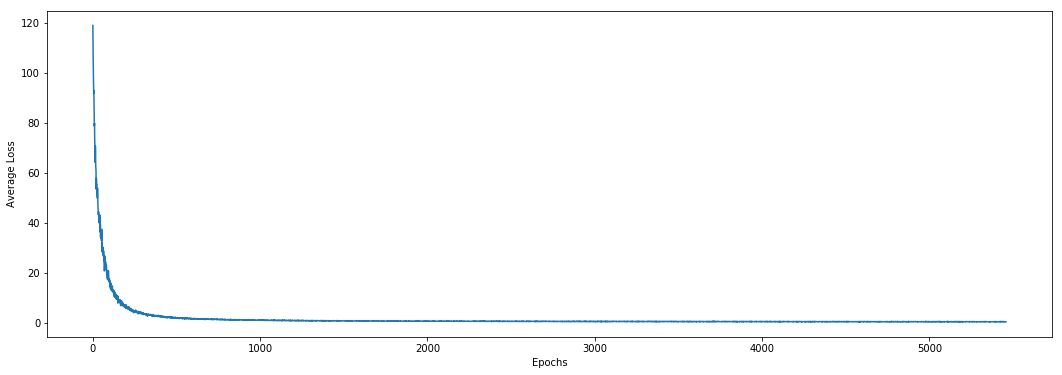

In [36]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for 
          i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [21]:
vector = tf.placeholder(dtype=tf.float32)

#Create cosine similarity matrix

mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [22]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

In [23]:
sim_matrix = matrices[0]

np.fill_diagonal(sim_matrix, 0)

In [44]:
[i for i in web_graph.neighbors('sellercentral.amazon.ca')]

[]

In [24]:
pickle.dump(web_graph, open('graph_directed.pkl', 'wb'))
pickle.dump(final_embeddings, open('embeddings_test_domain_graph_directed.pkl', 'wb'))
pickle.dump(sim_matrix, open('cosine_matrix_test_domain_graph_directed.pkl', 'wb'))
pickle.dump(domain_inv_map, open('domain_inv_map_directed.pkl', 'wb'))

In [26]:
sim_matrix

array([[ 0.        ,  1.39680648,  1.53523004, ...,  1.51914763,
         1.38622069,  1.37006426],
       [ 1.39680648,  0.        ,  1.79387784, ...,  1.20977163,
         1.4191432 ,  1.45767069],
       [ 1.53523004,  1.79387784,  0.        , ...,  1.54028475,
         1.33019209,  1.632833  ],
       ..., 
       [ 1.51914763,  1.20977163,  1.54028475, ...,  0.        ,
         1.31228256,  1.30822349],
       [ 1.38622069,  1.4191432 ,  1.33019209, ...,  1.31228256,
         0.        ,  1.41821873],
       [ 1.37006426,  1.45767069,  1.632833  , ...,  1.30822349,
         1.41821873,  0.        ]], dtype=float32)